In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Collaborative Filtering Deep Dive

One very common problem to solve is when you have a **number of users and a number of products, and you want to recommend which products are most likely to be useful for which users.** There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a **general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.**

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. **Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.**

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of **latent factors**. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.

For this chapter we are going to work on this **movie recommendation problem**. We'll start by getting some data suitable for a collaborative filtering model.

## A First Look at the Data

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of **movie rankings (a combination of a movie ID, a user ID, and a numeric rating),** although we will just use a subset of 100,000 of them for our example. If you're interested, it would be a great learning project to try and replicate this approach on the full 25-million recommendation dataset, which you can get from their website.

The dataset is available through the usual fastai function:

In [4]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)
path, path.ls()

(Path('/root/.fastai/data/ml-100k'),
 (#23) [Path('/root/.fastai/data/ml-100k/u3.test'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/ub.test'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u2.base'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/mku.sh')...])

According to the *README*, the main table is in the file *u.data*. It is tab-separated and the columns are, respectively user, movie, rating, and timestamp. Since those names are not encoded, we need to indicate them when reading the file with Pandas. Here is a way to open this table and take a look:

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()
# ratings[ratings['user']==196] #clearly ek user ke multiple entries hhai

user  movie  rating  timestamp
0   196    242       3  881250949
1   186    302       3  891717742
2    22    377       1  878887116
3   244     51       2  880606923
4   166    346       1  886397596

Although this has all the information we need, it is not a particularly helpful way for humans to look at this data. <<movie_xtab>> shows the same data cross-tabulated into a human-friendly table.

<img alt="Crosstab of movies and users" width="632" caption="Crosstab of movies and users" id="movie_xtab" src="images/att_00040.png">

We have selected just a few of the most popular movies, and users who watch the most movies, for this crosstab example. **The empty cells in this table are the things that we would like our model to learn to fill in. Those are the places where a user has not reviewed the movie yet, presumably because they have not watched it. For each user, we would like to figure out which of those movies they might be most likely to enjoy.** 

**If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors, and so forth, and we knew the same information about each movie, then a simple way to fill in this table would be to multiply this information together for each movie and use a combination.** 

**For instance, assuming these factors range between -1 and +1, with positive numbers indicating stronger matches and negative numbers weaker ones, and the categories are science-fiction, action, and old movies, then we could represent the movie *The Last Skywalker* as:**

In [8]:
last_skywalker = np.array([0.98,0.9,-0.9])

Here, for instance, we are scoring *very science-fiction* as 0.98, *very action* as 0.9, and **very not old* as -0.9**. December 16, 2019 me released thi. We could represent a user who likes modern sci-fi action movies as:
#### nice!. very-not-old = -0.9

In [9]:
user1 = np.array([0.9,0.8,-0.6])

and we can now calculate the match between this combination:

In [10]:
(user1*last_skywalker).sum()

2.1420000000000003

When we multiply two vectors together and add up the results, this is known as the *dot product*. It is used a lot in machine learning, and forms the basis of matrix multiplication. We will be looking a lot more at matrix multiplication and dot products in <<chapter_foundations>>.

> jargon: dot product: The mathematical operation of multiplying the elements of two vectors together, and then summing up the result.

On the other hand, we might represent the movie *Casablanca* as:

#### the categories are science-fiction, action, and old movies,

In [11]:
casablanca = np.array([-0.99,-0.3,0.8])

The match between this combination is:

In [12]:
(user1*casablanca).sum()

-1.611

Since we don't know what the latent factors actually are, and we don't know how to score them for each user and movie, we should learn them.

## Learning the Latent Factors

There is surprisingly little difference between specifying the structure of a model, as we did in the last section, and learning one, since we can just use our general **gradient descent approach**.

### **Step 1** 
of this approach is to **randomly initialize some parameters**. These parameters will be a set of **latent factors for each user and movie.** We will have to decide **how many to use**. We will discuss how to select this shortly, but for illustrative purposes let's use **5 for now.** Because each user will have a set of these factors and each movie will have a set of these factors, we can show these randomly initialized values right next to the users and movies in our crosstab, and we can then fill in the **dot products for each of these combinations in the middle**. For example, <<xtab_latent>> shows what it looks like in Microsoft Excel, with the top-left cell formula displayed as an example.

<img alt="Latent factors with crosstab" width="900" caption="Latent factors with crosstab" id="xtab_latent" src="images/att_00041.png">

### **Step 2**
of this approach is to **calculate our predictions.** As we've discussed, we can do this by **simply taking the dot product of each movie with each user**. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, **the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it** 
#### or
the user doesn't like action movies and the movie doesn't have any action in it. 
#### ye to sahi hai na since we recommend wahi jo user ko chahiye
On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low.

### **Step 3** 
is to **calculate our loss**. We can use any loss function that we wish; let's pick **mean squared error for now**, since that is one reasonable way to represent the accuracy of a prediction.

### **That's all we need.** 
With this in place, we can **optimize our parameters** (that is, the latent factors) using **stochastic gradient descent, such as to minimize the loss.** At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.

**To use the usual `Learner.fit` function we will need to get our data into a `DataLoaders`, so let's focus on that now.**

## Creating the DataLoaders

When showing the data, we would rather see movie titles than their IDs. The table `u.item` **movies.csv when downloaded** contains the correspondence of IDs to titles:

In [13]:
# ye dekhne ke liye ki baki columns kaise dikhte hai
# movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
#                      usecols=(0,1,2,3), names=('movie','title','aa','bb'), header=None)

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

movies.head()

movie              title
0      1   Toy Story (1995)
1      2   GoldenEye (1995)
2      3  Four Rooms (1995)
3      4  Get Shorty (1995)
4      5     Copycat (1995)

In [14]:
ratings.head()

user  movie  rating  timestamp
0   196    242       3  881250949
1   186    302       3  891717742
2    22    377       1  878887116
3   244     51       2  880606923
4   166    346       1  886397596

We can merge this with our `ratings` table to get the user ratings by title:
#### ye sirf apne kaam ke liye hai na? nahi, since hamko movie id ko name se replace karna hai

In [15]:
ratings = ratings.merge(movies)
ratings.head()

user  movie  rating  timestamp         title
0   196    242       3  881250949  Kolya (1996)
1    63    242       3  875747190  Kolya (1996)
2   226    242       5  883888671  Kolya (1996)
3   154    242       3  879138235  Kolya (1996)
4   306    242       5  876503793  Kolya (1996)

**We can then build a `DataLoaders` object from this table. By default, it takes the first column for the user, the second column for the item (here our movies), and the third column for the ratings. We need to change the value of `item_name` in our case to use the titles instead of the movie IDs:**
#### yes, makes sense, this is second axis, first is user id, output variable is rating
## CollabDataLoaders.from_df

In [16]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

To represent collaborative filtering in PyTorch we can't just use the crosstab representation directly, especially if we want it to fit into our deep learning framework. **We can represent our movie and user latent factor tables as simple matrices:**

In [18]:
type(dls.classes), dls.classes
# jitne bhi items hai ek dls object me, sab dikha do

(dict,
 {'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

In [19]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

print(n_users, n_movies)

944 1665


### shape of matrix is important
#### observe ki this is like rows = #of users/movies, columns = (5) factors

In [20]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors. But *look up in an index* is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.

**Fortunately, it turns out that we can represent *look up in an index* as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index 3:**

### nice way!

In [22]:
one_hot_3 = one_hot(3, n_users).float()
one_hot_3.shape, n_users, one_hot_3[:20]

(torch.Size([944]),
 944,
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [23]:
user_factors.shape, user_factors[3]

(torch.Size([944, 5]), tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908]))

In [24]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

### ofc it is 'looking up into', kuch special nahi kiya hai
It gives us the same vector as the one at index 3 in the matrix:

In [25]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

If we do that for a few indices at once, we will have a matrix of one-hot-encoded vectors, and that operation will be a **matrix multiplication! This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary.** We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. Therefore, most deep learning libraries, including PyTorch, include a **special layer** that does just this; **it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an *embedding*.**
### theek theek samjha

> jargon: **Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the _embedding matrix_.**

*In computer vision, we have a very easy way to get all the information of a pixel through its RGB values: each pixel in a colored image is represented by three numbers. Those three numbers give us the redness, the greenness and the blueness, which is enough to get our model to work afterward.*

**For the problem at hand (movie recommendation), we don't have the same easy way to characterize a user or a movie. There are probably relations with genres: if a given user likes romance, they are likely to give higher scores to romance movies. Other factors might be whether the movie is more action-oriented versus heavy on dialogue, or the presence of a specific actor that a user might particularly like.** 

**How do we determine numbers to characterize those? The answer is, we don't. We will let our model *learn* them. By analyzing the existing relations between users and movies, our model can figure out itself the features that seem important or not.**

#### **This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, `n_factors=5`), and we will make those learnable parameters. That means that at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss with respect to those embedding vectors and update them with the rules of SGD (or another optimizer).**

At the beginning, those numbers don't mean anything since we have chosen them randomly, but by the end of training, they will. By learning on existing data about the relations between users and movies, without having any other information, we will see that they still get some important features, and can isolate blockbusters from independent cinema, action movies from romance, and so on.

### OP!!
**We are now in a position that we can create our whole model from scratch.**

## Collaborative Filtering from Scratch

Before we can write a model in PyTorch, we first need to learn the basics of object-oriented programming and Python. If you haven't done any object-oriented programming before, we will give you a quick introduction here, but we would recommend looking up a tutorial and getting some practice before moving on.

**The key idea in object-oriented programming is the *class*.** We have been using classes throughout this book, such as `DataLoader`, `string`, and `Learner`. Python also makes it easy for us to create new classes. Here is an example of a simple class:

In [26]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'
    #def say(self,x): return f'Hello {a}, {x}.' # this will not work

In [27]:
# observe ki {}, {}.format use karne ki jagah pe direct curly brackets 
# ke andar daala hai jo output chahiye tha

**The most important piece of this is the special method called `__init__` (pronounced *dunder init*). In Python, any method surrounded in double underscores like this is considered special. It indicates that there is some extra behavior associated with this method name. In the case of `__init__`, this is the method Python will call when your new object is created. So, this is where you can set up any state that needs to be initialized upon object creation.**

## yosssss!
**Any parameters included when the user constructs an instance of your class will be passed to the `__init__` method as parameters.** 

*Note that the **first parameter to any method defined inside a class is `self`,** so you can use this to set and get any attributes that you will need:*

## **remember ki jo sylvain hai, wo init me pass hota hai**
## **ex.say me jo pass hoga, wo doosra hai**

In [28]:
ex = Example('Sylvain')
# abhi sylvain a me jaa chuka hai
print(ex.a)
ex.say('nice to meet you')

Sylvain


'Hello Sylvain, nice to meet you.'

**Also note that creating a new PyTorch module requires inheriting from `Module`. *Inheritance* is an important object-oriented concept that we will not discuss in detail here—in short, it means that we can add additional behavior to an existing class.**

PyTorch already provides a `Module` class, which provides some basic foundations that we want to build on. **So, we add the name of this *superclass* after the name of the class that we are defining, as shown in the following example.**

The final thing that you need to know to create a new PyTorch module is that **when your module is called, PyTorch will call a method in your class called `forward`, and will pass along to that any parameters that are included in the call. Here is the class defining our dot product model:**

In [29]:
# Embedding: Multiplying by a one-hot-encoded matrix, using the computational 
# shortcut that it can be implemented by simply indexing directly.
# This is quite a fancy word for a very simple concept. 
# The thing that you multiply the one-hot-encoded matrix by
# (or, using the computational shortcut, index into directly)
# is called the embedding matrix.

In [30]:
# n_users  = len(dls.classes['user'])
# n_movies = len(dls.classes['title'])
# n_factors = 5

# print(n_users, n_movies)

#### agar module liya to forward aata hai

In [31]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        #print(self.user_factors,'\n\n', self.movie_factors)
        #print(self.user_factors.shape,'\n\n', self.movie_factors.shape)
        # no attribute shape bolte
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        # hopefully these are only one-column wale vectors
        #print(movies, users)
        print(movies.shape, movies) # did not work
        
        #returning matrix dot multiplication only? and 1st dimension ka sum
        return (users * movies).sum(dim=1)

If you haven't seen object-oriented programming before, then don't worry, you won't need to use it much in this book. We are just mentioning this approach here, because most online tutorials and documentation will use the object-oriented syntax.

Note that the input of the model **matlab yaha forward function wale ki baat kiya hai is a tensor of shape `batch_size x 2`, where the first column (`x[:, 0]`) contains the user IDs and the second column (`x[:, 1]`) contains the movie IDs. As explained before, we use the *embedding* layers to represent our matrices of user and movie latent factors:**


In [32]:
x,y = dls.one_batch()
x.shape,y.shape, x, y

(torch.Size([64, 2]),
 torch.Size([64, 1]),
 tensor([[ 661,  659],
         [ 861,  730],
         [ 766,    8],
         [  13, 1153],
         [ 429, 1185],
         [ 488, 1242],
         [ 675, 1638],
         [ 271,  987],
         [ 677,  772],
         [ 301, 1139],
         [ 874,  830],
         [ 593, 1097],
         [ 814, 1065],
         [ 897,  274],
         [ 635, 1370],
         [ 567, 1067],
         [ 399,  241],
         [ 649, 1524],
         [ 309, 1347],
         [ 378,  356],
         [ 104, 1589],
         [ 197,  622],
         [ 886, 1442],
         [  78, 1610],
         [ 480,  774],
         [ 457,  110],
         [ 815, 1290],
         [ 840,  624],
         [ 804,  180],
         [ 627, 1017],
         [ 102,  600],
         [ 904,  374],
         [ 301,  262],
         [ 561,  374],
         [ 301,  754],
         [ 439,  426],
         [ 171, 1303],
         [ 730, 1102],
         [ 239, 1649],
         [ 454,  274],
         [ 871, 1616],
         [ 65

Now that we have defined our architecture, and created our parameter matrices, we need to create a `Learner` to optimize our model. **In the past we have used special functions, such as `cnn_learner`, which set up everything for us for a particular application. Since we are doing things from scratch here, we will use the plain `Learner` class:**

In [33]:
model = DotProduct(n_users, n_movies, 50)
print(model.user_factors, model.movie_factors)

Embedding(944, 50) Embedding(1665, 50)


#### sirf user factors and movie factors ki embedding bani hai abhi tak, maybe nahi. because forward to direct hi ban jata hai

In [37]:
# print(model.forward.users) #nahi jama
model.forward??

In [38]:
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to fit our model:

In [39]:
learn.fit_one_cycle(5, 5e-3)

torch.Size([64, 50]) tensor([[-0.0187,  0.0002, -0.0139,  ...,  0.0029,  0.0098,  0.0179],
        [ 0.0076,  0.0022, -0.0099,  ..., -0.0055,  0.0027,  0.0065],
        [ 0.0103,  0.0058,  0.0087,  ..., -0.0007, -0.0049, -0.0008],
        ...,
        [ 0.0068,  0.0009, -0.0024,  ...,  0.0051, -0.0109, -0.0010],
        [-0.0121,  0.0085, -0.0041,  ...,  0.0148,  0.0033,  0.0055],
        [-0.0135,  0.0030, -0.0055,  ..., -0.0011,  0.0047,  0.0089]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0133,  0.0054, -0.0062,  ..., -0.0096, -0.0005,  0.0150],
        [ 0.0142,  0.0102,  0.0010,  ..., -0.0157,  0.0082, -0.0009],
        [ 0.0038,  0.0085, -0.0085,  ..., -0.0018,  0.0011, -0.0182],
        ...,
        [-0.0030, -0.0104, -0.0056,  ..., -0.0038,  0.0121,  0.0049],
        [-0.0071, -0.0127, -0.0012,  ..., -0.0067,  0.0058,  0.0125],
        [-0.0071, -0.0076,  0.0022,  ...,  0.0099,  0.0038, -0.0064]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 0.0081,  0.0022, -0.0179,  ...,  0.0017, -0.0093,  0.0067],
        [-0.0195, -0.0042, -0.0072,  ...,  0.0026,  0.0069, -0.0035],
        [ 0.0081,  0.0039, -0.0123,  ..., -0.0093, -0.0100, -0.0178],
        ...,
        [ 0.0083, -0.0208, -0.0080,  ..., -0.0070, -0.0162, -0.0014],
        [-0.0088, -0.0036,  0.0056,  ...,  0.0056,  0.0102,  0.0044],
        [ 0.0016, -0.0101,  0.0202,  ...,  0.0068,  0.0016, -0.0096]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0041,  0.0110, -0.0069,  ..., -0.0024, -0.0020, -0.0058],
        [ 0.0026, -0.0051,  0.0050,  ...,  0.0086,  0.0083, -0.0184],
        [-0.0055,  0.0006, -0.0176,  ...,  0.0182,  0.0136,  0.0003],
        ...,
        [ 0.0142,  0.0167, -0.0054,  ..., -0.0035, -0.0008, -0.0062],
        [-0.0042, -0.0121, -0.0141,  ...,  0.0003,  0.0146, -0.0021],
        [ 0.0007, -0.0133,  0.0098,  ...,  0.0075,  0.0076, -0.0133]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 0.0032, -0.0047, -0.0082,  ..., -0.0182,  0.0032, -0.0082],
        [ 0.0057, -0.0050,  0.0045,  ..., -0.0203,  0.0005,  0.0022],
        [ 0.0119,  0.0090, -0.0095,  ...,  0.0008, -0.0096, -0.0066],
        ...,
        [ 0.0088, -0.0013, -0.0081,  ..., -0.0148,  0.0032,  0.0135],
        [-0.0041, -0.0020, -0.0081,  ..., -0.0047,  0.0068,  0.0084],
        [-0.0025, -0.0015,  0.0132,  ..., -0.0004,  0.0006,  0.0009]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0013, -0.0074,  0.0068,  ...,  0.0098, -0.0068, -0.0003],
        [ 0.0086,  0.0002, -0.0036,  ..., -0.0097,  0.0053,  0.0084],
        [-0.0013,  0.0114, -0.0017,  ..., -0.0020, -0.0004,  0.0108],
        ...,
        [-0.0063, -0.0094,  0.0050,  ...,  0.0014,  0.0120,  0.0087],
        [ 0.0049, -0.0037,  0.0054,  ...,  0.0031, -0.0133,  0.0057],
        [-0.0139, -0.0098,  0.0044,  ...,  0.0035,  0.0070,  0.0040]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 1.5494e-04,  1.3297e-02, -8.3739e-03,  ..., -1.0094e-02, -1.1686e-02,  1.9629e-02],
        [ 2.8319e-03, -1.3976e-02, -1.1508e-02,  ..., -5.2373e-03, -2.7298e-03, -1.5362e-02],
        [-6.1021e-03,  2.5938e-03,  1.7051e-02,  ...,  1.0792e-02,  1.1627e-03,  7.9513e-03],
        ...,
        [ 6.9907e-03, -6.0757e-03, -3.4917e-03,  ..., -6.2173e-05, -3.5061e-03,  1.5990e-02],
        [ 1.7482e-03, -1.0302e-02, -2.4238e-03,  ..., -7.3839e-03, -9.9768e-03, -1.5432e-02],
        [-7.3353e-03,  6.7324e-03,  9.1875e-03,  ..., -1.3209e-02, -9.4695e-03, -1.3488e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0028,  0.0096,  0.0085,  ...,  0.0025, -0.0091, -0.0052],
        [ 0.0040,  0.0004, -0.0005,  ..., -0.0088,  0.0049, -0.0021],
        [-0.0042,  0.0080, -0.0015,  ..., -0.0069, -0.0148,  0.0067],
        ...,
        [-0.0161, -0.0026, -0.0145,  ...,  0.0012,  0.0077,  0.0157],
        [-0.0025, -0.0074, -0.0196,  ...,

torch.Size([64, 50]) tensor([[ 0.0202, -0.0127, -0.0074,  ..., -0.0001,  0.0048,  0.0009],
        [ 0.0014, -0.0003, -0.0013,  ..., -0.0099, -0.0052,  0.0184],
        [-0.0021, -0.0083,  0.0153,  ..., -0.0016,  0.0182, -0.0038],
        ...,
        [-0.0015, -0.0034, -0.0105,  ..., -0.0138,  0.0153,  0.0046],
        [-0.0077,  0.0057,  0.0024,  ..., -0.0073, -0.0024, -0.0081],
        [-0.0176,  0.0138, -0.0043,  ...,  0.0008,  0.0078, -0.0171]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0028, -0.0159,  0.0127,  ...,  0.0095,  0.0091, -0.0132],
        [ 0.0014,  0.0045, -0.0015,  ..., -0.0035, -0.0072, -0.0079],
        [ 0.0056, -0.0090, -0.0071,  ...,  0.0020, -0.0035, -0.0167],
        ...,
        [ 0.0090, -0.0072,  0.0097,  ..., -0.0021, -0.0117, -0.0059],
        [-0.0082,  0.0024,  0.0058,  ..., -0.0052, -0.0167,  0.0009],
        [-0.0205, -0.0038, -0.0085,  ...,  0.0020,  0.0055, -0.0045]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 7.8768e-03, -1.7631e-02, -3.2048e-03,  ..., -1.2429e-02,  1.8601e-02, -1.4297e-02],
        [ 6.0360e-03, -8.5558e-03,  6.2708e-03,  ..., -8.1401e-03,  1.5309e-02,  3.5682e-03],
        [-2.1943e-03, -1.5683e-02, -7.9856e-03,  ..., -6.4932e-03, -4.5476e-05, -9.5791e-03],
        ...,
        [-7.7943e-03,  6.0711e-03,  2.4349e-03,  ..., -7.6086e-03, -2.8850e-03, -8.0201e-03],
        [ 5.2593e-03,  1.3027e-02, -1.9308e-03,  ...,  9.1192e-03,  1.2012e-03, -2.0957e-02],
        [-5.7742e-03,  2.5461e-03, -8.9024e-03,  ..., -1.3531e-03,  1.0688e-03,  1.4712e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0038,  0.0012,  0.0039,  ...,  0.0041, -0.0107, -0.0130],
        [ 0.0020,  0.0179,  0.0007,  ...,  0.0091, -0.0136,  0.0068],
        [-0.0070,  0.0141,  0.0016,  ...,  0.0016, -0.0042, -0.0042],
        ...,
        [-0.0065, -0.0142,  0.0065,  ...,  0.0053, -0.0058, -0.0074],
        [-0.0017, -0.0163, -0.0149,  ...,

torch.Size([64, 50]) tensor([[ 0.0039, -0.0010,  0.0032,  ...,  0.0013,  0.0045, -0.0025],
        [ 0.0006,  0.0064, -0.0038,  ...,  0.0028,  0.0051,  0.0189],
        [ 0.0069, -0.0051, -0.0167,  ...,  0.0044, -0.0122, -0.0079],
        ...,
        [ 0.0034,  0.0044, -0.0098,  ...,  0.0013,  0.0061, -0.0014],
        [-0.0108,  0.0070, -0.0109,  ...,  0.0057,  0.0118, -0.0137],
        [-0.0103, -0.0131,  0.0046,  ..., -0.0097,  0.0037,  0.0165]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0030, -0.0093, -0.0048,  ..., -0.0016,  0.0016, -0.0083],
        [-0.0206, -0.0032, -0.0078,  ...,  0.0022,  0.0063, -0.0051],
        [ 0.0033,  0.0089,  0.0111,  ...,  0.0049, -0.0051, -0.0007],
        ...,
        [-0.0106, -0.0027, -0.0116,  ...,  0.0098,  0.0050,  0.0021],
        [-0.0089,  0.0006, -0.0002,  ...,  0.0055, -0.0078,  0.0011],
        [ 0.0124, -0.0049,  0.0057,  ...,  0.0004,  0.0103,  0.0193]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0060,  0.0052, -0.0008,  ..., -0.0070, -0.0153, -0.0093],
        [-0.0115,  0.0035, -0.0034,  ...,  0.0067, -0.0017, -0.0146],
        [ 0.0107,  0.0099, -0.0065,  ..., -0.0061, -0.0128, -0.0014],
        ...,
        [-0.0139,  0.0021, -0.0046,  ...,  0.0088, -0.0053,  0.0040],
        [ 0.0102,  0.0019,  0.0063,  ...,  0.0178, -0.0008,  0.0030],
        [ 0.0054, -0.0092, -0.0079,  ..., -0.0074, -0.0006,  0.0183]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0142,  0.0036, -0.0108,  ...,  0.0064,  0.0087, -0.0057],
        [-0.0018,  0.0144, -0.0012,  ...,  0.0157,  0.0036,  0.0089],
        [-0.0157,  0.0006, -0.0071,  ...,  0.0062,  0.0013,  0.0025],
        ...,
        [-0.0089, -0.0130,  0.0138,  ..., -0.0118, -0.0024,  0.0024],
        [ 0.0033,  0.0035, -0.0084,  ...,  0.0141,  0.0179,  0.0031],
        [ 0.0093,  0.0024, -0.0064,  ..., -0.0162,  0.0032,  0.0147]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 0.0152, -0.0030, -0.0146,  ...,  0.0004,  0.0061,  0.0083],
        [-0.0079,  0.0100, -0.0182,  ..., -0.0090, -0.0083, -0.0132],
        [ 0.0021,  0.0113, -0.0062,  ..., -0.0192, -0.0037,  0.0032],
        ...,
        [-0.0149, -0.0019,  0.0099,  ...,  0.0050, -0.0069,  0.0130],
        [-0.0052, -0.0026, -0.0151,  ..., -0.0063,  0.0185, -0.0053],
        [ 0.0026,  0.0140,  0.0121,  ...,  0.0060,  0.0012,  0.0142]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0041,  0.0001,  0.0151,  ...,  0.0134,  0.0112, -0.0058],
        [-0.0115, -0.0033, -0.0033,  ...,  0.0089, -0.0091, -0.0199],
        [ 0.0011,  0.0069, -0.0107,  ...,  0.0048,  0.0095,  0.0075],
        ...,
        [-0.0046, -0.0034, -0.0044,  ...,  0.0018, -0.0130,  0.0184],
        [-0.0110,  0.0116, -0.0062,  ..., -0.0027,  0.0129,  0.0010],
        [-0.0114,  0.0041, -0.0023,  ...,  0.0079, -0.0024, -0.0142]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 0.0043, -0.0013,  0.0029,  ...,  0.0157,  0.0029,  0.0139],
        [ 0.0061, -0.0090,  0.0004,  ..., -0.0075, -0.0134, -0.0046],
        [ 0.0002, -0.0027,  0.0045,  ..., -0.0007, -0.0109,  0.0054],
        ...,
        [-0.0059,  0.0035,  0.0184,  ...,  0.0109, -0.0028,  0.0044],
        [ 0.0042, -0.0115,  0.0088,  ...,  0.0150,  0.0087,  0.0093],
        [ 0.0016,  0.0116,  0.0063,  ..., -0.0132, -0.0054, -0.0043]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0079,  0.0026,  0.0191,  ...,  0.0027, -0.0180, -0.0065],
        [-0.0015,  0.0229,  0.0045,  ..., -0.0059, -0.0097,  0.0170],
        [ 0.0009, -0.0150,  0.0181,  ..., -0.0084, -0.0048,  0.0020],
        ...,
        [ 0.0034, -0.0239,  0.0064,  ..., -0.0016, -0.0219, -0.0173],
        [ 0.0073, -0.0068, -0.0095,  ..., -0.0098,  0.0034,  0.0191],
        [-0.0103, -0.0045,  0.0088,  ..., -0.0074,  0.0076,  0.0005]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 3.9895e-03,  1.1047e-02, -6.4415e-03,  ..., -7.5953e-03, -1.0941e-02, -6.4833e-03],
        [ 3.8265e-03,  4.8472e-03, -1.6773e-03,  ..., -1.8391e-02, -2.4490e-03, -1.4092e-02],
        [-1.7572e-05,  1.1258e-03, -1.4997e-02,  ...,  1.4273e-02,  6.8383e-03, -1.9278e-02],
        ...,
        [-5.3267e-03,  2.0950e-04, -7.6976e-03,  ..., -2.7596e-03,  2.2026e-03,  1.0224e-02],
        [ 7.7768e-03,  1.1632e-02, -1.0850e-02,  ..., -1.1468e-02, -7.2360e-03,  8.5592e-03],
        [ 4.1715e-03,  4.3005e-03,  2.0348e-03,  ..., -6.4837e-05,  1.6471e-03, -8.7495e-03]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0111, -0.0154, -0.0021,  ..., -0.0107, -0.0200,  0.0032],
        [-0.0033, -0.0151, -0.0064,  ..., -0.0111,  0.0018, -0.0092],
        [ 0.0137, -0.0157,  0.0105,  ...,  0.0078,  0.0029, -0.0053],
        ...,
        [-0.0035, -0.0117,  0.0162,  ...,  0.0035, -0.0025, -0.0004],
        [ 0.0089,  0.0042, -0.0065,  ...,

torch.Size([64, 50]) tensor([[-0.0132, -0.0031,  0.0084,  ..., -0.0069,  0.0066,  0.0021],
        [ 0.0062,  0.0164,  0.0068,  ...,  0.0103,  0.0094,  0.0037],
        [ 0.0033,  0.0048, -0.0121,  ..., -0.0050,  0.0063, -0.0199],
        ...,
        [-0.0027,  0.0011,  0.0157,  ..., -0.0085,  0.0105,  0.0017],
        [-0.0140, -0.0018,  0.0062,  ...,  0.0051, -0.0216, -0.0090],
        [ 0.0061, -0.0016,  0.0076,  ...,  0.0137, -0.0022, -0.0207]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0023, -0.0137,  0.0042,  ..., -0.0083, -0.0157,  0.0122],
        [-0.0015, -0.0054, -0.0036,  ...,  0.0097, -0.0092,  0.0010],
        [ 0.0132,  0.0074, -0.0154,  ...,  0.0111, -0.0017, -0.0045],
        ...,
        [ 0.0031, -0.0126,  0.0014,  ...,  0.0057,  0.0112,  0.0020],
        [ 0.0033,  0.0049, -0.0122,  ..., -0.0049,  0.0063, -0.0198],
        [-0.0067,  0.0062, -0.0072,  ..., -0.0002,  0.0071,  0.0048]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-1.0595e-02, -9.9874e-03, -5.7108e-03,  ...,  8.1367e-03,  1.2774e-02, -1.5517e-02],
        [-9.8066e-04, -1.0417e-02,  2.1449e-02,  ...,  9.9202e-03, -1.1176e-05, -1.3294e-02],
        [-2.0399e-03,  1.6283e-03,  5.8833e-03,  ..., -6.3997e-03,  6.3521e-03,  1.5589e-03],
        ...,
        [ 5.6651e-03,  8.9871e-03, -1.2482e-02,  ...,  6.3982e-03, -1.3260e-02, -2.7264e-03],
        [-1.4074e-02, -9.4233e-04, -1.4497e-03,  ...,  4.3148e-03, -5.6662e-03, -1.7854e-02],
        [-1.1837e-02, -5.9345e-03, -5.0685e-03,  ..., -5.3699e-03, -2.8026e-03,  1.1053e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0025,  0.0004,  0.0062,  ..., -0.0084, -0.0002, -0.0062],
        [ 0.0005, -0.0023, -0.0083,  ...,  0.0074, -0.0031,  0.0022],
        [-0.0083, -0.0080, -0.0061,  ..., -0.0015, -0.0058,  0.0063],
        ...,
        [ 0.0110,  0.0079, -0.0024,  ..., -0.0045,  0.0083, -0.0106],
        [-0.0017,  0.0111,  0.0081,  ...,

torch.Size([64, 50]) tensor([[ 0.0031,  0.0128,  0.0117,  ...,  0.0076, -0.0076, -0.0050],
        [ 0.0083,  0.0079, -0.0088,  ..., -0.0141, -0.0087,  0.0108],
        [-0.0120,  0.0072, -0.0082,  ...,  0.0181,  0.0010, -0.0009],
        ...,
        [ 0.0069, -0.0057, -0.0157,  ...,  0.0088, -0.0030,  0.0026],
        [ 0.0121, -0.0164, -0.0016,  ..., -0.0108, -0.0195,  0.0039],
        [-0.0104,  0.0124, -0.0202,  ...,  0.0087,  0.0117, -0.0179]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0034,  0.0093, -0.0008,  ..., -0.0067, -0.0016,  0.0063],
        [ 0.0005,  0.0005, -0.0059,  ..., -0.0107,  0.0096,  0.0047],
        [ 0.0046, -0.0008, -0.0034,  ...,  0.0066, -0.0099, -0.0013],
        ...,
        [-0.0068, -0.0177, -0.0109,  ...,  0.0030,  0.0109,  0.0031],
        [-0.0053, -0.0136,  0.0169,  ..., -0.0067, -0.0089,  0.0137],
        [ 0.0034, -0.0071,  0.0049,  ...,  0.0037,  0.0050,  0.0216]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0047, -0.0015, -0.0155,  ...,  0.0033,  0.0032,  0.0042],
        [ 0.0085,  0.0118,  0.0032,  ...,  0.0044, -0.0013,  0.0058],
        [-0.0008,  0.0087, -0.0017,  ..., -0.0009,  0.0097,  0.0089],
        ...,
        [-0.0056,  0.0013, -0.0062,  ..., -0.0039, -0.0045, -0.0058],
        [-0.0002, -0.0183,  0.0198,  ...,  0.0065, -0.0122, -0.0112],
        [ 0.0008, -0.0114,  0.0068,  ..., -0.0009, -0.0098,  0.0059]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 9.9883e-03, -1.2382e-02,  1.0772e-02,  ...,  9.9367e-03,  5.1987e-05, -6.2359e-03],
        [ 9.8584e-03, -5.2710e-03, -4.1329e-04,  ..., -8.2968e-03, -2.5592e-03, -2.4314e-02],
        [-9.1741e-03, -1.2154e-02, -6.3160e-03,  ...,  8.8165e-03,  1.1010e-02, -1.5023e-02],
        ...,
        [-6.9324e-03, -1.3087e-02, -1.8978e-02,  ...,  5.1197e-04,  4.2000e-03, -7.6755e-03],
        [-4.4751e-03,  7.6407e-03, -1.3961e-02,  ...,  1.6062e-02,  2.3016e-02,  7.9447e-

torch.Size([64, 50]) tensor([[-0.0046, -0.0031,  0.0077,  ...,  0.0058,  0.0150,  0.0002],
        [ 0.0105,  0.0078, -0.0143,  ..., -0.0090, -0.0039, -0.0011],
        [-0.0041, -0.0095, -0.0027,  ...,  0.0163,  0.0076, -0.0077],
        ...,
        [-0.0019, -0.0013, -0.0048,  ...,  0.0076, -0.0037, -0.0067],
        [-0.0070,  0.0174, -0.0065,  ...,  0.0136,  0.0079,  0.0070],
        [ 0.0130, -0.0017, -0.0141,  ..., -0.0038, -0.0011,  0.0019]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0092, -0.0078, -0.0079,  ...,  0.0089,  0.0092, -0.0040],
        [ 0.0070,  0.0022,  0.0011,  ..., -0.0042,  0.0160, -0.0141],
        [ 0.0069, -0.0094, -0.0053,  ..., -0.0123, -0.0093,  0.0133],
        ...,
        [-0.0116,  0.0012,  0.0003,  ...,  0.0090,  0.0039, -0.0036],
        [-0.0032, -0.0184,  0.0141,  ...,  0.0050, -0.0001, -0.0063],
        [-0.0116,  0.0108,  0.0022,  ...,  0.0029,  0.0024, -0.0098]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0100, -0.0085,  0.0067,  ...,  0.0182, -0.0031,  0.0032],
        [ 0.0008,  0.0050, -0.0069,  ...,  0.0017,  0.0057, -0.0018],
        [-0.0211, -0.0096,  0.0083,  ...,  0.0011, -0.0102,  0.0147],
        ...,
        [ 0.0105, -0.0047,  0.0029,  ...,  0.0024,  0.0079, -0.0001],
        [-0.0187,  0.0013,  0.0126,  ...,  0.0277,  0.0194, -0.0110],
        [-0.0054, -0.0214,  0.0070,  ..., -0.0036, -0.0026, -0.0128]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0158,  0.0100, -0.0082,  ..., -0.0087, -0.0072,  0.0047],
        [-0.0169, -0.0157,  0.0002,  ..., -0.0034, -0.0129, -0.0136],
        [ 0.0122,  0.0079,  0.0062,  ..., -0.0156,  0.0102, -0.0024],
        ...,
        [-0.0155,  0.0127, -0.0028,  ...,  0.0059,  0.0099, -0.0052],
        [-0.0003,  0.0061,  0.0116,  ..., -0.0137,  0.0108, -0.0221],
        [-0.0164, -0.0228,  0.0060,  ..., -0.0096,  0.0060,  0.0110]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-1.3017e-02,  5.4810e-03,  1.9611e-03,  ..., -6.5473e-04,  2.6363e-03, -9.2092e-03],
        [-1.2531e-03, -7.2343e-03,  5.7863e-03,  ..., -2.7829e-02,  5.8425e-05, -1.5738e-02],
        [ 3.2793e-03,  6.4117e-03, -9.3441e-04,  ..., -4.0861e-03, -1.2436e-02,  1.0369e-02],
        ...,
        [ 5.8122e-03, -6.7750e-04, -5.8343e-03,  ..., -1.9937e-03,  8.8212e-03, -8.7033e-03],
        [ 9.7776e-03,  5.0164e-03, -1.0542e-02,  ...,  8.4767e-03, -1.7742e-02, -1.7019e-04],
        [-3.1518e-03, -1.6681e-02,  6.9441e-04,  ..., -7.1542e-03,  1.8059e-02, -1.5177e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 0.0022, -0.0016, -0.0217,  ...,  0.0033, -0.0211, -0.0085],
        [ 0.0015, -0.0086,  0.0185,  ..., -0.0065,  0.0101,  0.0167],
        [-0.0227, -0.0189,  0.0208,  ..., -0.0153, -0.0144, -0.0027],
        ...,
        [ 0.0075, -0.0031,  0.0085,  ..., -0.0124, -0.0121,  0.0128],
        [ 0.0077, -0.0050,  0.0051,  ...,

torch.Size([64, 50]) tensor([[ 0.0081, -0.0148,  0.0063,  ..., -0.0002, -0.0095, -0.0090],
        [ 0.0028, -0.0057, -0.0115,  ..., -0.0265, -0.0057, -0.0042],
        [-0.0145,  0.0041, -0.0089,  ..., -0.0106, -0.0040, -0.0023],
        ...,
        [-0.0016, -0.0110,  0.0196,  ..., -0.0153, -0.0210, -0.0022],
        [-0.0108, -0.0108,  0.0060,  ...,  0.0148, -0.0058, -0.0134],
        [ 0.0004, -0.0046,  0.0006,  ..., -0.0166,  0.0089, -0.0297]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0090,  0.0009, -0.0164,  ..., -0.0148, -0.0032, -0.0102],
        [ 0.0215, -0.0142,  0.0134,  ..., -0.0035,  0.0287, -0.0067],
        [-0.0009, -0.0166,  0.0114,  ...,  0.0145,  0.0086, -0.0173],
        ...,
        [ 0.0057, -0.0065, -0.0039,  ..., -0.0139,  0.0003,  0.0071],
        [-0.0184, -0.0123, -0.0065,  ..., -0.0085,  0.0104, -0.0258],
        [-0.0112, -0.0099, -0.0105,  ...,  0.0046, -0.0062, -0.0071]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 0.0178, -0.0085, -0.0082,  ...,  0.0064,  0.0161, -0.0222],
        [-0.0203, -0.0139, -0.0214,  ..., -0.0010,  0.0172,  0.0056],
        [ 0.0017,  0.0032,  0.0109,  ..., -0.0127,  0.0104, -0.0163],
        ...,
        [ 0.0032, -0.0097, -0.0015,  ..., -0.0048, -0.0046, -0.0058],
        [-0.0025,  0.0057, -0.0073,  ..., -0.0063,  0.0097,  0.0110],
        [-0.0260, -0.0298, -0.0067,  ..., -0.0121, -0.0033, -0.0242]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0014, -0.0105,  0.0051,  ..., -0.0191,  0.0106, -0.0073],
        [ 0.0027,  0.0036,  0.0169,  ...,  0.0008, -0.0012, -0.0025],
        [ 0.0054, -0.0160, -0.0043,  ..., -0.0141,  0.0032, -0.0084],
        ...,
        [ 0.0043, -0.0158,  0.0074,  ...,  0.0158,  0.0210,  0.0005],
        [ 0.0083,  0.0055,  0.0136,  ...,  0.0066,  0.0091, -0.0068],
        [ 0.0097, -0.0166,  0.0152,  ..., -0.0012,  0.0265, -0.0284]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-9.7635e-03, -1.7081e-04, -5.2717e-03,  ..., -2.7587e-03,  5.5010e-03,  5.9097e-03],
        [-1.5291e-02, -2.2850e-02, -1.4870e-02,  ...,  5.5156e-03,  6.4145e-03,  1.0159e-02],
        [ 6.1938e-03, -2.3921e-02, -9.6391e-03,  ..., -2.0634e-02,  2.5199e-03, -1.9306e-02],
        ...,
        [-8.2546e-03, -1.2067e-02,  4.8155e-05,  ...,  1.6004e-02,  2.2452e-02, -7.9997e-03],
        [-1.3012e-02, -2.1960e-02,  7.2260e-03,  ..., -1.1349e-02,  4.3525e-03, -6.6567e-03],
        [-1.5320e-02, -8.5247e-04, -6.7240e-04,  ...,  4.8217e-03, -1.9598e-03, -1.2350e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[ 1.1122e-05, -2.1794e-02,  3.4387e-03,  ..., -2.7486e-05, -4.3327e-03, -1.2737e-02],
        [-1.8691e-02, -1.5834e-02,  5.2657e-04,  ..., -8.3074e-03,  1.2619e-02, -6.0953e-03],
        [-2.8039e-03,  1.9251e-03, -2.0904e-02,  ..., -5.8638e-03, -4.2398e-03,  7.4060e-03],
        ...,
        [-1.1346e-02, -2.1628e-02, -1.1

torch.Size([64, 50]) tensor([[-0.0168, -0.0336,  0.0097,  ..., -0.0118,  0.0128, -0.0167],
        [-0.0089,  0.0185, -0.0252,  ..., -0.0174,  0.0087,  0.0084],
        [ 0.0002, -0.0062, -0.0120,  ..., -0.0073,  0.0202, -0.0033],
        ...,
        [-0.0113, -0.0234, -0.0038,  ..., -0.0131, -0.0230, -0.0088],
        [ 0.0238, -0.0138,  0.0069,  ..., -0.0043,  0.0241, -0.0093],
        [-0.0035, -0.0339, -0.0084,  ..., -0.0121,  0.0292, -0.0115]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-2.8157e-05,  5.0177e-03, -1.3595e-02,  ...,  9.9588e-04, -9.3473e-03,  1.1121e-02],
        [ 7.2036e-03, -4.8219e-03,  1.6463e-02,  ..., -2.1256e-02,  1.3417e-02, -2.0725e-02],
        [-1.0726e-02, -4.3628e-03,  6.3339e-03,  ...,  1.3491e-02,  1.2186e-02,  2.3079e-02],
        ...,
        [-9.9709e-03, -1.2096e-02,  1.1261e-02,  ..., -7.2176e-03, -5.3527e-03, -8.9452e-04],
        [ 1.1409e-02, -3.9942e-02, -8.9736e-03,  ..., -1.1767e-02,  4.3783e-03, -2.5913e-

torch.Size([64, 50]) tensor([[-0.0299, -0.0316,  0.0126,  ..., -0.0005, -0.0045, -0.0018],
        [-0.0108, -0.0139, -0.0004,  ..., -0.0058, -0.0090, -0.0013],
        [ 0.0130,  0.0026, -0.0083,  ...,  0.0078,  0.0204, -0.0161],
        ...,
        [ 0.0023, -0.0197,  0.0068,  ..., -0.0047,  0.0084, -0.0064],
        [-0.0020, -0.0264, -0.0050,  ..., -0.0142,  0.0007, -0.0136],
        [-0.0202, -0.0296, -0.0106,  ...,  0.0108,  0.0009, -0.0010]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0004, -0.0034,  0.0079,  ...,  0.0157, -0.0082, -0.0188],
        [-0.0179,  0.0028,  0.0089,  ...,  0.0016, -0.0203,  0.0016],
        [-0.0142, -0.0127, -0.0074,  ..., -0.0104,  0.0045, -0.0122],
        ...,
        [ 0.0019, -0.0016,  0.0012,  ..., -0.0017,  0.0207, -0.0182],
        [-0.0226, -0.0210,  0.0219,  ..., -0.0021,  0.0121, -0.0165],
        [ 0.0002, -0.0122,  0.0025,  ...,  0.0086,  0.0023, -0.0089]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0390, -0.0124, -0.0037,  ..., -0.0061,  0.0037,  0.0031],
        [-0.0226, -0.0477, -0.0248,  ..., -0.0028,  0.0140, -0.0182],
        [-0.0030, -0.0293,  0.0151,  ...,  0.0129,  0.0050,  0.0122],
        ...,
        [-0.0061, -0.0474, -0.0101,  ..., -0.0381,  0.0201, -0.0357],
        [-0.0025, -0.0314,  0.0037,  ..., -0.0198,  0.0036, -0.0125],
        [-0.0030, -0.0263, -0.0122,  ..., -0.0094,  0.0156, -0.0169]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-1.4200e-02, -3.8774e-02,  6.9336e-03,  ..., -3.2228e-02,  2.1598e-02, -2.0594e-02],
        [-1.8360e-02, -1.6745e-02, -8.4534e-03,  ...,  8.5302e-03,  1.6530e-02, -7.5361e-03],
        [ 7.3257e-03,  5.5165e-03, -8.2119e-03,  ...,  8.8411e-03,  1.4995e-02, -1.6834e-02],
        ...,
        [ 3.5100e-03, -2.3213e-02,  9.1742e-03,  ...,  2.4455e-03,  9.9685e-03, -1.2194e-03],
        [ 6.6592e-03,  9.5947e-03,  2.8489e-02,  ..., -3.3235e-02,  5.7177e-03, -6.0436e-

torch.Size([64, 50]) tensor([[-0.0277, -0.0490, -0.0191,  ..., -0.0350,  0.0159, -0.0335],
        [ 0.0149,  0.0093, -0.0058,  ..., -0.0055, -0.0247, -0.0023],
        [-0.0297, -0.0537,  0.0080,  ..., -0.0300,  0.0400, -0.0540],
        ...,
        [-0.0224, -0.0176,  0.0227,  ...,  0.0025,  0.0065, -0.0154],
        [-0.0253, -0.0511, -0.0125,  ..., -0.0125,  0.0220, -0.0417],
        [-0.0425, -0.0456,  0.0059,  ..., -0.0090,  0.0210, -0.0210]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0121, -0.0375,  0.0068,  ..., -0.0239,  0.0190, -0.0143],
        [-0.0183, -0.0361,  0.0106,  ..., -0.0357,  0.0339, -0.0359],
        [-0.0074, -0.0115, -0.0048,  ...,  0.0089,  0.0190, -0.0185],
        ...,
        [-0.0270,  0.0022, -0.0220,  ..., -0.0222,  0.0138, -0.0197],
        [-0.0009, -0.0035, -0.0016,  ..., -0.0148,  0.0132,  0.0088],
        [-0.0381, -0.0447,  0.0118,  ..., -0.0258,  0.0445, -0.0116]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-3.6426e-02, -3.4488e-02, -7.2109e-03,  ...,  4.4023e-04,  1.9338e-02, -3.5284e-02],
        [-2.3768e-02, -3.8610e-02,  2.3052e-03,  ..., -3.7284e-02,  2.9479e-02, -2.2698e-02],
        [-1.0347e-02, -3.3094e-03,  9.9754e-03,  ..., -4.1699e-03,  1.3834e-02, -1.2871e-03],
        ...,
        [-1.3146e-02, -2.7296e-02,  8.8868e-03,  ..., -1.4606e-02,  2.2706e-02,  8.2738e-05],
        [-1.8052e-02, -1.6330e-02,  6.8386e-03,  ..., -3.2486e-02,  1.9315e-03, -9.1970e-03],
        [ 4.6065e-03, -1.9698e-02, -1.6184e-03,  ..., -1.9136e-02,  1.5444e-02,  1.8515e-03]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0224, -0.0565, -0.0104,  ..., -0.0331,  0.0192, -0.0436],
        [-0.0190, -0.0273, -0.0052,  ..., -0.0282,  0.0289, -0.0390],
        [-0.0375, -0.0354,  0.0292,  ..., -0.0038,  0.0449, -0.0457],
        ...,
        [-0.0285, -0.0240, -0.0057,  ..., -0.0214, -0.0045, -0.0221],
        [-0.0170, -0.0612,  0.0144,  ...,

torch.Size([64, 50]) tensor([[-4.4236e-02, -5.0217e-02,  1.9716e-02,  ..., -3.5298e-02,  3.1946e-02, -3.1169e-02],
        [-4.8005e-02, -2.5898e-02,  1.7728e-02,  ..., -1.6728e-02,  4.1529e-02, -4.5697e-02],
        [-1.9705e-02, -1.9943e-02,  3.1158e-02,  ..., -9.3239e-03,  1.1761e-02, -2.3670e-02],
        ...,
        [-6.7925e-03, -3.3349e-02, -1.9195e-03,  ..., -9.5092e-03,  1.0567e-02, -8.7139e-03],
        [-3.1095e-02, -1.5644e-02, -1.4559e-02,  ..., -1.3780e-02,  6.8848e-03, -3.0080e-02],
        [ 5.5880e-03,  6.1293e-03, -1.5565e-02,  ..., -3.6066e-05, -1.7271e-03,  1.1661e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0504, -0.0677, -0.0149,  ..., -0.0241,  0.0309, -0.0447],
        [-0.0244, -0.0512, -0.0298,  ..., -0.0301,  0.0242, -0.0359],
        [-0.0185, -0.0407,  0.0133,  ..., -0.0350,  0.0227, -0.0251],
        ...,
        [-0.0381, -0.0448,  0.0071,  ..., -0.0077,  0.0095, -0.0263],
        [-0.0010, -0.0030, -0.0106,  ...,

torch.Size([64, 50]) tensor([[-0.0414, -0.0897, -0.0032,  ..., -0.0531,  0.0452, -0.0613],
        [-0.0070, -0.0182,  0.0066,  ..., -0.0040,  0.0279,  0.0014],
        [-0.0251, -0.0506,  0.0022,  ..., -0.0140,  0.0385, -0.0519],
        ...,
        [-0.0378, -0.0447,  0.0079,  ..., -0.0166,  0.0288, -0.0168],
        [-0.0086, -0.0407, -0.0308,  ..., -0.0228,  0.0222, -0.0229],
        [ 0.0025, -0.0053,  0.0016,  ..., -0.0029,  0.0092, -0.0022]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0127, -0.0405, -0.0093,  ..., -0.0237,  0.0376, -0.0645],
        [-0.0481, -0.0338, -0.0181,  ..., -0.0236,  0.0442, -0.0356],
        [-0.0179, -0.0056,  0.0122,  ...,  0.0018,  0.0175, -0.0152],
        ...,
        [-0.0210, -0.0093,  0.0100,  ..., -0.0322,  0.0018, -0.0020],
        [-0.0554, -0.0675,  0.0226,  ..., -0.0501,  0.0518, -0.0511],
        [-0.0377, -0.0565, -0.0051,  ..., -0.0342,  0.0359, -0.0130]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0245, -0.0393, -0.0250,  ..., -0.0374,  0.0310, -0.0088],
        [-0.0369, -0.0167, -0.0167,  ..., -0.0241,  0.0272, -0.0402],
        [-0.0698, -0.0702,  0.0326,  ..., -0.0500,  0.0409, -0.0491],
        ...,
        [-0.0737, -0.0863, -0.0068,  ..., -0.0646,  0.0667, -0.0662],
        [-0.0505, -0.0424,  0.0303,  ..., -0.0387,  0.0270, -0.0512],
        [-0.0282, -0.0242,  0.0232,  ..., -0.0191,  0.0513, -0.0298]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0642, -0.0691,  0.0046,  ..., -0.0245,  0.0321, -0.0520],
        [-0.0077, -0.0162, -0.0243,  ..., -0.0184,  0.0283, -0.0072],
        [-0.0335, -0.0350,  0.0083,  ..., -0.0346,  0.0482, -0.0516],
        ...,
        [-0.0189, -0.0352, -0.0102,  ..., -0.0070,  0.0286, -0.0478],
        [-0.0683, -0.0869,  0.0170,  ..., -0.0571,  0.0686, -0.0642],
        [-0.0517, -0.0753, -0.0169,  ..., -0.0514,  0.0744, -0.0749]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-3.1068e-02, -6.5189e-02, -1.0648e-02,  ..., -5.8576e-02,  7.3705e-02, -6.6799e-02],
        [-5.9560e-02, -1.1017e-01,  2.0628e-02,  ..., -9.2723e-02,  6.9385e-02, -8.7895e-02],
        [-6.7772e-02, -6.0948e-02,  8.2859e-03,  ..., -5.4976e-02,  5.5911e-02, -7.9767e-02],
        ...,
        [-3.8957e-02, -2.8040e-02,  1.8989e-02,  ..., -1.8008e-02,  3.0502e-02, -3.5736e-02],
        [-3.2930e-02, -5.0759e-02,  8.2057e-05,  ..., -2.8288e-02,  4.0705e-02, -3.4940e-02],
        [-2.1123e-02, -5.3317e-02,  1.1165e-02,  ..., -3.0356e-02,  3.1983e-02, -3.5999e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0644, -0.0772,  0.0260,  ..., -0.0439,  0.0489, -0.0400],
        [-0.0203, -0.0238, -0.0024,  ...,  0.0044,  0.0207, -0.0290],
        [-0.0447, -0.0930,  0.0145,  ..., -0.0707,  0.0540, -0.0722],
        ...,
        [-0.0130, -0.0520,  0.0032,  ..., -0.0272,  0.0337, -0.0498],
        [-0.0708, -0.0663,  0.0272,  ...,

torch.Size([64, 50]) tensor([[-0.0611, -0.0625,  0.0079,  ..., -0.0596,  0.0571, -0.0658],
        [-0.0524, -0.1227, -0.0460,  ..., -0.0907,  0.0606, -0.0871],
        [-0.0361, -0.0630,  0.0073,  ..., -0.0610,  0.0635, -0.0510],
        ...,
        [-0.0464, -0.0878, -0.0138,  ..., -0.0723,  0.0581, -0.0657],
        [-0.0446, -0.0641,  0.0141,  ..., -0.0560,  0.0363, -0.0559],
        [-0.0282, -0.0614,  0.0050,  ..., -0.0220,  0.0460, -0.0526]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0526, -0.0004, -0.0058,  ..., -0.0153,  0.0006, -0.0059],
        [-0.0618, -0.0632,  0.0081,  ..., -0.0604,  0.0578, -0.0666],
        [-0.0389, -0.0578, -0.0044,  ..., -0.0390,  0.0576, -0.0589],
        ...,
        [-0.0248, -0.0177,  0.0047,  ..., -0.0283,  0.0109, -0.0064],
        [-0.0092, -0.0133, -0.0087,  ..., -0.0140,  0.0195, -0.0324],
        [-0.0108, -0.0056,  0.0280,  ..., -0.0043,  0.0049, -0.0194]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0629, -0.0885, -0.0158,  ..., -0.0956,  0.0972, -0.0972],
        [-0.0760, -0.0788, -0.0060,  ..., -0.0583,  0.0740, -0.0883],
        [-0.0522, -0.1256, -0.0195,  ..., -0.0932,  0.0798, -0.1074],
        ...,
        [-0.0939, -0.1062, -0.0165,  ..., -0.0987,  0.1096, -0.1224],
        [-0.0435, -0.0586, -0.0296,  ..., -0.0476,  0.0626, -0.0364],
        [-0.1089, -0.1251,  0.0230,  ..., -0.0980,  0.0827, -0.0936]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0805, -0.0731,  0.0082,  ..., -0.0537,  0.0523, -0.0858],
        [-0.0760, -0.1002,  0.0277,  ..., -0.0947,  0.1091, -0.1186],
        [-0.0640, -0.0896, -0.0159,  ..., -0.0964,  0.0982, -0.0983],
        ...,
        [-0.0844, -0.1008, -0.0169,  ..., -0.1025,  0.0664, -0.0750],
        [-0.0264, -0.0491,  0.0057,  ..., -0.0373,  0.0325, -0.0530],
        [-0.0353, -0.0335,  0.0276,  ..., -0.0249,  0.0349, -0.0313]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[ 1.2005e-02, -8.8084e-03, -1.2942e-02,  ..., -1.0521e-02, -8.0695e-04, -6.9754e-05],
        [-5.5750e-02, -5.3353e-02,  9.0784e-03,  ..., -6.4265e-02,  4.0623e-02, -3.7479e-02],
        [-1.0047e-01, -1.2559e-01, -4.6752e-02,  ..., -9.4507e-02,  8.7186e-02, -8.6144e-02],
        ...,
        [-8.1975e-02, -5.3336e-02, -2.7853e-04,  ..., -5.9649e-02,  3.9441e-02, -7.5307e-02],
        [ 8.0061e-03, -3.7950e-03, -6.7171e-03,  ...,  1.2505e-02,  8.9714e-03,  2.6349e-03],
        [-4.4863e-02, -6.7557e-02, -1.6095e-02,  ..., -8.7825e-02,  6.2599e-02, -7.9308e-02]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0333, -0.0365,  0.0170,  ..., -0.0422,  0.0541, -0.0526],
        [-0.1111, -0.1073, -0.0093,  ..., -0.0837,  0.0932, -0.1102],
        [-0.0527, -0.0841, -0.0209,  ..., -0.0668,  0.0453, -0.0809],
        ...,
        [-0.0504, -0.0517,  0.0166,  ..., -0.0277,  0.0340, -0.0542],
        [-0.1050, -0.0979,  0.0228,  ...,

torch.Size([64, 50]) tensor([[-0.0195, -0.0244, -0.0160,  ..., -0.0236,  0.0293, -0.0425],
        [-0.1244, -0.1305,  0.0146,  ..., -0.1058,  0.1298, -0.0989],
        [-0.0825, -0.0681, -0.0250,  ..., -0.0728,  0.0571, -0.0679],
        ...,
        [-0.0674, -0.0751,  0.0303,  ..., -0.0611,  0.0512, -0.0813],
        [-0.0800, -0.0730, -0.0179,  ..., -0.0518,  0.0664, -0.0858],
        [-0.0360, -0.0210, -0.0199,  ..., -0.0246,  0.0300, -0.0329]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0353, -0.0658, -0.0126,  ..., -0.0239,  0.0243, -0.0602],
        [-0.0991, -0.1437,  0.0022,  ..., -0.0966,  0.1183, -0.1025],
        [-0.0666, -0.0669, -0.0098,  ..., -0.0558,  0.0549, -0.0528],
        ...,
        [-0.0552, -0.0450, -0.0057,  ..., -0.0432,  0.0463, -0.0688],
        [-0.1146, -0.1075, -0.0073,  ..., -0.1222,  0.1086, -0.1242],
        [-0.0895, -0.0884, -0.0175,  ..., -0.0661,  0.0720, -0.0908]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0976, -0.1325, -0.0247,  ..., -0.1203,  0.1040, -0.1042],
        [-0.1112, -0.1056, -0.0260,  ..., -0.1245,  0.1202, -0.1065],
        [ 0.0016, -0.0093, -0.0142,  ..., -0.0149,  0.0052, -0.0037],
        ...,
        [-0.1231, -0.1203, -0.0193,  ..., -0.1066,  0.1289, -0.0944],
        [-0.0488, -0.0313, -0.0119,  ..., -0.0348,  0.0513, -0.0626],
        [-0.0441, -0.0452,  0.0016,  ..., -0.0328,  0.0171, -0.0343]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1500, -0.1656,  0.0432,  ..., -0.1368,  0.1241, -0.1331],
        [-0.1433, -0.1344,  0.0122,  ..., -0.1191,  0.1278, -0.1297],
        [-0.0969, -0.1191, -0.0008,  ..., -0.0977,  0.0994, -0.1014],
        ...,
        [-0.1019, -0.1390, -0.0345,  ..., -0.1265,  0.1113, -0.1187],
        [-0.0752, -0.0828, -0.0616,  ..., -0.0783,  0.0889, -0.0928],
        [-0.1496, -0.1574, -0.0090,  ..., -0.1222,  0.1519, -0.1424]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1707, -0.1948,  0.0089,  ..., -0.1403,  0.1419, -0.1906],
        [-0.0938, -0.0979,  0.0379,  ..., -0.0990,  0.1071, -0.1374],
        [-0.1633, -0.1455,  0.0176,  ..., -0.1314,  0.1370, -0.1480],
        ...,
        [-0.1094, -0.1233, -0.0013,  ..., -0.0860,  0.0852, -0.1172],
        [-0.0954, -0.0876,  0.0202,  ..., -0.0884,  0.0736, -0.1004],
        [-0.0745, -0.0784,  0.0319,  ..., -0.0640,  0.0780, -0.0751]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1474, -0.1422, -0.0223,  ..., -0.0997,  0.1471, -0.1248],
        [-0.1356, -0.1187,  0.0095,  ..., -0.1109,  0.1297, -0.1170],
        [-0.0674, -0.0604, -0.0282,  ..., -0.0699,  0.0454, -0.0750],
        ...,
        [-0.0987, -0.1678, -0.0321,  ..., -0.1381,  0.1230, -0.1508],
        [-0.0231, -0.0008,  0.0005,  ..., -0.0268,  0.0218, -0.0143],
        [-0.1511, -0.1462, -0.0177,  ..., -0.1260,  0.1339, -0.1510]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1426, -0.1774, -0.0480,  ..., -0.1680,  0.1595, -0.1526],
        [-0.1476, -0.1946, -0.0251,  ..., -0.1755,  0.1564, -0.1744],
        [-0.2063, -0.2144, -0.0261,  ..., -0.1706,  0.1701, -0.2095],
        ...,
        [-0.1609, -0.1542,  0.0017,  ..., -0.1234,  0.1141, -0.1527],
        [-0.0897, -0.1160, -0.0103,  ..., -0.0964,  0.0962, -0.1260],
        [-0.1174, -0.1441,  0.0086,  ..., -0.1397,  0.1075, -0.1103]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0865, -0.0919, -0.0300,  ..., -0.0995,  0.1201, -0.1171],
        [-0.1547, -0.1593, -0.0179,  ..., -0.1543,  0.1113, -0.1348],
        [-0.0957, -0.1355,  0.0401,  ..., -0.0856,  0.1111, -0.0936],
        ...,
        [-0.0861, -0.1124, -0.0148,  ..., -0.0767,  0.0831, -0.0807],
        [-0.1147, -0.1833, -0.0379,  ..., -0.1543,  0.1382, -0.1661],
        [-0.1239, -0.1167, -0.0096,  ..., -0.1298,  0.1287, -0.1352]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1269, -0.1381,  0.0061,  ..., -0.1158,  0.0985, -0.1237],
        [-0.0053,  0.0107, -0.0093,  ..., -0.0054,  0.0004, -0.0162],
        [-0.0611, -0.0673,  0.0092,  ..., -0.0630,  0.0554, -0.0762],
        ...,
        [-0.1960, -0.2110,  0.0685,  ..., -0.1818,  0.1686, -0.1797],
        [-0.1785, -0.1772,  0.0194,  ..., -0.1767,  0.1392, -0.1732],
        [-0.1733, -0.1902, -0.0256,  ..., -0.1722,  0.1729, -0.1447]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1534, -0.1773, -0.0154,  ..., -0.1348,  0.1481, -0.1896],
        [-0.1413, -0.1772, -0.0484,  ..., -0.1652,  0.1516, -0.1576],
        [-0.1541, -0.1963, -0.0340,  ..., -0.1655,  0.1601, -0.1721],
        ...,
        [-0.1463, -0.1579, -0.0253,  ..., -0.1334,  0.1516, -0.1295],
        [-0.1117, -0.1427, -0.0549,  ..., -0.1250,  0.1062, -0.1403],
        [-0.0528, -0.0402, -0.0035,  ..., -0.0588,  0.0506, -0.0507]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1612, -0.1730, -0.0241,  ..., -0.1497,  0.1673, -0.1437],
        [-0.1719, -0.1605, -0.0258,  ..., -0.1510,  0.1662, -0.1509],
        [-0.1228, -0.1250,  0.0045,  ..., -0.1100,  0.1424, -0.1259],
        ...,
        [-0.0939, -0.1161, -0.0209,  ..., -0.0997,  0.1027, -0.1236],
        [-0.2075, -0.2192,  0.0321,  ..., -0.2291,  0.2162, -0.2147],
        [-0.1468, -0.1590, -0.0405,  ..., -0.1145,  0.1704, -0.1521]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1924, -0.1993, -0.0447,  ..., -0.2017,  0.1682, -0.1870],
        [-0.0595, -0.0654,  0.0014,  ..., -0.0345,  0.0681, -0.0731],
        [-0.1754, -0.2162, -0.0368,  ..., -0.1857,  0.1815, -0.1924],
        ...,
        [-0.1350, -0.1413, -0.0031,  ..., -0.1123,  0.1163, -0.1494],
        [-0.1534, -0.1419, -0.0099,  ..., -0.1321,  0.1448, -0.1399],
        [-0.2031, -0.2289, -0.0227,  ..., -0.1902,  0.2075, -0.2125]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2054, -0.2309, -0.0309,  ..., -0.2119,  0.2028, -0.2167],
        [-0.1596, -0.1447, -0.0454,  ..., -0.1289,  0.1856, -0.1546],
        [-0.2052, -0.2036, -0.0011,  ..., -0.2028,  0.1638, -0.1994],
        ...,
        [-0.1299, -0.1399, -0.0271,  ..., -0.1411,  0.1510, -0.1212],
        [-0.2161, -0.2314, -0.0402,  ..., -0.2159,  0.2240, -0.2220],
        [-0.1687, -0.1576, -0.0679,  ..., -0.1668,  0.1688, -0.1652]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1332, -0.1428,  0.0017,  ..., -0.1352,  0.1218, -0.1494],
        [-0.1713, -0.1944, -0.0409,  ..., -0.1750,  0.1625, -0.1997],
        [-0.1506, -0.1557,  0.0283,  ..., -0.1540,  0.1548, -0.1915],
        ...,
        [-0.1048, -0.1048,  0.0201,  ..., -0.1029,  0.1028, -0.1028],
        [-0.1577, -0.1677,  0.0109,  ..., -0.1613,  0.1762, -0.1412],
        [-0.1628, -0.1963, -0.0610,  ..., -0.1862,  0.1715, -0.1778]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1943, -0.1974, -0.0254,  ..., -0.2003,  0.1899, -0.2010],
        [-0.0821, -0.0839, -0.0042,  ..., -0.0649,  0.0722, -0.0962],
        [-0.1528, -0.1543,  0.0359,  ..., -0.1571,  0.1627, -0.1953],
        ...,
        [-0.0952, -0.1143, -0.0369,  ..., -0.0736,  0.0865, -0.1084],
        [-0.2361, -0.2109, -0.0165,  ..., -0.1895,  0.2018, -0.2133],
        [-0.1587, -0.1750, -0.0004,  ..., -0.1681,  0.1551, -0.1459]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0927, -0.1092, -0.0281,  ..., -0.0860,  0.0999, -0.0874],
        [-0.1594, -0.1793, -0.0054,  ..., -0.1643,  0.1637, -0.1666],
        [-0.1441, -0.1289, -0.0349,  ..., -0.1332,  0.1365, -0.1367],
        ...,
        [-0.1702, -0.2064, -0.0653,  ..., -0.1686,  0.1578, -0.1969],
        [-0.1406, -0.1585,  0.0211,  ..., -0.1499,  0.1551, -0.1339],
        [-0.2072, -0.2012, -0.0106,  ..., -0.1729,  0.1826, -0.1980]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2480, -0.2396,  0.0101,  ..., -0.1985,  0.2084, -0.2296],
        [-0.1488, -0.1618, -0.0113,  ..., -0.1345,  0.1291, -0.1353],
        [-0.2908, -0.3252, -0.0266,  ..., -0.2905,  0.2890, -0.3106],
        ...,
        [-0.0592, -0.0781, -0.0332,  ..., -0.0599,  0.0535, -0.0794],
        [-0.2619, -0.2711,  0.0370,  ..., -0.2827,  0.2687, -0.2685],
        [-0.1922, -0.2058, -0.0255,  ..., -0.1964,  0.2001, -0.1935]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1151, -0.1196,  0.0098,  ..., -0.1057,  0.1184, -0.1162],
        [-0.0421, -0.0578, -0.0059,  ..., -0.0686,  0.0498, -0.0532],
        [-0.0736, -0.0546, -0.0486,  ..., -0.0679,  0.0585, -0.0696],
        ...,
        [-0.1074, -0.0825, -0.0051,  ..., -0.1138,  0.1208, -0.1188],
        [-0.1574, -0.1590, -0.0137,  ..., -0.1713,  0.1634, -0.1498],
        [-0.1657, -0.1662, -0.0439,  ..., -0.1493,  0.1447, -0.1449]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1284, -0.1274, -0.0416,  ..., -0.1526,  0.1202, -0.1463],
        [-0.1087, -0.1040,  0.0597,  ..., -0.0950,  0.1060, -0.1090],
        [-0.2747, -0.2998, -0.0809,  ..., -0.2515,  0.2977, -0.2942],
        ...,
        [-0.1856, -0.1833,  0.0047,  ..., -0.1660,  0.1687, -0.1816],
        [-0.2323, -0.2225, -0.0158,  ..., -0.2032,  0.2013, -0.2261],
        [-0.1432, -0.1301, -0.0821,  ..., -0.1190,  0.1439, -0.1457]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0524, -0.0510, -0.0224,  ..., -0.0594,  0.0437, -0.0360],
        [-0.2560, -0.2581, -0.1390,  ..., -0.2633,  0.2464, -0.2604],
        [-0.2037, -0.2124,  0.0708,  ..., -0.1632,  0.1874, -0.1640],
        ...,
        [-0.1503, -0.1673,  0.0254,  ..., -0.1521,  0.1517, -0.1584],
        [-0.1947, -0.2149, -0.0156,  ..., -0.2007,  0.1995, -0.2026],
        [-0.1732, -0.1686,  0.0268,  ..., -0.1545,  0.1445, -0.1811]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0823, -0.1142,  0.0100,  ..., -0.0777,  0.0612, -0.0961],
        [-0.0982, -0.0729, -0.0449,  ..., -0.0636,  0.0695, -0.0713],
        [-0.2372, -0.2649, -0.0743,  ..., -0.2273,  0.2278, -0.2410],
        ...,
        [-0.2567, -0.2690, -0.0519,  ..., -0.2765,  0.2391, -0.2453],
        [-0.1593, -0.1522,  0.0686,  ..., -0.1071,  0.1007, -0.1151],
        [-0.2154, -0.2158, -0.0941,  ..., -0.1848,  0.2012, -0.2210]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1006, -0.0847, -0.0576,  ..., -0.0832,  0.0494, -0.0593],
        [-0.1650, -0.1794,  0.0285,  ..., -0.1382,  0.1573, -0.1782],
        [-0.1769, -0.2029,  0.0255,  ..., -0.1692,  0.1882, -0.1896],
        ...,
        [-0.0793, -0.0883, -0.0609,  ..., -0.0797,  0.0825, -0.1012],
        [-0.1339, -0.1280, -0.0003,  ..., -0.1364,  0.1265, -0.1516],
        [-0.2184, -0.2329, -0.1172,  ..., -0.2254,  0.2363, -0.2139]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1015, -0.1175, -0.0158,  ..., -0.0894,  0.0899, -0.0928],
        [-0.1959, -0.1843, -0.0511,  ..., -0.1839,  0.1817, -0.1942],
        [-0.1487, -0.1442, -0.0868,  ..., -0.1432,  0.1608, -0.1519],
        ...,
        [-0.3266, -0.3150,  0.0148,  ..., -0.2819,  0.2885, -0.2999],
        [-0.0923, -0.0946, -0.0419,  ..., -0.0959,  0.0830, -0.0808],
        [-0.2108, -0.2343, -0.0816,  ..., -0.2362,  0.2205, -0.2278]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2591, -0.2659, -0.0832,  ..., -0.2707,  0.2365, -0.2541],
        [-0.1704, -0.1558,  0.0155,  ..., -0.1623,  0.1594, -0.1592],
        [-0.2355, -0.2240, -0.0737,  ..., -0.2419,  0.2384, -0.2463],
        ...,
        [-0.2029, -0.2327, -0.0812,  ..., -0.1906,  0.2022, -0.2218],
        [-0.0995, -0.1028, -0.0259,  ..., -0.1046,  0.0924, -0.1268],
        [-0.3354, -0.3422, -0.0008,  ..., -0.3339,  0.3285, -0.3302]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1057, -0.1280, -0.0569,  ..., -0.1145,  0.1123, -0.1233],
        [-0.1193, -0.1259, -0.0132,  ..., -0.1332,  0.1400, -0.1323],
        [-0.1792, -0.1875,  0.0091,  ..., -0.1817,  0.1779, -0.2056],
        ...,
        [-0.1927, -0.2180, -0.0937,  ..., -0.2029,  0.2122, -0.2086],
        [-0.1414, -0.1487, -0.0430,  ..., -0.1395,  0.1610, -0.1343],
        [-0.1694, -0.1911, -0.0214,  ..., -0.1634,  0.1782, -0.1525]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.0635, -0.0725,  0.0044,  ..., -0.0617,  0.0495, -0.0741],
        [-0.1825, -0.2022,  0.0255,  ..., -0.2120,  0.1787, -0.2017],
        [-0.1342, -0.1332, -0.0347,  ..., -0.1201,  0.1339, -0.1156],
        ...,
        [-0.3068, -0.3193, -0.0677,  ..., -0.3225,  0.3265, -0.3364],
        [-0.2062, -0.2231, -0.0525,  ..., -0.2152,  0.2030, -0.1922],
        [-0.2635, -0.2722, -0.1511,  ..., -0.2566,  0.2513, -0.2630]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2644, -0.2948, -0.0690,  ..., -0.2678,  0.2771, -0.2622],
        [-0.2667, -0.2664, -0.0636,  ..., -0.2352,  0.2163, -0.2595],
        [-0.0932, -0.1067, -0.0188,  ..., -0.0954,  0.1067, -0.1142],
        ...,
        [-0.1422, -0.1360,  0.0376,  ..., -0.1277,  0.1374, -0.1421],
        [-0.2551, -0.2422, -0.0876,  ..., -0.2599,  0.2575, -0.2654],
        [-0.3523, -0.3449, -0.1012,  ..., -0.3536,  0.3347, -0.3580]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1558, -0.1803, -0.0123,  ..., -0.1692,  0.1648, -0.1806],
        [-0.1717, -0.1717, -0.0505,  ..., -0.1880,  0.1873, -0.1981],
        [-0.1681, -0.1493, -0.0009,  ..., -0.1355,  0.1345, -0.1792],
        ...,
        [-0.2643, -0.3246, -0.1110,  ..., -0.3054,  0.2707, -0.2967],
        [-0.2883, -0.2765,  0.0130,  ..., -0.2449,  0.2345, -0.2766],
        [-0.2742, -0.2915, -0.0361,  ..., -0.2878,  0.2869, -0.3193]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2472, -0.2617, -0.1028,  ..., -0.2334,  0.2464, -0.2562],
        [-0.0709, -0.0687,  0.0410,  ..., -0.0349,  0.0548, -0.0527],
        [-0.1590, -0.1733, -0.1089,  ..., -0.1553,  0.1355, -0.1481],
        ...,
        [-0.1782, -0.2029, -0.0270,  ..., -0.1772,  0.1937, -0.2025],
        [-0.1857, -0.2150, -0.0741,  ..., -0.1955,  0.1928, -0.1932],
        [-0.1205, -0.1411, -0.1060,  ..., -0.1185,  0.1330, -0.1628]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2265, -0.2140, -0.0313,  ..., -0.2188,  0.1981, -0.2268],
        [-0.3544, -0.3454, -0.0911,  ..., -0.3545,  0.3345, -0.3589],
        [-0.2936, -0.2913,  0.0796,  ..., -0.2577,  0.2500, -0.2576],
        ...,
        [-0.3039, -0.2643,  0.0257,  ..., -0.2555,  0.2723, -0.3036],
        [-0.1692, -0.1760, -0.1218,  ..., -0.1786,  0.1786, -0.1783],
        [-0.2547, -0.2579, -0.1451,  ..., -0.2679,  0.2501, -0.2796]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2664, -0.2482, -0.1132,  ..., -0.2165,  0.2528, -0.2427],
        [-0.0835, -0.0912, -0.0417,  ..., -0.0625,  0.0550, -0.0791],
        [-0.2515, -0.2528, -0.0402,  ..., -0.2292,  0.2514, -0.2202],
        ...,
        [-0.2178, -0.2268, -0.0655,  ..., -0.2173,  0.2266, -0.2042],
        [-0.1363, -0.1339,  0.0059,  ..., -0.1047,  0.1343, -0.0951],
        [-0.3158, -0.3494, -0.0536,  ..., -0.3254,  0.3161, -0.3419]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2794, -0.2729,  0.0376,  ..., -0.2696,  0.2760, -0.2829],
        [-0.1891, -0.1725, -0.0603,  ..., -0.1727,  0.1660, -0.2022],
        [-0.1693, -0.1832, -0.0857,  ..., -0.1883,  0.1849, -0.1810],
        ...,
        [-0.3454, -0.3540,  0.0161,  ..., -0.3467,  0.3405, -0.3423],
        [-0.2403, -0.2690, -0.1284,  ..., -0.2305,  0.2423, -0.2613],
        [-0.2869, -0.3210, -0.1826,  ..., -0.2980,  0.3215, -0.2993]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2641, -0.2785, -0.0433,  ..., -0.2559,  0.2849, -0.2863],
        [-0.2930, -0.2627,  0.0493,  ..., -0.2608,  0.2367, -0.2675],
        [-0.0194, -0.0407, -0.0255,  ..., -0.0234,  0.0184, -0.0221],
        ...,
        [-0.2974, -0.3023,  0.0385,  ..., -0.3172,  0.3002, -0.3032],
        [-0.3677, -0.3892, -0.1431,  ..., -0.3730,  0.3632, -0.3766],
        [-0.3612, -0.3792,  0.0606,  ..., -0.3278,  0.3324, -0.3789]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2663, -0.2433, -0.0624,  ..., -0.2328,  0.2413, -0.2331],
        [-0.3167, -0.3387, -0.1655,  ..., -0.3448,  0.3128, -0.3325],
        [-0.1117, -0.1360, -0.0534,  ..., -0.1123,  0.1183, -0.1271],
        ...,
        [-0.2171, -0.2262, -0.1073,  ..., -0.2156,  0.2287, -0.2156],
        [-0.0997, -0.1064, -0.0346,  ..., -0.0876,  0.0969, -0.0999],
        [-0.2917, -0.3058, -0.1635,  ..., -0.2814,  0.2912, -0.2960]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2009, -0.2180, -0.0808,  ..., -0.1917,  0.1720, -0.2071],
        [-0.2454, -0.2575, -0.1172,  ..., -0.2372,  0.2677, -0.2668],
        [-0.2501, -0.2786, -0.1457,  ..., -0.2543,  0.2516, -0.2533],
        ...,
        [-0.2893, -0.2725,  0.0488,  ..., -0.2664,  0.2540, -0.2881],
        [-0.3508, -0.3374, -0.0706,  ..., -0.3436,  0.3379, -0.3605],
        [-0.2701, -0.2679, -0.0431,  ..., -0.2633,  0.2616, -0.2550]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3105, -0.3436, -0.1372,  ..., -0.3315,  0.3303, -0.3312],
        [-0.2663, -0.2723,  0.0314,  ..., -0.2647,  0.2756, -0.2747],
        [-0.3261, -0.3376, -0.1398,  ..., -0.3302,  0.3274, -0.2955],
        ...,
        [-0.2928, -0.3187, -0.1656,  ..., -0.2724,  0.2671, -0.2685],
        [-0.1866, -0.2240, -0.0383,  ..., -0.2040,  0.2025, -0.2053],
        [-0.2748, -0.2580, -0.1038,  ..., -0.2472,  0.3020, -0.2683]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2511, -0.2731, -0.0227,  ..., -0.2737,  0.2392, -0.2445],
        [-0.2868, -0.3009, -0.1389,  ..., -0.2899,  0.3112, -0.3174],
        [-0.2751, -0.2925, -0.2217,  ..., -0.2964,  0.2753, -0.2651],
        ...,
        [-0.0862, -0.1120, -0.0475,  ..., -0.1130,  0.0947, -0.1237],
        [-0.2577, -0.2703, -0.0519,  ..., -0.2431,  0.2388, -0.2698],
        [-0.2495, -0.2594,  0.0414,  ..., -0.2577,  0.2684, -0.2390]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1723, -0.1613, -0.0419,  ..., -0.1596,  0.1778, -0.1701],
        [-0.0852, -0.1166, -0.0853,  ..., -0.1385,  0.1193, -0.1160],
        [-0.0598, -0.0825, -0.0120,  ..., -0.0794,  0.0617, -0.0739],
        ...,
        [-0.2366, -0.2487, -0.0557,  ..., -0.2610,  0.2597, -0.2467],
        [-0.2383, -0.2339, -0.1003,  ..., -0.2141,  0.2068, -0.2244],
        [-0.2655, -0.2709,  0.0721,  ..., -0.2406,  0.2154, -0.2556]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3198, -0.3427, -0.1180,  ..., -0.3065,  0.3256, -0.3279],
        [-0.3193, -0.3293, -0.1316,  ..., -0.3343,  0.3474, -0.3541],
        [-0.1053, -0.1113, -0.0341,  ..., -0.1389,  0.1180, -0.1156],
        ...,
        [-0.2498, -0.2851, -0.1106,  ..., -0.2734,  0.2648, -0.2578],
        [-0.2850, -0.3221, -0.1362,  ..., -0.2821,  0.2958, -0.2859],
        [-0.2569, -0.2673, -0.0055,  ..., -0.2879,  0.2486, -0.2507]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1095, -0.1233, -0.0751,  ..., -0.1259,  0.1263, -0.1079],
        [-0.1780, -0.1746, -0.1237,  ..., -0.1734,  0.1911, -0.1818],
        [-0.1510, -0.1796, -0.0340,  ..., -0.1655,  0.1623, -0.1627],
        ...,
        [-0.3518, -0.3391, -0.0669,  ..., -0.3457,  0.3392, -0.3620],
        [-0.3338, -0.3195,  0.0215,  ..., -0.2779,  0.2947, -0.3131],
        [-0.1710, -0.1834, -0.0246,  ..., -0.1683,  0.1621, -0.1430]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2641, -0.2737, -0.0028,  ..., -0.2955,  0.2545, -0.2571],
        [-0.0306, -0.0300,  0.0040,  ..., -0.0356,  0.0457, -0.0410],
        [-0.3216, -0.3189,  0.1449,  ..., -0.2921,  0.3010, -0.2916],
        ...,
        [-0.2647, -0.2609,  0.0149,  ..., -0.2429,  0.2451, -0.2556],
        [-0.1838, -0.1587, -0.0616,  ..., -0.1937,  0.1979, -0.1968],
        [-0.3033, -0.3421, -0.1217,  ..., -0.3182,  0.3412, -0.3415]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2473, -0.2323,  0.1642,  ..., -0.2357,  0.2313, -0.2565],
        [-0.3175, -0.3119, -0.1665,  ..., -0.2887,  0.3035, -0.3159],
        [-0.1765, -0.1975,  0.0661,  ..., -0.1863,  0.1934, -0.2048],
        ...,
        [-0.3669, -0.3842,  0.0127,  ..., -0.3542,  0.3727, -0.3846],
        [-0.2321, -0.2551, -0.0855,  ..., -0.2401,  0.2365, -0.2678],
        [-0.0579, -0.0529, -0.0490,  ..., -0.0507,  0.0452, -0.0450]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2025, -0.2154, -0.1323,  ..., -0.1953,  0.1952, -0.2128],
        [-0.3385, -0.3457, -0.1408,  ..., -0.3030,  0.3149, -0.3373],
        [-0.2137, -0.2319,  0.0241,  ..., -0.2418,  0.2101, -0.2339],
        ...,
        [-0.2870, -0.2802,  0.0279,  ..., -0.2762,  0.2827, -0.2898],
        [-0.2289, -0.2187, -0.1295,  ..., -0.2197,  0.2073, -0.2144],
        [-0.3416, -0.3689, -0.1964,  ..., -0.3302,  0.3320, -0.3478]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3231, -0.3394, -0.0645,  ..., -0.3394,  0.3441, -0.3557],
        [-0.2565, -0.2822, -0.1740,  ..., -0.2476,  0.2577, -0.2751],
        [-0.1465, -0.1564,  0.0399,  ..., -0.1435,  0.1489, -0.1505],
        ...,
        [-0.1462, -0.1967, -0.0088,  ..., -0.1756,  0.1612, -0.1764],
        [-0.3429, -0.3327, -0.0038,  ..., -0.3012,  0.2888, -0.3308],
        [-0.2060, -0.2250, -0.0346,  ..., -0.2145,  0.2099, -0.2053]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2847, -0.3459, -0.1073,  ..., -0.3264,  0.2917, -0.3133],
        [-0.3326, -0.3244, -0.1560,  ..., -0.3207,  0.3315, -0.3184],
        [-0.2960, -0.3069, -0.0872,  ..., -0.3177,  0.2808, -0.2823],
        ...,
        [-0.3501, -0.3562, -0.1758,  ..., -0.3575,  0.3586, -0.3753],
        [-0.1059, -0.1255, -0.0649,  ..., -0.1007,  0.1302, -0.1298],
        [-0.2833, -0.2709, -0.0129,  ..., -0.3311,  0.3005, -0.2773]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1771, -0.1770, -0.0881,  ..., -0.1806,  0.2056, -0.1676],
        [-0.2519, -0.2505, -0.1551,  ..., -0.2642,  0.2714, -0.2632],
        [-0.2051, -0.2093, -0.1488,  ..., -0.2437,  0.2239, -0.2285],
        ...,
        [-0.3187, -0.2907,  0.0152,  ..., -0.2933,  0.3085, -0.2940],
        [-0.0914, -0.0953, -0.0701,  ..., -0.0954,  0.1212, -0.1102],
        [-0.2043, -0.2073, -0.0762,  ..., -0.2016,  0.2049, -0.1954]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2578, -0.2847, -0.1894,  ..., -0.2702,  0.2532, -0.2848],
        [-0.1471, -0.1906,  0.1113,  ..., -0.1897,  0.1635, -0.1832],
        [-0.3406, -0.3225, -0.2083,  ..., -0.3288,  0.3157, -0.3402],
        ...,
        [-0.2501, -0.2649, -0.1762,  ..., -0.2234,  0.2591, -0.2398],
        [-0.2122, -0.2492, -0.1450,  ..., -0.2160,  0.2042, -0.2261],
        [-0.3123, -0.3140, -0.1656,  ..., -0.3153,  0.3001, -0.3160]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1892, -0.1893, -0.1146,  ..., -0.1668,  0.1873, -0.1949],
        [-0.3048, -0.3330, -0.2166,  ..., -0.3085,  0.3083, -0.3083],
        [-0.3249, -0.3626, -0.1103,  ..., -0.3568,  0.3372, -0.3487],
        ...,
        [-0.3143, -0.3447, -0.2183,  ..., -0.3358,  0.3014, -0.3434],
        [-0.1436, -0.1424, -0.0969,  ..., -0.1416,  0.1060, -0.1246],
        [-0.1770, -0.2163, -0.1456,  ..., -0.1996,  0.2031, -0.2051]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3898, -0.3612,  0.1683,  ..., -0.3594,  0.3535, -0.3833],
        [-0.3141, -0.3182,  0.0659,  ..., -0.3087,  0.3199, -0.3411],
        [-0.2963, -0.3279,  0.0649,  ..., -0.2906,  0.3071, -0.2978],
        ...,
        [-0.1646, -0.1455, -0.0893,  ..., -0.1680,  0.1691, -0.1641],
        [-0.3628, -0.3377,  0.1581,  ..., -0.3297,  0.3280, -0.3455],
        [-0.2362, -0.2308, -0.2039,  ..., -0.2209,  0.2304, -0.2494]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1035, -0.1266, -0.0643,  ..., -0.1058,  0.0965, -0.1088],
        [-0.0153, -0.0015, -0.0130,  ..., -0.0028,  0.0149, -0.0143],
        [-0.3335, -0.3500,  0.0373,  ..., -0.3083,  0.3124, -0.3663],
        ...,
        [-0.3460, -0.3085,  0.0957,  ..., -0.3101,  0.3193, -0.3214],
        [-0.3103, -0.2969, -0.0766,  ..., -0.3026,  0.2791, -0.3105],
        [-0.3460, -0.3085,  0.0957,  ..., -0.3101,  0.3193, -0.3214]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1228, -0.1283,  0.0250,  ..., -0.1185,  0.0942, -0.1164],
        [-0.2039, -0.2083, -0.1574,  ..., -0.1966,  0.1917, -0.2064],
        [-0.3119, -0.3378, -0.1553,  ..., -0.2999,  0.3013, -0.3183],
        ...,
        [-0.1588, -0.1752, -0.1224,  ..., -0.1688,  0.1644, -0.1675],
        [-0.1786, -0.1696, -0.0358,  ..., -0.1497,  0.1707, -0.1806],
        [-0.2772, -0.2763, -0.1867,  ..., -0.2901,  0.2977, -0.2898]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2844, -0.2682, -0.1643,  ..., -0.2632,  0.2631, -0.2850],
        [-0.3017, -0.2929, -0.1469,  ..., -0.2853,  0.3078, -0.2731],
        [-0.3298, -0.3258, -0.1452,  ..., -0.2968,  0.3089, -0.3313],
        ...,
        [-0.2330, -0.2381, -0.0379,  ..., -0.2043,  0.2160, -0.2242],
        [-0.1218, -0.1372, -0.1063,  ..., -0.1409,  0.1364, -0.1343],
        [-0.0838, -0.1002, -0.0066,  ..., -0.0754,  0.0838, -0.0726]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1713, -0.1723,  0.0157,  ..., -0.1458,  0.1425, -0.1567],
        [-0.2127, -0.2485, -0.0438,  ..., -0.2329,  0.2144, -0.2316],
        [-0.1292, -0.1385, -0.0752,  ..., -0.1256,  0.1165, -0.1411],
        ...,
        [-0.2387, -0.2715,  0.0182,  ..., -0.2497,  0.2506, -0.2536],
        [-0.1007, -0.0934, -0.0160,  ..., -0.0842,  0.0651, -0.0938],
        [-0.2945, -0.3091, -0.1616,  ..., -0.3210,  0.3180, -0.3223]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2841, -0.3114, -0.1181,  ..., -0.2639,  0.3112, -0.3071],
        [-0.2565, -0.2544,  0.0432,  ..., -0.2666,  0.2440, -0.2638],
        [-0.2606, -0.2738, -0.1626,  ..., -0.2611,  0.2631, -0.2717],
        ...,
        [-0.2223, -0.2400, -0.0975,  ..., -0.2340,  0.2316, -0.2621],
        [-0.3135, -0.3019, -0.1986,  ..., -0.3287,  0.3256, -0.3082],
        [-0.2944, -0.2794, -0.1781,  ..., -0.2746,  0.2753, -0.2950]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2245, -0.2608, -0.1804,  ..., -0.2519,  0.2725, -0.2532],
        [-0.1271, -0.1530, -0.1468,  ..., -0.1570,  0.1610, -0.1565],
        [-0.1075, -0.1203, -0.0848,  ..., -0.1510,  0.1367, -0.1410],
        ...,
        [-0.3489, -0.3646,  0.0662,  ..., -0.3362,  0.3545, -0.3655],
        [-0.2434, -0.2553, -0.1027,  ..., -0.2384,  0.2504, -0.2743],
        [-0.3033, -0.3046, -0.1810,  ..., -0.3083,  0.2929, -0.3051]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2815, -0.3223, -0.0969,  ..., -0.2991,  0.3235, -0.3246],
        [-0.2383, -0.2520, -0.1082,  ..., -0.2381,  0.2557, -0.2323],
        [-0.2947, -0.3041, -0.0932,  ..., -0.3090,  0.3224, -0.3301],
        ...,
        [-0.3763, -0.4059,  0.0718,  ..., -0.3845,  0.3701, -0.3941],
        [-0.2676, -0.2917, -0.1522,  ..., -0.2897,  0.3065, -0.3007],
        [-0.3763, -0.4059,  0.0718,  ..., -0.3845,  0.3701, -0.3941]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1567, -0.1560, -0.1126,  ..., -0.1415,  0.1453, -0.1571],
        [-0.2725, -0.2756,  0.0573,  ..., -0.2647,  0.2346, -0.2760],
        [-0.0365, -0.0626, -0.0402,  ..., -0.0407,  0.0573, -0.0591],
        ...,
        [-0.1786, -0.1751, -0.0988,  ..., -0.1759,  0.1992, -0.1849],
        [-0.3825, -0.4125,  0.0657,  ..., -0.3914,  0.3766, -0.4003],
        [-0.1667, -0.1979,  0.0335,  ..., -0.1771,  0.1744, -0.2032]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3449, -0.3489, -0.0394,  ..., -0.3320,  0.3129, -0.3569],
        [-0.2568, -0.2767, -0.1070,  ..., -0.2505,  0.2669, -0.2748],
        [-0.2036, -0.1819, -0.1408,  ..., -0.1809,  0.1600, -0.1865],
        ...,
        [-0.2702, -0.2850, -0.1085,  ..., -0.2722,  0.2964, -0.2995],
        [-0.1456, -0.1417, -0.1020,  ..., -0.1521,  0.1359, -0.1270],
        [-0.2046, -0.1920, -0.0073,  ..., -0.1935,  0.1731, -0.1846]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2710, -0.2673, -0.1473,  ..., -0.2630,  0.2684, -0.2620],
        [-0.2047, -0.2209, -0.0127,  ..., -0.2193,  0.1952, -0.2138],
        [-0.2532, -0.1992, -0.0384,  ..., -0.2175,  0.1962, -0.1982],
        ...,
        [-0.2955, -0.2850,  0.0520,  ..., -0.2940,  0.2740, -0.2874],
        [-0.2545, -0.2650, -0.1814,  ..., -0.2521,  0.2507, -0.2596],
        [-0.2305, -0.2478, -0.0617,  ..., -0.2382,  0.2337, -0.2277]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2909, -0.2888, -0.1800,  ..., -0.2769,  0.2740, -0.3042],
        [-0.2105, -0.1935, -0.1186,  ..., -0.1913,  0.2171, -0.2199],
        [-0.2188, -0.2201, -0.1518,  ..., -0.1832,  0.2024, -0.2198],
        ...,
        [-0.4016, -0.3935,  0.1367,  ..., -0.3609,  0.3652, -0.3799],
        [-0.2366, -0.2717, -0.0471,  ..., -0.2471,  0.2460, -0.2572],
        [-0.2993, -0.2846,  0.1201,  ..., -0.2504,  0.2406, -0.2823]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2493, -0.2523, -0.1921,  ..., -0.2210,  0.2451, -0.2327],
        [-0.2463, -0.2748, -0.1594,  ..., -0.2396,  0.2532, -0.2664],
        [-0.2582, -0.2680,  0.0007,  ..., -0.2552,  0.2774, -0.2847],
        ...,
        [-0.2804, -0.2788,  0.0347,  ..., -0.2926,  0.2691, -0.2883],
        [-0.2766, -0.3154, -0.1522,  ..., -0.3013,  0.2927, -0.2894],
        [-0.3474, -0.3639, -0.0008,  ..., -0.3235,  0.3285, -0.3798]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2095, -0.1896, -0.1427,  ..., -0.2117,  0.2129, -0.2081],
        [-0.2625, -0.2538, -0.0980,  ..., -0.2712,  0.2556, -0.2686],
        [-0.3497, -0.3335,  0.2608,  ..., -0.3266,  0.3037, -0.3203],
        ...,
        [-0.2206, -0.2276, -0.1628,  ..., -0.2151,  0.2376, -0.2088],
        [-0.2052, -0.2314, -0.1025,  ..., -0.2111,  0.2212, -0.2292],
        [-0.3345, -0.3402,  0.1477,  ..., -0.3349,  0.3261, -0.3303]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1378, -0.1187, -0.0910,  ..., -0.1356,  0.1390, -0.1342],
        [-0.3868, -0.4126,  0.0882,  ..., -0.3933,  0.3600, -0.3802],
        [-0.3323, -0.2908,  0.0541,  ..., -0.3092,  0.2906, -0.3167],
        ...,
        [-0.3282, -0.3269, -0.1972,  ..., -0.3062,  0.2999, -0.3158],
        [-0.2887, -0.2939, -0.1372,  ..., -0.2939,  0.2958, -0.2921],
        [-0.1824, -0.1800, -0.0861,  ..., -0.1806,  0.1726, -0.1952]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1964, -0.2113, -0.0839,  ..., -0.2044,  0.2052, -0.2003],
        [-0.2735, -0.2899, -0.1144,  ..., -0.2818,  0.2895, -0.3086],
        [-0.3460, -0.3328, -0.0250,  ..., -0.3649,  0.3239, -0.3372],
        ...,
        [-0.1545, -0.1522, -0.0833,  ..., -0.1566,  0.1617, -0.1702],
        [-0.3116, -0.2893, -0.2279,  ..., -0.2821,  0.2858, -0.2944],
        [-0.2396, -0.2460, -0.0475,  ..., -0.2329,  0.2286, -0.2533]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3044, -0.3026, -0.1896,  ..., -0.2918,  0.2870, -0.3167],
        [-0.2435, -0.2523,  0.1432,  ..., -0.2476,  0.2560, -0.2282],
        [-0.2941, -0.2882,  0.3060,  ..., -0.2697,  0.2802, -0.3089],
        ...,
        [-0.3289, -0.3448, -0.1628,  ..., -0.3076,  0.3151, -0.3366],
        [-0.2854, -0.2938, -0.1520,  ..., -0.2526,  0.3069, -0.2873],
        [-0.2857, -0.2669, -0.1573,  ..., -0.2960,  0.2769, -0.2864]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1284, -0.1420, -0.0689,  ..., -0.1239,  0.1282, -0.1302],
        [-0.1905, -0.1952, -0.1024,  ..., -0.1946,  0.2161, -0.1904],
        [-0.1800, -0.2009, -0.1279,  ..., -0.2057,  0.1955, -0.2310],
        ...,
        [-0.2807, -0.2843, -0.1240,  ..., -0.3163,  0.2610, -0.2785],
        [-0.3015, -0.2950, -0.1627,  ..., -0.2836,  0.2811, -0.3018],
        [-0.2290, -0.2420, -0.0188,  ..., -0.2262,  0.2182, -0.2251]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2319, -0.2275, -0.0605,  ..., -0.2212,  0.2245, -0.2411],
        [-0.2715, -0.2926, -0.1118,  ..., -0.2773,  0.2776, -0.3070],
        [-0.2652, -0.2552, -0.2170,  ..., -0.2433,  0.2756, -0.2484],
        ...,
        [-0.2715, -0.2926, -0.1118,  ..., -0.2773,  0.2776, -0.3070],
        [-0.2826, -0.3121,  0.1155,  ..., -0.2867,  0.2826, -0.3050],
        [-0.1748, -0.1681, -0.0994,  ..., -0.1873,  0.1638, -0.1876]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2096, -0.2183, -0.1196,  ..., -0.1977,  0.2176, -0.2128],
        [-0.0024, -0.0253,  0.0139,  ..., -0.0115, -0.0125, -0.0072],
        [-0.2281, -0.2347, -0.1472,  ..., -0.2408,  0.2672, -0.2398],
        ...,
        [-0.2922, -0.3024,  0.0338,  ..., -0.3051,  0.3106, -0.2894],
        [-0.0877, -0.0719, -0.0681,  ..., -0.0899,  0.0918, -0.0841],
        [-0.2859, -0.3454, -0.0817,  ..., -0.3297,  0.2926, -0.3141]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3272, -0.2989,  0.0613,  ..., -0.2988,  0.3144, -0.2991],
        [-0.1219, -0.1067, -0.1100,  ..., -0.1043,  0.1177, -0.1240],
        [-0.2633, -0.2515,  0.2044,  ..., -0.2276,  0.2101, -0.2376],
        ...,
        [-0.3014, -0.3306, -0.2362,  ..., -0.3162,  0.3006, -0.3339],
        [-0.1994, -0.2020, -0.0717,  ..., -0.1684,  0.1652, -0.1799],
        [-0.2807, -0.3449, -0.1293,  ..., -0.3152,  0.3043, -0.3320]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3363, -0.3520, -0.1538,  ..., -0.3529,  0.3024, -0.3473],
        [-0.2344, -0.2433,  0.1427,  ..., -0.2382,  0.2460, -0.2190],
        [-0.2765, -0.2886,  0.2108,  ..., -0.2768,  0.2790, -0.2987],
        ...,
        [-0.2869, -0.2945, -0.1424,  ..., -0.2541,  0.3088, -0.2892],
        [-0.2607, -0.2666, -0.0024,  ..., -0.2578,  0.2865, -0.2481],
        [-0.2476, -0.2558, -0.0626,  ..., -0.2290,  0.2352, -0.2611]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2138, -0.2130, -0.2182,  ..., -0.2034,  0.2140, -0.2236],
        [-0.3102, -0.3152, -0.1436,  ..., -0.3109,  0.3190, -0.3331],
        [-0.2988, -0.3077, -0.2466,  ..., -0.2931,  0.2925, -0.3095],
        ...,
        [-0.2896, -0.2597, -0.1370,  ..., -0.2560,  0.2630, -0.2804],
        [-0.2736, -0.2857, -0.1947,  ..., -0.2527,  0.2561, -0.2674],
        [-0.2850, -0.2644, -0.1565,  ..., -0.2687,  0.2872, -0.2881]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3314, -0.3507, -0.1201,  ..., -0.3383,  0.3298, -0.3366],
        [-0.3159, -0.3021,  0.1116,  ..., -0.2678,  0.2570, -0.2989],
        [-0.2494, -0.2478, -0.0288,  ..., -0.2592,  0.2306, -0.2296],
        ...,
        [-0.1850, -0.2020, -0.0804,  ..., -0.2045,  0.1814, -0.2151],
        [-0.2677, -0.2806,  0.0773,  ..., -0.2670,  0.2264, -0.2338],
        [-0.2542, -0.2879, -0.0713,  ..., -0.2860,  0.2784, -0.2659]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2811, -0.3101, -0.1942,  ..., -0.2746,  0.2652, -0.2996],
        [-0.3052, -0.3346, -0.2468,  ..., -0.3217,  0.3067, -0.3381],
        [-0.3040, -0.3036, -0.1722,  ..., -0.2847,  0.3038, -0.2628],
        ...,
        [-0.3042, -0.3047,  0.0600,  ..., -0.2787,  0.2874, -0.2940],
        [-0.3349, -0.3256,  0.1309,  ..., -0.3308,  0.3145, -0.3245],
        [-0.3285, -0.3649, -0.2461,  ..., -0.3502,  0.3375, -0.3520]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3127, -0.3082, -0.3018,  ..., -0.2786,  0.2933, -0.3085],
        [-0.2670, -0.2791,  0.0929,  ..., -0.2677,  0.2441, -0.2632],
        [-0.3323, -0.3039,  0.0928,  ..., -0.3045,  0.2752, -0.3112],
        ...,
        [-0.2289, -0.2414, -0.0761,  ..., -0.2262,  0.2195, -0.2016],
        [-0.1953, -0.1995, -0.0426,  ..., -0.2180,  0.1930, -0.1823],
        [-0.3075, -0.2999,  0.4043,  ..., -0.2856,  0.2930, -0.3259]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2214, -0.2210, -0.1702,  ..., -0.2072,  0.2096, -0.2225],
        [-0.1810, -0.1948,  0.0028,  ..., -0.1872,  0.1941, -0.1979],
        [-0.1308, -0.1352, -0.0383,  ..., -0.1442,  0.1406, -0.1461],
        ...,
        [-0.1437, -0.1277, -0.1387,  ..., -0.1322,  0.1325, -0.1386],
        [-0.3051, -0.2947,  0.0080,  ..., -0.3082,  0.2859, -0.3088],
        [-0.2482, -0.2487,  0.0169,  ..., -0.2493,  0.2280, -0.2580]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1755, -0.1514,  0.0120,  ..., -0.1892,  0.1933, -0.1892],
        [-0.2136, -0.1732,  0.0150,  ..., -0.1700,  0.1643, -0.1890],
        [-0.2773, -0.2928, -0.1960,  ..., -0.2535,  0.2888, -0.2712],
        ...,
        [-0.3214, -0.3365, -0.2492,  ..., -0.3432,  0.3363, -0.3176],
        [-0.2267, -0.2300, -0.1339,  ..., -0.2237,  0.2464, -0.2192],
        [-0.3192, -0.3405, -0.1560,  ..., -0.3007,  0.3121, -0.3497]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1244, -0.1130,  0.0302,  ..., -0.1239,  0.1006, -0.1012],
        [-0.2888, -0.2898,  0.0400,  ..., -0.2632,  0.2708, -0.2787],
        [-0.3027, -0.2872, -0.1563,  ..., -0.2501,  0.2954, -0.2821],
        ...,
        [-0.2682, -0.2887, -0.0869,  ..., -0.2855,  0.2857, -0.2585],
        [-0.2446, -0.2251,  0.1510,  ..., -0.2166,  0.2138, -0.2402],
        [-0.2919, -0.2752, -0.1026,  ..., -0.2561,  0.2698, -0.2838]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1081, -0.1498, -0.0732,  ..., -0.1379,  0.1394, -0.1323],
        [-0.2993, -0.2745,  0.0849,  ..., -0.2704,  0.2866, -0.2690],
        [-0.1488, -0.1764,  0.0193,  ..., -0.1718,  0.1669, -0.1789],
        ...,
        [-0.2629, -0.2775, -0.0894,  ..., -0.2576,  0.2761, -0.2506],
        [-0.2691, -0.2618, -0.0032,  ..., -0.2865,  0.2871, -0.2779],
        [-0.2891, -0.2696,  0.3243,  ..., -0.2651,  0.2559, -0.2726]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2791, -0.2947, -0.1639,  ..., -0.2948,  0.3010, -0.2749],
        [-0.1860, -0.1999, -0.1684,  ..., -0.1937,  0.1903, -0.1918],
        [-0.3028, -0.3077, -0.2702,  ..., -0.3098,  0.3109, -0.3128],
        ...,
        [-0.2258, -0.2118, -0.0921,  ..., -0.2292,  0.2281, -0.2377],
        [-0.2529, -0.3241, -0.1291,  ..., -0.2931,  0.2808, -0.3076],
        [-0.2680, -0.2657, -0.2386,  ..., -0.2323,  0.2517, -0.2698]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3061, -0.3111, -0.2733,  ..., -0.3131,  0.3143, -0.3162],
        [-0.2805, -0.3075, -0.3112,  ..., -0.3148,  0.3025, -0.3045],
        [-0.3462, -0.3273,  0.0033,  ..., -0.3413,  0.3093, -0.3434],
        ...,
        [-0.2609, -0.2803, -0.1852,  ..., -0.2673,  0.2698, -0.2858],
        [-0.2954, -0.2825,  0.1205,  ..., -0.2488,  0.2378, -0.2785],
        [-0.2275, -0.2328,  0.1416,  ..., -0.2277,  0.2391, -0.2116]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1523, -0.1620, -0.1147,  ..., -0.1609,  0.1586, -0.1623],
        [-0.2760, -0.3067,  0.0023,  ..., -0.2736,  0.2906, -0.3025],
        [-0.3215, -0.3536, -0.1374,  ..., -0.3236,  0.3304, -0.3080],
        ...,
        [-0.3282, -0.3439,  0.4151,  ..., -0.2946,  0.2946, -0.3442],
        [-0.2882, -0.2941, -0.0995,  ..., -0.2719,  0.2915, -0.2558],
        [-0.1191, -0.1295,  0.0768,  ..., -0.1012,  0.1146, -0.1005]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2912, -0.2966, -0.1393,  ..., -0.2819,  0.2837, -0.2750],
        [-0.2110, -0.2194, -0.0812,  ..., -0.2146,  0.2304, -0.2397],
        [-0.3496, -0.3292, -0.1769,  ..., -0.3234,  0.3357, -0.3300],
        ...,
        [-0.3153, -0.2942,  0.1899,  ..., -0.3073,  0.2943, -0.3001],
        [-0.2984, -0.2945, -0.2387,  ..., -0.2947,  0.3091, -0.3040],
        [-0.2397, -0.2385, -0.0864,  ..., -0.2580,  0.2584, -0.2603]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2841, -0.2998, -0.0881,

torch.Size([64, 50]) tensor([[-0.2426, -0.2513,  0.2717,  ..., -0.2432,  0.2442, -0.2620],
        [-0.3538, -0.3621, -0.2523,  ..., -0.3605,  0.3810, -0.3851],
        [-0.2924, -0.2986, -0.2423,  ..., -0.2767,  0.3109, -0.3074],
        ...,
        [-0.1598, -0.1475, -0.0343,  ..., -0.1459,  0.1337, -0.1657],
        [-0.2946, -0.3306, -0.1854,  ..., -0.3128,  0.3112, -0.3104],
        [-0.2966, -0.2786, -0.0860,  ..., -0.2675,  0.3069, -0.3082]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2545, -0.2753, -0.2017,  ..., -0.2422,  0.2854, -0.2606],
        [-0.3708, -0.3281,  0.2116,  ..., -0.3344,  0.3362, -0.3405],
        [-0.2546, -0.2528, -0.1565,  ..., -0.2492,  0.2343, -0.2527],
        ...,
        [-0.2914, -0.2692,  0.0341,  ..., -0.2298,  0.2836, -0.2901],
        [-0.1928, -0.1970,  0.0562,  ..., -0.1978,  0.1988, -0.2392],
        [-0.2263, -0.2558, -0.1560,  ..., -0.2241,  0.2626, -0.2383]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2723, -0.2800, -0.0599,

torch.Size([64, 50]) tensor([[-0.2454, -0.2718, -0.0895,  ..., -0.2567,  0.2426, -0.2509],
        [-0.2942, -0.2648, -0.2252,  ..., -0.2722,  0.2692, -0.2806],
        [-0.2674, -0.2705,  0.0017,  ..., -0.2613,  0.2311, -0.2544],
        ...,
        [-0.3004, -0.2877,  0.1152,  ..., -0.2548,  0.2436, -0.2832],
        [-0.2214, -0.2382, -0.1265,  ..., -0.2105,  0.2194, -0.2015],
        [-0.3109, -0.2849, -0.0097,  ..., -0.2912,  0.2955, -0.3029]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2646, -0.2565,  0.4342,  ..., -0.2426,  0.2494, -0.2836],
        [-0.3081, -0.3248,  0.0168,  ..., -0.2866,  0.2859, -0.3338],
        [-0.1071, -0.1328, -0.0815,  ..., -0.1012,  0.1147, -0.1029],
        ...,
        [-0.2878, -0.2685,  0.3503,  ..., -0.2614,  0.2531, -0.2708],
        [-0.1250, -0.1336, -0.1236,  ..., -0.1183,  0.1255, -0.1264],
        [-0.2504, -0.2426, -0.2072,  ..., -0.2321,  0.2312, -0.2380]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2415, -0.2509, -0.1977,

torch.Size([64, 50]) tensor([[-0.1606, -0.1712, -0.0094,  ..., -0.1767,  0.1553, -0.1816],
        [-0.3289, -0.3403,  0.1752,  ..., -0.3110,  0.3300, -0.3412],
        [-0.3687, -0.3565,  0.2137,  ..., -0.3144,  0.3451, -0.3608],
        ...,
        [-0.3444, -0.3505,  0.2142,  ..., -0.3314,  0.3381, -0.3391],
        [-0.2494, -0.2685, -0.2541,  ..., -0.2311,  0.2373, -0.2341],
        [-0.2318, -0.2045, -0.0461,  ..., -0.1767,  0.1755, -0.2121]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2790, -0.2863, -0.2406,  ..., -0.2774,  0.2667, -0.2954],
        [-0.2458, -0.2835, -0.0755,  ..., -0.2674,  0.2516, -0.2610],
        [-0.2865, -0.2632, -0.0400,  ..., -0.2640,  0.2703, -0.2962],
        ...,
        [-0.3496, -0.3292, -0.1769,  ..., -0.3234,  0.3357, -0.3300],
        [-0.1699, -0.1471,  0.0159,  ..., -0.1839,  0.1867, -0.1846],
        [-0.3239, -0.3288, -0.1774,  ..., -0.3186,  0.3063, -0.2962]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2882, -0.2941, -0.0995,

torch.Size([64, 50]) tensor([[-0.1877, -0.1871, -0.1713,  ..., -0.1667,  0.1853, -0.2061],
        [-0.1897, -0.1675, -0.1123,  ..., -0.1771,  0.1741, -0.1881],
        [-0.3027, -0.3484, -0.0538,  ..., -0.3398,  0.3202, -0.3294],
        ...,
        [-0.3175, -0.2923, -0.0869,  ..., -0.2903,  0.2759, -0.2920],
        [-0.3228, -0.3466, -0.2542,  ..., -0.3079,  0.3279, -0.3424],
        [-0.2889, -0.2903,  0.0384,  ..., -0.3051,  0.2739, -0.2975]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3074, -0.3116, -0.1715,  ..., -0.3231,  0.2885, -0.3057],
        [-0.1685, -0.1749, -0.1378,  ..., -0.1588,  0.1527, -0.1704],
        [-0.1875, -0.1830, -0.0229,  ..., -0.1772,  0.1803, -0.1970],
        ...,
        [-0.2579, -0.2701, -0.1881,  ..., -0.2650,  0.2569, -0.2579],
        [-0.2830, -0.2760,  0.1871,  ..., -0.2502,  0.2505, -0.2504],
        [-0.2497, -0.2312, -0.1628,  ..., -0.2439,  0.2524, -0.2315]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3028, -0.3282, -0.0493,

torch.Size([64, 50]) tensor([[-0.2477, -0.2589,  0.0032,  ..., -0.2525,  0.2543, -0.2364],
        [-0.3149, -0.3157, -0.0375,  ..., -0.3137,  0.3255, -0.3367],
        [-0.1912, -0.1833, -0.1710,  ..., -0.2000,  0.1783, -0.1962],
        ...,
        [-0.1457, -0.1419, -0.0979,  ..., -0.1527,  0.1366, -0.1311],
        [-0.2816, -0.3217, -0.1171,  ..., -0.2858,  0.3017, -0.2900],
        [-0.3155, -0.3005,  0.0073,  ..., -0.2826,  0.2808, -0.3025]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2862, -0.3172, -0.2023,  ..., -0.2819,  0.2720, -0.3050],
        [-0.2208, -0.2257, -0.1711,  ..., -0.1945,  0.2171, -0.2051],
        [-0.2889, -0.3047,  0.0336,  ..., -0.2807,  0.2808, -0.2945],
        ...,
        [-0.2637, -0.2888, -0.2973,  ..., -0.2980,  0.2857, -0.2885],
        [-0.3444, -0.3505,  0.2142,  ..., -0.3314,  0.3381, -0.3391],
        [-0.2270, -0.2671, -0.2216,  ..., -0.2384,  0.2524, -0.2474]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2984, -0.2928,  0.1260,

torch.Size([64, 50]) tensor([[-0.3223, -0.3256, -0.2640,  ..., -0.3110,  0.3190, -0.3334],
        [-0.2154, -0.2084, -0.0289,  ..., -0.2195,  0.2168, -0.2060],
        [-0.2594, -0.2513, -0.0178,  ..., -0.2629,  0.2381, -0.2561],
        ...,
        [-0.2254, -0.2306,  0.1282,  ..., -0.2252,  0.2375, -0.2099],
        [-0.2638, -0.2761, -0.1508,  ..., -0.3025,  0.2741, -0.2911],
        [-0.2042, -0.2275, -0.1355,  ..., -0.2136,  0.2012, -0.2096]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2567, -0.2954, -0.1275,  ..., -0.2564,  0.2749, -0.2549],
        [-0.2341, -0.2729, -0.1434,  ..., -0.2496,  0.2461, -0.2491],
        [-0.3363, -0.3282, -0.2339,  ..., -0.3221,  0.3205, -0.3387],
        ...,
        [-0.3889, -0.3840,  0.0765,  ..., -0.3458,  0.3341, -0.3748],
        [-0.2620, -0.2464, -0.1358,  ..., -0.2426,  0.2722, -0.2579],
        [-0.2988, -0.3157, -0.1771,  ..., -0.3024,  0.3048, -0.3058]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3179, -0.3102, -0.1970,

torch.Size([64, 50]) tensor([[-0.3027, -0.3484, -0.0538,  ..., -0.3398,  0.3202, -0.3294],
        [-0.1219, -0.1271, -0.0698,  ..., -0.1366,  0.1361, -0.1402],
        [-0.3193, -0.3238, -0.0844,  ..., -0.3209,  0.3315, -0.3574],
        ...,
        [-0.2904, -0.2877, -0.0286,  ..., -0.2864,  0.2667, -0.2990],
        [-0.2786, -0.2762, -0.0575,  ..., -0.2531,  0.2843, -0.2668],
        [-0.3222, -0.3489,  0.2073,  ..., -0.3257,  0.3116, -0.3382]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1174, -0.1241, -0.0999,  ..., -0.1333,  0.1441, -0.1323],
        [-0.2519, -0.2513,  0.0952,  ..., -0.2229,  0.2311, -0.2397],
        [-0.3282, -0.3439,  0.4151,  ..., -0.2946,  0.2946, -0.3442],
        ...,
        [-0.3081, -0.3248,  0.0168,  ..., -0.2866,  0.2859, -0.3338],
        [-0.1928, -0.1970,  0.0562,  ..., -0.1978,  0.1988, -0.2392],
        [-0.2581, -0.2514, -0.0342,  ..., -0.2390,  0.2581, -0.2491]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3259, -0.3212, -0.2884,

torch.Size([64, 50]) tensor([[-0.2739, -0.2837, -0.0581,  ..., -0.2574,  0.2759, -0.2690],
        [-0.3127, -0.3145, -0.1864,  ..., -0.3157,  0.3022, -0.3008],
        [-0.3305, -0.3508, -0.1229,  ..., -0.3375,  0.3409, -0.3549],
        ...,
        [-0.2667, -0.2506, -0.0561,  ..., -0.2410,  0.2982, -0.2574],
        [-0.3359, -0.3038,  0.0987,  ..., -0.3091,  0.2755, -0.3140],
        [-0.2413, -0.2772, -0.1384,  ..., -0.2738,  0.2552, -0.2732]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2176, -0.2160,  0.0801,  ..., -0.2005,  0.2323, -0.2305],
        [-0.3095, -0.3207, -0.0527,  ..., -0.2971,  0.2846, -0.2915],
        [-0.3138, -0.2900, -0.2844,  ..., -0.2963,  0.2923, -0.3096],
        ...,
        [-0.3177, -0.3339, -0.2570,  ..., -0.2973,  0.3306, -0.3176],
        [-0.3375, -0.3553, -0.1051,  ..., -0.3436,  0.3373, -0.3460],
        [-0.3228, -0.3510, -0.1362,  ..., -0.3292,  0.3267, -0.3296]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1816, -0.2083, -0.1597,

torch.Size([64, 50]) tensor([[-0.2976, -0.3194, -0.1826,  ..., -0.3228,  0.2946, -0.3165],
        [-0.2669, -0.2969, -0.1712,  ..., -0.2650,  0.2729, -0.2854],
        [-0.2674, -0.2950, -0.1375,  ..., -0.2533,  0.2719, -0.2968],
        ...,
        [-0.2462, -0.2185, -0.1862,  ..., -0.2275,  0.2228, -0.2444],
        [-0.2914, -0.2936, -0.1737,  ..., -0.3044,  0.3006, -0.3097],
        [-0.2878, -0.2685,  0.3503,  ..., -0.2614,  0.2531, -0.2708]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2641, -0.2520,  0.2544,  ..., -0.2153,  0.2117, -0.2234],
        [-0.2067, -0.1885,  0.1762,  ..., -0.1775,  0.1753, -0.2049],
        [-0.3256, -0.3206,  0.1721,  ..., -0.3028,  0.2813, -0.3052],
        ...,
        [-0.2371, -0.2544, -0.1181,  ..., -0.2279,  0.2121, -0.2445],
        [-0.3385, -0.3428,  0.1167,  ..., -0.3367,  0.3288, -0.3333],
        [-0.1327, -0.1212, -0.0888,  ..., -0.1248,  0.1340, -0.1577]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2191, -0.2195, -0.1516,

torch.Size([64, 50]) tensor([[-0.2134, -0.2367, -0.0743,  ..., -0.2202,  0.2086, -0.2276],
        [-0.1774, -0.1931, -0.1016,  ..., -0.1772,  0.1910, -0.2100],
        [-0.2973, -0.3133,  0.2927,  ..., -0.2650,  0.2913, -0.2877],
        ...,
        [-0.2469, -0.2824, -0.0445,  ..., -0.2637,  0.2491, -0.2624],
        [-0.2912, -0.3204, -0.0593,  ..., -0.3207,  0.3203, -0.3022],
        [-0.3211, -0.3482, -0.1330,  ..., -0.3067,  0.3051, -0.3265]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1758, -0.1924,  0.0064,  ..., -0.1653,  0.1701, -0.1933],
        [-0.3119, -0.3039,  0.2140,  ..., -0.3080,  0.2938, -0.3023],
        [-0.3282, -0.3439,  0.4151,  ..., -0.2946,  0.2946, -0.3442],
        ...,
        [-0.2915, -0.3019,  0.0028,  ..., -0.2883,  0.3221, -0.2816],
        [-0.1826, -0.1956, -0.1541,  ..., -0.2255,  0.2130, -0.2164],
        [-0.2932, -0.3120, -0.2303,  ..., -0.3095,  0.2886, -0.2899]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3517, -0.3435, -0.1490,

torch.Size([64, 50]) tensor([[-0.2989, -0.3119, -0.1361,  ..., -0.3003,  0.2912, -0.3088],
        [-0.2971, -0.3078,  0.0829,  ..., -0.3045,  0.2997, -0.3370],
        [-0.1790, -0.2198,  0.1783,  ..., -0.2300,  0.2033, -0.2185],
        ...,
        [-0.1837, -0.1923, -0.1679,  ..., -0.2042,  0.1961, -0.1820],
        [-0.1755, -0.1788, -0.1786,  ..., -0.1721,  0.1751, -0.1792],
        [-0.3595, -0.3350,  0.2619,  ..., -0.2939,  0.3132, -0.3220]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2580, -0.2601, -0.1593,  ..., -0.2397,  0.2774, -0.2651],
        [-0.0815, -0.0801, -0.0809,  ..., -0.0588,  0.0899, -0.0911],
        [-0.2463, -0.2638, -0.1958,  ..., -0.2496,  0.2219, -0.2354],
        ...,
        [-0.2176, -0.2160,  0.0801,  ..., -0.2005,  0.2323, -0.2305],
        [-0.1816, -0.2083, -0.1597,  ..., -0.2277,  0.1944, -0.2075],
        [-0.1758, -0.1924,  0.0064,  ..., -0.1653,  0.1701, -0.1933]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2701, -0.2820,  0.0492,

torch.Size([64, 50]) tensor([[-0.2701, -0.2820,  0.0492,  ..., -0.3046,  0.2629, -0.2649],
        [-0.3095, -0.3238, -0.1652,  ..., -0.2931,  0.2911, -0.3256],
        [-0.2154, -0.2277, -0.0325,  ..., -0.2235,  0.2170, -0.2102],
        ...,
        [-0.3149, -0.3157, -0.0375,  ..., -0.3137,  0.3255, -0.3367],
        [-0.1929, -0.1851,  0.0323,  ..., -0.2042,  0.1936, -0.1787],
        [-0.3709, -0.3417,  0.0007,  ..., -0.3692,  0.3290, -0.3615]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2692, -0.3037, -0.0574,  ..., -0.2826,  0.3082, -0.3056],
        [-0.2552, -0.2909, -0.1885,  ..., -0.2839,  0.3011, -0.2837],
        [-0.2723, -0.2951, -0.0952,  ..., -0.2585,  0.2755, -0.2740],
        ...,
        [-0.3727, -0.3610,  0.2454,  ..., -0.3287,  0.3329, -0.3425],
        [-0.3469, -0.3285,  0.4077,  ..., -0.3265,  0.3023, -0.3213],
        [-0.3027, -0.3484, -0.0538,  ..., -0.3398,  0.3202, -0.3294]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2862, -0.2914, -0.2218,

torch.Size([64, 50]) tensor([[-0.2594, -0.2513, -0.0178,  ..., -0.2629,  0.2381, -0.2561],
        [-0.2676, -0.2679, -0.1741,  ..., -0.2514,  0.2459, -0.2786],
        [-0.2060, -0.2111,  0.0107,  ..., -0.2028,  0.1870, -0.2081],
        ...,
        [-0.2969, -0.2808, -0.1482,  ..., -0.2440,  0.2887, -0.2762],
        [-0.3343, -0.3430, -0.0840,  ..., -0.3126,  0.3072, -0.3274],
        [-0.3095, -0.3207, -0.0527,  ..., -0.2971,  0.2846, -0.2915]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2496, -0.2602, -0.1875,  ..., -0.2448,  0.2527, -0.2585],
        [-0.2474, -0.2592, -0.0195,  ..., -0.2530,  0.2702, -0.2795],
        [-0.2239, -0.2335,  0.1076,  ..., -0.2415,  0.2047, -0.2124],
        ...,
        [-0.2896, -0.2949, -0.2163,  ..., -0.2771,  0.2950, -0.2923],
        [-0.2189, -0.2210, -0.1118,  ..., -0.2242,  0.2144, -0.2333],
        [-0.2598, -0.2615, -0.0530,  ..., -0.2396,  0.2298, -0.2301]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2909, -0.2997, -0.1835,

torch.Size([64, 50]) tensor([[-0.2904, -0.2877, -0.0286,  ..., -0.2864,  0.2667, -0.2990],
        [-0.1895, -0.1838,  0.0555,  ..., -0.1602,  0.1737, -0.1792],
        [-0.3267, -0.3453, -0.1139,  ..., -0.3327,  0.3251, -0.3319],
        ...,
        [-0.2843, -0.3271, -0.1828,  ..., -0.2993,  0.2930, -0.3038],
        [-0.3363, -0.3282, -0.2339,  ..., -0.3221,  0.3205, -0.3387],
        [-0.2230, -0.2340, -0.1687,  ..., -0.2144,  0.2277, -0.2280]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2643, -0.2559, -0.1107,  ..., -0.2738,  0.2571, -0.2715],
        [-0.3573, -0.3261,  0.2870,  ..., -0.3100,  0.3151, -0.3313],
        [-0.2341, -0.2367, -0.0178,  ..., -0.2439,  0.2169, -0.2160],
        ...,
        [-0.2495, -0.2582, -0.1996,  ..., -0.2461,  0.2436, -0.2529],
        [-0.2409, -0.2100,  0.0287,  ..., -0.2039,  0.2354, -0.2231],
        [-0.3069, -0.3295, -0.0811,  ..., -0.3188,  0.3146, -0.3371]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3552, -0.3788, -0.2667,

torch.Size([64, 50]) tensor([[-0.3098, -0.3251, -0.2541,  ..., -0.3320,  0.3066, -0.3001],
        [-0.3388, -0.3275, -0.2356,  ..., -0.3148,  0.3449, -0.3331],
        [-0.2767, -0.2806,  0.3505,  ..., -0.2510,  0.2486, -0.2543],
        ...,
        [-0.2285, -0.2187,  0.0237,  ..., -0.2246,  0.2270, -0.2278],
        [-0.0891, -0.0887, -0.1050,  ..., -0.1016,  0.0918, -0.1005],
        [-0.1996, -0.1877, -0.1421,  ..., -0.1941,  0.1811, -0.1952]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2652, -0.2853, -0.1406,  ..., -0.2749,  0.2931, -0.2998],
        [-0.3439, -0.3507, -0.1969,  ..., -0.3517,  0.3539, -0.3471],
        [-0.1990, -0.1772, -0.1106,  ..., -0.1961,  0.1720, -0.1837],
        ...,
        [-0.2042, -0.2275, -0.1355,  ..., -0.2136,  0.2012, -0.2096],
        [-0.3179, -0.3162, -0.2451,  ..., -0.3265,  0.3478, -0.3419],
        [-0.3129, -0.3362, -0.1635,  ..., -0.2908,  0.2839, -0.2923]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3359, -0.3038,  0.0987,

torch.Size([64, 50]) tensor([[-0.1513, -0.1729, -0.1205,  ..., -0.1475,  0.1584, -0.1763],
        [-0.3375, -0.3553, -0.1051,  ..., -0.3436,  0.3373, -0.3460],
        [-0.0619, -0.0489,  0.0358,  ..., -0.0505,  0.0386, -0.0657],
        ...,
        [-0.1289, -0.1218, -0.0979,  ..., -0.1065,  0.1299, -0.1444],
        [-0.2739, -0.2837, -0.0581,  ..., -0.2574,  0.2759, -0.2690],
        [-0.1355, -0.1344, -0.0846,  ..., -0.1383,  0.1401, -0.1333]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2768, -0.2974, -0.0854,  ..., -0.2592,  0.2702, -0.2685],
        [-0.2676, -0.2679, -0.1741,  ..., -0.2514,  0.2459, -0.2786],
        [-0.2837, -0.2761,  0.0946,  ..., -0.2759,  0.2794, -0.2915],
        ...,
        [-0.3591, -0.3728, -0.1616,  ..., -0.3680,  0.3524, -0.3852],
        [-0.2584, -0.2482, -0.2629,  ..., -0.2691,  0.2351, -0.2654],
        [-0.1629, -0.1582, -0.1291,  ..., -0.1377,  0.1631, -0.1734]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3159, -0.3453, -0.2480,

torch.Size([64, 50]) tensor([[-0.2476, -0.2594, -0.0194,  ..., -0.2532,  0.2705, -0.2797],
        [-0.2790, -0.2846, -0.1994,  ..., -0.2722,  0.2729, -0.2618],
        [-0.3255, -0.3151, -0.0142,  ..., -0.3293,  0.3113, -0.3315],
        ...,
        [-0.1786, -0.1835, -0.1102,  ..., -0.1782,  0.1885, -0.1602],
        [-0.2588, -0.2906, -0.1907,  ..., -0.2583,  0.2580, -0.2666],
        [-0.3175, -0.2979, -0.2446,  ..., -0.3060,  0.3093, -0.3117]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2174, -0.2161, -0.0565,  ..., -0.2195,  0.2144, -0.2105],
        [-0.3312, -0.3233, -0.2288,  ..., -0.3169,  0.3153, -0.3333],
        [-0.3495, -0.3291, -0.1765,  ..., -0.3233,  0.3357, -0.3301],
        ...,
        [-0.3167, -0.3432, -0.2410,  ..., -0.3162,  0.3100, -0.3082],
        [-0.1607, -0.1613, -0.1605,  ..., -0.1600,  0.1579, -0.1779],
        [-0.2938, -0.3087, -0.2000,  ..., -0.2963,  0.2724, -0.3137]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2147, -0.2328, -0.1178,  ..., -0.2287,  0.2216, -0.2257],
        [-0.2881, -0.3260, -0.1401,  ..., -0.2920,  0.3084, -0.2949],
        [-0.3262, -0.2903, -0.0098,  ..., -0.2952,  0.2957, -0.3544],
        ...,
        [-0.2641, -0.2942, -0.1868,  ..., -0.2628,  0.2701, -0.2830],
        [-0.2736, -0.2542, -0.0962,  ..., -0.2580,  0.2548, -0.2344],
        [-0.3219, -0.3598, -0.2037,  ..., -0.3363,  0.3584, -0.3358]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2964, -0.3148, -0.1112,  ..., -0.2962,  0.2937, -0.2929],
        [-0.1387, -0.1421, -0.1345,  ..., -0.1356,  0.1529, -0.1400],
        [-0.2599, -0.2708,  0.0525,  ..., -0.2848,  0.2487, -0.2729],
        ...,
        [-0.1992, -0.2134, -0.1988,  ..., -0.2034,  0.2003, -0.2021],
        [-0.3066, -0.3145,  0.1643,  ..., -0.2988,  0.3088, -0.3099],
        [-0.1894, -0.1840, -0.1261,  ..., -0.1684,  0.1862, -0.1952]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2889, -0.3121, -0.1973,  ..., -0.2780,  0.3041, -0.3042],
        [-0.3011, -0.3135, -0.2077,  ..., -0.2994,  0.3046, -0.3083],
        [-0.2945, -0.3163, -0.0709,  ..., -0.3061,  0.3012, -0.3248],
        ...,
        [-0.3286, -0.3181, -0.1523,  ..., -0.3108,  0.3408, -0.2985],
        [-0.0717, -0.0631, -0.0233,  ..., -0.0659,  0.0768, -0.0492],
        [-0.2590, -0.2580,  0.1142,  ..., -0.2536,  0.2468, -0.2654]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1556, -0.1376, -0.1358,  ..., -0.1425,  0.1455, -0.1513],
        [-0.2445, -0.2435, -0.1779,  ..., -0.2409,  0.2327, -0.2665],
        [-0.2210, -0.2469, -0.1364,  ..., -0.2293,  0.2409, -0.2459],
        ...,
        [-0.1668, -0.1838, -0.1507,  ..., -0.1699,  0.1824, -0.1690],
        [-0.3200, -0.3372,  0.0028,  ..., -0.2991,  0.2976, -0.3461],
        [-0.2911, -0.3120, -0.0942,  ..., -0.2751,  0.2840, -0.2838]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2760, -0.2930, -0.1616,  ..., -0.2712,  0.2804, -0.2629],
        [-0.2286, -0.2615, -0.1576,  ..., -0.2286,  0.2277, -0.2333],
        [-0.2448, -0.2781, -0.2266,  ..., -0.2748,  0.2557, -0.2649],
        ...,
        [-0.2948, -0.2667, -0.2148,  ..., -0.2905,  0.2799, -0.2849],
        [-0.2347, -0.2413, -0.0719,  ..., -0.2486,  0.2390, -0.2589],
        [-0.2024, -0.1928, -0.0185,  ..., -0.1747,  0.1916, -0.2057]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3090, -0.2918, -0.0729,  ..., -0.2805,  0.3199, -0.3211],
        [-0.3213, -0.3448, -0.0984,  ..., -0.3341,  0.3291, -0.3540],
        [-0.1719, -0.1680, -0.0791,  ..., -0.1766,  0.1616, -0.1802],
        ...,
        [-0.2324, -0.2560,  0.2580,  ..., -0.2092,  0.2444, -0.2099],
        [-0.2686, -0.2940, -0.0978,  ..., -0.2777,  0.3036, -0.3004],
        [-0.2707, -0.2963,  0.0249,  ..., -0.2825,  0.2968, -0.3133]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2782, -0.3107, -0.0821,  ..., -0.3070,  0.2998, -0.2877],
        [-0.2517, -0.2581,  0.3518,  ..., -0.2524,  0.2492, -0.2697],
        [-0.3731, -0.3395,  0.3728,  ..., -0.3219,  0.3265, -0.3470],
        ...,
        [-0.1476, -0.1481,  0.1088,  ..., -0.1252,  0.1518, -0.1530],
        [-0.4076, -0.4043,  0.0859,  ..., -0.3650,  0.3519, -0.3922],
        [-0.2520, -0.2475,  0.0464,  ..., -0.2381,  0.2144, -0.2389]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3143, -0.3085, -0.1337,  ..., -0.3053,  0.3136, -0.3049],
        [-0.3302, -0.3232, -0.2319,  ..., -0.3038,  0.3133, -0.3294],
        [-0.2969, -0.2922,  0.1354,  ..., -0.2848,  0.2947, -0.3211],
        ...,
        [-0.3302, -0.3232, -0.2319,  ..., -0.3038,  0.3133, -0.3294],
        [-0.3091, -0.3468, -0.2209,  ..., -0.3099,  0.3188, -0.3309],
        [-0.1711, -0.1878, -0.1499,  ..., -0.1668,  0.1807, -0.1704]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3582, -0.3230,  0.4081,  ..., -0.3053,  0.3095, -0.3300],
        [-0.2734, -0.2729,  0.1425,  ..., -0.2977,  0.2775, -0.2844],
        [-0.2765, -0.2689,  0.5145,  ..., -0.2561,  0.2613, -0.2974],
        ...,
        [-0.2725, -0.2793, -0.2086,  ..., -0.2529,  0.2544, -0.2611],
        [-0.2872, -0.3073,  0.0346,  ..., -0.2686,  0.2659, -0.3116],
        [-0.3552, -0.3653, -0.1792,  ..., -0.3657,  0.3542, -0.3253]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2763, -0.2697, -0.1905,  ..., -0.2600,  0.2731, -0.2900],
        [-0.3106, -0.3254, -0.1307,  ..., -0.3010,  0.3228, -0.2965],
        [-0.3148, -0.3478, -0.1132,  ..., -0.3180,  0.3234, -0.3030],
        ...,
        [-0.2984, -0.2810, -0.1344,  ..., -0.2639,  0.2762, -0.2902],
        [-0.3477, -0.3639, -0.1347,  ..., -0.3561,  0.3391, -0.3736],
        [-0.3331, -0.3374, -0.1263,  ..., -0.3246,  0.3186, -0.3045]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2758, -0.3238, -0.1937,  ..., -0.2957,  0.3289, -0.3073],
        [-0.1283, -0.1212, -0.0975,  ..., -0.1060,  0.1292, -0.1437],
        [-0.2972, -0.3154, -0.2577,  ..., -0.3017,  0.2722, -0.2874],
        ...,
        [-0.2356, -0.2469,  0.0070,  ..., -0.2419,  0.2372, -0.2244],
        [-0.3013, -0.3024, -0.2481,  ..., -0.2867,  0.2874, -0.2910],
        [-0.2708, -0.2887,  0.0271,  ..., -0.2708,  0.2774, -0.2733]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2956, -0.3152,  0.0202,  ..., -0.2765,  0.2761, -0.3196],
        [-0.3000, -0.2814, -0.0130,  ..., -0.2983,  0.2633, -0.2981],
        [-0.2443, -0.2773, -0.0171,  ..., -0.2596,  0.2448, -0.2606],
        ...,
        [-0.2492, -0.2579, -0.0914,  ..., -0.2274,  0.2509, -0.2543],
        [-0.2666, -0.2965, -0.0960,  ..., -0.2520,  0.3052, -0.3019],
        [-0.2339, -0.2417, -0.0860,  ..., -0.2344,  0.2195, -0.2269]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2729, -0.2880, -0.1629,  ..., -0.2615,  0.2902, -0.2878],
        [-0.2897, -0.2986, -0.1333,  ..., -0.3275,  0.2986, -0.3187],
        [-0.3181, -0.3201, -0.0189,  ..., -0.3197,  0.3305, -0.3440],
        ...,
        [-0.2756, -0.2908, -0.1931,  ..., -0.2796,  0.2793, -0.2877],
        [-0.2854, -0.2709, -0.1551,  ..., -0.2614,  0.2757, -0.2846],
        [-0.1673, -0.1743, -0.1131,  ..., -0.1651,  0.2004, -0.1726]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3106, -0.3209, -0.2337,  ..., -0.2819,  0.3093, -0.3349],
        [-0.3200, -0.3275, -0.2446,  ..., -0.3070,  0.3207, -0.3074],
        [-0.2934, -0.2784,  0.1817,  ..., -0.2904,  0.2710, -0.2877],
        ...,
        [-0.2752, -0.2561, -0.1072,  ..., -0.2417,  0.2533, -0.2670],
        [-0.3001, -0.3199,  0.0161,  ..., -0.2815,  0.2811, -0.3240],
        [-0.2862, -0.3226, -0.2013,  ..., -0.2992,  0.2955, -0.2959]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2527, -0.3019, -0.0581,  ..., -0.2949,  0.2715, -0.2836],
        [-0.2546, -0.2697, -0.1989,  ..., -0.2586,  0.2591, -0.2766],
        [-0.2187, -0.2129,  0.1254,  ..., -0.1838,  0.2217, -0.1748],
        ...,
        [-0.1789, -0.1634,  0.0340,  ..., -0.1619,  0.1569, -0.1559],
        [-0.2570, -0.2458, -0.1442,  ..., -0.2543,  0.2569, -0.2552],
        [-0.2505, -0.3173, -0.1068,  ..., -0.2882,  0.2759, -0.2968]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2388, -0.2373,  0.0821,  ..., -0.2270,  0.2027, -0.2284],
        [-0.3003, -0.2841, -0.2110,  ..., -0.2473,  0.2908, -0.2815],
        [-0.2637, -0.2858, -0.1179,  ..., -0.2731,  0.2923, -0.2993],
        ...,
        [-0.3643, -0.3637, -0.0032,  ..., -0.3646,  0.3111, -0.3516],
        [-0.2964, -0.3110, -0.1146,  ..., -0.2739,  0.2881, -0.2885],
        [-0.2638, -0.3014, -0.1218,  ..., -0.2695,  0.2862, -0.2735]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1852, -0.1978,  0.1015,  ..., -0.1637,  0.1662, -0.1951],
        [-0.1230, -0.1222, -0.0938,  ..., -0.1075,  0.1183, -0.1397],
        [-0.3500, -0.3421, -0.1558,  ..., -0.3335,  0.3103, -0.3377],
        ...,
        [-0.1395, -0.1585,  0.1590,  ..., -0.1246,  0.1170, -0.1439],
        [-0.3590, -0.3750,  0.4706,  ..., -0.3276,  0.3221, -0.3726],
        [-0.2560, -0.2344, -0.0409,  ..., -0.2280,  0.2301, -0.2267]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2321, -0.2081, -0.2054,  ..., -0.2087,  0.1867, -0.2105],
        [-0.1877, -0.1790, -0.2083,  ..., -0.1944,  0.1981, -0.1829],
        [-0.3524, -0.3307, -0.1887,  ..., -0.3270,  0.3360, -0.3326],
        ...,
        [-0.1993, -0.1965,  0.0353,  ..., -0.2145,  0.1862, -0.1817],
        [-0.3568, -0.3228,  0.3452,  ..., -0.3153,  0.3037, -0.3452],
        [-0.3680, -0.3220,  0.2829,  ..., -0.3295,  0.3317, -0.3348]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2572, -0.2810,  0.0227,  ..., -0.2656,  0.2872, -0.3037],
        [-0.2564, -0.2513, -0.0020,  ..., -0.2862,  0.2331, -0.2532],
        [-0.2868, -0.3055, -0.1636,  ..., -0.3145,  0.3115, -0.3136],
        ...,
        [-0.2288, -0.2455, -0.1036,  ..., -0.2467,  0.2527, -0.2249],
        [-0.3439, -0.3114,  0.2610,  ..., -0.3174,  0.2818, -0.2965],
        [-0.1674, -0.1712,  0.0482,  ..., -0.1650,  0.1685, -0.1739]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2935, -0.2833,  0.4863,  ..., -0.2523,  0.2366, -0.2836],
        [-0.3414, -0.3198, -0.1749,  ..., -0.3157,  0.3261, -0.3227],
        [-0.3158, -0.3059, -0.0212,  ..., -0.3182,  0.3022, -0.3184],
        ...,
        [-0.3121, -0.3314, -0.1949,  ..., -0.2902,  0.3007, -0.3235],
        [-0.2594, -0.2636, -0.0611,  ..., -0.2421,  0.2819, -0.2639],
        [-0.2586, -0.2630, -0.1361,  ..., -0.2505,  0.2532, -0.2415]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3196, -0.2904, -0.2350,  ..., -0.3188,  0.3055, -0.3277],
        [-0.1498, -0.1889, -0.1740,  ..., -0.1617,  0.1571, -0.1760],
        [-0.2951, -0.3121, -0.1877,  ..., -0.2873,  0.2690, -0.3022],
        ...,
        [-0.2088, -0.2144, -0.0266,  ..., -0.1855,  0.2213, -0.1921],
        [-0.3110, -0.2974, -0.0894,  ..., -0.2987,  0.3095, -0.2860],
        [-0.3687, -0.3887, -0.1304,  ..., -0.3748,  0.3712, -0.3774]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2847, -0.2689,  0.3588,  ..., -0.2340,  0.2146, -0.2307],
        [-0.3099, -0.2944, -0.2362,  ..., -0.2558,  0.2993, -0.2917],
        [-0.2999, -0.2593,  0.2883,  ..., -0.2732,  0.2435, -0.2873],
        ...,
        [-0.2832, -0.2828,  0.3031,  ..., -0.2563,  0.2541, -0.2559],
        [-0.2832, -0.2828,  0.3031,  ..., -0.2563,  0.2541, -0.2559],
        [-0.3194, -0.3073, -0.0285,  ..., -0.3130,  0.2877, -0.3197]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2668, -0.2442, -0.1681,  ..., -0.2362,  0.2519, -0.2358],
        [-0.2637, -0.2606, -0.1389,  ..., -0.2722,  0.2496, -0.2451],
        [-0.3517, -0.3655, -0.1920,  ..., -0.3718,  0.3164, -0.3677],
        ...,
        [-0.2266, -0.2476,  0.0443,  ..., -0.2078,  0.2298, -0.2316],
        [-0.2867, -0.2970,  0.3463,  ..., -0.2761,  0.2769, -0.2841],
        [-0.3020, -0.3230, -0.1426,  ..., -0.2858,  0.3036, -0.3020]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1811, -0.1910, -0.0834,  ..., -0.1989,  0.1789, -0.1909],
        [-0.2976, -0.2694,  0.2931,  ..., -0.2221,  0.2560, -0.2588],
        [-0.2364, -0.2486, -0.0523,  ..., -0.2195,  0.2517, -0.2533],
        ...,
        [-0.3109, -0.2807,  0.1592,  ..., -0.2579,  0.2580, -0.2871],
        [-0.2720, -0.2615, -0.1353,  ..., -0.2835,  0.2676, -0.2776],
        [-0.2469, -0.2651, -0.1596,  ..., -0.2587,  0.2607, -0.2433]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2729, -0.2690,  0.3197,  ..., -0.2719,  0.2652, -0.2679],
        [-0.2438, -0.2413, -0.2020,  ..., -0.2330,  0.2465, -0.2443],
        [-0.2146, -0.2091, -0.0366,  ..., -0.2240,  0.2159, -0.2073],
        ...,
        [-0.2659, -0.2504,  0.4677,  ..., -0.2504,  0.2281, -0.2531],
        [-0.2873, -0.2893,  0.4786,  ..., -0.2601,  0.2631, -0.2641],
        [-0.2910, -0.2975, -0.2219,  ..., -0.2968,  0.3163, -0.3231]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2685, -0.2747,  0.0960,  ..., -0.2739,  0.2678, -0.3010],
        [-0.2345, -0.2419, -0.1397,  ..., -0.2415,  0.2451, -0.2315],
        [-0.2805, -0.3014, -0.1188,  ..., -0.2870,  0.2847, -0.2841],
        ...,
        [-0.2375, -0.2527, -0.1399,  ..., -0.2637,  0.2503, -0.2536],
        [-0.3063, -0.3107, -0.1188,  ..., -0.3129,  0.3196, -0.3053],
        [-0.3177, -0.3278, -0.1087,  ..., -0.3067,  0.3192, -0.3271]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2633, -0.2581, -0.1445,  ..., -0.2391,  0.2609, -0.2553],
        [-0.3401, -0.3213, -0.2606,  ..., -0.3128,  0.3129, -0.3305],
        [-0.2928, -0.3166, -0.0549,  ..., -0.2994,  0.2943, -0.2965],
        ...,
        [-0.2331, -0.2332,  0.1108,  ..., -0.2052,  0.2232, -0.2284],
        [-0.2723, -0.2509, -0.0452,  ..., -0.2460,  0.2475, -0.2431],
        [-0.2637, -0.2664, -0.1732,  ..., -0.2511,  0.2632, -0.2457]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2925, -0.2957, -0.0952,  ..., -0.3055,  0.2960, -0.3158],
        [-0.1953, -0.2181,  0.4276,  ..., -0.2135,  0.2023, -0.2352],
        [-0.2737, -0.3063,  0.1443,  ..., -0.2776,  0.2764, -0.2909],
        ...,
        [-0.1608, -0.1720, -0.0845,  ..., -0.1619,  0.1630, -0.1545],
        [-0.2984, -0.3136,  0.4151,  ..., -0.2682,  0.2616, -0.3158],
        [-0.2643, -0.2619, -0.2390,  ..., -0.2784,  0.2576, -0.2573]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3046, -0.3207, -0.1142,  ..., -0.3083,  0.3205, -0.3389],
        [-0.2329, -0.2502,  0.0101,  ..., -0.2299,  0.2643, -0.2270],
        [-0.2525, -0.2368, -0.2495,  ..., -0.2376,  0.2318, -0.2553],
        ...,
        [-0.1488, -0.1687,  0.0580,  ..., -0.1226,  0.1344, -0.1518],
        [-0.1687, -0.1824, -0.1316,  ..., -0.1610,  0.1801, -0.1831],
        [-0.2569, -0.2718, -0.1998,  ..., -0.2821,  0.2710, -0.3040]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2377, -0.2395,  0.0385,  ..., -0.2415,  0.2207, -0.2203],
        [-0.3302, -0.3160, -0.1153,  ..., -0.2988,  0.3137, -0.3234],
        [-0.2607, -0.2749, -0.0734,  ..., -0.2541,  0.2720, -0.2808],
        ...,
        [-0.3006, -0.2860,  0.0705,  ..., -0.2656,  0.2575, -0.2879],
        [-0.3142, -0.3004, -0.1126,  ..., -0.2977,  0.3105, -0.2974],
        [-0.3051, -0.3182,  0.0171,  ..., -0.3022,  0.3097, -0.3048]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3079, -0.3592, -0.1002,  ..., -0.3479,  0.3289, -0.3401],
        [-0.2855, -0.3190, -0.1004,  ..., -0.2855,  0.2896, -0.2716],
        [-0.3064, -0.3090, -0.2331,  ..., -0.3063,  0.3163, -0.2991],
        ...,
        [-0.3026, -0.2954, -0.0554,  ..., -0.3040,  0.2914, -0.3037],
        [-0.3549, -0.3701, -0.2255,  ..., -0.3563,  0.3656, -0.3783],
        [-0.1802, -0.2021,  0.0153,  ..., -0.1746,  0.1814, -0.2040]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2826, -0.3203, -0.1206,  ..., -0.2915,  0.3068, -0.2962],
        [-0.2670, -0.2682, -0.2594,  ..., -0.2409,  0.2417, -0.2671],
        [-0.2846, -0.2803,  0.2364,  ..., -0.3049,  0.2856, -0.2933],
        ...,
        [-0.2871, -0.3088, -0.2497,  ..., -0.2842,  0.2944, -0.2749],
        [-0.3430, -0.3555, -0.2014,  ..., -0.3562,  0.3445, -0.3129],
        [-0.2550, -0.2551, -0.1273,  ..., -0.2561,  0.2414, -0.2617]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3422, -0.3562, -0.2799,  ..., -0.3300,  0.3315, -0.3346],
        [-0.2350, -0.2764, -0.2257,  ..., -0.2673,  0.2547, -0.2470],
        [-0.3104, -0.2959, -0.2152,  ..., -0.3185,  0.3226, -0.2991],
        ...,
        [-0.2054, -0.1956,  0.1898,  ..., -0.2010,  0.1722, -0.1827],
        [-0.3231, -0.3751, -0.1300,  ..., -0.3643,  0.3450, -0.3553],
        [-0.2552, -0.2511, -0.0335,  ..., -0.2325,  0.2237, -0.2230]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3158, -0.3264,  0.0021,  ..., -0.3038,  0.2943, -0.3253],
        [-0.2791, -0.2847, -0.1562,  ..., -0.2967,  0.2514, -0.2773],
        [-0.3302, -0.3030,  0.2838,  ..., -0.2810,  0.2871, -0.2974],
        ...,
        [-0.2951, -0.2856, -0.2015,  ..., -0.2983,  0.2797, -0.3044],
        [-0.2103, -0.2262,  0.0587,  ..., -0.2063,  0.2009, -0.2199],
        [-0.3026, -0.3131,  0.0493,  ..., -0.2988,  0.3062, -0.3019]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2300, -0.2229,  0.1506,  ..., -0.2000,  0.2312, -0.1863],
        [-0.2091, -0.2204, -0.1066,  ..., -0.2104,  0.2127, -0.1970],
        [-0.3250, -0.3419,  0.4000,  ..., -0.2964,  0.2909, -0.3418],
        ...,
        [-0.2943, -0.3129, -0.1056,  ..., -0.2894,  0.2650, -0.2872],
        [-0.2743, -0.2786,  0.1808,  ..., -0.2890,  0.2448, -0.2630],
        [-0.2882, -0.3133, -0.0370,  ..., -0.3110,  0.3096, -0.2938]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3012, -0.2791, -0.0940,  ..., -0.2792,  0.2587, -0.2820],
        [-0.2304, -0.2149, -0.2187,  ..., -0.2314,  0.2252, -0.2138],
        [-0.3120, -0.3310, -0.1946,  ..., -0.2990,  0.2956, -0.3280],
        ...,
        [-0.1726, -0.1792,  0.0493,  ..., -0.1482,  0.1841, -0.1516],
        [-0.3020, -0.2889,  0.0906,  ..., -0.2946,  0.3014, -0.3113],
        [-0.2989, -0.2703, -0.2317,  ..., -0.2741,  0.2767, -0.2866]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2715, -0.2594,  0.1889,  ..., -0.2682,  0.2504, -0.2676],
        [-0.3063, -0.3045, -0.0387,  ..., -0.3349,  0.2838, -0.3057],
        [-0.3284, -0.3440, -0.2411,  ..., -0.3079,  0.3332, -0.3239],
        ...,
        [-0.3272, -0.3016,  0.1897,  ..., -0.2965,  0.3116, -0.2966],
        [-0.2850, -0.2800, -0.0420,  ..., -0.2685,  0.2532, -0.2831],
        [-0.1849, -0.2139, -0.0756,  ..., -0.1840,  0.1771, -0.2133]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2549, -0.2527,  0.1960,  ..., -0.2478,  0.2551, -0.2795],
        [-0.3271, -0.3276,  0.1731,  ..., -0.2709,  0.2877, -0.2983],
        [-0.2464, -0.2716, -0.2526,  ..., -0.2582,  0.2573, -0.2692],
        ...,
        [-0.3209, -0.3376, -0.2032,  ..., -0.3300,  0.3453, -0.3545],
        [-0.2517, -0.2353, -0.2158,  ..., -0.2351,  0.2274, -0.2459],
        [-0.2750, -0.2865,  0.1854,  ..., -0.2769,  0.2569, -0.2732]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2593, -0.2761, -0.1132,  ..., -0.2705,  0.2594, -0.2769],
        [-0.3186, -0.3358, -0.1985,  ..., -0.3355,  0.3413, -0.3518],
        [-0.2668, -0.2636,  0.1945,  ..., -0.2592,  0.2663, -0.2891],
        ...,
        [-0.3283, -0.3596, -0.1693,  ..., -0.3181,  0.3266, -0.3565],
        [-0.2808, -0.2913, -0.1953,  ..., -0.2830,  0.2935, -0.2906],
        [-0.2809, -0.2635, -0.2590,  ..., -0.2647,  0.2552, -0.2732]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1140, -0.1109, -0.1251,  ..., -0.1051,  0.1245, -0.1195],
        [-0.0867, -0.0970, -0.0957,  ..., -0.0988,  0.0904, -0.1112],
        [-0.2190, -0.2128, -0.0278,  ..., -0.1905,  0.1881, -0.2017],
        ...,
        [-0.2782, -0.2788, -0.3076,  ..., -0.2529,  0.2531, -0.2762],
        [-0.2475, -0.2787, -0.1771,  ..., -0.2739,  0.2591, -0.2737],
        [-0.2214, -0.2090, -0.1850,  ..., -0.2308,  0.2190, -0.2056]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2725, -0.2797,  0.3096,  ..., -0.2631,  0.2333, -0.2537],
        [-0.2897, -0.3059, -0.1522,  ..., -0.2886,  0.2755, -0.2869],
        [-0.2022, -0.2207,  0.0290,  ..., -0.2219,  0.2162, -0.1962],
        ...,
        [-0.3600, -0.3438, -0.1492,  ..., -0.3428,  0.3567, -0.3416],
        [-0.2626, -0.2762, -0.1869,  ..., -0.2527,  0.2812, -0.2533],
        [-0.2348, -0.2549,  0.0317,  ..., -0.2433,  0.2411, -0.2253]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2456, -0.2728, -0.1481,  ..., -0.2643,  0.2714, -0.2742],
        [-0.2324, -0.2629,  0.2272,  ..., -0.2716,  0.2854, -0.2748],
        [-0.3675, -0.3585,  0.0027,  ..., -0.3183,  0.3298, -0.3320],
        ...,
        [-0.2955, -0.3259, -0.1090,  ..., -0.2730,  0.3338, -0.3341],
        [-0.3269, -0.3127, -0.2730,  ..., -0.3376,  0.3404, -0.3173],
        [-0.2688, -0.3085, -0.2011,  ..., -0.2671,  0.2724, -0.2743]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2309, -0.2141, -0.0975,  ..., -0.2023,  0.2047, -0.1999],
        [-0.2885, -0.3009, -0.0927,  ..., -0.2775,  0.2755, -0.2807],
        [-0.2188, -0.2175,  0.3023,  ..., -0.2357,  0.2335, -0.2272],
        ...,
        [-0.2484, -0.2529, -0.0938,  ..., -0.2618,  0.2663, -0.2621],
        [-0.2753, -0.2569,  0.2211,  ..., -0.2798,  0.2556, -0.2656],
        [-0.2862, -0.3015,  0.0104,  ..., -0.3229,  0.2867, -0.2862]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2479, -0.2588,  0.3116,  ..., -0.2221,  0.2205, -0.2177],
        [-0.3131, -0.3081, -0.2923,  ..., -0.3184,  0.3157, -0.3191],
        [-0.2778, -0.2775, -0.0981,  ..., -0.2770,  0.2802, -0.2684],
        ...,
        [-0.2319, -0.2080, -0.1558,  ..., -0.2098,  0.2048, -0.2007],
        [-0.2715, -0.2529, -0.1542,  ..., -0.2690,  0.2760, -0.2536],
        [-0.3101, -0.3302, -0.1529,  ..., -0.3114,  0.3113, -0.3112]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3238, -0.2880,  0.0221,  ..., -0.2905,  0.2590, -0.2958],
        [-0.3203, -0.3535,  0.1884,  ..., -0.3205,  0.3078, -0.3316],
        [-0.2430, -0.2403, -0.2289,  ..., -0.2495,  0.2554, -0.2514],
        ...,
        [-0.3120, -0.3137,  0.2053,  ..., -0.2584,  0.2743, -0.2863],
        [-0.3109, -0.2699, -0.0139,  ..., -0.2826,  0.2810, -0.3419],
        [-0.2730, -0.2639,  0.2358,  ..., -0.2469,  0.2342, -0.2538]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2470, -0.2428, -0.0748,  ..., -0.2374,  0.2465, -0.2547],
        [-0.2516, -0.2923, -0.2646,  ..., -0.2861,  0.2698, -0.2641],
        [-0.2571, -0.2311, -0.2749,  ..., -0.2408,  0.2550, -0.2666],
        ...,
        [-0.3038, -0.3285, -0.2065,  ..., -0.2875,  0.3056, -0.3046],
        [-0.3225, -0.2812,  0.1264,  ..., -0.2638,  0.2582, -0.3023],
        [-0.1547, -0.1588, -0.1417,  ..., -0.1741,  0.1706, -0.1730]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2445, -0.3141, -0.1262,  ..., -0.2768,  0.2676, -0.2922],
        [-0.2246, -0.2094,  0.0446,  ..., -0.2315,  0.2195, -0.2129],
        [-0.3487, -0.3450,  0.0262,  ..., -0.3324,  0.3256, -0.3343],
        ...,
        [-0.2527, -0.2357, -0.0419,  ..., -0.2427,  0.2242, -0.2335],
        [-0.3138, -0.2994,  0.1925,  ..., -0.2676,  0.2573, -0.2969],
        [-0.2801, -0.2599, -0.0880,  ..., -0.2548,  0.2810, -0.2713]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2442, -0.2365, -0.1314,  ..., -0.2230,  0.2182, -0.2390],
        [-0.2883, -0.2913,  0.3180,  ..., -0.2835,  0.2838, -0.3006],
        [-0.2763, -0.2989, -0.2626,  ..., -0.2820,  0.2907, -0.2977],
        ...,
        [-0.3252, -0.3377, -0.1704,  ..., -0.3111,  0.3266, -0.3318],
        [-0.3148, -0.3148, -0.0200,  ..., -0.3076,  0.2503, -0.2939],
        [-0.2484, -0.2764, -0.0105,  ..., -0.2646,  0.2847, -0.2830]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1430, -0.1405, -0.1022,  ..., -0.1171,  0.1108, -0.1210],
        [-0.3587, -0.3554,  0.0391,  ..., -0.3048,  0.2959, -0.3339],
        [-0.3139, -0.3143, -0.1621,  ..., -0.3011,  0.3091, -0.3021],
        ...,
        [-0.2727, -0.2667,  0.0936,  ..., -0.2450,  0.2672, -0.2774],
        [-0.2480, -0.2610,  0.0022,  ..., -0.2267,  0.2487, -0.2427],
        [-0.2993, -0.3019,  0.1801,  ..., -0.2452,  0.2621, -0.2737]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2853, -0.2811, -0.1243,  ..., -0.2793,  0.2915, -0.2854],
        [-0.2575, -0.2484, -0.0332,  ..., -0.2675,  0.2459, -0.2599],
        [-0.2709, -0.2080, -0.1075,  ..., -0.2239,  0.2532, -0.2480],
        ...,
        [-0.2601, -0.2288,  0.2901,  ..., -0.2400,  0.2034, -0.2406],
        [-0.2748, -0.2998, -0.0617,  ..., -0.2728,  0.2855, -0.3124],
        [-0.2256, -0.2333,  0.0122,  ..., -0.2438,  0.2469, -0.2397]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2760, -0.2791, -0.1538,  ..., -0.2916,  0.2430, -0.2693],
        [-0.2927, -0.2922, -0.2291,  ..., -0.2995,  0.2865, -0.3001],
        [-0.1927, -0.1958,  0.1220,  ..., -0.1946,  0.1955, -0.2375],
        ...,
        [-0.2612, -0.2663, -0.1462,  ..., -0.2555,  0.2561, -0.2608],
        [-0.3050, -0.3041, -0.2244,  ..., -0.3110,  0.3288, -0.3232],
        [-0.2208, -0.2123,  0.1100,  ..., -0.2038,  0.2225, -0.2192]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2100, -0.2017,  0.0693,  ..., -0.2304,  0.2022, -0.1909],
        [-0.2594, -0.2853, -0.0347,  ..., -0.2576,  0.2708, -0.2977],
        [-0.2397, -0.2489,  0.1212,  ..., -0.2508,  0.2757, -0.2821],
        ...,
        [-0.2464, -0.2517, -0.0722,  ..., -0.2755,  0.2538, -0.2680],
        [-0.3113, -0.2891, -0.0483,  ..., -0.3003,  0.2862, -0.3035],
        [-0.2838, -0.2970,  0.0248,  ..., -0.3209,  0.2819, -0.2823]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2834, -0.2700, -0.2762,  ..., -0.2639,  0.2532, -0.2661],
        [-0.2474, -0.2395, -0.0739,  ..., -0.2427,  0.2497, -0.2482],
        [-0.2477, -0.2815, -0.2423,  ..., -0.2655,  0.2644, -0.2626],
        ...,
        [-0.2512, -0.2655, -0.1209,  ..., -0.2596,  0.2522, -0.2672],
        [-0.2965, -0.2938, -0.2843,  ..., -0.3090,  0.3166, -0.3072],
        [-0.2301, -0.2533, -0.2215,  ..., -0.2285,  0.2364, -0.2584]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2211, -0.2327, -0.0018,  ..., -0.2386,  0.1798, -0.2109],
        [-0.1576, -0.1893,  0.3440,  ..., -0.1597,  0.1698, -0.1758],
        [-0.2846, -0.3002, -0.2381,  ..., -0.3047,  0.2879, -0.2901],
        ...,
        [-0.2224, -0.2250, -0.0126,  ..., -0.2245,  0.2089, -0.2148],
        [-0.2616, -0.3305, -0.1283,  ..., -0.2931,  0.2837, -0.3093],
        [-0.2832, -0.2692, -0.2768,  ..., -0.2632,  0.2527, -0.2654]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2892, -0.3037, -0.1640,  ..., -0.3022,  0.3039, -0.3189],
        [-0.2767, -0.2621,  0.2058,  ..., -0.2650,  0.2677, -0.2936],
        [-0.1831, -0.1571, -0.0575,  ..., -0.1364,  0.1758, -0.1582],
        ...,
        [-0.2594, -0.2833, -0.1469,  ..., -0.2719,  0.2592, -0.2637],
        [-0.2392, -0.2646, -0.1860,  ..., -0.2549,  0.2558, -0.2591],
        [-0.2575, -0.2398, -0.2051,  ..., -0.2428,  0.2310, -0.2517]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2814, -0.2753, -0.1782,  ..., -0.2680,  0.2637, -0.2812],
        [-0.2545, -0.2566,  0.2503,  ..., -0.2417,  0.2353, -0.2753],
        [-0.3113, -0.3176, -0.0869,  ..., -0.2932,  0.2858, -0.3156],
        ...,
        [-0.2633, -0.2630,  0.3460,  ..., -0.2602,  0.2585, -0.2787],
        [-0.3085, -0.3094,  0.3083,  ..., -0.2843,  0.2564, -0.3084],
        [-0.3368, -0.3255, -0.0527,  ..., -0.3382,  0.3303, -0.3399]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2475, -0.2727, -0.2073,  ..., -0.2637,  0.2648, -0.2670],
        [-0.2852, -0.3123, -0.1661,  ..., -0.2666,  0.2641, -0.2899],
        [-0.3126, -0.3036, -0.0190,  ..., -0.2495,  0.2538, -0.2787],
        ...,
        [-0.3133, -0.2811,  0.0586,  ..., -0.2577,  0.2666, -0.2993],
        [-0.2575, -0.2711, -0.1876,  ..., -0.2518,  0.2561, -0.2432],
        [-0.3004, -0.3093, -0.1989,  ..., -0.2931,  0.3039, -0.3090]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3928, -0.3982, -0.1598,  ..., -0.3919,  0.3910, -0.3852],
        [-0.2995, -0.2878, -0.3125,  ..., -0.3114,  0.3102, -0.2879],
        [-0.2443, -0.2457,  0.1729,  ..., -0.2576,  0.2112, -0.2305],
        ...,
        [-0.3406, -0.3260, -0.2579,  ..., -0.3112,  0.3432, -0.3376],
        [-0.1992, -0.2006, -0.0450,  ..., -0.2161,  0.1969, -0.2007],
        [-0.3780, -0.3605, -0.3416,  ..., -0.3670,  0.3811, -0.3959]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3153, -0.2945, -0.2035,  ..., -0.2997,  0.3178, -0.3142],
        [-0.2201, -0.2135, -0.0575,  ..., -0.2181,  0.2263, -0.2245],
        [-0.3250, -0.3187, -0.1745,  ..., -0.3197,  0.3237, -0.3090],
        ...,
        [-0.1890, -0.2108, -0.1674,  ..., -0.1828,  0.2199, -0.2137],
        [-0.2881, -0.2784, -0.0328,  ..., -0.2848,  0.2471, -0.2649],
        [-0.3315, -0.3138, -0.0756,  ..., -0.2933,  0.2691, -0.2968]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3037, -0.2739,  0.2425,  ..., -0.2693,  0.2850, -0.2958],
        [-0.3513, -0.3346, -0.3178,  ..., -0.3286,  0.3121, -0.3374],
        [-0.2740, -0.2874,  0.6680,  ..., -0.2374,  0.2263, -0.2841],
        ...,
        [-0.2421, -0.2273, -0.1993,  ..., -0.2318,  0.2436, -0.2311],
        [-0.3227, -0.2976,  0.2617,  ..., -0.2689,  0.2808, -0.2902],
        [-0.2742, -0.2778,  0.4503,  ..., -0.2579,  0.2508, -0.2675]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0305, -0.0223, -0.0006,  ..., -0.0101,  0.0126, -0.0322],
        [-0.2782, -0.2800, -0.2776,  ..., -0.2666,  0.2925, -0.2664],
        [-0.2524, -0.2608, -0.0390,  ..., -0.2554,  0.2471, -0.2843],
        ...,
        [-0.1741, -0.1542,  0.1563,  ..., -0.1504,  0.1438, -0.1442],
        [-0.2780, -0.2834,  0.1448,  ..., -0.2517,  0.2718, -0.2720],
        [-0.2247, -0.2394, -0.1996,  ..., -0.2274,  0.2347, -0.2198]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2772, -0.3218,  0.0824,  ..., -0.2890,  0.2944, -0.2985],
        [-0.3175, -0.3218,  0.3756,  ..., -0.3297,  0.3194, -0.3186],
        [-0.3131, -0.3249, -0.2086,  ..., -0.3285,  0.2978, -0.3125],
        ...,
        [-0.2616, -0.2783,  0.4528,  ..., -0.2783,  0.2570, -0.2887],
        [-0.3327, -0.3134,  0.0961,  ..., -0.3422,  0.2910, -0.3468],
        [-0.2462, -0.2525,  0.1248,  ..., -0.2251,  0.2335, -0.2580]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2547, -0.2553,  0.0889,  ..., -0.2422,  0.2446, -0.2437],
        [-0.2628, -0.2926, -0.0694,  ..., -0.2663,  0.2584, -0.2619],
        [-0.2851, -0.2366, -0.0378,  ..., -0.2494,  0.2481, -0.3141],
        ...,
        [-0.2335, -0.2253, -0.1271,  ..., -0.2310,  0.2464, -0.2239],
        [-0.2354, -0.2327,  0.2316,  ..., -0.2502,  0.2029, -0.2217],
        [-0.1771, -0.2047,  0.3742,  ..., -0.1766,  0.1874, -0.1952]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2561, -0.2798, -0.2361,  ..., -0.2756,  0.2578, -0.2922],
        [-0.2509, -0.2544, -0.0522,  ..., -0.2502,  0.2297, -0.2423],
        [-0.2871, -0.3019,  0.0262,  ..., -0.2623,  0.2859, -0.2818],
        ...,
        [-0.3009, -0.2999, -0.2957,  ..., -0.3147,  0.3219, -0.3114],
        [-0.2358, -0.2190, -0.1172,  ..., -0.2190,  0.2430, -0.2135],
        [-0.3107, -0.3311, -0.2530,  ..., -0.3103,  0.2930, -0.3368]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2089, -0.2095, -0.1052,  ..., -0.2051,  0.2160, -0.2088],
        [-0.3119, -0.3563, -0.0195,  ..., -0.3411,  0.3485, -0.3087],
        [-0.2278, -0.2716, -0.2092,  ..., -0.2619,  0.2537, -0.2454],
        ...,
        [-0.1913, -0.1913, -0.1570,  ..., -0.1657,  0.1888, -0.1944],
        [-0.2880, -0.3038, -0.2372,  ..., -0.2926,  0.3019, -0.2828],
        [-0.2844, -0.2858,  0.2952,  ..., -0.2661,  0.2768, -0.2852]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2587, -0.2441,  0.0387,  ..., -0.2764,  0.2774, -0.2664],
        [-0.2759, -0.3137, -0.0725,  ..., -0.3151,  0.3019, -0.2893],
        [-0.1953, -0.2031, -0.1844,  ..., -0.1908,  0.1913, -0.1727],
        ...,
        [-0.2222, -0.2194, -0.0621,  ..., -0.2148,  0.2366, -0.2128],
        [-0.3514, -0.3449,  0.0363,  ..., -0.3524,  0.3576, -0.3735],
        [-0.2576, -0.2918, -0.1883,  ..., -0.2734,  0.2973, -0.2676]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3067, -0.2929,  0.1947,  ..., -0.2969,  0.3023, -0.3266],
        [-0.2505, -0.2525,  0.1091,  ..., -0.2264,  0.2307, -0.2592],
        [-0.2598, -0.2273, -0.1373,  ..., -0.2311,  0.2316, -0.2537],
        ...,
        [-0.2397, -0.2355,  0.5347,  ..., -0.1991,  0.1899, -0.1939],
        [-0.3158, -0.3150,  0.2692,  ..., -0.2615,  0.2944, -0.3192],
        [-0.1906, -0.1812,  0.0019,  ..., -0.1764,  0.2020, -0.2112]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2393, -0.2409, -0.2379,  ..., -0.2270,  0.2348, -0.2514],
        [-0.2602, -0.2758, -0.1552,  ..., -0.2741,  0.2669, -0.2722],
        [-0.2047, -0.2041, -0.0650,  ..., -0.1978,  0.2193, -0.1956],
        ...,
        [-0.3681, -0.3152,  0.1701,  ..., -0.3274,  0.3211, -0.3336],
        [-0.2253, -0.2199, -0.2293,  ..., -0.2134,  0.2196, -0.1895],
        [-0.1031, -0.1161, -0.1524,  ..., -0.1083,  0.1288, -0.1345]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3154, -0.3106,  0.3370,  ..., -0.2917,  0.2592, -0.3104],
        [-0.3322, -0.3177, -0.1076,  ..., -0.3017,  0.3086, -0.3275],
        [-0.2330, -0.2405, -0.1110,  ..., -0.2406,  0.2435, -0.2309],
        ...,
        [-0.3177, -0.3071, -0.2970,  ..., -0.3283,  0.3156, -0.3112],
        [-0.3414, -0.3459, -0.3014,  ..., -0.3504,  0.3506, -0.3449],
        [-0.3248, -0.3293, -0.2470,  ..., -0.3088,  0.3033, -0.3441]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3036, -0.2579,  0.3466,  ..., -0.2501,  0.2733, -0.2901],
        [-0.3192, -0.3338, -0.2553,  ..., -0.2917,  0.2842, -0.3152],
        [-0.3089, -0.3144, -0.1024,  ..., -0.3095,  0.3172, -0.3341],
        ...,
        [-0.2654, -0.2579,  0.4831,  ..., -0.2584,  0.2396, -0.2579],
        [-0.2152, -0.2391,  0.1760,  ..., -0.2314,  0.2326, -0.2484],
        [-0.2663, -0.2618, -0.2247,  ..., -0.2585,  0.2599, -0.2883]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2423, -0.2544, -0.0874,  ..., -0.2441,  0.2460, -0.2552],
        [-0.2688, -0.2921,  0.0437,  ..., -0.2807,  0.2971, -0.3242],
        [-0.1936, -0.1972, -0.1267,  ..., -0.1839,  0.1703, -0.1920],
        ...,
        [-0.2941, -0.3122, -0.2133,  ..., -0.3046,  0.2846, -0.2766],
        [-0.2740, -0.2945, -0.3132,  ..., -0.2657,  0.2678, -0.2741],
        [-0.2896, -0.2808, -0.1727,  ..., -0.2879,  0.3010, -0.2797]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3360, -0.3184, -0.0736,  ..., -0.3527,  0.3266, -0.3288],
        [-0.2960, -0.3076,  0.2625,  ..., -0.2951,  0.2672, -0.3002],
        [-0.3124, -0.2665,  0.3464,  ..., -0.2593,  0.2818, -0.2994],
        ...,
        [-0.2307, -0.2551, -0.3229,  ..., -0.2642,  0.2500, -0.2488],
        [-0.2698, -0.2423, -0.2477,  ..., -0.2425,  0.2506, -0.2567],
        [-0.2540, -0.2827, -0.1868,  ..., -0.2430,  0.2370, -0.2729]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3204, -0.2660,  0.3020,  ..., -0.2778,  0.2741, -0.2921],
        [-0.2949, -0.2888, -0.1243,  ..., -0.2802,  0.3178, -0.2633],
        [-0.3336, -0.2874,  0.3199,  ..., -0.2820,  0.3034, -0.3208],
        ...,
        [-0.3268, -0.3296, -0.2262,  ..., -0.3352,  0.2852, -0.3156],
        [-0.2758, -0.2725,  0.4486,  ..., -0.2696,  0.2676, -0.2917],
        [-0.2575, -0.2963, -0.1226,  ..., -0.2472,  0.2892, -0.2790]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2923, -0.3175, -0.2956,  ..., -0.2981,  0.3068, -0.3154],
        [-0.2510, -0.2399, -0.1379,  ..., -0.2279,  0.2288, -0.2245],
        [-0.2830, -0.3227, -0.2874,  ..., -0.3160,  0.3196, -0.3096],
        ...,
        [-0.2941, -0.3123, -0.2525,  ..., -0.2688,  0.2855, -0.3011],
        [-0.2245, -0.2442, -0.2003,  ..., -0.2586,  0.2252, -0.2328],
        [-0.2635, -0.2880, -0.2077,  ..., -0.2763,  0.2587, -0.2749]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2142, -0.2459, -0.0832,  ..., -0.2331,  0.2332, -0.2098],
        [-0.2428, -0.2555, -0.0007,  ..., -0.2254,  0.2734, -0.2604],
        [-0.2445, -0.2748, -0.2522,  ..., -0.2459,  0.2439, -0.2619],
        ...,
        [-0.2154, -0.1792, -0.0282,  ..., -0.2012,  0.1856, -0.1658],
        [-0.1962, -0.2000, -0.0079,  ..., -0.1704,  0.1700, -0.1806],
        [-0.2906, -0.2692, -0.1306,  ..., -0.2568,  0.3247, -0.2739]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2585, -0.2922, -0.0042,  ..., -0.2399,  0.2994, -0.2993],
        [-0.2439, -0.2567, -0.0036,  ..., -0.2265,  0.2746, -0.2616],
        [-0.3400, -0.3368, -0.1842,  ..., -0.3032,  0.3035, -0.3148],
        ...,
        [-0.2166, -0.2095, -0.0038,  ..., -0.1684,  0.1945, -0.1648],
        [-0.3198, -0.3254,  0.2553,  ..., -0.3068,  0.2724, -0.2968],
        [-0.2735, -0.2440, -0.0935,  ..., -0.2384,  0.2488, -0.2147]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3288, -0.2868, -0.0841,  ..., -0.2825,  0.2550, -0.3006],
        [-0.2776, -0.2610, -0.2622,  ..., -0.2812,  0.2773, -0.2569],
        [-0.2631, -0.2594,  0.1494,  ..., -0.2489,  0.2607, -0.2828],
        ...,
        [-0.2964, -0.2835, -0.0711,  ..., -0.2650,  0.2719, -0.2920],
        [-0.2028, -0.1896,  0.0214,  ..., -0.2084,  0.2113, -0.2232],
        [-0.2138, -0.2384, -0.1865,  ..., -0.2149,  0.2334, -0.2324]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2413, -0.2561,  0.0786,  ..., -0.2849,  0.2440, -0.2340],
        [-0.3070, -0.3106, -0.2357,  ..., -0.2936,  0.2823, -0.3120],
        [-0.2834, -0.3019,  0.5812,  ..., -0.2583,  0.2793, -0.2697],
        ...,
        [-0.3303, -0.3129, -0.3421,  ..., -0.3060,  0.2911, -0.3173],
        [-0.2616, -0.2764,  0.0362,  ..., -0.2514,  0.2066, -0.2535],
        [-0.2484, -0.2148, -0.0068,  ..., -0.2354,  0.2243, -0.2496]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2829, -0.2635, -0.3097,  ..., -0.2720,  0.2891, -0.3041],
        [-0.2730, -0.2918,  0.1805,  ..., -0.2710,  0.2625, -0.2817],
        [-0.2753, -0.2773, -0.1517,  ..., -0.2595,  0.2682, -0.2929],
        ...,
        [-0.3025, -0.2835, -0.0190,  ..., -0.3021,  0.2608, -0.2978],
        [-0.2741, -0.2756, -0.2442,  ..., -0.2662,  0.2718, -0.2500],
        [-0.2382, -0.2394, -0.2338,  ..., -0.2058,  0.2178, -0.2370]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2703, -0.2669,  0.3153,  ..., -0.3002,  0.2790, -0.2921],
        [-0.3142, -0.3318, -0.0886,  ..., -0.3183,  0.3258, -0.3307],
        [-0.2319, -0.2576,  0.0199,  ..., -0.2564,  0.2618, -0.2653],
        ...,
        [-0.2781, -0.2793,  0.3991,  ..., -0.2890,  0.2824, -0.2815],
        [-0.3196, -0.3023,  0.2413,  ..., -0.2949,  0.3180, -0.3037],
        [-0.2937, -0.3088, -0.1920,  ..., -0.2815,  0.2742, -0.2971]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3097, -0.3148, -0.2496,  ..., -0.3176,  0.2716, -0.2992],
        [-0.2666, -0.2775,  0.1253,  ..., -0.2792,  0.3082, -0.3097],
        [-0.3245, -0.3325, -0.1884,  ..., -0.3360,  0.3060, -0.3192],
        ...,
        [-0.2964, -0.2991, -0.2749,  ..., -0.2877,  0.2976, -0.2724],
        [-0.2187, -0.2108,  0.1523,  ..., -0.2348,  0.2111, -0.2024],
        [-0.2737, -0.2592, -0.0320,  ..., -0.2565,  0.2260, -0.2701]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3285, -0.3436, -0.2647,  ..., -0.3159,  0.3392, -0.3081],
        [-0.3278, -0.2870,  0.2024,  ..., -0.2894,  0.2636, -0.3232],
        [-0.2690, -0.2919, -0.2363,  ..., -0.2618,  0.2946, -0.2604],
        ...,
        [-0.2587, -0.2653, -0.1922,  ..., -0.2888,  0.2839, -0.2765],
        [-0.3780, -0.3361, -0.1297,  ..., -0.3513,  0.3433, -0.3536],
        [-0.2640, -0.2668, -0.1867,  ..., -0.2648,  0.2938, -0.2633]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2665, -0.2784, -0.1051,  ..., -0.2575,  0.2374, -0.2741],
        [-0.2904, -0.3516, -0.1699,  ..., -0.3405,  0.3213, -0.3270],
        [-0.2750, -0.3000,  0.0467,  ..., -0.2989,  0.3049, -0.3097],
        ...,
        [-0.2702, -0.2585, -0.1087,  ..., -0.2362,  0.2534, -0.2856],
        [-0.3116, -0.3160, -0.1640,  ..., -0.3010,  0.3051, -0.3082],
        [-0.1862, -0.1929,  0.1912,  ..., -0.1843,  0.1537, -0.1838]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2305, -0.2677, -0.0141,  ..., -0.2318,  0.2574, -0.2606],
        [-0.2544, -0.2689, -0.1146,  ..., -0.2396,  0.2594, -0.2574],
        [-0.2888, -0.3499, -0.1696,  ..., -0.3392,  0.3198, -0.3253],
        ...,
        [-0.3308, -0.3457, -0.3054,  ..., -0.2986,  0.3189, -0.3372],
        [-0.2812, -0.3433,  0.0188,  ..., -0.3188,  0.2711, -0.2992],
        [-0.1878, -0.1955,  0.0185,  ..., -0.1575,  0.1696, -0.1731]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2561, -0.2714,  0.0603,  ..., -0.2989,  0.2564, -0.2496],
        [-0.2204, -0.2259, -0.0899,  ..., -0.2069,  0.2245, -0.2451],
        [-0.2038, -0.2197, -0.0390,  ..., -0.2247,  0.2233, -0.2099],
        ...,
        [-0.2489, -0.2345, -0.2539,  ..., -0.2734,  0.2263, -0.2520],
        [-0.3120, -0.3095, -0.1623,  ..., -0.2753,  0.2752, -0.2869],
        [-0.2546, -0.2693, -0.0795,  ..., -0.2795,  0.2757, -0.2717]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2642, -0.2698, -0.1999,  ..., -0.2544,  0.2547, -0.2748],
        [-0.1512, -0.1655,  0.2132,  ..., -0.1398,  0.1419, -0.1609],
        [-0.3001, -0.2702,  0.2265,  ..., -0.2445,  0.2532, -0.2634],
        ...,
        [-0.2283, -0.2616, -0.0116,  ..., -0.2488,  0.2756, -0.2711],
        [-0.2213, -0.2017,  0.4090,  ..., -0.2319,  0.2067, -0.2072],
        [-0.2436, -0.2404, -0.2048,  ..., -0.2479,  0.2553, -0.2353]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2372, -0.2609,  0.1809,  ..., -0.2298,  0.2460, -0.2693],
        [-0.2376, -0.2062,  0.0167,  ..., -0.2072,  0.2271, -0.2475],
        [-0.3353, -0.3320, -0.3292,  ..., -0.3404,  0.3286, -0.3380],
        ...,
        [-0.2866, -0.2709,  0.2760,  ..., -0.2342,  0.2698, -0.2623],
        [-0.2696, -0.2595,  0.4123,  ..., -0.2397,  0.2302, -0.2451],
        [-0.3322, -0.3309, -0.2227,  ..., -0.3308,  0.3314, -0.3105]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1302, -0.1108, -0.0976,  ..., -0.1198,  0.1124, -0.1341],
        [-0.3323, -0.3394, -0.4023,  ..., -0.3425,  0.2970, -0.3499],
        [-0.2328, -0.2317, -0.2539,  ..., -0.2398,  0.2296, -0.2499],
        ...,
        [-0.3102, -0.3175, -0.2775,  ..., -0.3229,  0.3015, -0.3140],
        [-0.2925, -0.3281, -0.1035,  ..., -0.2992,  0.3004, -0.2857],
        [-0.3082, -0.3143, -0.2534,  ..., -0.3036,  0.2792, -0.3166]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2092, -0.1780, -0.0077,  ..., -0.1784,  0.1966, -0.2181],
        [-0.3484, -0.3637, -0.1094,  ..., -0.3516,  0.3571, -0.3614],
        [-0.2936, -0.2691, -0.2325,  ..., -0.2638,  0.2843, -0.3074],
        ...,
        [-0.2544, -0.2796, -0.1671,  ..., -0.2403,  0.2680, -0.2470],
        [-0.2348, -0.2484, -0.1489,  ..., -0.2323,  0.2353, -0.2196],
        [-0.2671, -0.2679, -0.0778,  ..., -0.2908,  0.2920, -0.2871]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2175, -0.2138, -0.2514,  ..., -0.2240,  0.2319, -0.2227],
        [-0.2189, -0.2268, -0.1544,  ..., -0.1959,  0.2012, -0.2408],
        [-0.3536, -0.3424,  0.0876,  ..., -0.3008,  0.3114, -0.3213],
        ...,
        [-0.2747, -0.3194,  0.0468,  ..., -0.3004,  0.3090, -0.2602],
        [-0.3385, -0.3529, -0.3095,  ..., -0.3726,  0.3398, -0.3319],
        [-0.1597, -0.1606, -0.1556,  ..., -0.1589,  0.1538, -0.1468]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2341, -0.2413, -0.0387,  ..., -0.2388,  0.2134, -0.2193],
        [-0.2931, -0.3089, -0.2900,  ..., -0.3012,  0.2962, -0.3093],
        [-0.2681, -0.3042,  0.0597,  ..., -0.2997,  0.3047, -0.2858],
        ...,
        [-0.2483, -0.2936,  0.0696,  ..., -0.2737,  0.2826, -0.2331],
        [-0.3165, -0.3135,  0.1979,  ..., -0.2597,  0.2913, -0.3227],
        [-0.1812, -0.1849,  0.0906,  ..., -0.1510,  0.1530, -0.1545]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2290, -0.2251,  0.3767,  ..., -0.2303,  0.2204, -0.2235],
        [-0.1827, -0.1992, -0.0253,  ..., -0.2021,  0.2039, -0.1899],
        [-0.2193, -0.1941,  0.7235,  ..., -0.1823,  0.1842, -0.2139],
        ...,
        [-0.3843, -0.3513,  0.1875,  ..., -0.3438,  0.3252, -0.3278],
        [-0.2826, -0.3218, -0.1599,  ..., -0.3065,  0.2877, -0.2944],
        [-0.2924, -0.3150,  0.5922,  ..., -0.2584,  0.2548, -0.3119]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1939, -0.1785, -0.1361,  ..., -0.1809,  0.1986, -0.1943],
        [-0.3386, -0.3158,  0.4334,  ..., -0.3114,  0.2863, -0.3159],
        [-0.2739, -0.3321, -0.3336,  ..., -0.3231,  0.3114, -0.3139],
        ...,
        [-0.1894, -0.2028, -0.0431,  ..., -0.2146,  0.1949, -0.1864],
        [-0.2018, -0.2257, -0.1973,  ..., -0.2041,  0.1960, -0.1950],
        [-0.2717, -0.2856, -0.1714,  ..., -0.2596,  0.2649, -0.2723]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2492, -0.2611, -0.0432,  ..., -0.2722,  0.2692, -0.2676],
        [-0.1972, -0.2061,  0.2890,  ..., -0.2204,  0.1911, -0.2055],
        [-0.2780, -0.2839, -0.1519,  ..., -0.2723,  0.2780, -0.2876],
        ...,
        [-0.3320, -0.3368,  0.1726,  ..., -0.3446,  0.3117, -0.3136],
        [-0.2519, -0.2617, -0.1421,  ..., -0.2212,  0.2334, -0.2633],
        [-0.2849, -0.2986, -0.1218,  ..., -0.3113,  0.2722, -0.2723]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3021, -0.2941, -0.2614,  ..., -0.2742,  0.2386, -0.3000],
        [-0.2760, -0.3134,  0.0211,  ..., -0.2605,  0.3217, -0.3178],
        [-0.2806, -0.2986,  0.0211,  ..., -0.2579,  0.2750, -0.2763],
        ...,
        [-0.3114, -0.3147, -0.3057,  ..., -0.3262,  0.3393, -0.3285],
        [-0.2092, -0.2282,  0.0046,  ..., -0.2277,  0.2388, -0.2070],
        [-0.2946, -0.2910, -0.1170,  ..., -0.2281,  0.2297, -0.2604]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3379, -0.3174,  0.4169,  ..., -0.3090,  0.2855, -0.3149],
        [-0.2431, -0.2466, -0.2592,  ..., -0.2273,  0.2814, -0.2493],
        [-0.3088, -0.2931,  0.0575,  ..., -0.3034,  0.2872, -0.3092],
        ...,
        [-0.2655, -0.2773, -0.2933,  ..., -0.2793,  0.2736, -0.2834],
        [-0.2791, -0.2712,  0.7993,  ..., -0.2396,  0.2242, -0.2751],
        [-0.2445, -0.2727, -0.3425,  ..., -0.2869,  0.2681, -0.2674]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-2.3727e-01, -2.5125e-01, -1.4301e-04,  ..., -2.3764e-01,  2.4582e-01, -2.3181e-01],
        [-2.9458e-01, -2.8218e-01, -3.0276e-01,  ..., -2.9277e-01,  2.8132e-01, -2.9146e-01],
        [-2.3119e-01, -2.2608e-01, -2.6976e-01,  ..., -2.0819e-01,  1.9888e-01, -2.2385e-01],
        ...,
        [-3.1470e-01, -2.9696e-01, -3.2741e-01,  ..., -2.8681e-01,  2.6558e-01, -2.9666e-01],
        [-3.5165e-01, -3.3102e-01,  4.2417e-01,  ..., -3.2046e-01,  2.9880e-01, -3.2689e-01],
        [-2.8893e-01, -2.8331e-01, -4.4547e-02,  ..., -2.6118e-01,  2.7579e-01, -2.8947e-01]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2478, -0.2473, -0.1680,  ..., -0.2491,  0.2149, -0.2616],
        [-0.2623, -0.2917, -0.1000,  ..., -0.2648,  0.3117, -0.3037],
        [-0.2806, -0.2787, -0.0662,  ..., -0.2606,  0.2656, -0.2682],
        ...,
        [-0.1085, -0.1403,  0.0367,  ..., -0.1046,  0.1288, -0.1238],
        [-0.1953, -0.1872,  0.1285,  ...,

torch.Size([64, 50]) tensor([[-0.2444, -0.2274,  0.0183,  ..., -0.2200,  0.2376, -0.2486],
        [-0.2871, -0.2730,  0.1477,  ..., -0.2719,  0.2762, -0.3050],
        [-0.2241, -0.2529, -0.2157,  ..., -0.2475,  0.2544, -0.2472],
        ...,
        [-0.2930, -0.3082,  0.0072,  ..., -0.3361,  0.2910, -0.2864],
        [-0.3154, -0.3289, -0.3386,  ..., -0.2831,  0.2722, -0.3090],
        [-0.3098, -0.2883,  0.0465,  ..., -0.2683,  0.2539, -0.3025]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2656, -0.3204,  0.0532,  ..., -0.3042,  0.3213, -0.3067],
        [-0.2828, -0.2669,  0.1509,  ..., -0.2708,  0.2652, -0.2511],
        [-0.2333, -0.2611,  0.1542,  ..., -0.2589,  0.2672, -0.2745],
        ...,
        [-0.2616, -0.3332, -0.2932,  ..., -0.2922,  0.3212, -0.3018],
        [-0.2534, -0.2616,  0.0936,  ..., -0.2324,  0.2539, -0.2532],
        [-0.2379, -0.2150,  0.0290,  ..., -0.2072,  0.2097, -0.2081]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.0734, -0.0830,  0.0731,  ..., -0.0736,  0.0745, -0.0958],
        [-0.2203, -0.2234,  0.0963,  ..., -0.2176,  0.1914, -0.2098],
        [-0.2989, -0.2960, -0.1695,  ..., -0.2667,  0.2988, -0.2880],
        ...,
        [-0.2484, -0.2839, -0.1802,  ..., -0.2686,  0.2594, -0.2617],
        [-0.2574, -0.2410,  0.1757,  ..., -0.2402,  0.2460, -0.2738],
        [-0.2733, -0.3204,  0.0477,  ..., -0.3015,  0.3098, -0.2573]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2360, -0.2316,  0.2039,  ..., -0.2465,  0.2419, -0.2482],
        [-0.2655, -0.2642,  0.6326,  ..., -0.2475,  0.2548, -0.2763],
        [-0.2607, -0.2479, -0.1061,  ..., -0.2420,  0.2430, -0.2311],
        ...,
        [-0.2749, -0.3223, -0.1502,  ..., -0.2915,  0.2900, -0.3201],
        [-0.3200, -0.3180, -0.1473,  ..., -0.2538,  0.2560, -0.2838],
        [-0.2252, -0.2162, -0.1237,  ..., -0.2091,  0.2242, -0.2218]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3054, -0.3211, -0.1357,  ..., -0.3062,  0.3100, -0.3134],
        [-0.1792, -0.1917, -0.1583,  ..., -0.1725,  0.1934, -0.1755],
        [-0.2371, -0.2397, -0.0409,  ..., -0.2425,  0.2426, -0.2304],
        ...,
        [-0.3176, -0.2981,  0.4366,  ..., -0.2843,  0.2626, -0.2940],
        [-0.3456, -0.3294, -0.2429,  ..., -0.3220,  0.3285, -0.3398],
        [-0.3371, -0.3393, -0.2302,  ..., -0.3157,  0.3208, -0.3159]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1833, -0.1989,  0.1627,  ..., -0.2033,  0.2061, -0.1766],
        [-0.2655, -0.2692, -0.1318,  ..., -0.2485,  0.2407, -0.2480],
        [-0.3173, -0.3222, -0.3108,  ..., -0.3325,  0.3429, -0.3357],
        ...,
        [-0.2801, -0.2845, -0.2252,  ..., -0.2806,  0.2745, -0.2796],
        [-0.2483, -0.2616, -0.1091,  ..., -0.2567,  0.2437, -0.2839],
        [-0.2397, -0.2551, -0.1717,  ..., -0.2558,  0.2499, -0.2550]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2841, -0.2796,  0.2843,  ..., -0.2653,  0.2815, -0.2770],
        [-0.1910, -0.1832, -0.0088,  ..., -0.1704,  0.1794, -0.1984],
        [-0.2536, -0.2708, -0.0664,  ..., -0.2521,  0.2659, -0.2392],
        ...,
        [-0.2849, -0.2800, -0.2994,  ..., -0.2888,  0.2978, -0.2879],
        [-0.2486, -0.2647, -0.1069,  ..., -0.2540,  0.2335, -0.2463],
        [-0.2738, -0.2723, -0.0468,  ..., -0.2611,  0.2655, -0.2578]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1891, -0.2000, -0.0768,  ..., -0.1981,  0.1942, -0.2020],
        [-0.2366, -0.2680, -0.0623,  ..., -0.2507,  0.2648, -0.2488],
        [-0.2815, -0.3198, -0.0671,  ..., -0.3013,  0.3016, -0.3121],
        ...,
        [-0.3208, -0.3182, -0.3292,  ..., -0.3230,  0.3387, -0.3245],
        [-0.2521, -0.2573,  0.1116,  ..., -0.2363,  0.2346, -0.2772],
        [-0.2481, -0.2321, -0.0967,  ..., -0.2292,  0.2302, -0.2182]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3560, -0.3606, -0.2343,  ..., -0.2952,  0.2882, -0.3325],
        [-0.2358, -0.3124, -0.0662,  ..., -0.2695,  0.2648, -0.2850],
        [-0.2777, -0.3412, -0.1021,  ..., -0.3311,  0.3063, -0.3061],
        ...,
        [-0.2923, -0.3019,  0.2274,  ..., -0.2941,  0.3108, -0.3235],
        [-0.2141, -0.2293, -0.0272,  ..., -0.2241,  0.2219, -0.2279],
        [-0.2187, -0.2303, -0.1409,  ..., -0.2210,  0.2274, -0.2213]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-3.0408e-01, -2.9400e-01,  1.7603e-04,  ..., -2.8430e-01,  3.3740e-01, -3.4001e-01],
        [-2.2364e-01, -2.0235e-01,  4.5896e-01,  ..., -2.3171e-01,  2.0480e-01, -2.0360e-01],
        [-2.3962e-01, -2.1363e-01, -1.7483e-01,  ..., -2.2831e-01,  2.3375e-01, -2.1507e-01],
        ...,
        [-2.5867e-01, -2.5624e-01, -2.6573e-01,  ..., -2.2866e-01,  2.2268e-01, -2.7210e-01],
        [-2.2622e-01, -2.5905e-01,  2.3564e-01,  ..., -2.5855e-01,  2.7143e-01, -2.7723e-

torch.Size([64, 50]) tensor([[-0.2268, -0.2252,  0.0900,  ..., -0.2334,  0.2467, -0.2510],
        [-0.3343, -0.3331,  0.2105,  ..., -0.2769,  0.3093, -0.3388],
        [-0.2991, -0.3390,  0.1454,  ..., -0.3135,  0.3414, -0.3650],
        ...,
        [-0.2558, -0.2198,  0.1250,  ..., -0.2178,  0.2061, -0.2360],
        [-0.3279, -0.3419, -0.2582,  ..., -0.2973,  0.3162, -0.3305],
        [-0.2643, -0.3088, -0.0362,  ..., -0.2837,  0.2740, -0.2866]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2790, -0.2635,  0.0865,  ..., -0.3003,  0.3068, -0.2898],
        [-0.2877, -0.3135, -0.2669,  ..., -0.2843,  0.2947, -0.2893],
        [-0.1641, -0.1643,  0.1095,  ..., -0.1755,  0.1677, -0.1639],
        ...,
        [-0.2093, -0.2075, -0.2750,  ..., -0.2112,  0.2074, -0.1962],
        [-0.1983, -0.1659, -0.0946,  ..., -0.2065,  0.1592, -0.1700],
        [-0.3257, -0.3523, -0.0838,  ..., -0.3507,  0.3194, -0.3426]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2336, -0.2365,  0.0423,  ..., -0.2428,  0.2639, -0.2564],
        [-0.3451, -0.3418, -0.0882,  ..., -0.3291,  0.3215, -0.3312],
        [-0.1571, -0.1332,  0.0533,  ..., -0.1326,  0.1455, -0.1508],
        ...,
        [-0.2668, -0.3067, -0.3675,  ..., -0.2920,  0.2811, -0.3148],
        [-0.2718, -0.2811,  0.2445,  ..., -0.2750,  0.2907, -0.3032],
        [-0.1610, -0.2013,  0.1680,  ..., -0.1985,  0.2081, -0.2027]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2157, -0.2219, -0.0400,  ..., -0.2119,  0.2291, -0.2438],
        [-0.3388, -0.3204,  0.4120,  ..., -0.3059,  0.2781, -0.3163],
        [-0.2568, -0.2487, -0.0306,  ..., -0.2652,  0.2688, -0.2792],
        ...,
        [-0.2908, -0.2875, -0.2242,  ..., -0.2875,  0.2938, -0.2928],
        [-0.3062, -0.2787,  0.1363,  ..., -0.2495,  0.2584, -0.2916],
        [-0.2580, -0.2796, -0.1422,  ..., -0.2553,  0.2869, -0.2462]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2957, -0.2843, -0.1516,  ..., -0.3107,  0.2874, -0.2904],
        [-0.2358, -0.2684, -0.0884,  ..., -0.2179,  0.2673, -0.2534],
        [-0.3140, -0.3427, -0.2928,  ..., -0.3157,  0.3215, -0.3201],
        ...,
        [-0.0471, -0.0479,  0.0038,  ..., -0.0591,  0.0487, -0.0453],
        [-0.2723, -0.2481,  0.6879,  ..., -0.2331,  0.2355, -0.2673],
        [-0.3243, -0.3200,  0.1790,  ..., -0.3246,  0.3314, -0.3549]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3143, -0.3148, -0.1780,  ..., -0.3046,  0.3213, -0.3091],
        [-0.2467, -0.2594,  0.1584,  ..., -0.2195,  0.2380, -0.2520],
        [-0.3047, -0.3024, -0.0358,  ..., -0.2884,  0.3324, -0.2759],
        ...,
        [-0.1599, -0.1390, -0.0450,  ..., -0.1575,  0.1486, -0.1443],
        [-0.1486, -0.1635, -0.2132,  ..., -0.1641,  0.1551, -0.1534],
        [-0.2720, -0.3131,  0.1813,  ..., -0.2881,  0.3161, -0.3403]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2678, -0.2922, -0.1372,  ..., -0.2806,  0.2725, -0.2673],
        [-0.2683, -0.2951, -0.0686,  ..., -0.2777,  0.2590, -0.2636],
        [-0.2487, -0.2717, -0.2350,  ..., -0.2542,  0.2737, -0.2446],
        ...,
        [-0.2530, -0.2571,  0.0946,  ..., -0.2369,  0.2360, -0.2803],
        [-0.2715, -0.2839, -0.1487,  ..., -0.2741,  0.2826, -0.2754],
        [-0.3238, -0.3601,  0.1958,  ..., -0.3275,  0.3042, -0.3276]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2433, -0.2831, -0.0178,  ..., -0.2508,  0.3038, -0.2931],
        [-0.2771, -0.3080,  0.5159,  ..., -0.2903,  0.2656, -0.3124],
        [-0.2540, -0.2761,  0.6197,  ..., -0.2171,  0.2205, -0.2732],
        ...,
        [-0.2656, -0.2901, -0.2240,  ..., -0.2826,  0.2899, -0.3188],
        [-0.3389, -0.3198, -0.2275,  ..., -0.3276,  0.3216, -0.3237],
        [-0.2727, -0.3089,  0.2522,  ..., -0.2631,  0.2902, -0.2900]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2157, -0.2338, -0.1533,  ..., -0.2396,  0.2353, -0.2462],
        [-0.3430, -0.3641,  0.0521,  ..., -0.3400,  0.3347, -0.3532],
        [-0.3092, -0.3712, -0.3210,  ..., -0.3365,  0.3279, -0.3459],
        ...,
        [-0.2852, -0.3003, -0.1453,  ..., -0.2869,  0.2898, -0.2927],
        [-0.2879, -0.3138, -0.2394,  ..., -0.2964,  0.3029, -0.3146],
        [-0.2795, -0.2800,  0.3264,  ..., -0.3163,  0.2939, -0.3078]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1286, -0.1521, -0.0213,  ..., -0.1360,  0.1374, -0.1485],
        [-0.3236, -0.3365, -0.3596,  ..., -0.2866,  0.2724, -0.3159],
        [-0.3107, -0.3210, -0.1141,  ..., -0.3084,  0.3110, -0.3247],
        ...,
        [-0.3690, -0.3643, -0.1109,  ..., -0.3538,  0.3441, -0.3535],
        [-0.2580, -0.2702, -0.0396,  ..., -0.2380,  0.2126, -0.2441],
        [-0.2450, -0.3229, -0.1219,  ..., -0.2757,  0.2720, -0.2930]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2954, -0.3001, -0.2434,  ..., -0.3276,  0.2933, -0.3233],
        [-0.2362, -0.2534, -0.1726,  ..., -0.2509,  0.2599, -0.2532],
        [-0.2973, -0.2953, -0.0231,  ..., -0.2805,  0.3264, -0.2694],
        ...,
        [-0.3024, -0.3048,  0.6178,  ..., -0.2638,  0.2614, -0.2656],
        [-0.3141, -0.3194, -0.3049,  ..., -0.2779,  0.2831, -0.3395],
        [-0.2274, -0.2435,  0.1999,  ..., -0.2044,  0.2354, -0.2225]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2482, -0.2748, -0.0461,  ..., -0.2562,  0.2370, -0.2409],
        [-0.2587, -0.2928, -0.1832,  ..., -0.2915,  0.2831, -0.2768],
        [-0.3315, -0.3476, -0.1913,  ..., -0.3167,  0.3235, -0.3348],
        ...,
        [-0.3113, -0.3138, -0.3791,  ..., -0.2863,  0.2979, -0.3183],
        [-0.2486, -0.2396, -0.1896,  ..., -0.2955,  0.2600, -0.2541],
        [-0.1804, -0.1688,  0.2569,  ..., -0.1999,  0.1821, -0.1675]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2880, -0.3259, -0.0791,  ..., -0.3063,  0.3077, -0.3152],
        [-0.2458, -0.3059, -0.4256,  ..., -0.2911,  0.2762, -0.2825],
        [-0.2640, -0.2513, -0.1033,  ..., -0.2336,  0.2555, -0.2719],
        ...,
        [-0.2537, -0.2269, -0.2325,  ..., -0.2236,  0.2570, -0.2409],
        [-0.2818, -0.2896,  0.4554,  ..., -0.2647,  0.2280, -0.2840],
        [-0.2628, -0.2526,  0.4419,  ..., -0.2327,  0.2318, -0.2349]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1897, -0.2262, -0.1654,  ..., -0.2230,  0.2291, -0.2377],
        [-0.2882, -0.2919, -0.2605,  ..., -0.2822,  0.2839, -0.2810],
        [-0.2931, -0.3017, -0.2770,  ..., -0.2874,  0.3047, -0.3144],
        ...,
        [-0.2480, -0.2604, -0.0639,  ..., -0.2126,  0.2294, -0.2579],
        [-0.2202, -0.2093,  0.0588,  ..., -0.2296,  0.2070, -0.2508],
        [-0.3237, -0.3544, -0.1106,  ..., -0.3103,  0.3026, -0.3363]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2611, -0.2502,  0.2476,  ..., -0.2518,  0.2523, -0.2378],
        [-0.3265, -0.3371, -0.2280,  ..., -0.2898,  0.3257, -0.3117],
        [-0.2336, -0.2491, -0.2334,  ..., -0.2676,  0.2307, -0.2363],
        ...,
        [-0.2444, -0.2544,  0.1676,  ..., -0.2380,  0.2724, -0.2319],
        [-0.2055, -0.2160, -0.0488,  ..., -0.2110,  0.2077, -0.2146],
        [-0.2805, -0.3125, -0.1795,  ..., -0.2802,  0.3125, -0.2823]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2570, -0.2708, -0.0916,  ..., -0.2971,  0.3008, -0.2801],
        [-0.2758, -0.2682,  0.5727,  ..., -0.2903,  0.2778, -0.2734],
        [-0.2978, -0.3057, -0.2866,  ..., -0.2817,  0.3105, -0.2544],
        ...,
        [-0.3286, -0.3226, -0.2808,  ..., -0.3310,  0.3341, -0.3241],
        [-0.0723, -0.0609, -0.0657,  ..., -0.0808,  0.0815, -0.0841],
        [-0.3323, -0.3291,  0.0653,  ..., -0.3265,  0.3386, -0.3584]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2602, -0.3057,  0.1284,  ..., -0.2798,  0.3107, -0.3305],
        [-0.2986, -0.3112,  0.2294,  ..., -0.3066,  0.3175, -0.3298],
        [-0.3209, -0.3418, -0.1114,  ..., -0.3206,  0.3269, -0.3357],
        ...,
        [-0.2462, -0.2280, -0.0011,  ..., -0.2177,  0.2895, -0.2352],
        [-0.2602, -0.3057,  0.1284,  ..., -0.2798,  0.3107, -0.3305],
        [-0.2747, -0.2532, -0.0408,  ..., -0.2736,  0.2853, -0.2540]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2144, -0.2348, -0.2607,  ..., -0.1878,  0.2250, -0.2408],
        [-0.2819, -0.2797,  0.3733,  ..., -0.3208,  0.2950, -0.3060],
        [-0.2259, -0.2506,  0.1150,  ..., -0.2409,  0.2706, -0.2522],
        ...,
        [-0.2283, -0.2286,  0.6200,  ..., -0.2136,  0.2205, -0.2379],
        [-0.2871, -0.2934, -0.3018,  ..., -0.2528,  0.2575, -0.3109],
        [-0.3046, -0.2946,  0.0666,  ..., -0.2847,  0.2942, -0.2860]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2403, -0.2490, -0.1898,  ..., -0.2777,  0.2466, -0.2752],
        [-0.2901, -0.2938, -0.2452,  ..., -0.2758,  0.2852, -0.2885],
        [-0.3195, -0.2732,  0.0096,  ..., -0.2681,  0.2614, -0.2780],
        ...,
        [-0.3195, -0.2732,  0.0096,  ..., -0.2681,  0.2614, -0.2780],
        [-0.2155, -0.2174,  0.0530,  ..., -0.2048,  0.1884, -0.1930],
        [-0.2870, -0.3113, -0.0760,  ..., -0.2899,  0.2904, -0.3211]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2646, -0.2997,  0.0575,  ..., -0.2766,  0.2916, -0.3074],
        [-0.2877, -0.2944, -0.3141,  ..., -0.2539,  0.2584, -0.3119],
        [-0.1497, -0.1439, -0.1089,  ..., -0.1462,  0.1291, -0.1327],
        ...,
        [-0.3595, -0.4000,  0.1284,  ..., -0.3662,  0.3476, -0.3687],
        [-0.3170, -0.3163,  0.4645,  ..., -0.2869,  0.2755, -0.2958],
        [-0.3081, -0.2878, -0.3630,  ..., -0.2492,  0.2777, -0.2806]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2849, -0.2691,  0.2088,  ..., -0.2701,  0.2616, -0.2840],
        [-0.2475, -0.2611, -0.2543,  ..., -0.2593,  0.2604, -0.2719],
        [-0.2601, -0.2822,  0.0727,  ..., -0.2701,  0.3121, -0.2752],
        ...,
        [-0.2143, -0.1991, -0.0006,  ..., -0.2019,  0.2225, -0.2162],
        [-0.2153, -0.2122, -0.1353,  ..., -0.2092,  0.1963, -0.2292],
        [-0.2601, -0.2822,  0.0727,  ..., -0.2701,  0.3121, -0.2752]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2806, -0.2809, -0.2794,  ..., -0.2757,  0.2792, -0.2852],
        [-0.2865, -0.2780, -0.1777,  ..., -0.2160,  0.2182, -0.2514],
        [-0.3332, -0.3063,  0.0342,  ..., -0.3380,  0.3177, -0.3155],
        ...,
        [-0.2897, -0.2754, -0.2833,  ..., -0.2734,  0.2807, -0.2893],
        [-0.2472, -0.2553, -0.1851,  ..., -0.2535,  0.2669, -0.2583],
        [-0.3451, -0.3627,  0.0887,  ..., -0.3421,  0.3363, -0.3525]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2676, -0.2958, -0.0040,  ..., -0.2642,  0.2973, -0.2986],
        [-0.2703, -0.2609,  0.6520,  ..., -0.2840,  0.2736, -0.2651],
        [-0.2748, -0.2942, -0.3028,  ..., -0.2771,  0.2633, -0.3113],
        ...,
        [-0.2895, -0.2949, -0.3337,  ..., -0.2533,  0.2559, -0.3116],
        [-0.2331, -0.2359, -0.2916,  ..., -0.2318,  0.2330, -0.2507],
        [-0.2810, -0.2801, -0.2548,  ..., -0.2691,  0.2772, -0.2807]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2900, -0.2625,  0.6477,  ..., -0.2493,  0.2498, -0.2836],
        [-0.1966, -0.2214, -0.1154,  ..., -0.2140,  0.2113, -0.2220],
        [-0.2725, -0.2630,  0.6541,  ..., -0.2861,  0.2757, -0.2672],
        ...,
        [-0.1903, -0.2119, -0.1152,  ..., -0.2091,  0.2107, -0.1920],
        [-0.2910, -0.3590, -0.3574,  ..., -0.3228,  0.3117, -0.3311],
        [-0.2434, -0.2548, -0.3191,  ..., -0.2406,  0.2627, -0.2319]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2270, -0.2407, -0.3067,  ..., -0.2023,  0.2443, -0.2359],
        [-0.2818, -0.2953, -0.1808,  ..., -0.2768,  0.2898, -0.2687],
        [-0.3510, -0.3137,  0.4906,  ..., -0.3003,  0.3025, -0.3354],
        ...,
        [-0.2983, -0.2953, -0.2638,  ..., -0.2948,  0.2869, -0.3188],
        [-0.2734, -0.3013, -0.0894,  ..., -0.2828,  0.2608, -0.2657],
        [-0.3555, -0.3860, -0.4251,  ..., -0.3800,  0.3457, -0.3813]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1936, -0.2222,  0.6710,  ..., -0.1819,  0.2120, -0.2137],
        [-0.3966, -0.3719, -0.3505,  ..., -0.3591,  0.3815, -0.3820],
        [-0.2334, -0.2479, -0.0777,  ..., -0.2726,  0.2785, -0.2556],
        ...,
        [-0.2749, -0.2869, -0.0966,  ..., -0.2794,  0.2948, -0.3013],
        [-0.3137, -0.3320, -0.0843,  ..., -0.2996,  0.2502, -0.2996],
        [-0.1934, -0.2040, -0.0436,  ..., -0.1843,  0.1590, -0.2007]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3100, -0.3238,  0.0652,  ..., -0.2447,  0.2688, -0.2898],
        [-0.2379, -0.2590,  0.5316,  ..., -0.2118,  0.2353, -0.2239],
        [-0.2701, -0.3049,  0.5276,  ..., -0.2838,  0.2584, -0.3076],
        ...,
        [-0.1867, -0.1565, -0.0304,  ..., -0.1784,  0.1688, -0.1542],
        [-0.3044, -0.3146, -0.3860,  ..., -0.2878,  0.3156, -0.3201],
        [-0.1930, -0.1853,  0.1042,  ..., -0.1899,  0.1973, -0.1866]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1539, -0.1709, -0.1244,  ..., -0.1711,  0.1605, -0.1793],
        [-0.1706, -0.1618, -0.1476,  ..., -0.1638,  0.1666, -0.1638],
        [-0.2713, -0.2860,  0.3873,  ..., -0.2588,  0.2507, -0.2480],
        ...,
        [-0.2859, -0.2613,  0.1594,  ..., -0.2953,  0.2444, -0.2987],
        [-0.2800, -0.2616, -0.2079,  ..., -0.2870,  0.2663, -0.2697],
        [-0.3113, -0.3286, -0.3203,  ..., -0.2819,  0.3005, -0.3160]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3096, -0.2947,  0.0353,  ..., -0.2681,  0.2454, -0.3022],
        [-0.2999, -0.3309, -0.3397,  ..., -0.2916,  0.2895, -0.3091],
        [-0.3018, -0.2924, -0.1451,  ..., -0.2968,  0.2641, -0.3167],
        ...,
        [-0.3099, -0.3211, -0.5314,  ..., -0.3232,  0.2600, -0.3167],
        [-0.1162, -0.1085, -0.1189,  ..., -0.1069,  0.1388, -0.1138],
        [-0.1956, -0.2098, -0.1523,  ..., -0.1798,  0.1903, -0.1864]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2716, -0.2748, -0.1535,  ..., -0.2569,  0.2794, -0.3201],
        [-0.3617, -0.3698, -0.3725,  ..., -0.3185,  0.3023, -0.3498],
        [-0.2554, -0.2533,  0.4072,  ..., -0.2978,  0.2703, -0.2777],
        ...,
        [-0.2440, -0.2248, -0.2213,  ..., -0.2328,  0.2225, -0.2334],
        [-0.2171, -0.2112,  0.3834,  ..., -0.2223,  0.2116, -0.2121],
        [-0.2158, -0.2365, -0.0112,  ..., -0.2220,  0.2333, -0.2291]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2795, -0.2625, -0.0924,  ..., -0.2490,  0.2636, -0.2809],
        [-0.3417, -0.3440, -0.3661,  ..., -0.3352,  0.3165, -0.3288],
        [-0.2702, -0.2703,  0.6867,  ..., -0.2504,  0.2646, -0.2778],
        ...,
        [-0.2388, -0.2408, -0.2443,  ..., -0.2400,  0.2543, -0.2382],
        [-0.1998, -0.2066, -0.1040,  ..., -0.2082,  0.1807, -0.2044],
        [-0.1676, -0.1814, -0.1322,  ..., -0.1507,  0.1605, -0.1588]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2885, -0.2750,  0.4767,  ..., -0.2551,  0.2551, -0.2606],
        [-0.2645, -0.2753, -0.2374,  ..., -0.2330,  0.2402, -0.2736],
        [-0.3428, -0.3561, -0.1990,  ..., -0.3483,  0.3349, -0.3614],
        ...,
        [-0.2780, -0.2728,  0.5158,  ..., -0.2732,  0.2792, -0.3082],
        [-0.2498, -0.2569, -0.3555,  ..., -0.2474,  0.2465, -0.2796],
        [-0.2297, -0.2455, -0.2806,  ..., -0.2363,  0.2322, -0.2177]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3513, -0.3608, -0.1893,  ..., -0.3115,  0.3473, -0.3333],
        [-0.2461, -0.2537, -0.1681,  ..., -0.2416,  0.2326, -0.2529],
        [-0.2950, -0.2997, -0.2059,  ..., -0.2849,  0.2877, -0.2847],
        ...,
        [-0.2554, -0.2576, -0.2523,  ..., -0.2566,  0.2729, -0.2563],
        [-0.3277, -0.3956, -0.1118,  ..., -0.3703,  0.3577, -0.3566],
        [-0.2564, -0.3097,  0.0907,  ..., -0.2829,  0.3149, -0.3347]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2748, -0.2864, -0.0715,  ..., -0.2820,  0.2742, -0.2712],
        [-0.2731, -0.3236, -0.0272,  ..., -0.2930,  0.2850, -0.2949],
        [-0.2276, -0.2190,  0.2178,  ..., -0.2382,  0.1930, -0.2086],
        ...,
        [-0.2737, -0.2820, -0.1873,  ..., -0.2852,  0.2817, -0.2693],
        [-0.3185, -0.3194,  0.5921,  ..., -0.2820,  0.2821, -0.2815],
        [-0.3565, -0.3482, -0.2489,  ..., -0.3258,  0.3432, -0.3444]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3035, -0.3184, -0.0364,  ..., -0.2923,  0.2902, -0.2982],
        [-0.2435, -0.2612, -0.0561,  ..., -0.2303,  0.1820, -0.2255],
        [-0.2972, -0.3295, -0.2734,  ..., -0.2992,  0.3082, -0.3009],
        ...,
        [-0.2932, -0.3288, -0.2923,  ..., -0.3062,  0.2881, -0.2954],
        [-0.3314, -0.3070, -0.1819,  ..., -0.3196,  0.3111, -0.3239],
        [-0.2469, -0.2622, -0.0841,  ..., -0.2851,  0.2925, -0.2708]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3070, -0.3415, -0.2472,  ..., -0.2923,  0.2893, -0.3262],
        [-0.2744, -0.2697, -0.1782,  ..., -0.2728,  0.2853, -0.2709],
        [-0.2469, -0.2622, -0.0841,  ..., -0.2851,  0.2925, -0.2708],
        ...,
        [-0.3173, -0.3127, -0.2449,  ..., -0.3082,  0.2988, -0.3171],
        [-0.2292, -0.2190,  0.0325,  ..., -0.2366,  0.2285, -0.2332],
        [-0.2641, -0.2755, -0.0575,  ..., -0.2553,  0.2931, -0.2498]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2582, -0.2668, -0.0477,

torch.Size([64, 50]) tensor([[-0.2842, -0.2654, -0.4570,  ..., -0.2862,  0.2539, -0.2950],
        [-0.2921, -0.3128,  0.7050,  ..., -0.2533,  0.2605, -0.3113],
        [-0.3245, -0.3003, -0.3937,  ..., -0.2924,  0.3057, -0.3299],
        ...,
        [-0.2997, -0.3291, -0.3612,  ..., -0.2932,  0.2908, -0.3069],
        [-0.2607, -0.2999,  0.1796,  ..., -0.2622,  0.2771, -0.2721],
        [-0.2616, -0.2773, -0.0784,  ..., -0.2401,  0.2847, -0.2705]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2646, -0.2867,  0.0168,  ..., -0.2623,  0.2761, -0.2701],
        [-0.2319, -0.2644, -0.0238,  ..., -0.2421,  0.2506, -0.2643],
        [-0.2688, -0.2639, -0.0788,  ..., -0.2490,  0.2880, -0.2749],
        ...,
        [-0.2675, -0.2942, -0.1675,  ..., -0.2680,  0.2679, -0.2869],
        [-0.1702, -0.1709,  0.2483,  ..., -0.1717,  0.1814, -0.2189],
        [-0.2417, -0.2393, -0.2227,  ..., -0.2382,  0.2283, -0.2318]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2913, -0.3514,  0.0215,

torch.Size([64, 50]) tensor([[-0.2428, -0.2395, -0.3199,  ..., -0.2318,  0.2369, -0.2318],
        [-0.3261, -0.3508, -0.3439,  ..., -0.3068,  0.3031, -0.3170],
        [-0.3334, -0.3048, -0.3317,  ..., -0.3227,  0.3169, -0.3238],
        ...,
        [-0.2905, -0.3050, -0.1783,  ..., -0.2864,  0.3001, -0.2793],
        [-0.1576, -0.1677,  0.3575,  ..., -0.1542,  0.1476, -0.1487],
        [-0.3034, -0.2907, -0.2990,  ..., -0.3134,  0.3079, -0.2891]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3148, -0.3612,  0.0311,  ..., -0.3276,  0.3819, -0.3638],
        [-0.3049, -0.3058, -0.2643,  ..., -0.2948,  0.2992, -0.3095],
        [-0.3079, -0.3015, -0.1134,  ..., -0.2851,  0.2868, -0.3116],
        ...,
        [-0.2433, -0.2720, -0.0157,  ..., -0.2607,  0.2616, -0.2344],
        [-0.2166, -0.2013,  0.2739,  ..., -0.2132,  0.2131, -0.2143],
        [-0.3027, -0.2726,  0.4726,  ..., -0.2251,  0.2479, -0.2522]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2492, -0.2657, -0.1676,

torch.Size([64, 50]) tensor([[-0.3628, -0.3567, -0.2032,  ..., -0.3340,  0.3174, -0.3680],
        [-0.3210, -0.2922, -0.2659,  ..., -0.3000,  0.3082, -0.3063],
        [-0.1765, -0.2052,  0.1414,  ..., -0.1709,  0.1901, -0.2102],
        ...,
        [-0.2884, -0.2449, -0.0047,  ..., -0.2412,  0.2344, -0.2472],
        [-0.2846, -0.3042,  0.2021,  ..., -0.2896,  0.3036, -0.3176],
        [-0.3036, -0.3097, -0.2067,  ..., -0.2947,  0.2990, -0.2940]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1302, -0.1444, -0.1428,  ..., -0.1312,  0.1361, -0.1340],
        [-0.2535, -0.2572, -0.0935,  ..., -0.2501,  0.2586, -0.2513],
        [-0.2842, -0.2943, -0.1336,  ..., -0.2713,  0.2946, -0.2825],
        ...,
        [-0.3519, -0.3569, -0.3209,  ..., -0.3579,  0.3288, -0.3242],
        [-0.2830, -0.2722,  0.6788,  ..., -0.2984,  0.2844, -0.2823],
        [-0.2189, -0.2082, -0.0788,  ..., -0.2096,  0.2260, -0.2264]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2549, -0.2319,  0.1956,

torch.Size([64, 50]) tensor([[-0.3154, -0.3515,  0.1973,  ..., -0.3054,  0.3325, -0.3356],
        [-0.2696, -0.2746,  0.1387,  ..., -0.2827,  0.2604, -0.2862],
        [-0.3070, -0.3415, -0.2472,  ..., -0.2923,  0.2893, -0.3262],
        ...,
        [-0.2470, -0.2475, -0.1478,  ..., -0.2547,  0.2427, -0.2507],
        [-0.3050, -0.3084,  0.1914,  ..., -0.2944,  0.2625, -0.2742],
        [-0.2714, -0.2676, -0.2987,  ..., -0.2746,  0.2867, -0.2740]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1977, -0.2015, -0.1328,  ..., -0.2171,  0.2239, -0.2014],
        [-0.3261, -0.3508, -0.3439,  ..., -0.3068,  0.3031, -0.3170],
        [-0.1669, -0.1817, -0.0306,  ..., -0.1891,  0.1818, -0.1725],
        ...,
        [-0.2620, -0.2544,  0.5560,  ..., -0.2584,  0.2490, -0.2624],
        [-0.2823, -0.2581, -0.1508,  ..., -0.2633,  0.2752, -0.2527],
        [-0.2785, -0.2933,  0.4383,  ..., -0.2196,  0.2665, -0.2098]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2665, -0.2828,  0.2940,

torch.Size([64, 50]) tensor([[-0.3050, -0.3058,  0.5950,  ..., -0.2684,  0.2688, -0.2681],
        [-0.1997, -0.2147,  0.2826,  ..., -0.2241,  0.2211, -0.2145],
        [-0.1682, -0.1816, -0.1482,  ..., -0.1650,  0.1736, -0.1787],
        ...,
        [-0.3036, -0.3097, -0.2067,  ..., -0.2947,  0.2990, -0.2940],
        [-0.1707, -0.1443, -0.3351,  ..., -0.1564,  0.1273, -0.1491],
        [-0.2977, -0.3026, -0.2628,  ..., -0.3151,  0.3083, -0.3030]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2626, -0.2765,  0.0920,  ..., -0.2461,  0.2998, -0.2905],
        [-0.2862, -0.3346,  0.1672,  ..., -0.2993,  0.3233, -0.3417],
        [-0.2969, -0.2454,  0.3757,  ..., -0.2537,  0.2572, -0.2754],
        ...,
        [-0.3092, -0.3357, -0.3240,  ..., -0.3157,  0.3225, -0.3138],
        [-0.3690, -0.3477, -0.3651,  ..., -0.3220,  0.2852, -0.3253],
        [-0.2757, -0.2943, -0.2108,  ..., -0.2603,  0.2693, -0.2776]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3154, -0.3515,  0.1973,

torch.Size([64, 50]) tensor([[-0.2836, -0.3055, -0.0373,  ..., -0.2720,  0.2990, -0.2818],
        [-0.3245, -0.3003, -0.3937,  ..., -0.2924,  0.3057, -0.3299],
        [-0.2978, -0.2938,  0.4758,  ..., -0.2627,  0.2635, -0.2665],
        ...,
        [-0.3188, -0.3457, -0.0803,  ..., -0.3400,  0.3119, -0.3400],
        [-0.2706, -0.2956, -0.0600,  ..., -0.2660,  0.3013, -0.3012],
        [-0.2504, -0.2755, -0.4439,  ..., -0.2486,  0.3008, -0.2923]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2827, -0.2638,  0.0789,  ..., -0.3036,  0.3119, -0.2954],
        [-0.2441, -0.2489,  0.2035,  ..., -0.2378,  0.2600, -0.2364],
        [-0.2677, -0.2718, -0.2395,  ..., -0.2858,  0.3034, -0.2880],
        ...,
        [-0.2265, -0.2708, -0.4182,  ..., -0.2448,  0.2263, -0.2442],
        [-0.2551, -0.2516, -0.3222,  ..., -0.2381,  0.2482, -0.2488],
        [-0.1918, -0.1952, -0.0158,  ..., -0.2627,  0.2295, -0.2025]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2598, -0.2816, -0.2451,

torch.Size([64, 50]) tensor([[-0.2229, -0.2307,  0.1677,  ..., -0.2430,  0.2658, -0.2577],
        [-0.2924, -0.2920, -0.2262,  ..., -0.3178,  0.2858, -0.3216],
        [-0.2737, -0.2621, -0.0660,  ..., -0.2390,  0.2665, -0.2768],
        ...,
        [-0.2810, -0.3204,  0.0282,  ..., -0.2907,  0.2998, -0.2773],
        [-0.3202, -0.3138, -0.4133,  ..., -0.3055,  0.2983, -0.3278],
        [-0.3319, -0.3245,  0.0522,  ..., -0.3281,  0.3421, -0.3604]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2012, -0.2137,  0.1540,  ..., -0.2076,  0.2432, -0.2419],
        [-0.2896, -0.3050, -0.3342,  ..., -0.3091,  0.3113, -0.3021],
        [-0.1508, -0.1771, -0.1952,  ..., -0.1605,  0.1730, -0.1628],
        ...,
        [-0.3367, -0.2935,  0.4418,  ..., -0.3019,  0.2734, -0.3251],
        [-0.2720, -0.3168, -0.0200,  ..., -0.3113,  0.3163, -0.2952],
        [-0.3699, -0.3367, -0.1875,  ..., -0.3311,  0.3748, -0.3355]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2739, -0.3096,  0.5196,

torch.Size([64, 50]) tensor([[-0.2159, -0.2011,  0.0439,  ..., -0.1913,  0.1553, -0.1870],
        [-0.1849, -0.2211,  0.0713,  ..., -0.2069,  0.1995, -0.2186],
        [-0.3367, -0.2935,  0.4418,  ..., -0.3019,  0.2734, -0.3251],
        ...,
        [-0.2538, -0.2813, -0.3045,  ..., -0.2664,  0.2579, -0.2752],
        [-0.2740, -0.3109, -0.0220,  ..., -0.3121,  0.3014, -0.2918],
        [-0.2834, -0.2884, -0.3189,  ..., -0.2989,  0.2830, -0.2855]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3159, -0.3184, -0.4197,  ..., -0.2911,  0.2980, -0.3222],
        [-0.2627, -0.2670,  0.0036,  ..., -0.2835,  0.2716, -0.2509],
        [-0.3421, -0.3404, -0.2304,  ..., -0.3241,  0.3111, -0.3327],
        ...,
        [-0.2719, -0.3070,  0.1105,  ..., -0.2555,  0.3215, -0.3142],
        [-0.3188, -0.3457, -0.0803,  ..., -0.3400,  0.3119, -0.3400],
        [-0.3035, -0.3184, -0.0364,  ..., -0.2923,  0.2902, -0.2982]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2790, -0.3052, -0.2667,

torch.Size([64, 50]) tensor([[-0.2161, -0.2133, -0.2303,  ..., -0.2050,  0.2190, -0.1905],
        [-0.2986, -0.2866, -0.2912,  ..., -0.3037,  0.2735, -0.2725],
        [-0.2469, -0.2622, -0.0841,  ..., -0.2851,  0.2925, -0.2708],
        ...,
        [-0.2543, -0.2291,  0.6131,  ..., -0.2153,  0.2148, -0.2501],
        [-0.2947, -0.2934, -0.1989,  ..., -0.2752,  0.2681, -0.2839],
        [-0.3181, -0.2853,  0.3396,  ..., -0.2800,  0.2954, -0.3019]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2594, -0.2710, -0.0656,  ..., -0.2667,  0.2586, -0.2563],
        [-0.3070, -0.3235, -0.1851,  ..., -0.2984,  0.2850, -0.3181],
        [-0.3276, -0.3445,  0.0402,  ..., -0.2646,  0.2885, -0.3096],
        ...,
        [-0.3260, -0.3173, -0.1106,  ..., -0.3164,  0.2800, -0.2999],
        [-0.2611, -0.2873, -0.1548,  ..., -0.2770,  0.2775, -0.2889],
        [-0.2139, -0.2250, -0.1989,  ..., -0.2015,  0.2205, -0.2181]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2700, -0.2627, -0.0986,

torch.Size([64, 50]) tensor([[-0.2877, -0.2819, -0.2451,  ..., -0.2116,  0.2138, -0.2508],
        [-0.2645, -0.2669, -0.0069,  ..., -0.2586,  0.2736, -0.2836],
        [-0.2890, -0.2954,  0.1986,  ..., -0.2869,  0.2656, -0.2760],
        ...,
        [-0.2952, -0.3111, -0.3086,  ..., -0.2678,  0.2845, -0.3001],
        [-0.2827, -0.2638,  0.0789,  ..., -0.3036,  0.3119, -0.2954],
        [-0.3079, -0.3015, -0.1134,  ..., -0.2851,  0.2868, -0.3116]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2315, -0.2280,  0.0524,  ..., -0.2197,  0.2116, -0.2339],
        [-0.3169, -0.3149, -0.1572,  ..., -0.2921,  0.2946, -0.2918],
        [-0.3329, -0.3046,  0.1050,  ..., -0.3173,  0.2946, -0.3032],
        ...,
        [-0.2573, -0.2376,  0.1016,  ..., -0.2085,  0.2674, -0.2739],
        [-0.2375, -0.2474, -0.1914,  ..., -0.2289,  0.2309, -0.2479],
        [-0.2417, -0.2817,  0.2157,  ..., -0.2195,  0.2591, -0.2678]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2319, -0.2489, -0.0260,

torch.Size([64, 50]) tensor([[-0.2920, -0.3290, -0.2763,  ..., -0.3225,  0.3257, -0.3554],
        [-0.2904, -0.2794,  0.3064,  ..., -0.2621,  0.2948, -0.2709],
        [-0.3113, -0.2988, -0.1786,  ..., -0.3073,  0.2995, -0.2808],
        ...,
        [-0.2657, -0.2867,  0.5255,  ..., -0.2435,  0.2679, -0.2550],
        [-0.1541, -0.1519, -0.1575,  ..., -0.1373,  0.1386, -0.1661],
        [-0.2138, -0.2232, -0.0560,  ..., -0.2254,  0.2265, -0.2100]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3035, -0.3184, -0.0364,  ..., -0.2923,  0.2902, -0.2982],
        [-0.1802, -0.1958,  0.3080,  ..., -0.1663,  0.1710, -0.1821],
        [-0.3010, -0.2823, -0.2283,  ..., -0.3169,  0.2545, -0.2969],
        ...,
        [-0.2830, -0.2722,  0.6788,  ..., -0.2984,  0.2844, -0.2823],
        [-0.2516, -0.2881, -0.0874,  ..., -0.2692,  0.3048, -0.2965],
        [-0.3052, -0.3101, -0.2288,  ..., -0.2925,  0.2814, -0.2717]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2995, -0.2922,  0.3268,

torch.Size([64, 50]) tensor([[-0.2002, -0.1947, -0.3850,  ..., -0.1922,  0.2152, -0.1946],
        [-0.1754, -0.1716, -0.1817,  ..., -0.1591,  0.1941, -0.1670],
        [-0.2388, -0.2526, -0.1495,  ..., -0.2871,  0.2603, -0.2760],
        ...,
        [-0.2053, -0.2304, -0.1971,  ..., -0.2436,  0.2269, -0.2669],
        [-0.3421, -0.3404, -0.2304,  ..., -0.3241,  0.3111, -0.3327],
        [-0.2776, -0.2732, -0.0895,  ..., -0.2448,  0.2332, -0.2554]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1746, -0.1593,  0.0199,  ..., -0.1591,  0.1777, -0.1750],
        [-0.1803, -0.1709, -0.0939,  ..., -0.1704,  0.1609, -0.1637],
        [-0.3442, -0.3153, -0.1426,  ..., -0.3318,  0.3177, -0.3218],
        ...,
        [-0.2254, -0.2099,  0.4380,  ..., -0.2025,  0.2159, -0.2264],
        [-0.2657, -0.2867,  0.5255,  ..., -0.2435,  0.2679, -0.2550],
        [-0.1802, -0.1958,  0.3080,  ..., -0.1663,  0.1710, -0.1821]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3010, -0.2823, -0.2283,

torch.Size([64, 50]) tensor([[-0.2607, -0.2999,  0.1796,  ..., -0.2622,  0.2771, -0.2721],
        [-0.3033, -0.2860, -0.2127,  ..., -0.2861,  0.2724, -0.2934],
        [-0.3481, -0.3237, -0.1681,  ..., -0.3172,  0.3214, -0.3114],
        ...,
        [-0.2688, -0.2639, -0.0788,  ..., -0.2490,  0.2880, -0.2749],
        [-0.2862, -0.3346,  0.1672,  ..., -0.2993,  0.3233, -0.3417],
        [-0.2683, -0.2686, -0.3018,  ..., -0.2712,  0.2825, -0.2623]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1921, -0.2268,  0.0588,  ..., -0.2285,  0.2346, -0.2340],
        [-0.2645, -0.2793,  0.0366,  ..., -0.2620,  0.2824, -0.2863],
        [-0.2975, -0.3687, -0.3859,  ..., -0.3306,  0.3189, -0.3368],
        ...,
        [-0.2282, -0.2241, -0.0209,  ..., -0.2286,  0.2185, -0.2429],
        [-0.3283, -0.3285, -0.3018,  ..., -0.3029,  0.2960, -0.3435],
        [-0.3273, -0.3021, -0.2767,  ..., -0.3111,  0.3014, -0.3128]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3027, -0.2726,  0.4726,

torch.Size([64, 50]) tensor([[-0.1921, -0.2142,  0.6207,  ..., -0.1774,  0.2087, -0.1538],
        [-0.2675, -0.2942, -0.1675,  ..., -0.2680,  0.2679, -0.2869],
        [-0.2645, -0.2669, -0.0069,  ..., -0.2586,  0.2736, -0.2836],
        ...,
        [-0.2700, -0.2627, -0.0986,  ..., -0.2566,  0.2717, -0.2652],
        [-0.2166, -0.2013,  0.2739,  ..., -0.2132,  0.2131, -0.2143],
        [-0.2048, -0.2134, -0.2275,  ..., -0.1986,  0.1969, -0.2129]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2854, -0.2796, -0.1400,  ..., -0.2721,  0.2061, -0.2522],
        [-0.2739, -0.2855,  0.1882,  ..., -0.2682,  0.3054, -0.2626],
        [-0.3188, -0.3457, -0.0803,  ..., -0.3400,  0.3119, -0.3400],
        ...,
        [-0.3070, -0.3235, -0.1851,  ..., -0.2984,  0.2850, -0.3181],
        [-0.2408, -0.2214, -0.0189,  ..., -0.2345,  0.2204, -0.2126],
        [-0.3083, -0.2997, -0.2888,  ..., -0.3210,  0.2962, -0.3003]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3009, -0.2972, -0.0851,

torch.Size([64, 50]) tensor([[-0.2744, -0.2697, -0.1782,  ..., -0.2728,  0.2853, -0.2709],
        [-0.1623, -0.1931, -0.0378,  ..., -0.1652,  0.1846, -0.1846],
        [-0.2948, -0.3231, -0.2523,  ..., -0.2821,  0.3007, -0.3020],
        ...,
        [-0.2568, -0.2761, -0.1190,  ..., -0.2690,  0.2630, -0.2714],
        [-0.2543, -0.2291,  0.6131,  ..., -0.2153,  0.2148, -0.2501],
        [-0.1684, -0.1844, -0.0326,  ..., -0.1838,  0.1761, -0.1715]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3367, -0.2935,  0.4418,  ..., -0.3019,  0.2734, -0.3251],
        [-0.2551, -0.2516, -0.3222,  ..., -0.2381,  0.2482, -0.2488],
        [-0.2672, -0.2264,  0.0850,  ..., -0.2104,  0.1976, -0.2518],
        ...,
        [-0.2601, -0.2845, -0.0396,  ..., -0.2648,  0.2611, -0.2433],
        [-0.2696, -0.2808, -0.2603,  ..., -0.2375,  0.2459, -0.2785],
        [-0.3426, -0.3483, -0.4209,  ..., -0.3082,  0.3067, -0.3664]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2127, -0.2340, -0.1449,

torch.Size([64, 50]) tensor([[-0.2646, -0.2867,  0.0168,  ..., -0.2623,  0.2761, -0.2701],
        [-0.2519, -0.2479,  0.4194,  ..., -0.2954,  0.2665, -0.2744],
        [-0.3297, -0.3235, -0.1929,  ..., -0.3212,  0.2993, -0.3201],
        ...,
        [-0.2679, -0.2901,  0.0728,  ..., -0.2772,  0.2558, -0.2633],
        [-0.2542, -0.2357, -0.2103,  ..., -0.2437,  0.2337, -0.2452],
        [-0.1704, -0.1789, -0.1818,  ..., -0.1506,  0.1837, -0.1926]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3401, -0.3575, -0.3775,  ..., -0.3244,  0.3500, -0.3259],
        [-0.2664, -0.2705,  0.2754,  ..., -0.2668,  0.2765, -0.3015],
        [-0.2254, -0.2099,  0.4380,  ..., -0.2025,  0.2159, -0.2264],
        ...,
        [-0.3308, -0.3147, -0.2630,  ..., -0.3066,  0.2782, -0.2894],
        [-0.2686, -0.2733, -0.3494,  ..., -0.2644,  0.2610, -0.2966],
        [-0.2785, -0.2933,  0.4383,  ..., -0.2196,  0.2665, -0.2098]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3065, -0.2945,  0.0064,

torch.Size([64, 50]) tensor([[-0.2307, -0.2305, -0.3581,  ..., -0.2077,  0.2237, -0.2058],
        [-0.2624, -0.2383,  0.6556,  ..., -0.2729,  0.2541, -0.2485],
        [-0.3505, -0.3254, -0.1976,  ..., -0.3303,  0.3234, -0.3170],
        ...,
        [-0.2639, -0.2716, -0.2513,  ..., -0.2466,  0.2427, -0.2876],
        [-0.2800, -0.3236, -0.2365,  ..., -0.2832,  0.3240, -0.3052],
        [-0.2765, -0.3152,  0.1803,  ..., -0.2777,  0.2924, -0.2866]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2336, -0.2282,  0.0145,  ..., -0.2627,  0.2127, -0.2306],
        [-0.2593, -0.2783, -0.3563,  ..., -0.2905,  0.2852, -0.2813],
        [-0.2882, -0.2991, -0.3796,  ..., -0.2719,  0.3001, -0.3052],
        ...,
        [-0.2152, -0.2419, -0.1749,  ..., -0.2273,  0.2362, -0.2381],
        [-0.2571, -0.2835, -0.1479,  ..., -0.2733,  0.2740, -0.2852],
        [-0.2859, -0.3342,  0.1715,  ..., -0.2994,  0.3222, -0.3412]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2579, -0.2846, -0.1553,  ..., -0.2735,  0.2741, -0.2861],
        [-0.3424, -0.2972, -0.1328,  ..., -0.2996,  0.2685, -0.3202],
        [-0.3009, -0.3178,  0.4076,  ..., -0.2419,  0.2921, -0.2338],
        ...,
        [-0.2222, -0.2352,  0.1785,  ..., -0.2561,  0.2451, -0.2533],
        [-0.2557, -0.3273, -0.3128,  ..., -0.2779,  0.3182, -0.2976],
        [-0.3396, -0.3520, -0.2534,  ..., -0.3693,  0.3382, -0.3244]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2962, -0.3239, -0.3042,  ..., -0.3023,  0.3132, -0.3021],
        [-0.2909, -0.2596, -0.1948,  ..., -0.2515,  0.2484, -0.2632],
        [-0.3189, -0.3431, -0.0907,  ..., -0.3411,  0.3127, -0.3393],
        ...,
        [-0.3338, -0.2660, -0.0563,  ..., -0.2940,  0.2600, -0.2823],
        [-0.2596, -0.2588, -0.3812,  ..., -0.2384,  0.2524, -0.2359],
        [-0.1620, -0.1927, -0.0378,  ..., -0.1648,  0.1842, -0.1842]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2026, -0.1915, -0.1351,  ..., -0.1907,  0.1806, -0.1836],
        [-0.3432, -0.3353,  0.0655,  ..., -0.3369,  0.3500, -0.3711],
        [-0.2282, -0.2353, -0.0714,  ..., -0.2189,  0.1932, -0.2125],
        ...,
        [-0.2990, -0.2783, -0.2741,  ..., -0.3005,  0.2825, -0.2889],
        [-0.1421, -0.1616, -0.1722,  ..., -0.1690,  0.1676, -0.1677],
        [-0.1871, -0.2018,  0.0886,  ..., -0.2163,  0.2477, -0.2476]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2405, -0.3126, -0.3586,  ..., -0.2746,  0.2657, -0.2829],
        [-0.2508, -0.2328, -0.0448,  ..., -0.2506,  0.2361, -0.2473],
        [-0.2440, -0.2566,  0.1142,  ..., -0.2243,  0.2795, -0.2708],
        ...,
        [-0.3081, -0.3007, -0.1602,  ..., -0.2940,  0.2258, -0.2725],
        [-0.1998, -0.1912, -0.1149,  ..., -0.1910,  0.1932, -0.1944],
        [-0.2428, -0.2875, -0.4367,  ..., -0.2576,  0.2427, -0.2613]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3315, -0.3400, -0.4703,  ..., -0.2963,  0.2968, -0.3546],
        [-0.2500, -0.2501, -0.1461,  ..., -0.2371,  0.2643, -0.2670],
        [-0.3381, -0.3556, -0.2005,  ..., -0.3476,  0.3347, -0.3604],
        ...,
        [-0.2603, -0.2612, -0.4679,  ..., -0.2581,  0.2632, -0.2660],
        [-0.2735, -0.2769, -0.1665,  ..., -0.2587,  0.2655, -0.2737],
        [-0.2338, -0.2079,  0.0769,  ..., -0.2052,  0.2258, -0.2306]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2327, -0.2252, -0.2050,  ..., -0.2511,  0.2456, -0.2451],
        [-0.2795, -0.2931, -0.3422,  ..., -0.2956,  0.2982, -0.2901],
        [-0.1643, -0.1544,  0.0306,  ..., -0.1682,  0.1723, -0.1740],
        ...,
        [-0.3337, -0.3740,  0.1388,  ..., -0.3406,  0.3183, -0.3507],
        [-0.2861, -0.2734, -0.3890,  ..., -0.2768,  0.2881, -0.2873],
        [-0.2947, -0.2633, -0.2764,  ..., -0.2536,  0.2752, -0.2731]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1815, -0.1806,  0.2433,  ..., -0.1817,  0.1919, -0.2295],
        [-0.3123, -0.3284, -0.0435,  ..., -0.3035,  0.3022, -0.3108],
        [-0.2631, -0.2845, -0.3796,  ..., -0.2949,  0.2889, -0.2861],
        ...,
        [-0.2559, -0.2788, -0.2184,  ..., -0.2438,  0.2647, -0.2838],
        [-0.2495, -0.2378, -0.2561,  ..., -0.2395,  0.2603, -0.2650],
        [-0.2023, -0.1989, -0.2786,  ..., -0.2226,  0.2115, -0.2248]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2568, -0.2736, -0.3180,  ..., -0.2396,  0.2377, -0.2608],
        [-0.3089, -0.3382, -0.3106,  ..., -0.3166,  0.3272, -0.3158],
        [-0.3065, -0.3287, -0.1488,  ..., -0.3291,  0.3219, -0.3222],
        ...,
        [-0.2901, -0.2239, -0.2247,  ..., -0.2450,  0.2303, -0.2212],
        [-0.2797, -0.2768, -0.0676,  ..., -0.2628,  0.3176, -0.3141],
        [-0.2609, -0.2825, -0.3794,  ..., -0.2929,  0.2868, -0.2841]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2887, -0.2599, -0.3317,  ..., -0.2988,  0.2704, -0.2653],
        [-0.1571, -0.1948, -0.0291,  ..., -0.1625,  0.1961, -0.1737],
        [-0.2616, -0.2380,  0.2013,  ..., -0.2503,  0.2620, -0.2724],
        ...,
        [-0.2428, -0.2246,  0.3429,  ..., -0.2514,  0.2247, -0.2153],
        [-0.2585, -0.2289,  0.1203,  ..., -0.2418,  0.2205, -0.2275],
        [-0.1575, -0.1723, -0.0913,  ..., -0.1723,  0.1594, -0.1558]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3355, -0.3480, -0.3746,  ..., -0.3565,  0.3430, -0.3285],
        [-0.3225, -0.3255,  0.7414,  ..., -0.2875,  0.2929, -0.2953],
        [-0.3116, -0.2977, -0.3048,  ..., -0.3213,  0.3139, -0.2958],
        ...,
        [-0.2608, -0.2801,  0.3301,  ..., -0.2583,  0.2401, -0.2702],
        [-0.2573, -0.2967,  0.1698,  ..., -0.2674,  0.2977, -0.3071],
        [-0.2477, -0.2079, -0.0467,  ..., -0.2433,  0.2262, -0.2055]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3267, -0.3153, -0.2903,  ..., -0.2967,  0.3126, -0.3034],
        [-0.3169, -0.3064, -0.2555,  ..., -0.2986,  0.3049, -0.3148],
        [-0.2878, -0.3492,  0.0677,  ..., -0.3246,  0.2682, -0.2958],
        ...,
        [-0.3169, -0.3035, -0.4798,  ..., -0.3071,  0.3199, -0.3434],
        [-0.1336, -0.1529, -0.0170,  ..., -0.1204,  0.1422, -0.1305],
        [-0.2517, -0.2351,  0.1949,  ..., -0.2287,  0.2199, -0.2335]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1720, -0.1716, -0.2660,  ..., -0.2094,  0.1870, -0.1836],
        [-0.2839, -0.2499, -0.5058,  ..., -0.2483,  0.2423, -0.2446],
        [-0.2830, -0.2787,  0.1194,  ..., -0.2596,  0.2763, -0.2663],
        ...,
        [-0.2697, -0.3094,  0.0063,  ..., -0.2762,  0.2862, -0.3060],
        [-0.2415, -0.2315, -0.1086,  ..., -0.2271,  0.2434, -0.2370],
        [-0.2574, -0.2585, -0.4060,  ..., -0.2554,  0.2393, -0.2667]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3055, -0.3468, -0.2498,  ..., -0.3186,  0.2969, -0.3128],
        [-0.1586, -0.2012,  0.3928,  ..., -0.1935,  0.2178, -0.2172],
        [-0.1910, -0.2056,  0.3590,  ..., -0.1820,  0.2180, -0.2398],
        ...,
        [-0.2391, -0.2372, -0.1066,  ..., -0.2554,  0.2326, -0.2313],
        [-0.2182, -0.2233, -0.2261,  ..., -0.2279,  0.2117, -0.2101],
        [-0.3117, -0.3127, -0.0859,  ..., -0.3389,  0.2974, -0.3144]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2371, -0.2513,  0.0871,  ..., -0.2690,  0.2988, -0.3003],
        [-0.2784, -0.2820,  0.2400,  ..., -0.2746,  0.2504, -0.2606],
        [-0.2929, -0.2865, -0.2527,  ..., -0.2091,  0.2136, -0.2541],
        ...,
        [-0.2917, -0.2825, -0.2536,  ..., -0.2653,  0.2781, -0.2700],
        [-0.2764, -0.3038,  0.1301,  ..., -0.2993,  0.3253, -0.3131],
        [-0.3135, -0.3164, -0.3150,  ..., -0.3255,  0.3198, -0.3154]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3142, -0.2816, -0.4138,  ..., -0.2845,  0.2781, -0.3274],
        [-0.3293, -0.2986, -0.1381,  ..., -0.3192,  0.3019, -0.3032],
        [-0.2820, -0.2541,  0.5822,  ..., -0.2391,  0.2403, -0.2771],
        ...,
        [-0.3037, -0.3114, -0.2765,  ..., -0.3097,  0.3215, -0.3081],
        [-0.2070, -0.1957, -0.1172,  ..., -0.1941,  0.1855, -0.1886],
        [-0.2399, -0.2278, -0.3173,  ..., -0.2623,  0.2132, -0.2428]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1820, -0.2103, -0.1451,  ..., -0.1959,  0.1977, -0.2046],
        [-0.2530, -0.2893, -0.2900,  ..., -0.2652,  0.2639, -0.2838],
        [-0.2547, -0.2610, -0.1610,  ..., -0.2401,  0.2620, -0.2510],
        ...,
        [-0.3074, -0.2991, -0.3880,  ..., -0.3040,  0.3041, -0.3161],
        [-0.3500, -0.3596, -0.3088,  ..., -0.3034,  0.2829, -0.3357],
        [-0.2202, -0.2155, -0.1182,  ..., -0.2383,  0.2329, -0.2354]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2468, -0.2698,  0.2342,  ..., -0.2668,  0.2637, -0.2797],
        [-0.2162, -0.2072,  0.1543,  ..., -0.2076,  0.1780, -0.1959],
        [-0.3175, -0.3197,  0.1949,  ..., -0.2636,  0.2912, -0.3286],
        ...,
        [-0.2908, -0.3234, -0.3091,  ..., -0.2810,  0.3161, -0.2879],
        [-0.2575, -0.2431,  0.6642,  ..., -0.2229,  0.2243, -0.2289],
        [-0.2976, -0.3069, -0.4452,  ..., -0.2728,  0.2641, -0.2919]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3531, -0.3626, -0.2969,  ..., -0.3049,  0.2842, -0.3384],
        [-0.3178, -0.3201,  0.1970,  ..., -0.2638,  0.2913, -0.3288],
        [-0.3065, -0.2965, -0.0133,  ..., -0.2611,  0.2400, -0.3028],
        ...,
        [-0.1247, -0.1087,  0.0722,  ..., -0.1178,  0.0968, -0.1061],
        [-0.3086, -0.3464, -0.2970,  ..., -0.2962,  0.2936, -0.3323],
        [-0.2897, -0.2720, -0.2850,  ..., -0.3099,  0.2422, -0.2869]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3128, -0.2745,  0.1942,  ..., -0.2818,  0.2515, -0.2873],
        [-0.2428, -0.2569, -0.3806,  ..., -0.2370,  0.2376, -0.2345],
        [-0.3122, -0.3492, -0.3197,  ..., -0.2986,  0.2972, -0.3351],
        ...,
        [-0.3050, -0.3085, -0.4240,  ..., -0.3019,  0.2909, -0.3307],
        [-0.2824, -0.2966, -0.1782,  ..., -0.2893,  0.3174, -0.3100],
        [-0.2115, -0.2164,  0.4049,  ..., -0.2068,  0.1964, -0.1994]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2681, -0.2552,  0.6581,  ..., -0.2351,  0.2368, -0.2407],
        [-0.1613, -0.1630, -0.0489,  ..., -0.1676,  0.1589, -0.1445],
        [-0.3123, -0.3036, -0.1598,  ..., -0.2843,  0.2837, -0.3121],
        ...,
        [-0.2790, -0.3163, -0.3452,  ..., -0.2708,  0.3072, -0.2793],
        [-0.3015, -0.2184,  0.0504,  ..., -0.2391,  0.2737, -0.2709],
        [-0.2965, -0.3748, -0.3902,  ..., -0.3313,  0.3238, -0.3402]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2852, -0.2875, -0.0267,  ..., -0.2647,  0.2677, -0.2599],
        [-0.2485, -0.2976,  0.5019,  ..., -0.2676,  0.2439, -0.2943],
        [-0.3060, -0.2933,  0.6453,  ..., -0.3211,  0.3056, -0.3076],
        ...,
        [-0.1972, -0.2291,  0.3141,  ..., -0.2314,  0.2659, -0.2352],
        [-0.3060, -0.2933,  0.6453,  ..., -0.3211,  0.3056, -0.3076],
        [-0.3231, -0.2871, -0.5503,  ..., -0.2857,  0.2808, -0.2845]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1935, -0.2034, -0.0372,  ..., -0.1655,  0.1805, -0.1832],
        [-0.2601, -0.2952, -0.2921,  ..., -0.2687,  0.2679, -0.2887],
        [-0.2502, -0.2679, -0.0972,  ..., -0.2385,  0.2662, -0.3072],
        ...,
        [-0.2491, -0.2982,  0.5020,  ..., -0.2682,  0.2445, -0.2948],
        [-0.1994, -0.2146,  0.3659,  ..., -0.2209,  0.1986, -0.1916],
        [-0.3524, -0.3716, -0.2540,  ..., -0.3622,  0.3478, -0.3754]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2633, -0.2343, -0.1087,  ..., -0.2355,  0.2535, -0.2220],
        [-0.3510, -0.3053, -0.0016,  ..., -0.2956,  0.2902, -0.3017],
        [-0.2699, -0.2871, -0.1420,  ..., -0.2628,  0.2197, -0.2653],
        ...,
        [-0.2903, -0.3231, -0.1559,  ..., -0.3111,  0.3108, -0.3276],
        [-0.2396, -0.2531,  0.0919,  ..., -0.1920,  0.2128, -0.2496],
        [-0.2498, -0.2530, -0.2497,  ..., -0.2525,  0.2517, -0.2474]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2660, -0.2674, -0.3153,  ..., -0.2610,  0.2421, -0.2513],
        [-0.2856, -0.2705, -0.3040,  ..., -0.2667,  0.2654, -0.2646],
        [-0.2546, -0.2961, -0.2065,  ..., -0.2856,  0.2983, -0.3261],
        ...,
        [-0.2826, -0.3378, -0.5180,  ..., -0.3016,  0.2811, -0.3026],
        [-0.3126, -0.3189, -0.4702,  ..., -0.3142,  0.2868, -0.3063],
        [-0.1968, -0.1879,  0.0608,  ..., -0.2054,  0.1985, -0.2006]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2827, -0.3267,  0.2015,  ..., -0.2666,  0.3421, -0.3304],
        [-0.3490, -0.3360, -0.0015,  ..., -0.2944,  0.3227, -0.3220],
        [-0.2581, -0.2847, -0.0610,  ..., -0.2574,  0.2795, -0.2910],
        ...,
        [-0.2099, -0.1956, -0.1729,  ..., -0.2139,  0.1737, -0.2008],
        [-0.2461, -0.2310,  0.1426,  ..., -0.2587,  0.2115, -0.2248],
        [-0.3557, -0.3292, -0.2113,  ..., -0.3277,  0.3182, -0.3192]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2672, -0.2684,  0.1465,  ..., -0.2773,  0.2556, -0.2806],
        [-0.3169, -0.3096, -0.3778,  ..., -0.3152,  0.3137, -0.3260],
        [-0.1916, -0.1988, -0.2511,  ..., -0.1917,  0.1919, -0.1724],
        ...,
        [-0.2712, -0.3215, -0.2364,  ..., -0.2756,  0.2761, -0.2700],
        [-0.3040, -0.2875, -0.5634,  ..., -0.2741,  0.2428, -0.2812],
        [-0.2392, -0.2697, -0.2505,  ..., -0.2503,  0.2705, -0.2694]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2498, -0.2357,  0.1725,  ..., -0.2794,  0.2934, -0.2656],
        [-0.3278, -0.2934, -0.5800,  ..., -0.2922,  0.2875, -0.2925],
        [-0.3932, -0.3933, -0.5922,  ..., -0.3260,  0.3067, -0.3673],
        ...,
        [-0.3007, -0.2839,  0.4727,  ..., -0.2199,  0.2928, -0.2739],
        [-0.3337, -0.3509, -0.2802,  ..., -0.3446,  0.3280, -0.3552],
        [-0.3003, -0.2908, -0.1777,  ..., -0.2851,  0.3040, -0.2984]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2465, -0.2789,  0.0462,  ..., -0.2702,  0.2578, -0.2849],
        [-0.3248, -0.3471, -0.3290,  ..., -0.3183,  0.3474, -0.3712],
        [-0.2488, -0.2978,  0.3047,  ..., -0.2732,  0.2201, -0.2685],
        ...,
        [-0.2394, -0.2212,  0.1698,  ..., -0.2121,  0.2239, -0.2589],
        [-0.2716, -0.2353, -0.4321,  ..., -0.2364,  0.2395, -0.2650],
        [-0.3332, -0.3437, -0.2756,  ..., -0.2879,  0.2621, -0.3181]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2204, -0.1988, -0.0223,  ..., -0.2415,  0.2605, -0.2254],
        [-0.3232, -0.3120, -0.2913,  ..., -0.3034,  0.2244, -0.2721],
        [-0.1824, -0.2023,  0.0448,  ..., -0.1718,  0.1932, -0.1811],
        ...,
        [-0.3535, -0.3754, -0.4244,  ..., -0.3280,  0.3152, -0.3333],
        [-0.3266, -0.3546, -0.3190,  ..., -0.3057,  0.3109, -0.3444],
        [-0.1986, -0.1797, -0.1206,  ..., -0.1737,  0.1751, -0.1648]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2233, -0.2420,  0.0231,  ..., -0.2241,  0.2465, -0.2215],
        [-0.2696, -0.2859, -0.2034,  ..., -0.2823,  0.2918, -0.2915],
        [-0.2637, -0.3295, -0.4536,  ..., -0.3028,  0.3001, -0.3012],
        ...,
        [-0.3432, -0.3477, -0.4343,  ..., -0.2942,  0.3187, -0.2936],
        [-0.2441, -0.2439, -0.4721,  ..., -0.2279,  0.2255, -0.2311],
        [-0.2802, -0.3043,  0.1757,  ..., -0.2945,  0.3086, -0.3225]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2236, -0.2378,  0.4400,  ..., -0.2162,  0.1990, -0.2007],
        [-0.2589, -0.3049,  0.0964,  ..., -0.2550,  0.2857, -0.2927],
        [-0.2943, -0.2787, -0.2936,  ..., -0.2620,  0.2628, -0.2807],
        ...,
        [-0.2926, -0.3258, -0.3556,  ..., -0.2774,  0.2716, -0.3121],
        [-0.1562, -0.2258,  0.1740,  ..., -0.1886,  0.1844, -0.2142],
        [-0.3080, -0.2313, -0.0637,  ..., -0.2632,  0.2255, -0.2530]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2665, -0.2900,  0.1133,  ..., -0.2639,  0.2832, -0.2708],
        [-0.3072, -0.3325, -0.6389,  ..., -0.3276,  0.2830, -0.3175],
        [-0.1864, -0.1898,  0.1288,  ..., -0.2034,  0.1829, -0.1725],
        ...,
        [-0.2340, -0.2372,  0.1385,  ..., -0.2307,  0.2797, -0.2042],
        [-0.2496, -0.2590, -0.2938,  ..., -0.2667,  0.2528, -0.2566],
        [-0.3252, -0.3403, -0.2028,  ..., -0.3229,  0.3546, -0.3613]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2391, -0.2602, -0.0041,  ..., -0.2226,  0.2597, -0.2502],
        [-0.3072, -0.2831, -0.2307,  ..., -0.2741,  0.2677, -0.2730],
        [-0.3090, -0.2949, -0.5075,  ..., -0.2984,  0.3050, -0.3341],
        ...,
        [-0.1435, -0.1301, -0.1822,  ..., -0.1269,  0.1190, -0.1210],
        [-0.2125, -0.2056,  0.2389,  ..., -0.2194,  0.1980, -0.2066],
        [-0.2972, -0.3577,  0.2032,  ..., -0.3220,  0.3527, -0.3678]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2595, -0.2652, -0.3549,  ..., -0.2561,  0.2729, -0.2611],
        [-0.2843, -0.2613,  0.6786,  ..., -0.2433,  0.2455, -0.2840],
        [-0.2573, -0.2917, -0.0815,  ..., -0.2496,  0.2959, -0.2556],
        ...,
        [-0.2897, -0.3398, -0.2911,  ..., -0.2963,  0.3448, -0.3214],
        [-0.2101, -0.2174, -0.2493,  ..., -0.2195,  0.2383, -0.2216],
        [-0.3200, -0.2864,  0.1053,  ..., -0.2790,  0.2679, -0.2682]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2675, -0.2514, -0.3691,  ..., -0.2550,  0.2621, -0.2651],
        [-0.2912, -0.2423, -0.3007,  ..., -0.2892,  0.2476, -0.2686],
        [-0.2428, -0.2391, -0.1657,  ..., -0.2552,  0.2383, -0.2466],
        ...,
        [-0.2665, -0.2331, -0.2268,  ..., -0.2418,  0.2331, -0.2582],
        [-0.2843, -0.2788,  0.2432,  ..., -0.2760,  0.2901, -0.3154],
        [-0.2094, -0.2468, -0.1795,  ..., -0.2455,  0.2489, -0.2415]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2600, -0.2586,  0.4477,  ..., -0.3144,  0.2810, -0.2873],
        [-0.3319, -0.2641,  0.3854,  ..., -0.2714,  0.2304, -0.3093],
        [-0.2833, -0.2972,  0.0690,  ..., -0.2322,  0.2550, -0.2927],
        ...,
        [-0.3157, -0.3253, -0.4354,  ..., -0.3328,  0.2786, -0.3357],
        [-0.2895, -0.2562, -0.4318,  ..., -0.2590,  0.2516, -0.3035],
        [-0.2632, -0.2520, -0.0267,  ..., -0.2622,  0.2481, -0.2430]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3378, -0.2676,  0.1253,  ..., -0.2752,  0.2936, -0.3138],
        [-0.3049, -0.3332, -0.2697,  ..., -0.2973,  0.2852, -0.3073],
        [-0.3270, -0.2898, -0.1559,  ..., -0.3178,  0.2961, -0.2956],
        ...,
        [-0.2351, -0.2159,  0.7462,  ..., -0.2512,  0.2283, -0.2266],
        [-0.3322, -0.2815,  0.4231,  ..., -0.2970,  0.2640, -0.3190],
        [-0.3370, -0.3163, -0.4171,  ..., -0.3460,  0.3380, -0.3143]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2992, -0.3320, -0.3399,  ..., -0.2843,  0.2781, -0.3193],
        [-0.3507, -0.3340, -0.4320,  ..., -0.3271,  0.3432, -0.3612],
        [-0.3015, -0.3473,  0.1188,  ..., -0.3146,  0.3337, -0.2965],
        ...,
        [-0.2646, -0.2940,  0.2161,  ..., -0.2806,  0.2945, -0.3096],
        [-0.1894, -0.1786, -0.0553,  ..., -0.1594,  0.1786, -0.1971],
        [-0.2939, -0.2738, -0.2890,  ..., -0.2784,  0.2719, -0.2848]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2621, -0.2875,  0.2383,  ..., -0.2860,  0.3104, -0.3013],
        [-0.2698, -0.3067, -0.4070,  ..., -0.2898,  0.2764, -0.2777],
        [-0.3802, -0.3802, -0.5920,  ..., -0.3076,  0.2921, -0.3529],
        ...,
        [-0.3504, -0.3414, -0.3234,  ..., -0.3230,  0.2949, -0.3366],
        [-0.1932, -0.1986, -0.0051,  ..., -0.2116,  0.2243, -0.1966],
        [-0.2525, -0.2697, -0.2836,  ..., -0.2679,  0.2677, -0.2863]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2796, -0.3419, -0.0151,  ..., -0.3238,  0.3238, -0.3111],
        [-0.2988, -0.3303, -0.1026,  ..., -0.3286,  0.2932, -0.3241],
        [-0.1917, -0.1910, -0.3059,  ..., -0.2289,  0.2047, -0.2022],
        ...,
        [-0.2867, -0.2884,  0.6315,  ..., -0.2470,  0.2572, -0.2450],
        [-0.2622, -0.2738, -0.1380,  ..., -0.2612,  0.2245, -0.2347],
        [-0.2550, -0.2434,  0.7280,  ..., -0.2248,  0.2270, -0.2284]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2606, -0.1900,  0.1806,  ..., -0.2260,  0.2144, -0.2189],
        [-0.2849, -0.3354,  0.1586,  ..., -0.3027,  0.3666, -0.3406],
        [-0.2849, -0.3354,  0.1586,  ..., -0.3027,  0.3666, -0.3406],
        ...,
        [-0.2760, -0.3183, -0.1113,  ..., -0.2991,  0.3096, -0.3220],
        [-0.2684, -0.2661, -0.2139,  ..., -0.2706,  0.2610, -0.2902],
        [-0.2989, -0.2896, -0.3963,  ..., -0.3018,  0.2783, -0.2940]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2598, -0.2459,  0.3735,  ..., -0.2542,  0.2530, -0.2429],
        [-0.2605, -0.3269,  0.1560,  ..., -0.2939,  0.2889, -0.2890],
        [-0.3045, -0.2721,  0.4932,  ..., -0.2226,  0.2464, -0.2503],
        ...,
        [-0.2971, -0.2303,  0.3992,  ..., -0.2409,  0.1990, -0.2759],
        [-0.2558, -0.3103, -0.3421,  ..., -0.2957,  0.2772, -0.2617],
        [-0.3157, -0.2960, -0.2236,  ..., -0.3053,  0.3040, -0.3100]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2390, -0.2626,  0.0085,  ..., -0.2365,  0.2795, -0.2772],
        [-0.2757, -0.2803, -0.4330,  ..., -0.2768,  0.2591, -0.2816],
        [-0.3065, -0.2954, -0.2654,  ..., -0.2857,  0.2043, -0.2563],
        ...,
        [-0.2155, -0.2358, -0.2088,  ..., -0.1996,  0.2124, -0.2109],
        [-0.2059, -0.1819,  0.5552,  ..., -0.1860,  0.1547, -0.2204],
        [-0.3321, -0.3007, -0.3802,  ..., -0.3451,  0.3099, -0.3013]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2360, -0.2735, -0.3111,  ..., -0.2265,  0.2671, -0.2343],
        [-0.2544, -0.3222,  0.1599,  ..., -0.2888,  0.2847, -0.2845],
        [-0.2472, -0.2307, -0.1430,  ..., -0.2250,  0.2269, -0.2136],
        ...,
        [-0.2389, -0.2779,  0.1054,  ..., -0.2434,  0.2564, -0.2804],
        [-0.2713, -0.2654,  0.5709,  ..., -0.2432,  0.2441, -0.2550],
        [-0.2417, -0.2874, -0.1626,  ..., -0.2770,  0.2706, -0.2548]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1897, -0.1955,  0.0236,  ..., -0.2000,  0.2281, -0.2119],
        [-0.2101, -0.2017, -0.1497,  ..., -0.2103,  0.2020, -0.2055],
        [-0.3038, -0.2917, -0.2770,  ..., -0.2716,  0.2631, -0.2995],
        ...,
        [-0.1901, -0.1923, -0.1015,  ..., -0.1536,  0.1900, -0.1642],
        [-0.1855, -0.1764,  0.1890,  ..., -0.1900,  0.1959, -0.1818],
        [-0.3184, -0.2861, -0.5688,  ..., -0.2830,  0.2759, -0.2823]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3559, -0.3080,  0.4161,  ..., -0.3227,  0.2899, -0.3438],
        [-0.2816, -0.3133,  0.2199,  ..., -0.2977,  0.3119, -0.3274],
        [-0.3369, -0.3200,  0.4667,  ..., -0.2516,  0.3320, -0.3093],
        ...,
        [-0.3053, -0.3529,  0.1596,  ..., -0.3104,  0.2952, -0.3220],
        [-0.2618, -0.3110,  0.5794,  ..., -0.2804,  0.2538, -0.3080],
        [-0.2859, -0.3394, -0.2928,  ..., -0.2948,  0.3472, -0.3233]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2770, -0.2889, -0.4653,  ..., -0.2601,  0.3104, -0.2894],
        [-0.2445, -0.2971, -0.2480,  ..., -0.2899,  0.3039, -0.3311],
        [-0.2968, -0.3038, -0.4677,  ..., -0.3133,  0.2603, -0.3181],
        ...,
        [-0.2064, -0.2002,  0.7482,  ..., -0.2011,  0.1901, -0.1979],
        [-0.2858, -0.2764,  0.2354,  ..., -0.2772,  0.2873, -0.3148],
        [-0.2739, -0.2664, -0.2035,  ..., -0.2818,  0.2614, -0.2710]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2685, -0.3540, -0.0071,  ..., -0.3241,  0.3128, -0.2994],
        [-0.2990, -0.3194, -0.0350,  ..., -0.2300,  0.2527, -0.2821],
        [-0.1062, -0.1139, -0.1190,  ..., -0.1062,  0.1259, -0.0975],
        ...,
        [-0.2868, -0.3338, -0.1125,  ..., -0.3300,  0.3324, -0.3293],
        [-0.3203, -0.3366, -0.3360,  ..., -0.3413,  0.3603, -0.3456],
        [-0.2199, -0.2236,  0.2343,  ..., -0.2365,  0.2527, -0.2160]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2809, -0.2473, -0.1713,  ..., -0.2528,  0.2640, -0.2376],
        [-0.2872, -0.3384, -0.1002,  ..., -0.3016,  0.2766, -0.3347],
        [-0.1454, -0.1412,  0.7471,  ..., -0.1254,  0.1469, -0.1649],
        ...,
        [-0.2815, -0.3285,  0.1045,  ..., -0.2781,  0.3094, -0.3161],
        [-0.2813, -0.3237,  0.0965,  ..., -0.2914,  0.3121, -0.2762],
        [-0.3651, -0.3205,  0.4557,  ..., -0.2986,  0.3077, -0.3578]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3312, -0.3538, -0.1938,  ..., -0.3106,  0.3227, -0.3256],
        [-0.2256, -0.2273, -0.1443,  ..., -0.2136,  0.1852, -0.2022],
        [-0.2689, -0.2545,  0.7314,  ..., -0.2852,  0.2653, -0.2660],
        ...,
        [-0.2680, -0.2899,  0.0099,  ..., -0.2541,  0.2935, -0.2810],
        [-0.2009, -0.1612, -0.1196,  ..., -0.1780,  0.1731, -0.2047],
        [-0.2889, -0.3567,  0.1697,  ..., -0.3226,  0.3198, -0.3200]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2941, -0.3327, -0.1300,  ..., -0.3133,  0.3239, -0.3363],
        [-0.1837, -0.2023, -0.0666,  ..., -0.2435,  0.2150, -0.2323],
        [-0.1558, -0.1461,  0.2687,  ..., -0.1843,  0.1691, -0.1443],
        ...,
        [-0.1997, -0.1923,  0.0943,  ..., -0.2322,  0.2429, -0.2173],
        [-0.1919, -0.2154,  0.2734,  ..., -0.2008,  0.2406, -0.2478],
        [-0.2420, -0.2798,  0.1237,  ..., -0.2469,  0.2590, -0.2855]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2852, -0.2401,  0.2737,  ..., -0.2309,  0.2106, -0.2765],
        [-0.2008, -0.2092, -0.1888,  ..., -0.2018,  0.2284, -0.2325],
        [-0.2685, -0.2656,  0.5150,  ..., -0.2287,  0.2420, -0.2341],
        ...,
        [-0.2549, -0.2484,  0.0307,  ..., -0.2356,  0.2550, -0.2572],
        [-0.2708, -0.2777,  0.6375,  ..., -0.2315,  0.2418, -0.2311],
        [-0.3306, -0.3320, -0.3798,  ..., -0.2957,  0.3006, -0.3188]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2824, -0.2655,  0.1339,  ..., -0.2532,  0.2518, -0.2800],
        [-0.3087, -0.3297, -0.3027,  ..., -0.3189,  0.3016, -0.3319],
        [-0.2690, -0.3240, -0.2303,  ..., -0.3167,  0.3285, -0.3566],
        ...,
        [-0.3477, -0.3137, -0.2334,  ..., -0.3188,  0.3008, -0.3196],
        [-0.2650, -0.3281,  0.1503,  ..., -0.2893,  0.3164, -0.3354],
        [-0.1628, -0.1904, -0.0059,  ..., -0.1804,  0.1956, -0.1721]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2669, -0.2735,  0.7944,  ..., -0.2415,  0.2553, -0.2701],
        [-0.2254, -0.1983, -0.0212,  ..., -0.2115,  0.2558, -0.2264],
        [-0.1742, -0.1871,  0.1769,  ..., -0.1972,  0.2044, -0.1780],
        ...,
        [-0.3318, -0.3291, -0.3147,  ..., -0.3311,  0.3138, -0.3342],
        [-0.2985, -0.3210, -0.4960,  ..., -0.2446,  0.2674, -0.2974],
        [-0.2545, -0.2868,  0.0882,  ..., -0.2641,  0.2865, -0.2750]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3278, -0.2860, -0.5661,  ..., -0.3334,  0.3148, -0.3238],
        [-0.3272, -0.3607, -0.4886,  ..., -0.3383,  0.2870, -0.3216],
        [-0.3415, -0.3380, -0.2338,  ..., -0.3085,  0.3018, -0.3547],
        ...,
        [-0.2401, -0.3085,  0.1530,  ..., -0.2735,  0.2724, -0.2734],
        [-0.1979, -0.1915,  0.1104,  ..., -0.2302,  0.2443, -0.2183],
        [-0.2414, -0.2734, -0.2603,  ..., -0.2557,  0.2552, -0.2484]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2953, -0.3273,  0.6581,  ..., -0.2580,  0.2715, -0.3303],
        [-0.2035, -0.2462, -0.1568,  ..., -0.2407,  0.2315, -0.2188],
        [-0.2818, -0.3371, -0.0931,  ..., -0.3144,  0.3111, -0.3379],
        ...,
        [-0.1885, -0.1959,  0.4742,  ..., -0.1815,  0.1747, -0.1751],
        [-0.3352, -0.3241, -0.3124,  ..., -0.2339,  0.2440, -0.2880],
        [-0.2414, -0.2287,  0.4642,  ..., -0.2318,  0.2543, -0.2883]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1981, -0.2422,  0.4497,  ..., -0.2379,  0.2755, -0.2618],
        [-0.2926, -0.2884, -0.2530,  ..., -0.3067,  0.2389, -0.2495],
        [-0.3306, -0.3123, -0.3023,  ..., -0.2876,  0.2987, -0.2847],
        ...,
        [-0.2492, -0.2516,  0.1707,  ..., -0.2222,  0.2335, -0.2328],
        [-0.2282, -0.2969,  0.1491,  ..., -0.2619,  0.2598, -0.2612],
        [-0.1908, -0.2354, -0.1066,  ..., -0.1991,  0.2682, -0.2294]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2279, -0.2657,  0.3251,  ..., -0.2391,  0.2602, -0.2824],
        [-0.3095, -0.2948,  0.0028,  ..., -0.3067,  0.3152, -0.3418],
        [-0.2900, -0.3081, -0.2031,  ..., -0.2732,  0.2125, -0.2522],
        ...,
        [-0.3338, -0.3423,  0.0432,  ..., -0.3259,  0.3160, -0.3436],
        [-0.2208, -0.2279, -0.2546,  ..., -0.2146,  0.2111, -0.2269],
        [-0.2900, -0.3081, -0.2031,  ..., -0.2732,  0.2125, -0.2522]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3040, -0.2946, -0.3652,  ..., -0.2771,  0.2979, -0.2904],
        [-0.2402, -0.2800, -0.1591,  ..., -0.2512,  0.2815, -0.2747],
        [-0.3034, -0.3480,  0.1380,  ..., -0.3189,  0.3512, -0.3657],
        ...,
        [-0.3584, -0.3120,  0.0763,  ..., -0.3223,  0.2943, -0.3082],
        [-0.0730, -0.0912, -0.1073,  ..., -0.0917,  0.0895, -0.0843],
        [-0.2871, -0.2916, -0.0102,  ..., -0.3131,  0.2613, -0.2655]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3306, -0.3494, -0.0183,  ..., -0.2603,  0.2821, -0.3114],
        [-0.2730, -0.2929, -0.2719,  ..., -0.2909,  0.2730, -0.2748],
        [-0.2109, -0.2520, -0.2720,  ..., -0.2295,  0.2322, -0.2390],
        ...,
        [-0.3309, -0.3041, -0.3651,  ..., -0.3048,  0.2977, -0.3157],
        [-0.2836, -0.2776, -0.2487,  ..., -0.2969,  0.2282, -0.2387],
        [-0.2406, -0.2914,  0.5675,  ..., -0.2572,  0.2360, -0.2937]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2665, -0.2608, -0.2246,  ..., -0.2625,  0.2914, -0.2564],
        [-0.2474, -0.2539,  0.0520,  ..., -0.2587,  0.2678, -0.2647],
        [-0.3422, -0.2960,  0.0805,  ..., -0.3064,  0.2790, -0.2917],
        ...,
        [-0.2834, -0.2826, -0.3949,  ..., -0.2852,  0.2923, -0.2890],
        [-0.2704, -0.3177, -0.4167,  ..., -0.2667,  0.2608, -0.2826],
        [-0.3032, -0.3431, -0.2477,  ..., -0.3200,  0.2960, -0.3049]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2741, -0.2971, -0.2806,  ..., -0.2780,  0.2909, -0.2829],
        [-0.2742, -0.2985,  0.6781,  ..., -0.2646,  0.2985, -0.2279],
        [-0.3176, -0.3207, -0.0189,  ..., -0.2716,  0.2486, -0.3008],
        ...,
        [-0.0563, -0.0348, -0.0527,  ..., -0.0494,  0.0328, -0.0506],
        [-0.2735, -0.2390,  0.2084,  ..., -0.2585,  0.2715, -0.2765],
        [-0.1841, -0.1692,  0.2308,  ..., -0.1748,  0.1726, -0.1745]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3496, -0.3461, -0.2116,  ..., -0.3201,  0.3277, -0.3195],
        [-0.2026, -0.2183,  0.1468,  ..., -0.2235,  0.2316, -0.2250],
        [-0.2261, -0.2964,  0.2287,  ..., -0.2582,  0.3007, -0.2711],
        ...,
        [-0.2738, -0.2421, -0.1711,  ..., -0.2675,  0.2610, -0.2522],
        [-0.2642, -0.2797, -0.0275,  ..., -0.2452,  0.2444, -0.2393],
        [-0.2810, -0.2943, -0.1788,  ..., -0.2711,  0.2775, -0.2796]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3109, -0.3146, -0.4022,  ..., -0.3192,  0.3096, -0.3130],
        [-0.2447, -0.2791,  0.2007,  ..., -0.2809,  0.3018, -0.2929],
        [-0.3023, -0.3431,  0.0367,  ..., -0.3101,  0.3324, -0.2948],
        ...,
        [-0.2344, -0.2889,  0.1820,  ..., -0.2562,  0.3336, -0.2998],
        [-0.3004, -0.2596,  0.2390,  ..., -0.2720,  0.2435, -0.2753],
        [-0.2447, -0.2433, -0.2713,  ..., -0.2427,  0.2666, -0.2563]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3238, -0.2886,  0.2707,  ..., -0.2885,  0.3040, -0.3050],
        [-0.2132, -0.2838, -0.4177,  ..., -0.2694,  0.2731, -0.2788],
        [-0.2751, -0.3177, -0.0441,  ..., -0.3288,  0.3107, -0.2929],
        ...,
        [-0.2210, -0.2415,  0.4296,  ..., -0.2097,  0.2403, -0.2211],
        [-0.3220, -0.3302, -0.4861,  ..., -0.3307,  0.3206, -0.3307],
        [-0.2615, -0.2580,  1.0102,  ..., -0.2187,  0.2045, -0.2594]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2951, -0.2783,  0.7838,  ..., -0.2587,  0.2603, -0.2698],
        [-0.2699, -0.2521,  0.3028,  ..., -0.2503,  0.2509, -0.2768],
        [-0.2762, -0.3289,  0.1632,  ..., -0.2834,  0.3074, -0.2868],
        ...,
        [-0.2787, -0.2582, -0.2826,  ..., -0.2831,  0.2595, -0.2497],
        [-0.1565, -0.1794, -0.3162,  ..., -0.1463,  0.1503, -0.1643],
        [-0.2758, -0.3141, -0.1302,  ..., -0.2961,  0.3061, -0.3178]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2433, -0.2480, -0.0687,  ..., -0.2191,  0.2350, -0.2420],
        [-0.2525, -0.2496, -0.0961,  ..., -0.2434,  0.2452, -0.2302],
        [-0.3065, -0.3417, -0.4592,  ..., -0.3213,  0.2661, -0.3014],
        ...,
        [-0.2349, -0.2629, -0.3610,  ..., -0.2189,  0.2370, -0.2568],
        [-0.2754, -0.2612,  0.2682,  ..., -0.2665,  0.2618, -0.2542],
        [-0.2821, -0.2696, -0.2600,  ..., -0.2740,  0.2614, -0.2725]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3083, -0.3376,  0.0091,  ..., -0.3000,  0.3017, -0.3143],
        [-0.2991, -0.3017, -0.3289,  ..., -0.2827,  0.2633, -0.2592],
        [-0.2726, -0.2455, -0.3888,  ..., -0.2432,  0.2264, -0.2692],
        ...,
        [-0.1055, -0.1117, -0.0042,  ..., -0.1101,  0.1069, -0.1159],
        [-0.2071, -0.2245,  0.1418,  ..., -0.2034,  0.2344, -0.2050],
        [-0.2688, -0.2919, -0.2670,  ..., -0.2753,  0.2856, -0.2790]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2652, -0.2343,  0.1422,  ..., -0.2796,  0.2181, -0.2743],
        [-0.2647, -0.2315, -0.1355,  ..., -0.2607,  0.2597, -0.2712],
        [-0.2873, -0.2946, -0.4932,  ..., -0.2964,  0.2397, -0.3005],
        ...,
        [-0.2568, -0.2906, -0.3548,  ..., -0.2390,  0.2648, -0.2627],
        [-0.2141, -0.2443,  0.2170,  ..., -0.2170,  0.2134, -0.2086],
        [-0.2890, -0.3303,  0.0315,  ..., -0.2964,  0.3181, -0.2806]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3389, -0.2949,  0.4439,  ..., -0.2685,  0.2779, -0.3319],
        [-0.2718, -0.2581,  0.2845,  ..., -0.2619,  0.2584, -0.2497],
        [-0.2692, -0.3100, -0.0388,  ..., -0.2625,  0.3179, -0.2756],
        ...,
        [-0.2314, -0.2269, -0.2106,  ..., -0.2307,  0.2412, -0.2630],
        [-0.2554, -0.2509,  0.4460,  ..., -0.2226,  0.2751, -0.2429],
        [-0.2667, -0.2517, -0.4217,  ..., -0.2647,  0.2572, -0.2697]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2474, -0.2838,  0.1900,  ..., -0.2857,  0.3046, -0.2959],
        [-0.2883, -0.2958, -0.4918,  ..., -0.2978,  0.2401, -0.3011],
        [-0.2690, -0.2278,  0.2696,  ..., -0.2403,  0.2139, -0.2405],
        ...,
        [-0.3352, -0.2850,  0.0506,  ..., -0.2976,  0.2686, -0.2830],
        [-0.2403, -0.2228,  0.2800,  ..., -0.2800,  0.2961, -0.2626],
        [-0.3057, -0.3105, -0.7599,  ..., -0.2795,  0.3073, -0.3257]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3010, -0.3090, -0.5457,  ..., -0.2907,  0.2702, -0.3091],
        [-0.2807, -0.3045, -0.1128,  ..., -0.2956,  0.2844, -0.2872],
        [-0.2482, -0.2458, -0.0900,  ..., -0.2078,  0.2612, -0.2514],
        ...,
        [-0.3406, -0.3447, -0.3951,  ..., -0.3262,  0.3018, -0.3221],
        [-0.1765, -0.2207,  0.0292,  ..., -0.2283,  0.2057, -0.2001],
        [-0.2491, -0.2777,  0.0963,  ..., -0.2550,  0.3014, -0.2921]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2923, -0.3293, -0.5529,  ..., -0.2928,  0.3165, -0.3259],
        [-0.2263, -0.2007,  0.3078,  ..., -0.2345,  0.1868, -0.1971],
        [-0.2613, -0.2503,  0.0361,  ..., -0.2217,  0.2288, -0.2454],
        ...,
        [-0.2404, -0.2959, -0.3674,  ..., -0.2852,  0.2718, -0.2528],
        [-0.3091, -0.2716, -0.4715,  ..., -0.2716,  0.2634, -0.3229],
        [-0.2688, -0.3289, -0.1480,  ..., -0.2824,  0.2917, -0.2719]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2332, -0.2539,  0.3119,  ..., -0.2656,  0.2983, -0.2853],
        [-0.1491, -0.1553,  0.0395,  ..., -0.1652,  0.1623, -0.1712],
        [-0.3299, -0.3240, -0.2648,  ..., -0.2964,  0.2859, -0.3409],
        ...,
        [-0.2314, -0.2468,  0.5008,  ..., -0.2415,  0.2325, -0.2269],
        [-0.2349, -0.2031, -0.2165,  ..., -0.2470,  0.1928, -0.2016],
        [-0.1413, -0.1356, -0.2315,  ..., -0.1602,  0.1554, -0.1563]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2508, -0.2401, -0.3312,  ..., -0.2609,  0.2552, -0.2554],
        [-0.3159, -0.2857,  0.1058,  ..., -0.3290,  0.2709, -0.3262],
        [-0.2759, -0.2667, -0.2820,  ..., -0.2688,  0.2661, -0.2685],
        ...,
        [-0.3413, -0.3934,  0.1823,  ..., -0.3483,  0.3312, -0.3620],
        [-0.2528, -0.2648, -0.1408,  ..., -0.2608,  0.2656, -0.2793],
        [-0.3251, -0.3207, -0.2902,  ..., -0.3402,  0.2705, -0.2819]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2437, -0.3131,  0.2308,  ..., -0.2455,  0.3353, -0.3197],
        [-0.2712, -0.2292, -0.1610,  ..., -0.2281,  0.2439, -0.2755],
        [-0.1336, -0.1436, -0.1528,  ..., -0.1304,  0.1636, -0.1557],
        ...,
        [-0.2376, -0.2546,  0.1718,  ..., -0.2442,  0.2735, -0.2521],
        [-0.2237, -0.2585, -0.2168,  ..., -0.2615,  0.2309, -0.2345],
        [-0.2365, -0.2214,  0.5453,  ..., -0.2145,  0.2344, -0.2431]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2969, -0.2851, -0.3433,  ..., -0.2805,  0.2799, -0.2921],
        [-0.2536, -0.2492,  0.1415,  ..., -0.2545,  0.2942, -0.2503],
        [-0.3430, -0.3256, -0.4002,  ..., -0.3314,  0.3241, -0.3224],
        ...,
        [-0.2941, -0.2975, -0.2776,  ..., -0.3120,  0.2808, -0.2994],
        [-0.2179, -0.2429,  0.6819,  ..., -0.2122,  0.2434, -0.1716],
        [-0.2052, -0.2210,  0.0404,  ..., -0.2054,  0.2742, -0.2286]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3507, -0.3221, -0.5461,  ..., -0.2556,  0.2823, -0.3005],
        [-0.2298, -0.2439,  0.3223,  ..., -0.2668,  0.2611, -0.2635],
        [-0.3244, -0.3567, -0.1446,  ..., -0.3486,  0.3040, -0.3515],
        ...,
        [-0.2119, -0.2159,  0.2942,  ..., -0.2081,  0.1686, -0.2101],
        [-0.2500, -0.2628, -0.1466,  ..., -0.2586,  0.2628, -0.2772],
        [-0.2492, -0.2949, -0.3434,  ..., -0.2493,  0.2794, -0.2763]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2696, -0.2812, -0.1679,  ..., -0.2584,  0.2663, -0.2690],
        [-0.2958, -0.2527,  0.2516,  ..., -0.2408,  0.2139, -0.2827],
        [-0.1641, -0.1846, -0.2768,  ..., -0.1855,  0.1750, -0.1733],
        ...,
        [-0.3204, -0.2893,  0.1007,  ..., -0.3329,  0.2751, -0.3311],
        [-0.2315, -0.2560,  0.6531,  ..., -0.2239,  0.2552, -0.1848],
        [-0.3073, -0.3520, -0.0686,  ..., -0.3509,  0.3416, -0.3265]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3182, -0.3183, -0.5426,  ..., -0.3068,  0.2946, -0.3287],
        [-0.2877, -0.2925,  0.6523,  ..., -0.2445,  0.2532, -0.2459],
        [-0.3214, -0.3604, -0.4210,  ..., -0.2977,  0.3080, -0.3573],
        ...,
        [-0.2248, -0.2359, -0.0377,  ..., -0.2100,  0.1952, -0.1958],
        [-0.1567, -0.1786,  0.2731,  ..., -0.1729,  0.2037, -0.2013],
        [-0.2961, -0.2957, -0.3471,  ..., -0.2654,  0.3037, -0.2759]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2855, -0.2689, -0.2007,  ..., -0.2695,  0.2607, -0.2843],
        [-0.2911, -0.2781,  0.7706,  ..., -0.2528,  0.2569, -0.2675],
        [-0.2564, -0.2672, -0.3184,  ..., -0.2651,  0.2573, -0.2425],
        ...,
        [-0.2301, -0.2035,  0.1521,  ..., -0.2283,  0.2100, -0.2070],
        [-0.2990, -0.2693, -0.3194,  ..., -0.2781,  0.2888, -0.2805],
        [-0.2896, -0.3097, -0.5075,  ..., -0.2229,  0.2429, -0.2838]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2688, -0.2772,  0.6833,  ..., -0.2347,  0.2298, -0.2254],
        [-0.2089, -0.1965, -0.1555,  ..., -0.1782,  0.1783, -0.1872],
        [-0.1969, -0.2166, -0.3743,  ..., -0.2303,  0.2286, -0.2269],
        ...,
        [-0.2517, -0.2459, -0.2403,  ..., -0.2399,  0.1967, -0.2673],
        [-0.2544, -0.2202, -0.6867,  ..., -0.2220,  0.2060, -0.2114],
        [-0.2502, -0.2278,  0.0066,  ..., -0.2166,  0.2159, -0.2202]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2421, -0.2345,  0.0421,  ..., -0.2163,  0.2109, -0.2455],
        [-0.2392, -0.2989, -0.1145,  ..., -0.2575,  0.2573, -0.2366],
        [-0.2270, -0.2034, -0.2672,  ..., -0.2177,  0.2359, -0.2131],
        ...,
        [-0.3122, -0.3114, -0.5647,  ..., -0.3019,  0.2977, -0.3283],
        [-0.3738, -0.3764, -0.5872,  ..., -0.2903,  0.2736, -0.3423],
        [-0.2982, -0.3193, -0.5204,  ..., -0.3380,  0.3227, -0.3222]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3344, -0.3812, -0.2892,  ..., -0.3574,  0.3289, -0.3368],
        [-0.3142, -0.2889, -0.3668,  ..., -0.3112,  0.3032, -0.3082],
        [-0.2384, -0.2069,  0.1239,  ..., -0.2434,  0.2341, -0.2055],
        ...,
        [-0.2669, -0.2694,  0.1537,  ..., -0.2693,  0.3174, -0.2405],
        [-0.2691, -0.2776,  0.7916,  ..., -0.2450,  0.2659, -0.2734],
        [-0.2274, -0.2391,  0.0318,  ..., -0.2590,  0.2675, -0.2244]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1493, -0.1257,  0.0680,  ..., -0.1439,  0.1441, -0.1478],
        [-0.2664, -0.2675, -0.3171,  ..., -0.2368,  0.2771, -0.2463],
        [-0.2299, -0.2274, -0.3113,  ..., -0.2297,  0.2494, -0.2510],
        ...,
        [-0.2482, -0.2708, -0.1875,  ..., -0.2569,  0.2494, -0.2641],
        [-0.3187, -0.3539, -0.4682,  ..., -0.3320,  0.2744, -0.3103],
        [-0.3573, -0.3505, -0.4600,  ..., -0.3237,  0.2896, -0.3427]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2727, -0.2492, -0.2615,  ..., -0.2664,  0.2391, -0.2445],
        [-0.2940, -0.3347, -0.0806,  ..., -0.2862,  0.3434, -0.2976],
        [-0.3277, -0.3401, -0.3755,  ..., -0.2978,  0.2750, -0.3294],
        ...,
        [-0.3148, -0.3182, -0.5823,  ..., -0.3220,  0.2456, -0.3191],
        [-0.2175, -0.1669, -0.1610,  ..., -0.1411,  0.1024, -0.1652],
        [-0.3339, -0.3482, -0.3053,  ..., -0.2784,  0.2390, -0.3143]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1623, -0.1688, -0.1684,  ..., -0.1848,  0.1742, -0.1925],
        [-0.3080, -0.3192, -0.6525,  ..., -0.2651,  0.2612, -0.3256],
        [-0.3233, -0.3701, -0.2200,  ..., -0.3005,  0.3022, -0.3431],
        ...,
        [-0.2637, -0.2835,  0.0354,  ..., -0.2129,  0.2427, -0.2790],
        [-0.2579, -0.2699, -0.1801,  ..., -0.2664,  0.2723, -0.2830],
        [-0.2693, -0.2713,  0.1633,  ..., -0.2810,  0.2621, -0.2823]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3471, -0.3625, -0.5548,  ..., -0.3671,  0.3266, -0.2929],
        [-0.2870, -0.3303,  0.0569,  ..., -0.2923,  0.3123, -0.2808],
        [-0.3324, -0.3037, -0.3710,  ..., -0.3015,  0.2981, -0.3121],
        ...,
        [-0.2589, -0.2641,  0.1415,  ..., -0.2427,  0.2393, -0.2717],
        [-0.2307, -0.2490,  0.4817,  ..., -0.2111,  0.2523, -0.2301],
        [-0.2965, -0.3667,  0.2094,  ..., -0.3231,  0.3541, -0.3810]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2143, -0.2214, -0.0969,  ..., -0.3045,  0.2500, -0.2176],
        [-0.1986, -0.2464, -0.0176,  ..., -0.2320,  0.2254, -0.2511],
        [-0.3236, -0.2845, -0.5339,  ..., -0.2857,  0.2755, -0.3330],
        ...,
        [-0.2339, -0.2388, -0.0886,  ..., -0.2489,  0.2276, -0.2355],
        [-0.2271, -0.2251,  0.2310,  ..., -0.2467,  0.2285, -0.2231],
        [-0.2422, -0.2629, -0.0480,  ..., -0.2824,  0.2571, -0.2631]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3126, -0.3237, -0.7584,  ..., -0.3019,  0.3215, -0.3381],
        [-0.2634, -0.2688, -0.2744,  ..., -0.2914,  0.2705, -0.2683],
        [-0.2896, -0.3301, -0.1364,  ..., -0.3313,  0.3213, -0.3078],
        ...,
        [-0.2932, -0.2282, -0.2673,  ..., -0.2278,  0.2203, -0.2343],
        [-0.2516, -0.2446, -0.5879,  ..., -0.2438,  0.2719, -0.2580],
        [-0.2879, -0.2864, -0.3629,  ..., -0.2981,  0.2916, -0.2810]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3023, -0.3023, -0.1830,  ..., -0.2874,  0.2958, -0.2899],
        [-0.2915, -0.3327, -0.4019,  ..., -0.2707,  0.2832, -0.3311],
        [-0.2584, -0.3008,  0.0301,  ..., -0.2727,  0.3068, -0.2967],
        ...,
        [-0.2693, -0.2794,  0.7788,  ..., -0.2410,  0.2489, -0.2519],
        [-0.2559, -0.2680, -0.1366,  ..., -0.2701,  0.2821, -0.2604],
        [-0.2128, -0.2279, -0.0042,  ..., -0.2682,  0.2866, -0.2588]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2431, -0.2893,  0.1994,  ..., -0.2599,  0.3463, -0.2997],
        [-0.2219, -0.2185,  0.6210,  ..., -0.2268,  0.2072, -0.2229],
        [-0.2783, -0.3020, -0.5287,  ..., -0.2836,  0.2946, -0.2934],
        ...,
        [-0.2929, -0.2601, -0.3187,  ..., -0.3197,  0.2314, -0.2821],
        [-0.2392, -0.3357,  0.0596,  ..., -0.2920,  0.2775, -0.3051],
        [-0.3344, -0.3652, -0.3253,  ..., -0.3413,  0.3350, -0.3271]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2666, -0.2965,  0.0170,  ..., -0.2809,  0.2777, -0.2776],
        [-0.1841, -0.2027,  0.0556,  ..., -0.1516,  0.1797, -0.1758],
        [-0.2438, -0.3130,  0.2156,  ..., -0.2371,  0.3326, -0.3226],
        ...,
        [-0.2682, -0.3101, -0.1423,  ..., -0.2920,  0.2974, -0.3135],
        [-0.0487, -0.0419, -0.0467,  ..., -0.0428,  0.0512, -0.0553],
        [-0.2248, -0.2458,  0.4857,  ..., -0.2073,  0.2505, -0.2264]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2399, -0.2153,  0.2749,  ..., -0.2413,  0.2345, -0.2303],
        [-0.2577, -0.2582, -0.3362,  ..., -0.2333,  0.2732, -0.2665],
        [-0.2134, -0.2028,  0.0507,  ..., -0.2278,  0.2279, -0.2103],
        ...,
        [-0.2174, -0.2279,  0.4851,  ..., -0.1807,  0.2305, -0.2208],
        [-0.2882, -0.3017, -0.6507,  ..., -0.2911,  0.2428, -0.2481],
        [-0.2511, -0.2296, -0.2654,  ..., -0.2480,  0.2191, -0.2243]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2644, -0.2619, -0.4038,  ..., -0.2904,  0.2471, -0.2427],
        [-0.2560, -0.3003, -0.3837,  ..., -0.2726,  0.2734, -0.2709],
        [-0.3212, -0.2934,  0.0713,  ..., -0.3369,  0.2819, -0.3362],
        ...,
        [-0.2021, -0.1874,  0.1096,  ..., -0.2100,  0.1664, -0.2344],
        [-0.2013, -0.2490,  0.5378,  ..., -0.2414,  0.2806, -0.2691],
        [-0.3109, -0.3106, -0.4637,  ..., -0.2503,  0.2756, -0.2502]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3764, -0.3713, -0.0699,  ..., -0.3228,  0.3435, -0.3391],
        [-0.2063, -0.2563, -0.0517,  ..., -0.2508,  0.2430, -0.2885],
        [-0.2686, -0.2254, -0.2837,  ..., -0.2515,  0.2408, -0.2345],
        ...,
        [-0.1907, -0.1956, -0.1204,  ..., -0.2205,  0.2241, -0.1969],
        [-0.2366, -0.1882,  0.1961,  ..., -0.2015,  0.1650, -0.1984],
        [-0.3252, -0.3347, -0.7438,  ..., -0.3110,  0.3316, -0.3477]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3560, -0.3729, -0.3251,  ..., -0.3008,  0.2586, -0.3384],
        [-0.3776, -0.3211, -0.0021,  ..., -0.3310,  0.2909, -0.3104],
        [-0.2466, -0.2707, -0.1277,  ..., -0.2605,  0.2692, -0.2533],
        ...,
        [-0.2823, -0.2424,  0.3299,  ..., -0.2914,  0.2243, -0.2774],
        [-0.2707, -0.2540,  0.2703,  ..., -0.3106,  0.3281, -0.2960],
        [-0.1833, -0.2032,  0.0543,  ..., -0.1650,  0.2147, -0.2124]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2799, -0.2560,  0.0588,  ..., -0.2411,  0.2466, -0.2849],
        [-0.3232, -0.3773,  0.1603,  ..., -0.3310,  0.3115, -0.3440],
        [-0.3284, -0.2983,  0.2477,  ..., -0.2631,  0.2434, -0.2894],
        ...,
        [-0.2512, -0.2358,  0.5895,  ..., -0.2238,  0.2457, -0.2566],
        [-0.2985, -0.3192, -0.2592,  ..., -0.3060,  0.3041, -0.3028],
        [-0.1782, -0.1590,  0.0876,  ..., -0.1622,  0.2042, -0.2043]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2263, -0.2419,  0.0681,  ..., -0.2350,  0.2328, -0.2238],
        [-0.2134, -0.2370,  0.4847,  ..., -0.1978,  0.2427, -0.2165],
        [-0.3160, -0.3029, -0.0493,  ..., -0.3078,  0.3132, -0.3493],
        ...,
        [-0.1679, -0.1584, -0.2417,  ..., -0.1491,  0.1322, -0.1471],
        [-0.2316, -0.2398, -0.1689,  ..., -0.2436,  0.2101, -0.2098],
        [-0.3439, -0.2771, -0.2313,  ..., -0.2782,  0.2665, -0.2823]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3097, -0.2431,  0.5586,  ..., -0.2514,  0.2665, -0.2821],
        [-0.3365, -0.2907, -0.2383,  ..., -0.3278,  0.2889, -0.2886],
        [-0.2477, -0.2596, -0.2436,  ..., -0.2558,  0.2633, -0.2715],
        ...,
        [-0.2414, -0.2729, -0.1986,  ..., -0.2699,  0.2515, -0.2458],
        [-0.2623, -0.2636, -0.2685,  ..., -0.2431,  0.1994, -0.2249],
        [-0.2200, -0.1841,  0.3077,  ..., -0.2117,  0.2278, -0.2350]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2129, -0.2250, -0.3870,  ..., -0.2087,  0.2100, -0.2075],
        [-0.2407, -0.2675, -0.2898,  ..., -0.2367,  0.1594, -0.2083],
        [-0.1961, -0.2151, -0.0015,  ..., -0.1908,  0.2098, -0.1853],
        ...,
        [-0.2592, -0.2851, -0.2847,  ..., -0.2479,  0.2601, -0.2580],
        [-0.2252, -0.2314,  0.0863,  ..., -0.1835,  0.2008, -0.1998],
        [-0.2727, -0.2290, -0.2752,  ..., -0.2546,  0.2431, -0.2364]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3243, -0.3053, -0.2521,  ..., -0.3226,  0.3138, -0.3205],
        [-0.3136, -0.3198,  0.0199,  ..., -0.2984,  0.2439, -0.2790],
        [-0.2682, -0.2420,  0.0592,  ..., -0.2315,  0.2355, -0.2722],
        ...,
        [-0.2823, -0.3507, -0.1803,  ..., -0.3088,  0.3079, -0.2881],
        [-0.2039, -0.1926,  0.2004,  ..., -0.1757,  0.1912, -0.1710],
        [-0.2173, -0.2681,  0.2876,  ..., -0.2351,  0.2590, -0.2796]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2676, -0.2651,  0.6415,  ..., -0.2332,  0.2293, -0.2452],
        [-0.3011, -0.2363, -0.2639,  ..., -0.2493,  0.2491, -0.3270],
        [-0.3623, -0.3507, -0.4543,  ..., -0.3240,  0.2858, -0.3458],
        ...,
        [-0.2325, -0.2506,  0.0282,  ..., -0.2927,  0.3137, -0.2825],
        [-0.0897, -0.0723,  0.0756,  ..., -0.0701,  0.0633, -0.0801],
        [-0.3326, -0.3260, -0.4545,  ..., -0.3107,  0.2919, -0.3092]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2944, -0.3095, -0.6192,  ..., -0.2967,  0.2530, -0.2556],
        [-0.2407, -0.2220, -0.0690,  ..., -0.2071,  0.2325, -0.2468],
        [-0.2697, -0.3155,  0.0177,  ..., -0.2830,  0.3133, -0.3116],
        ...,
        [-0.2709, -0.2790, -0.1345,  ..., -0.2694,  0.2583, -0.3023],
        [-0.2252, -0.2010,  0.5056,  ..., -0.2488,  0.2166, -0.1874],
        [-0.2609, -0.3067, -0.0658,  ..., -0.3192,  0.2990, -0.2814]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2537, -0.2743, -0.4715,  ..., -0.2441,  0.3014, -0.2663],
        [-0.2911, -0.2950, -0.2901,  ..., -0.2836,  0.3147, -0.3005],
        [-0.3154, -0.3080, -0.2205,  ..., -0.3386,  0.2938, -0.3408],
        ...,
        [-0.2276, -0.2389, -0.3736,  ..., -0.2240,  0.2261, -0.2199],
        [-0.2732, -0.2954, -0.1239,  ..., -0.2634,  0.2774, -0.2774],
        [-0.2747, -0.2972,  0.0634,  ..., -0.2233,  0.2559, -0.2875]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2539, -0.2439, -0.6047,  ..., -0.2441,  0.2710, -0.2598],
        [-0.2669, -0.2721, -0.4337,  ..., -0.3122,  0.2685, -0.2735],
        [-0.2927, -0.2543, -0.5148,  ..., -0.2537,  0.2469, -0.3059],
        ...,
        [-0.3625, -0.3245, -0.3165,  ..., -0.3250,  0.3108, -0.3102],
        [-0.2043, -0.2373, -0.1010,  ..., -0.1974,  0.2187, -0.2355],
        [-0.2694, -0.2949, -0.4023,  ..., -0.2739,  0.2479, -0.3111]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2689, -0.2748, -0.1583,  ..., -0.2947,  0.2629, -0.2568],
        [-0.2788, -0.2707,  0.4701,  ..., -0.2394,  0.2950, -0.2659],
        [-0.3463, -0.3518,  0.1483,  ..., -0.2845,  0.3122, -0.3660],
        ...,
        [-0.2909, -0.2712, -0.3479,  ..., -0.2658,  0.2658, -0.2991],
        [-0.1733, -0.2598, -0.3132,  ..., -0.2366,  0.2555, -0.2494],
        [-0.2253, -0.2770, -0.0028,  ..., -0.2722,  0.2628, -0.3103]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2919, -0.2802, -0.5126,  ..., -0.2926,  0.2836, -0.3026],
        [-0.3275, -0.3301,  0.3200,  ..., -0.2948,  0.3159, -0.3128],
        [-0.2631, -0.2688,  0.5980,  ..., -0.2343,  0.2500, -0.2358],
        ...,
        [-0.2267, -0.2173, -0.3725,  ..., -0.2498,  0.2038, -0.2017],
        [-0.3527, -0.2857, -0.1950,  ..., -0.2883,  0.2737, -0.2895],
        [-0.2741, -0.2609,  0.8335,  ..., -0.2390,  0.2462, -0.2526]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3514, -0.3390, -0.4402,  ..., -0.2400,  0.2381, -0.2994],
        [-0.3146, -0.3188, -0.3310,  ..., -0.2987,  0.2728, -0.2929],
        [-0.3053, -0.3160,  0.5934,  ..., -0.2600,  0.2578, -0.2568],
        ...,
        [-0.2145, -0.1913,  0.2828,  ..., -0.2510,  0.2671, -0.2358],
        [-0.2219, -0.2565, -0.2717,  ..., -0.2136,  0.2335, -0.2367],
        [-0.2901, -0.3503, -0.3717,  ..., -0.2827,  0.3488, -0.3306]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2342, -0.2379, -0.3098,  ..., -0.2367,  0.2513, -0.2143],
        [-0.2716, -0.2941, -0.5789,  ..., -0.2786,  0.2398, -0.2380],
        [-0.1954, -0.2543,  0.3211,  ..., -0.2092,  0.2026, -0.1984],
        ...,
        [-0.1994, -0.1937,  0.1434,  ..., -0.2086,  0.2205, -0.1986],
        [-0.2273, -0.2106,  0.5502,  ..., -0.1985,  0.2220, -0.2313],
        [-0.2458, -0.2165,  0.2311,  ..., -0.1883,  0.2462, -0.2693]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1658, -0.1819, -0.1485,  ..., -0.1744,  0.1518, -0.1778],
        [-0.2993, -0.2610, -0.5044,  ..., -0.2615,  0.2560, -0.3128],
        [-0.2583, -0.2557,  0.2376,  ..., -0.2499,  0.2120, -0.2274],
        ...,
        [-0.2759, -0.2246,  0.2160,  ..., -0.2364,  0.2009, -0.2343],
        [-0.2499, -0.2371,  0.8284,  ..., -0.2135,  0.2216, -0.2277],
        [-0.2388, -0.1988,  0.2534,  ..., -0.2296,  0.2424, -0.2478]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2714, -0.1916,  0.2469,  ..., -0.2417,  0.2245, -0.2297],
        [-0.2942, -0.3046, -0.3844,  ..., -0.3251,  0.3222, -0.3000],
        [-0.3707, -0.3100, -0.2740,  ..., -0.3134,  0.2670, -0.3349],
        ...,
        [-0.2248, -0.2950,  0.2609,  ..., -0.2237,  0.3240, -0.3070],
        [-0.2158, -0.2291,  0.1642,  ..., -0.1820,  0.2218, -0.2258],
        [-0.3832, -0.3341,  0.4383,  ..., -0.3471,  0.3059, -0.3689]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2765, -0.2512, -0.3789,  ..., -0.2386,  0.2332, -0.2516],
        [-0.3213, -0.2831, -0.3116,  ..., -0.3483,  0.2583, -0.3083],
        [-0.2580, -0.2608, -0.5169,  ..., -0.2414,  0.2390, -0.2306],
        ...,
        [-0.2700, -0.2729, -0.1930,  ..., -0.2824,  0.2552, -0.2687],
        [-0.3275, -0.3647, -0.5251,  ..., -0.3447,  0.2756, -0.3212],
        [-0.2454, -0.2600,  0.0983,  ..., -0.2444,  0.2321, -0.2479]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2948, -0.3282, -0.2397,  ..., -0.3067,  0.2873, -0.3187],
        [-0.3220, -0.2666, -0.0202,  ..., -0.2780,  0.2473, -0.2870],
        [-0.3032, -0.3218, -0.5251,  ..., -0.2357,  0.2477, -0.2926],
        ...,
        [-0.3613, -0.3333, -0.6179,  ..., -0.2935,  0.2466, -0.3038],
        [-0.2611, -0.3418,  0.2880,  ..., -0.2932,  0.3323, -0.3493],
        [-0.2235, -0.2420, -0.1050,  ..., -0.1978,  0.2043, -0.2216]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2402, -0.3030, -0.3364,  ..., -0.2926,  0.2827, -0.2638],
        [-0.2566, -0.2385,  0.8416,  ..., -0.2896,  0.2728, -0.2592],
        [-0.2346, -0.2275,  0.2342,  ..., -0.2167,  0.1629, -0.1967],
        ...,
        [-0.2125, -0.2645,  0.5435,  ..., -0.2507,  0.2989, -0.2819],
        [-0.2957, -0.3085, -0.4777,  ..., -0.2899,  0.2801, -0.3363],
        [-0.3624, -0.3345, -0.3291,  ..., -0.3161,  0.2143, -0.2916]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3566, -0.2560, -0.0535,  ..., -0.2733,  0.2852, -0.3095],
        [-0.3495, -0.3161,  0.2799,  ..., -0.2807,  0.2587, -0.3092],
        [-0.1999, -0.1691, -0.2661,  ..., -0.1792,  0.1986, -0.2085],
        ...,
        [-0.1893, -0.2332,  0.2930,  ..., -0.1901,  0.2220, -0.2446],
        [-0.2487, -0.2182,  0.0071,  ..., -0.2133,  0.1890, -0.2202],
        [-0.2077, -0.2270,  0.0083,  ..., -0.2676,  0.2905, -0.2601]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1881, -0.1838,  0.0518,  ..., -0.1528,  0.1385, -0.1733],
        [-0.2887, -0.2863, -0.3430,  ..., -0.3036,  0.2961, -0.2971],
        [-0.2615, -0.2590,  0.2510,  ..., -0.2523,  0.2117, -0.2286],
        ...,
        [-0.2901, -0.3496, -0.3761,  ..., -0.2814,  0.3471, -0.3280],
        [-0.1657, -0.2079,  0.6768,  ..., -0.1999,  0.2031, -0.2168],
        [-0.2467, -0.2355,  0.0682,  ..., -0.2365,  0.2463, -0.2481]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3066, -0.2916, -0.0339,  ..., -0.2356,  0.2065, -0.3009],
        [-0.3029, -0.3146,  0.8561,  ..., -0.2731,  0.2832, -0.2833],
        [-0.2992, -0.2589,  0.1802,  ..., -0.2413,  0.2178, -0.2872],
        ...,
        [-0.2319, -0.2497, -0.1512,  ..., -0.2350,  0.2237, -0.2428],
        [-0.2962, -0.3041, -0.2992,  ..., -0.3450,  0.3142, -0.3333],
        [-0.1917, -0.1871,  0.3163,  ..., -0.1837,  0.1757, -0.1453]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3051, -0.2692,  0.0502,  ..., -0.2527,  0.2524, -0.2489],
        [-0.2166, -0.2369, -0.1141,  ..., -0.2149,  0.2329, -0.2281],
        [-0.3372, -0.3216, -0.3728,  ..., -0.3114,  0.2649, -0.3472],
        ...,
        [-0.2901, -0.2280, -0.4588,  ..., -0.2412,  0.2332, -0.2536],
        [-0.2487, -0.2828,  0.2132,  ..., -0.2659,  0.2690, -0.2395],
        [-0.2733, -0.3097, -0.1635,  ..., -0.3130,  0.2858, -0.2606]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2932, -0.2749, -0.2490,  ..., -0.2577,  0.2557, -0.2547],
        [-0.2864, -0.2525, -0.1509,  ..., -0.2590,  0.2778, -0.2437],
        [-0.2658, -0.2803, -0.1781,  ..., -0.2668,  0.2576, -0.3029],
        ...,
        [-0.2627, -0.2766,  0.1510,  ..., -0.2761,  0.3346, -0.2356],
        [-0.3207, -0.3576, -0.1554,  ..., -0.3487,  0.2997, -0.3556],
        [-0.3424, -0.3147, -0.6134,  ..., -0.2736,  0.2256, -0.2838]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1387, -0.1759,  0.9640,  ..., -0.1267,  0.1692, -0.1634],
        [-0.3540, -0.3484, -0.2717,  ..., -0.3010,  0.3302, -0.3144],
        [-0.2310, -0.2230,  0.1242,  ..., -0.1895,  0.2051, -0.2223],
        ...,
        [-0.1308, -0.1299, -0.0387,  ..., -0.1014,  0.1266, -0.1201],
        [-0.1466, -0.1538,  0.0135,  ..., -0.1486,  0.1735, -0.1255],
        [-0.3565, -0.3272,  0.2432,  ..., -0.2888,  0.2679, -0.3161]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3110, -0.2918, -0.3055,  ..., -0.2951,  0.2818, -0.3227],
        [-0.2617, -0.2642,  0.4759,  ..., -0.2243,  0.2760, -0.2619],
        [-0.2852, -0.2545,  0.0201,  ..., -0.2491,  0.2245, -0.2566],
        ...,
        [-0.3072, -0.2920, -0.3028,  ..., -0.3010,  0.3389, -0.2901],
        [-0.2086, -0.2129,  0.1604,  ..., -0.2200,  0.2267, -0.2012],
        [-0.1854, -0.1748, -0.2166,  ..., -0.1732,  0.1977, -0.1869]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3202, -0.3214, -0.1053,  ..., -0.3366,  0.3204, -0.3074],
        [-0.1997, -0.2228,  0.0819,  ..., -0.2357,  0.2256, -0.2339],
        [-0.1929, -0.2026, -0.2789,  ..., -0.1875,  0.1920, -0.1999],
        ...,
        [-0.1390, -0.1612, -0.1420,  ..., -0.1653,  0.1651, -0.1405],
        [-0.2191, -0.3280,  0.0287,  ..., -0.2742,  0.2664, -0.2918],
        [-0.2066, -0.2602, -0.1690,  ..., -0.2512,  0.2315, -0.2275]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3872, -0.3443, -0.3511,  ..., -0.3477,  0.3263, -0.3525],
        [-0.2539, -0.2708,  0.0031,  ..., -0.2493,  0.3337, -0.3194],
        [-0.2391, -0.2388,  0.4853,  ..., -0.2416,  0.2589, -0.2935],
        ...,
        [-0.2368, -0.3105,  0.2561,  ..., -0.2753,  0.3190, -0.2854],
        [-0.2501, -0.2726, -0.1388,  ..., -0.2625,  0.2674, -0.2535],
        [-0.3402, -0.4025,  0.0896,  ..., -0.3605,  0.3330, -0.3684]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2884, -0.3418,  0.1168,  ..., -0.3039,  0.3193, -0.2838],
        [-0.2850, -0.2547, -0.1930,  ..., -0.3003,  0.2741, -0.2772],
        [-0.2958, -0.2942, -0.5963,  ..., -0.2996,  0.2327, -0.3042],
        ...,
        [-0.2848, -0.2970, -0.3804,  ..., -0.2856,  0.2802, -0.2793],
        [-0.2520, -0.2920, -0.1273,  ..., -0.2912,  0.2823, -0.2693],
        [-0.2700, -0.3185, -0.4084,  ..., -0.2765,  0.2895, -0.2857]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2850, -0.2801,  0.6725,  ..., -0.2531,  0.2690, -0.2763],
        [-0.2193, -0.2301,  0.0486,  ..., -0.2142,  0.2692, -0.2102],
        [-0.3347, -0.3967,  0.0942,  ..., -0.3550,  0.3265, -0.3619],
        ...,
        [-0.1743, -0.1484, -0.0564,  ..., -0.2023,  0.2136, -0.1766],
        [-0.2655, -0.3031,  0.7278,  ..., -0.2287,  0.2550, -0.3133],
        [-0.2732, -0.3189,  0.0246,  ..., -0.2834,  0.3125, -0.3168]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2667, -0.3088,  0.0730,  ..., -0.2776,  0.3064, -0.3055],
        [-0.3787, -0.3204, -0.0374,  ..., -0.3314,  0.2902, -0.3019],
        [-0.2449, -0.2367,  0.1204,  ..., -0.2030,  0.2172, -0.2332],
        ...,
        [-0.2162, -0.2622,  0.2854,  ..., -0.2636,  0.2759, -0.2279],
        [-0.2646, -0.2194, -0.4283,  ..., -0.2463,  0.2424, -0.2433],
        [-0.3393, -0.2385, -0.0481,  ..., -0.2591,  0.2704, -0.2921]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3438, -0.3391, -0.4020,  ..., -0.3242,  0.3038, -0.3315],
        [-0.3516, -0.3369, -0.1368,  ..., -0.2856,  0.3188, -0.3160],
        [-0.2551, -0.2374,  0.8573,  ..., -0.2912,  0.2741, -0.2633],
        ...,
        [-0.1937, -0.2310,  1.0084,  ..., -0.1781,  0.2258, -0.2199],
        [-0.3157, -0.2772, -0.5101,  ..., -0.2784,  0.2751, -0.3299],
        [-0.1836, -0.2010, -0.3341,  ..., -0.1946,  0.1747, -0.1581]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2326, -0.2548, -0.2797,  ..., -0.2413,  0.2386, -0.2160],
        [-0.2327, -0.2892,  0.2563,  ..., -0.2557,  0.3013, -0.3115],
        [-0.2729, -0.2922, -0.1636,  ..., -0.2921,  0.3075, -0.3014],
        ...,
        [-0.3151, -0.3019, -0.4262,  ..., -0.2022,  0.1909, -0.2565],
        [-0.2867, -0.2523,  0.1383,  ..., -0.2290,  0.2459, -0.2904],
        [-0.2398, -0.2674,  0.1331,  ..., -0.2563,  0.2300, -0.2272]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3060, -0.3460, -0.2957,  ..., -0.2992,  0.3329, -0.3012],
        [-0.2248, -0.2286,  0.1828,  ..., -0.1998,  0.2163, -0.2304],
        [-0.2202, -0.2392,  0.1531,  ..., -0.2358,  0.2216, -0.2314],
        ...,
        [-0.2673, -0.2626,  0.4751,  ..., -0.3445,  0.3057, -0.2983],
        [-0.2017, -0.2568, -0.1709,  ..., -0.2458,  0.2261, -0.2229],
        [-0.3029, -0.3002,  0.3410,  ..., -0.2972,  0.3103, -0.3423]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3139, -0.3188, -0.5404,  ..., -0.3037,  0.3040, -0.3285],
        [-0.3307, -0.2831, -0.6353,  ..., -0.3299,  0.3126, -0.3157],
        [-0.2469, -0.2363,  0.1444,  ..., -0.2279,  0.2320, -0.2537],
        ...,
        [-0.2290, -0.2453, -0.0374,  ..., -0.2913,  0.3028, -0.2586],
        [-0.3240, -0.3110, -0.4939,  ..., -0.2553,  0.2757, -0.2511],
        [-0.1523, -0.1496,  0.2860,  ..., -0.1446,  0.1371, -0.1457]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2523, -0.3275,  0.2843,  ..., -0.2912,  0.3326, -0.2998],
        [-0.2561, -0.3470,  0.0373,  ..., -0.3343,  0.3292, -0.2451],
        [-0.2563, -0.2835,  0.3478,  ..., -0.2516,  0.2305, -0.2715],
        ...,
        [-0.3244, -0.3239, -0.1886,  ..., -0.3036,  0.2758, -0.3211],
        [-0.3067, -0.3465, -0.2953,  ..., -0.2996,  0.3332, -0.3016],
        [-0.2934, -0.2276, -0.3029,  ..., -0.2364,  0.2423, -0.3177]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2908, -0.2784,  0.0359,  ..., -0.2602,  0.2502, -0.2421],
        [-0.2905, -0.2983,  0.4416,  ..., -0.2842,  0.2518, -0.2576],
        [-0.2596, -0.2827, -0.1326,  ..., -0.2478,  0.2619, -0.2579],
        ...,
        [-0.2321, -0.2349, -0.1903,  ..., -0.2449,  0.2188, -0.2322],
        [-0.2962, -0.3249,  0.0019,  ..., -0.3092,  0.2764, -0.2898],
        [-0.2375, -0.2541, -0.2017,  ..., -0.2376,  0.2289, -0.2760]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2871, -0.2999, -0.4977,  ..., -0.2707,  0.3047, -0.3064],
        [-0.3337, -0.3488, -0.8051,  ..., -0.3238,  0.3449, -0.3574],
        [-0.2990, -0.3206, -0.3468,  ..., -0.3217,  0.3315, -0.3164],
        ...,
        [-0.2764, -0.3032, -0.5933,  ..., -0.2802,  0.2934, -0.2864],
        [-0.3199, -0.3664, -0.4099,  ..., -0.2896,  0.3056, -0.3569],
        [-0.3353, -0.3397, -0.3598,  ..., -0.3314,  0.3332, -0.3132]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2641, -0.2642, -0.3663,  ..., -0.2696,  0.2562, -0.2652],
        [-0.2911, -0.2721,  0.8654,  ..., -0.2418,  0.2475, -0.2871],
        [-0.3170, -0.2136, -0.0617,  ..., -0.2338,  0.2479, -0.2705],
        ...,
        [-0.2745, -0.2913, -0.1957,  ..., -0.2902,  0.3013, -0.2990],
        [-0.2756, -0.2697,  0.5088,  ..., -0.3526,  0.3145, -0.3059],
        [-0.2970, -0.3193, -0.4946,  ..., -0.2975,  0.2685, -0.3396]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2814, -0.2462,  0.0592,  ..., -0.2331,  0.2427, -0.2357],
        [-0.1649, -0.1405,  0.1721,  ..., -0.1425,  0.1486, -0.1707],
        [-0.2523, -0.2260, -0.4200,  ..., -0.2622,  0.2569, -0.2398],
        ...,
        [-0.3176, -0.2143, -0.0621,  ..., -0.2344,  0.2485, -0.2711],
        [-0.2703, -0.2574, -0.2145,  ..., -0.2786,  0.2515, -0.2522],
        [-0.2989, -0.2764, -0.3354,  ..., -0.2632,  0.2568, -0.2832]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2454, -0.2793,  0.0639,  ..., -0.2622,  0.2643, -0.2608],
        [-0.3364, -0.3462, -0.3718,  ..., -0.2648,  0.2182, -0.3115],
        [-0.2533, -0.2978, -0.1585,  ..., -0.2762,  0.2876, -0.3040],
        ...,
        [-0.3364, -0.3462, -0.3718,  ..., -0.2648,  0.2182, -0.3115],
        [-0.2467, -0.2562,  0.4099,  ..., -0.2093,  0.2670, -0.2521],
        [-0.2985, -0.2609, -0.3452,  ..., -0.3266,  0.2324, -0.2861]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2641, -0.2698,  0.4726,  ..., -0.2573,  0.2229, -0.2292],
        [-0.2400, -0.3424, -0.4617,  ..., -0.2975,  0.3024, -0.3034],
        [-0.2243, -0.1924,  0.0690,  ..., -0.2047,  0.2634, -0.2384],
        ...,
        [-0.3317, -0.3198, -0.2682,  ..., -0.2980,  0.2851, -0.3455],
        [-0.2819, -0.2623,  0.8567,  ..., -0.2320,  0.2381, -0.2781],
        [-0.3111, -0.2736, -0.1362,  ..., -0.2702,  0.2514, -0.2679]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3251, -0.3012, -0.5245,  ..., -0.3093,  0.3202, -0.3569],
        [-0.1725, -0.2302,  0.0146,  ..., -0.2024,  0.2493, -0.2110],
        [-0.2169, -0.2518,  0.3435,  ..., -0.2499,  0.2955, -0.2618],
        ...,
        [-0.2806, -0.2818, -0.3150,  ..., -0.2521,  0.2942, -0.2551],
        [-0.2040, -0.2921, -0.4062,  ..., -0.2664,  0.2891, -0.2741],
        [-0.2887, -0.3456, -0.1318,  ..., -0.3322,  0.3352, -0.3404]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3014, -0.3044, -0.2431,  ..., -0.3003,  0.2659, -0.2917],
        [-0.3504, -0.2892, -0.0170,  ..., -0.3015,  0.2628, -0.2720],
        [-0.2588, -0.2198, -0.2103,  ..., -0.1949,  0.2420, -0.2174],
        ...,
        [-0.2239, -0.2704,  0.2195,  ..., -0.2405,  0.3138, -0.2898],
        [-0.3188, -0.3186, -0.3115,  ..., -0.3059,  0.3321, -0.3285],
        [-0.2329, -0.2407,  0.5680,  ..., -0.2427,  0.2349, -0.2303]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3054, -0.3683,  0.0460,  ..., -0.3277,  0.2978, -0.3316],
        [-0.2030, -0.2060,  0.0697,  ..., -0.2295,  0.2124, -0.1846],
        [-0.2824, -0.2733, -0.2230,  ..., -0.2772,  0.2897, -0.2640],
        ...,
        [-0.2746, -0.2660,  0.2683,  ..., -0.2471,  0.2724, -0.2615],
        [-0.2245, -0.2450, -0.1580,  ..., -0.2557,  0.2375, -0.2419],
        [-0.3372, -0.3101, -0.2547,  ..., -0.3075,  0.3044, -0.3190]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2265, -0.2815,  0.3597,  ..., -0.2286,  0.2302, -0.2411],
        [-0.2695, -0.3103,  0.7509,  ..., -0.2339,  0.2638, -0.3227],
        [-0.2487, -0.2676, -0.4554,  ..., -0.2359,  0.2984, -0.2615],
        ...,
        [-0.2286, -0.2683,  0.4064,  ..., -0.2683,  0.2664, -0.3034],
        [-0.2378, -0.2067,  0.0720,  ..., -0.2176,  0.2786, -0.2520],
        [-0.3278, -0.2940, -0.7683,  ..., -0.2933,  0.2904, -0.2930]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1513, -0.1623, -0.0362,

torch.Size([64, 50]) tensor([[-0.3275, -0.3391, -0.6749,  ..., -0.2834,  0.2854, -0.3490],
        [-0.2501, -0.2026,  0.1903,  ..., -0.2349,  0.2659, -0.2358],
        [-0.2573, -0.2587, -0.2943,  ..., -0.2402,  0.2402, -0.2381],
        ...,
        [-0.2850, -0.3383, -0.3881,  ..., -0.3148,  0.3133, -0.3114],
        [-0.1592, -0.1975,  0.1321,  ..., -0.2024,  0.1818, -0.2062],
        [-0.2785, -0.3227, -0.0323,  ..., -0.2793,  0.3474, -0.2847]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2240, -0.2284, -0.2584,  ..., -0.2447,  0.2352, -0.2327],
        [-0.2437, -0.2291, -0.2575,  ..., -0.2347,  0.2452, -0.2204],
        [-0.2761, -0.2601, -0.2744,  ..., -0.2779,  0.2763, -0.2541],
        ...,
        [-0.3061, -0.2358,  0.4989,  ..., -0.2474,  0.2634, -0.2750],
        [-0.2312, -0.2656,  0.6389,  ..., -0.2061,  0.2507, -0.2271],
        [-0.2858, -0.2198, -0.2883,  ..., -0.2299,  0.2338, -0.3130]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2370, -0.2176, -0.2565,

torch.Size([64, 50]) tensor([[-0.2785, -0.2559,  0.3326,  ..., -0.2864,  0.2322, -0.2536],
        [-0.3029, -0.3475, -0.3782,  ..., -0.2874,  0.3169, -0.3059],
        [-0.2481, -0.2223,  0.5618,  ..., -0.2135,  0.1849, -0.2665],
        ...,
        [-0.1883, -0.1793,  0.0092,  ..., -0.1948,  0.1719, -0.1774],
        [-0.2732, -0.2790, -0.1025,  ..., -0.2547,  0.2620, -0.2906],
        [-0.3210, -0.3167, -0.4151,  ..., -0.3024,  0.2807, -0.3098]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1788, -0.1929,  0.1976,  ..., -0.1453,  0.1890, -0.1909],
        [-0.1961, -0.2289, -0.2176,  ..., -0.2071,  0.2097, -0.1895],
        [-0.2518, -0.2718, -0.2191,  ..., -0.2513,  0.2614, -0.2618],
        ...,
        [-0.2470, -0.2279, -0.0962,  ..., -0.2370,  0.2200, -0.2397],
        [-0.2319, -0.2319,  0.2326,  ..., -0.2452,  0.2343, -0.2282],
        [-0.2203, -0.1903,  0.9004,  ..., -0.2478,  0.2288, -0.2128]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2017, -0.2520,  0.3259,

torch.Size([64, 50]) tensor([[-0.3242, -0.2710,  0.2078,  ..., -0.2844,  0.2452, -0.2801],
        [-0.2437, -0.2340,  0.1014,  ..., -0.2332,  0.2441, -0.2430],
        [-0.2746, -0.3800, -0.3956,  ..., -0.3295,  0.3199, -0.3359],
        ...,
        [-0.3026, -0.3205, -0.3816,  ..., -0.2886,  0.3382, -0.2618],
        [-0.3603, -0.3442, -0.7364,  ..., -0.2782,  0.2719, -0.3127],
        [-0.2249, -0.2119,  0.2426,  ..., -0.2218,  0.1999, -0.2225]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2852, -0.2821, -0.3319,  ..., -0.2914,  0.2905, -0.2647],
        [-0.3014, -0.3188, -0.1694,  ..., -0.2905,  0.2425, -0.2892],
        [-0.2558, -0.2711, -0.4184,  ..., -0.2691,  0.2712, -0.2812],
        ...,
        [-0.2510, -0.2443,  0.2360,  ..., -0.2383,  0.2011, -0.2140],
        [-0.1945, -0.1818,  0.2298,  ..., -0.1881,  0.1781, -0.1858],
        [-0.1846, -0.2338,  0.6947,  ..., -0.2223,  0.2334, -0.2414]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1592, -0.1975,  0.1321,

torch.Size([64, 50]) tensor([[-0.2621, -0.3276, -0.0315,  ..., -0.3018,  0.2901, -0.3202],
        [-0.1641, -0.1671, -0.2039,  ..., -0.1738,  0.1647, -0.1820],
        [-0.2265, -0.2815,  0.3597,  ..., -0.2286,  0.2302, -0.2411],
        ...,
        [ 0.0010, -0.0052, -0.0160,  ..., -0.0019,  0.0030, -0.0069],
        [-0.3160, -0.3149, -0.6440,  ..., -0.3198,  0.2527, -0.3237],
        [-0.1943, -0.1786,  0.0549,  ..., -0.1798,  0.2199, -0.2247]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3309, -0.3038, -0.3582,  ..., -0.3420,  0.3072, -0.3053],
        [-0.2458, -0.2113, -0.0422,  ..., -0.1962,  0.2630, -0.2181],
        [-0.1787, -0.2064,  0.3446,  ..., -0.1726,  0.2381, -0.2076],
        ...,
        [-0.2998, -0.2545, -0.4368,  ..., -0.3129,  0.2679, -0.2657],
        [-0.3099, -0.3337, -0.2844,  ..., -0.2765,  0.2810, -0.2874],
        [-0.3058, -0.2930, -0.4279,  ..., -0.2727,  0.3003, -0.2909]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2190, -0.2332, -0.1153,

torch.Size([64, 50]) tensor([[-0.2413, -0.2830, -0.4513,  ..., -0.2639,  0.2654, -0.2854],
        [-0.2798, -0.2968,  0.0745,  ..., -0.2768,  0.2707, -0.2860],
        [-0.1848, -0.1983,  0.2186,  ..., -0.2148,  0.2244, -0.1909],
        ...,
        [-0.2346, -0.3193,  0.1727,  ..., -0.2906,  0.3395, -0.3501],
        [-0.2265, -0.2624,  0.2993,  ..., -0.2512,  0.2883, -0.2917],
        [-0.2732, -0.2790, -0.1025,  ..., -0.2547,  0.2620, -0.2906]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3211, -0.2532, -0.4834,  ..., -0.2722,  0.2578, -0.2839],
        [-0.3267, -0.2893,  0.6193,  ..., -0.2619,  0.2767, -0.3354],
        [-0.3104, -0.3171,  0.6012,  ..., -0.2630,  0.2595, -0.2542],
        ...,
        [-0.3334, -0.3650, -0.2879,  ..., -0.3120,  0.3256, -0.3258],
        [-0.1852, -0.2289,  0.3032,  ..., -0.2009,  0.2261, -0.2505],
        [-0.2803, -0.2884, -0.2880,  ..., -0.2518,  0.2608, -0.2952]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2491, -0.2989,  0.0026,

torch.Size([64, 50]) tensor([[-0.3058, -0.3371, -0.2525,  ..., -0.3236,  0.2846, -0.3001],
        [-0.1539, -0.1960,  0.3379,  ..., -0.1692,  0.1739, -0.1897],
        [-0.3232, -0.3221, -0.1851,  ..., -0.3190,  0.3513, -0.3569],
        ...,
        [-0.2215, -0.2523,  0.0418,  ..., -0.2710,  0.2443, -0.2487],
        [-0.3038, -0.3155, -0.4866,  ..., -0.2824,  0.3164, -0.3213],
        [-0.1987, -0.1925, -0.1471,  ..., -0.2289,  0.2584, -0.2040]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2563, -0.2692, -0.2068,  ..., -0.2430,  0.2748, -0.2538],
        [-0.2057, -0.2644,  0.2921,  ..., -0.2233,  0.2100, -0.2083],
        [-0.2776, -0.2677, -0.0238,  ..., -0.2727,  0.2649, -0.2383],
        ...,
        [-0.3840, -0.3995, -0.5874,  ..., -0.2939,  0.2756, -0.3506],
        [-0.2695, -0.3103,  0.7509,  ..., -0.2339,  0.2638, -0.3227],
        [-0.3335, -0.3167, -0.4926,  ..., -0.2598,  0.2807, -0.2565]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2996, -0.3079, -0.4208,

torch.Size([64, 50]) tensor([[-0.3169, -0.2766,  0.1351,  ..., -0.2614,  0.2371, -0.3071],
        [-0.3051, -0.3001, -0.4077,  ..., -0.3195,  0.3140, -0.3132],
        [-0.3446, -0.2823, -0.0019,  ..., -0.2955,  0.2553, -0.2658],
        ...,
        [-0.2582, -0.2486,  0.0161,  ..., -0.3031,  0.3073, -0.2554],
        [-0.2795, -0.2677,  0.1109,  ..., -0.3076,  0.2854, -0.2568],
        [-0.3022, -0.3096, -0.4365,  ..., -0.2807,  0.2930, -0.3120]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2822, -0.3907,  0.0067,  ..., -0.3349,  0.3270, -0.3185],
        [-0.2240, -0.2284, -0.2584,  ..., -0.2447,  0.2352, -0.2327],
        [-0.2666, -0.2844, -0.2015,  ..., -0.2793,  0.2912, -0.2903],
        ...,
        [-0.3544, -0.3212, -0.0171,  ..., -0.2964,  0.2501, -0.3282],
        [-0.2892, -0.2888, -0.2703,  ..., -0.2548,  0.2892, -0.2449],
        [-0.3054, -0.3683,  0.0460,  ..., -0.3277,  0.2978, -0.3316]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1636, -0.1662, -0.2518,

torch.Size([64, 50]) tensor([[-0.2711, -0.2846, -0.5661,  ..., -0.2707,  0.2321, -0.2281],
        [-0.2171, -0.2321, -0.2078,  ..., -0.2040,  0.2306, -0.2217],
        [-0.2803, -0.2884, -0.2880,  ..., -0.2518,  0.2608, -0.2952],
        ...,
        [-0.3446, -0.2823, -0.0019,  ..., -0.2955,  0.2553, -0.2658],
        [-0.3545, -0.3627, -0.4030,  ..., -0.2811,  0.2323, -0.3274],
        [-0.2728, -0.2616, -0.2021,  ..., -0.2602,  0.2565, -0.2803]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2745, -0.3104,  0.0914,  ..., -0.2397,  0.2599, -0.2770],
        [-0.2890, -0.2961, -0.1441,  ..., -0.3002,  0.2625, -0.2641],
        [-0.3067, -0.3094, -0.2484,  ..., -0.3055,  0.2707, -0.2962],
        ...,
        [-0.2388, -0.2101, -0.0671,  ..., -0.2024,  0.2873, -0.2238],
        [-0.3242, -0.2710,  0.2078,  ..., -0.2844,  0.2452, -0.2801],
        [-0.2627, -0.2822, -0.4003,  ..., -0.2679,  0.2568, -0.2824]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2265, -0.2624,  0.2993,

torch.Size([64, 50]) tensor([[-0.2695, -0.3103,  0.7509,  ..., -0.2339,  0.2638, -0.3227],
        [-0.2457, -0.2635, -0.1696,  ..., -0.2661,  0.2513, -0.2535],
        [-0.2676, -0.2659,  0.4637,  ..., -0.2344,  0.2952, -0.2599],
        ...,
        [-0.2605, -0.2328,  0.3431,  ..., -0.2962,  0.3131, -0.2816],
        [-0.2455, -0.2563,  0.1063,  ..., -0.2602,  0.2415, -0.2716],
        [-0.3292, -0.3032,  0.2543,  ..., -0.2634,  0.2446, -0.2936]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2998, -0.3341, -0.6402,  ..., -0.3154,  0.2688, -0.3163],
        [-0.2819, -0.3329, -0.5663,  ..., -0.2905,  0.3108, -0.3147],
        [-0.2581, -0.2864, -0.4215,  ..., -0.2371,  0.2475, -0.2751],
        ...,
        [-0.2637, -0.2495, -0.1284,  ..., -0.2393,  0.2413, -0.2864],
        [-0.2912, -0.2870, -0.3308,  ..., -0.3110,  0.2741, -0.3040],
        [-0.2251, -0.2385,  0.7967,  ..., -0.2415,  0.2241, -0.2301]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2716, -0.2760,  0.7969,

torch.Size([64, 50]) tensor([[-0.2293, -0.2427,  0.3764,  ..., -0.2242,  0.2840, -0.2204],
        [-0.2424, -0.2716,  0.0375,  ..., -0.2459,  0.2406, -0.2959],
        [-0.3449, -0.3083, -0.2727,  ..., -0.3055,  0.2963, -0.2936],
        ...,
        [-0.1881, -0.2194, -0.3791,  ..., -0.1873,  0.1924, -0.2102],
        [-0.2286, -0.2683,  0.4064,  ..., -0.2683,  0.2664, -0.3034],
        [-0.2215, -0.2523,  0.0418,  ..., -0.2710,  0.2443, -0.2487]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1883, -0.2259, -0.1449,  ..., -0.1861,  0.2001, -0.2163],
        [-0.2291, -0.2651, -0.2033,  ..., -0.2512,  0.2572, -0.2623],
        [-0.2312, -0.2656,  0.6389,  ..., -0.2061,  0.2507, -0.2271],
        ...,
        [-0.2606, -0.2609,  0.1434,  ..., -0.2601,  0.2198, -0.2250],
        [-0.2552, -0.3245, -0.0416,  ..., -0.2976,  0.3074, -0.2911],
        [-0.2831, -0.3303, -0.4230,  ..., -0.2503,  0.2657, -0.3189]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1713, -0.2104,  0.3210,

torch.Size([64, 50]) tensor([[-0.2578, -0.3465,  0.2810,  ..., -0.2989,  0.3393, -0.3533],
        [-0.2783, -0.2947, -0.4719,  ..., -0.3172,  0.2970, -0.2929],
        [-0.2730, -0.2834, -0.4778,  ..., -0.2759,  0.2805, -0.2670],
        ...,
        [-0.2998, -0.2545, -0.4368,  ..., -0.3129,  0.2679, -0.2657],
        [-0.2476, -0.3078, -0.4908,  ..., -0.2925,  0.2925, -0.3154],
        [-0.1970, -0.1998, -0.0759,  ..., -0.1580,  0.1956, -0.1634]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2658, -0.2721,  0.1410,  ..., -0.2535,  0.2545, -0.2850],
        [-0.2819, -0.3037, -0.4904,  ..., -0.2841,  0.2512, -0.3217],
        [-0.1589, -0.1845,  0.4390,  ..., -0.2297,  0.2037, -0.1875],
        ...,
        [-0.1776, -0.1963, -0.1450,  ..., -0.1983,  0.2034, -0.1810],
        [-0.1958, -0.1939, -0.4484,  ..., -0.1915,  0.1964, -0.1923],
        [-0.3260, -0.2827,  0.4357,  ..., -0.2297,  0.2460, -0.2594]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2362, -0.2136, -0.2754,

torch.Size([64, 50]) tensor([[-0.2787, -0.2957,  0.0078,  ..., -0.3200,  0.2590, -0.2575],
        [-0.3008, -0.2996, -0.1534,  ..., -0.2795,  0.2503, -0.2957],
        [-0.1872, -0.2106,  0.0862,  ..., -0.2345,  0.2517, -0.2040],
        ...,
        [-0.3223, -0.3021, -0.0398,  ..., -0.3057,  0.3087, -0.3467],
        [-0.1732, -0.1601,  0.3937,  ..., -0.2027,  0.1765, -0.1592],
        [-0.3618, -0.3267,  0.0588,  ..., -0.3825,  0.3224, -0.3603]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2726, -0.3284,  0.2531,  ..., -0.2825,  0.3751, -0.3354],
        [-0.2659, -0.2850, -0.3945,  ..., -0.2621,  0.2753, -0.2789],
        [-0.2606, -0.3022, -0.3255,  ..., -0.2539,  0.2900, -0.2564],
        ...,
        [-0.3584, -0.3424, -0.1379,  ..., -0.2910,  0.3229, -0.3255],
        [-0.3292, -0.3032,  0.2543,  ..., -0.2634,  0.2446, -0.2936],
        [-0.2822, -0.3907,  0.0067,  ..., -0.3349,  0.3270, -0.3185]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2949, -0.3341, -0.1097,

torch.Size([64, 50]) tensor([[-0.2450, -0.2422, -0.3927,  ..., -0.2377,  0.2530, -0.2383],
        [-0.2279, -0.2190, -0.0184,  ..., -0.2500,  0.2177, -0.2200],
        [-0.2552, -0.3245, -0.0416,  ..., -0.2976,  0.3074, -0.2911],
        ...,
        [-0.2729, -0.2848, -0.4009,  ..., -0.2204,  0.2214, -0.2774],
        [-0.2554, -0.3031,  0.2360,  ..., -0.2588,  0.2895, -0.2598],
        [-0.3104, -0.3171,  0.6012,  ..., -0.2630,  0.2595, -0.2542]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3584, -0.3424, -0.1379,  ..., -0.2910,  0.3229, -0.3255],
        [-0.2742, -0.2607,  1.0865,  ..., -0.2292,  0.2076, -0.2681],
        [-0.2332, -0.2072,  0.2191,  ..., -0.1811,  0.2381, -0.2612],
        ...,
        [-0.2659, -0.3030,  0.0749,  ..., -0.2869,  0.2890, -0.2833],
        [-0.2097, -0.1886, -0.3159,  ..., -0.1883,  0.2033, -0.2135],
        [-0.2304, -0.2641,  0.2409,  ..., -0.2499,  0.2482, -0.2178]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2900, -0.2869, -0.4074,

torch.Size([64, 50]) tensor([[-0.3160, -0.3149, -0.6440,  ..., -0.3198,  0.2527, -0.3237],
        [-0.3067, -0.3094, -0.2484,  ..., -0.3055,  0.2707, -0.2962],
        [-0.2053, -0.1857, -0.1268,  ..., -0.1937,  0.1978, -0.1952],
        ...,
        [-0.2394, -0.2344,  0.0973,  ..., -0.2426,  0.2517, -0.2613],
        [-0.2964, -0.3135, -0.1940,  ..., -0.2917,  0.2850, -0.3085],
        [-0.2620, -0.2607,  0.3635,  ..., -0.2597,  0.2730, -0.3039]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2850, -0.3383, -0.3881,  ..., -0.3148,  0.3133, -0.3114],
        [-0.2858, -0.2743, -0.2212,  ..., -0.2933,  0.2663, -0.2660],
        [-0.3056, -0.2846, -0.2012,  ..., -0.2863,  0.2598, -0.2943],
        ...,
        [-0.2744, -0.2699, -0.2551,  ..., -0.2751,  0.2732, -0.2633],
        [-0.2989, -0.2934,  0.5523,  ..., -0.2492,  0.2233, -0.2533],
        [-0.2251, -0.2385,  0.7967,  ..., -0.2415,  0.2241, -0.2301]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2797, -0.2399, -0.5111,

torch.Size([64, 50]) tensor([[-0.3242, -0.2710,  0.2078,  ..., -0.2844,  0.2452, -0.2801],
        [-0.2620, -0.2607,  0.3635,  ..., -0.2597,  0.2730, -0.3039],
        [-0.3794, -0.3329, -0.3413,  ..., -0.3378,  0.3097, -0.3456],
        ...,
        [-0.3054, -0.3683,  0.0460,  ..., -0.3277,  0.2978, -0.3316],
        [-0.2044, -0.2036, -0.1872,  ..., -0.1952,  0.2049, -0.2231],
        [-0.2967, -0.2961, -0.3580,  ..., -0.3424,  0.3115, -0.3022]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2010, -0.1987, -0.1574,  ..., -0.2070,  0.2205, -0.2259],
        [-0.3038, -0.3155, -0.4866,  ..., -0.2824,  0.3164, -0.3213],
        [-0.2215, -0.2523,  0.0418,  ..., -0.2710,  0.2443, -0.2487],
        ...,
        [-0.2864, -0.3152,  0.1884,  ..., -0.3095,  0.2998, -0.3215],
        [-0.3535, -0.3224, -0.6091,  ..., -0.2544,  0.2674, -0.2987],
        [-0.2795, -0.2677,  0.1109,  ..., -0.3076,  0.2854, -0.2568]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3181, -0.3272, -0.6255,

torch.Size([64, 50]) tensor([[-0.3121, -0.3133, -0.2660,  ..., -0.2947,  0.2662, -0.2876],
        [-0.3029, -0.3383, -0.2731,  ..., -0.3143,  0.3172, -0.3092],
        [-0.2742, -0.2971, -0.4859,  ..., -0.2105,  0.2283, -0.2710],
        ...,
        [-0.3058, -0.3371, -0.2525,  ..., -0.3236,  0.2846, -0.3001],
        [-0.2970, -0.2895, -0.3517,  ..., -0.2755,  0.2735, -0.2781],
        [-0.2150, -0.2057, -0.0888,  ..., -0.2175,  0.2447, -0.1873]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3318, -0.3736, -0.1978,  ..., -0.3642,  0.3122, -0.3689],
        [-0.2150, -0.2057, -0.0888,  ..., -0.2175,  0.2447, -0.1873],
        [-0.2150, -0.2202, -0.0166,  ..., -0.1988,  0.2158, -0.2091],
        ...,
        [-0.3189, -0.3406, -0.0472,  ..., -0.2962,  0.2933, -0.3047],
        [-0.2581, -0.2864, -0.4215,  ..., -0.2371,  0.2475, -0.2751],
        [-0.3049, -0.3211,  0.8443,  ..., -0.2769,  0.2816, -0.2865]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2574, -0.2606, -0.1544,

torch.Size([64, 50]) tensor([[-0.1693, -0.2081, -0.3050,  ..., -0.1792,  0.1825, -0.1901],
        [-0.2519, -0.3238, -0.2909,  ..., -0.3128,  0.3146, -0.3503],
        [-0.3245, -0.2781, -0.6195,  ..., -0.3288,  0.3138, -0.3085],
        ...,
        [-0.1673, -0.1598,  0.0962,  ..., -0.1684,  0.1447, -0.1924],
        [-0.1102, -0.1212,  0.1574,  ..., -0.0937,  0.0999, -0.1035],
        [-0.2797, -0.2820, -0.4923,  ..., -0.3267,  0.2814, -0.2817]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2580, -0.3277, -0.0486,  ..., -0.3003,  0.3096, -0.2938],
        [-0.2393, -0.2445, -0.6307,  ..., -0.2242,  0.2022, -0.2446],
        [-0.2825, -0.2997,  0.0069,  ..., -0.3238,  0.2628, -0.2615],
        ...,
        [-0.1748, -0.2132,  0.3251,  ..., -0.1726,  0.2080, -0.2286],
        [-0.2339, -0.2565, -0.3017,  ..., -0.2370,  0.2639, -0.2312],
        [-0.3116, -0.2882, -0.5409,  ..., -0.2937,  0.3055, -0.3412]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2646, -0.3019,  0.0801,  ..., -0.2862,  0.2886, -0.2813],
        [-0.2469, -0.2607,  0.0229,  ..., -0.2440,  0.2105, -0.2138],
        [-0.1140, -0.1136,  0.2801,  ..., -0.0808,  0.1020, -0.0868],
        ...,
        [-0.3979, -0.4114, -0.5961,  ..., -0.3062,  0.2870, -0.3622],
        [-0.3574, -0.3442, -0.4415,  ..., -0.2420,  0.2275, -0.2913],
        [-0.2317, -0.2477, -0.1775,  ..., -0.2316,  0.2246, -0.2736]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3435, -0.2379, -0.0808,  ..., -0.2576,  0.2743, -0.2960],
        [-0.3192, -0.3256, -0.5505,  ..., -0.3092,  0.2948, -0.3533],
        [-0.3695, -0.3214, -0.3419,  ..., -0.3262,  0.2968, -0.3346],
        ...,
        [-0.3077, -0.3237,  0.8392,  ..., -0.2795,  0.2841, -0.2889],
        [-0.2637, -0.3563,  0.0407,  ..., -0.3418,  0.3363, -0.2544],
        [-0.1652, -0.1502,  0.3327,  ..., -0.1456,  0.1015, -0.1677]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2679, -0.2799,  0.2107,  ..., -0.2823,  0.3441, -0.2369],
        [-0.2369, -0.2237,  0.7598,  ..., -0.2364,  0.2291, -0.2441],
        [-0.2594, -0.3095,  0.0832,  ..., -0.2698,  0.3049, -0.3057],
        ...,
        [-0.2761, -0.3208, -0.1807,  ..., -0.3001,  0.3114, -0.3275],
        [-0.2759, -0.2667, -0.2704,  ..., -0.2719,  0.3199, -0.2677],
        [-0.2295, -0.2375,  0.0770,  ..., -0.2507,  0.2486, -0.2597]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2344, -0.3229,  0.2804,  ..., -0.2742,  0.3134, -0.3297],
        [-0.1970, -0.1751,  0.5356,  ..., -0.1626,  0.2044, -0.2010],
        [-0.1742, -0.1983, -0.0470,  ..., -0.2406,  0.2168, -0.2353],
        ...,
        [-0.2544, -0.3157, -0.4862,  ..., -0.3004,  0.3010, -0.3234],
        [-0.3115, -0.2950,  0.0425,  ..., -0.2726,  0.2628, -0.2612],
        [-0.2826, -0.3257, -0.3517,  ..., -0.2777,  0.3148, -0.2797]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1610, -0.1568,  0.3199,  ..., -0.1732,  0.1381, -0.1556],
        [-0.2238, -0.2961,  0.2988,  ..., -0.2561,  0.2971, -0.2676],
        [-0.2760, -0.3287, -0.3804,  ..., -0.3035,  0.3020, -0.3005],
        ...,
        [-0.2332, -0.2199,  0.2337,  ..., -0.2301,  0.2078, -0.2311],
        [-0.2033, -0.2334, -0.0050,  ..., -0.2439,  0.2960, -0.1858],
        [-0.2799, -0.3054, -0.6230,  ..., -0.2814,  0.2929, -0.2911]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1729, -0.1686,  0.6117,  ..., -0.1902,  0.2019, -0.2298],
        [-0.2472, -0.2222,  0.4675,  ..., -0.2236,  0.2102, -0.2342],
        [-0.2975, -0.2847,  0.0068,  ..., -0.2602,  0.2621, -0.3073],
        ...,
        [-0.3036, -0.2387, -0.5272,  ..., -0.2712,  0.2524, -0.2916],
        [-0.2741, -0.3679,  0.0253,  ..., -0.3545,  0.3486, -0.2646],
        [-0.2702, -0.2656,  0.4425,  ..., -0.2320,  0.2936, -0.2616]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3123, -0.3499, -0.1147,  ..., -0.3147,  0.3355, -0.3343],
        [-0.1971, -0.2104, -0.1845,  ..., -0.2279,  0.2427, -0.2285],
        [-0.3006, -0.2602,  0.1175,  ..., -0.2458,  0.2207, -0.2916],
        ...,
        [-0.2466, -0.3098,  0.2683,  ..., -0.2662,  0.3125, -0.3271],
        [-0.2749, -0.2697,  0.4426,  ..., -0.2370,  0.3001, -0.2670],
        [-0.3342, -0.2966, -0.4731,  ..., -0.3048,  0.3143, -0.2996]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3360, -0.3713, -0.5358,  ..., -0.3051,  0.2904, -0.3177],
        [-0.3000, -0.3043, -0.0237,  ..., -0.2999,  0.2991, -0.2958],
        [-0.3373, -0.3084, -0.5893,  ..., -0.3272,  0.2818, -0.3444],
        ...,
        [-0.2732, -0.2606,  0.0018,  ..., -0.2355,  0.2381, -0.2830],
        [-0.2846, -0.3582,  0.0152,  ..., -0.3302,  0.2437, -0.2843],
        [-0.2034, -0.1868, -0.4137,  ..., -0.2120,  0.1980, -0.2031]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2679, -0.3066,  0.0979,  ..., -0.2372,  0.2588, -0.2733],
        [-0.3960, -0.3467, -0.3633,  ..., -0.3510,  0.3190, -0.3605],
        [-0.1755, -0.1741, -0.0822,  ..., -0.1906,  0.1904, -0.1807],
        ...,
        [-0.2839, -0.2754, -0.3461,  ..., -0.2502,  0.2389, -0.2760],
        [-0.2431, -0.2086, -0.0500,  ..., -0.1941,  0.2605, -0.2144],
        [-0.2876, -0.2636,  0.2307,  ..., -0.2702,  0.2571, -0.2576]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3522, -0.3629, -0.4051,  ..., -0.2744,  0.2267, -0.3254],
        [-0.2335, -0.3508, -0.0057,  ..., -0.2943,  0.2831, -0.3049],
        [-0.2846, -0.2784, -0.5325,  ..., -0.2860,  0.3081, -0.2951],
        ...,
        [-0.2561, -0.2477, -0.1588,  ..., -0.2488,  0.2340, -0.2569],
        [-0.2148, -0.1988,  0.5890,  ..., -0.2058,  0.1367, -0.1519],
        [-0.1498, -0.1359,  0.1023,  ..., -0.1973,  0.2077, -0.1694]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2333, -0.2645, -0.0367,  ..., -0.2760,  0.3297, -0.2172],
        [-0.2488, -0.2226,  0.3687,  ..., -0.2857,  0.3040, -0.2708],
        [-0.2230, -0.2207, -0.1842,  ..., -0.2199,  0.2138, -0.2172],
        ...,
        [-0.2300, -0.2385, -0.2111,  ..., -0.2479,  0.2533, -0.2066],
        [-0.1679, -0.1843, -0.0425,  ..., -0.1922,  0.1721, -0.1811],
        [-0.3383, -0.3022,  0.6362,  ..., -0.2733,  0.2903, -0.3515]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3349, -0.3399, -0.4729,  ..., -0.3446,  0.3068, -0.2968],
        [-0.2404, -0.3114,  0.2984,  ..., -0.2451,  0.3484, -0.3331],
        [-0.2662, -0.2446,  0.8990,  ..., -0.3057,  0.2833, -0.2752],
        ...,
        [-0.2799, -0.2634, -0.3709,  ..., -0.2718,  0.2774, -0.2628],
        [-0.3186, -0.3075, -0.4748,  ..., -0.2024,  0.1894, -0.2509],
        [-0.2324, -0.2637, -0.0362,  ..., -0.2752,  0.3289, -0.2164]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-1.9629e-01, -2.4957e-01,  7.4000e-01,  ..., -2.3882e-01,  2.5384e-01, -2.6080e-01],
        [-2.5168e-01, -2.4433e-01,  4.6683e-01,  ..., -3.2810e-01,  2.8605e-01, -2.7986e-01],
        [-2.7609e-01, -2.3641e-01,  5.3844e-05,  ..., -2.6702e-01,  2.2401e-01, -2.3428e-01],
        ...,
        [-2.3872e-01, -1.9777e-01, -1.5376e-01,  ..., -2.0766e-01,  2.2148e-01, -1.8967e-01],
        [-3.5133e-01, -3.7642e-01, -5.4910e-02,  ..., -3.2730e-01,  3.2695e-01, -3.3552e-01],
        [-2.5543e-01, -2.3523e-01,  3.4487e-01,  ..., -2.5997e-01,  2.0774e-01, -2.3155e-01]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2710, -0.2748,  0.0746,  ..., -0.2603,  0.2823, -0.2837],
        [-0.2035, -0.2089,  0.2060,  ..., -0.2269,  0.2533, -0.2066],
        [-0.2717, -0.2622,  0.2084,  ..., -0.2226,  0.1941, -0.2341],
        ...,
        [-0.2377, -0.2393, -0.2122,  ..., -0.2567,  0.2465, -0.2231],
        [-0.1561, -0.1882,  0.3519,  ...,

torch.Size([64, 50]) tensor([[-0.3663, -0.3776, -0.3891,  ..., -0.2859,  0.2384, -0.3406],
        [-0.2370, -0.2919,  0.3547,  ..., -0.2439,  0.2404, -0.2550],
        [-0.2384, -0.1839, -0.2686,  ..., -0.1633,  0.1132, -0.1805],
        ...,
        [-0.3143, -0.3027, -0.4290,  ..., -0.3251,  0.3206, -0.2981],
        [-0.2447, -0.2379,  0.4600,  ..., -0.3222,  0.2804, -0.2739],
        [-0.3194, -0.3314, -0.4098,  ..., -0.2895,  0.2855, -0.3499]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2219, -0.2147,  0.1391,  ..., -0.2351,  0.1892, -0.2602],
        [-0.2365, -0.1951, -0.1590,  ..., -0.2046,  0.2194, -0.1870],
        [-0.2722, -0.2783, -0.3254,  ..., -0.2537,  0.2477, -0.2431],
        ...,
        [-0.1752, -0.2123,  0.2098,  ..., -0.1871,  0.1777, -0.1728],
        [-0.2281, -0.2281, -0.2706,  ..., -0.2001,  0.2366, -0.2353],
        [-0.2490, -0.2951, -0.1276,  ..., -0.2923,  0.2858, -0.2732]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2177, -0.2145, -0.1822,  ..., -0.2448,  0.2396, -0.2153],
        [-0.3440, -0.3225, -0.1331,  ..., -0.2747,  0.3039, -0.3101],
        [-0.2253, -0.2508,  0.1602,  ..., -0.2422,  0.2138, -0.2128],
        ...,
        [-0.2680, -0.2872,  0.0710,  ..., -0.2698,  0.2507, -0.2989],
        [-0.2388, -0.2570,  0.0563,  ..., -0.2332,  0.3167, -0.3062],
        [-0.2025, -0.2278,  0.1393,  ..., -0.2521,  0.2744, -0.2228]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3569, -0.2910, -0.1983,  ..., -0.2858,  0.3442, -0.2945],
        [-0.2230, -0.2599, -0.0675,  ..., -0.2362,  0.2796, -0.2771],
        [-0.3009, -0.3515, -0.4670,  ..., -0.2676,  0.2820, -0.3368],
        ...,
        [-0.2932, -0.3189, -0.2606,  ..., -0.2557,  0.2587, -0.2679],
        [-0.2779, -0.3046,  0.0416,  ..., -0.3193,  0.2639, -0.2600],
        [-0.2779, -0.3046,  0.0416,  ..., -0.3193,  0.2639, -0.2600]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2966, -0.4115, -0.0238,  ..., -0.3532,  0.3443, -0.3324],
        [-0.3149, -0.3570, -0.1146,  ..., -0.3178,  0.3400, -0.3373],
        [-0.3244, -0.3321, -0.4552,  ..., -0.3347,  0.2992, -0.2901],
        ...,
        [-0.1777, -0.1805,  0.1412,  ..., -0.2113,  0.1841, -0.2033],
        [-0.2525, -0.2191, -0.2394,  ..., -0.2312,  0.2640, -0.2568],
        [-0.3082, -0.3598, -0.3692,  ..., -0.2933,  0.3262, -0.3099]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2759, -0.3053, -0.3596,  ..., -0.2753,  0.1832, -0.2417],
        [-0.1594, -0.1969,  1.0371,  ..., -0.1449,  0.2034, -0.1896],
        [-0.2779, -0.2657,  0.7956,  ..., -0.2416,  0.2181, -0.2279],
        ...,
        [-0.3463, -0.3701, -0.6229,  ..., -0.2530,  0.2352, -0.3160],
        [-0.2359, -0.2160,  0.0310,  ..., -0.2516,  0.2411, -0.2267],
        [-0.2524, -0.2726, -0.1982,  ..., -0.2513,  0.2905, -0.2768]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2793, -0.2830,  0.3595,  ..., -0.2518,  0.2571, -0.2601],
        [-0.2555, -0.3297,  0.5523,  ..., -0.2928,  0.2644, -0.3364],
        [-0.2310, -0.2212,  0.0421,  ..., -0.2769,  0.2879, -0.2312],
        ...,
        [-0.2256, -0.2209, -0.2550,  ..., -0.2230,  0.2331, -0.2654],
        [-0.2506, -0.2680, -0.2016,  ..., -0.2114,  0.2353, -0.2698],
        [-0.2252, -0.2477,  0.1812,  ..., -0.2232,  0.2522, -0.2370]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3434, -0.3798, -0.3280,  ..., -0.3560,  0.3243, -0.3670],
        [-0.2812, -0.2401, -0.6967,  ..., -0.2394,  0.2420, -0.2442],
        [-0.3832, -0.3116, -0.0194,  ..., -0.3254,  0.2787, -0.2943],
        ...,
        [-0.2457, -0.2490, -0.0340,  ..., -0.2369,  0.2321, -0.2593],
        [-0.2555, -0.2723, -0.4097,  ..., -0.2494,  0.2620, -0.2692],
        [-0.2372, -0.2458,  0.8197,  ..., -0.2010,  0.1999, -0.1905]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1727, -0.2117, -0.3103,  ..., -0.1799,  0.1887, -0.1916],
        [-0.2473, -0.3220,  0.5507,  ..., -0.2840,  0.2566, -0.3286],
        [-0.2774, -0.3330, -0.6305,  ..., -0.2882,  0.3128, -0.3114],
        ...,
        [-0.2829, -0.2806, -0.2355,  ..., -0.3060,  0.3061, -0.3137],
        [-0.3255, -0.3503, -0.3814,  ..., -0.3506,  0.3557, -0.3424],
        [-0.1938, -0.2507, -0.0487,  ..., -0.2454,  0.2415, -0.2846]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2249, -0.2461,  0.6122,  ..., -0.2169,  0.2532, -0.1675],
        [-0.3026, -0.3246, -0.5276,  ..., -0.3043,  0.2696, -0.3451],
        [-0.2514, -0.2724,  0.0522,  ..., -0.2478,  0.3306, -0.3202],
        ...,
        [-0.2998, -0.3125, -0.1408,  ..., -0.2885,  0.2921, -0.3235],
        [-0.3331, -0.3379, -0.6921,  ..., -0.3177,  0.3087, -0.3479],
        [-0.2171, -0.2296, -0.0188,  ..., -0.3122,  0.2615, -0.2318]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2684, -0.2617, -0.2352,  ..., -0.2870,  0.2621, -0.2564],
        [-0.3086, -0.2940, -0.0867,  ..., -0.3140,  0.3109, -0.3077],
        [-0.3102, -0.2792, -0.3624,  ..., -0.3195,  0.2815, -0.2784],
        ...,
        [-0.2538, -0.2709,  0.2191,  ..., -0.2728,  0.3384, -0.2276],
        [-0.2552, -0.3018,  0.7476,  ..., -0.2147,  0.2455, -0.3104],
        [-0.1703, -0.1615,  0.4316,  ..., -0.2014,  0.1750, -0.1575]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3129, -0.3387, -0.3744,  ..., -0.3372,  0.3441, -0.3304],
        [-0.3025, -0.3440, -0.1070,  ..., -0.3056,  0.3273, -0.3251],
        [-0.2786, -0.3025, -0.4364,  ..., -0.3271,  0.3052, -0.2967],
        ...,
        [-0.2099, -0.2234, -0.0296,  ..., -0.3058,  0.2555, -0.2257],
        [-0.2928, -0.3836,  0.2207,  ..., -0.3346,  0.3706, -0.3897],
        [-0.2467, -0.2176,  0.0499,  ..., -0.2358,  0.2461, -0.2396]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3213, -0.3789, -0.5027,  ..., -0.3417,  0.3014, -0.3289],
        [-0.3013, -0.2993, -0.4150,  ..., -0.3185,  0.3120, -0.3105],
        [-0.3560, -0.3325, -0.1556,  ..., -0.2842,  0.3128, -0.3189],
        ...,
        [-0.3070, -0.2658, -0.2437,  ..., -0.3212,  0.2869, -0.2934],
        [-0.2409, -0.2465,  0.5533,  ..., -0.2120,  0.2306, -0.2172],
        [-0.3589, -0.3034,  0.4134,  ..., -0.3163,  0.2717, -0.3397]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2527, -0.2317,  0.5648,  ..., -0.2437,  0.2711, -0.3098],
        [-0.1329, -0.1240,  0.4844,  ..., -0.1319,  0.1069, -0.1144],
        [-0.3493, -0.3404, -0.0112,  ..., -0.2856,  0.2490, -0.3029],
        ...,
        [-0.2179, -0.2094,  0.1769,  ..., -0.2283,  0.1774, -0.2545],
        [-0.2922, -0.2902, -0.3237,  ..., -0.3399,  0.3080, -0.2967],
        [-0.2268, -0.2482,  0.2176,  ..., -0.1954,  0.2704, -0.2613]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2394, -0.2415, -0.1407,  ..., -0.2806,  0.2580, -0.2681],
        [-0.2653, -0.2582,  0.0097,  ..., -0.2598,  0.2230, -0.2395],
        [-0.2582, -0.2793,  0.9043,  ..., -0.2389,  0.2750, -0.2605],
        ...,
        [-0.2726, -0.2492, -0.1379,  ..., -0.2544,  0.2424, -0.2435],
        [-0.2571, -0.2550,  0.3804,  ..., -0.2535,  0.2692, -0.3009],
        [-0.2877, -0.2578, -0.3082,  ..., -0.2686,  0.2684, -0.2875]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2621, -0.2374, -0.3357,  ..., -0.2292,  0.2118, -0.2343],
        [-0.2836, -0.2960, -0.4372,  ..., -0.2769,  0.2619, -0.3065],
        [-0.2186, -0.2347,  0.1055,  ..., -0.2343,  0.2178, -0.2253],
        ...,
        [-0.2082, -0.2341,  0.1735,  ..., -0.2565,  0.2809, -0.2262],
        [-0.2880, -0.3321, -0.6794,  ..., -0.3084,  0.2584, -0.3107],
        [-0.2621, -0.2374, -0.3357,  ..., -0.2292,  0.2118, -0.2343]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3033, -0.2939, -0.5282,  ..., -0.2773,  0.2907, -0.2911],
        [-0.3099, -0.3823,  0.0204,  ..., -0.3555,  0.2533, -0.3017],
        [-0.2772, -0.2542,  0.5632,  ..., -0.2677,  0.2938, -0.3350],
        ...,
        [-0.2395, -0.3165, -0.2762,  ..., -0.3061,  0.3072, -0.3425],
        [-0.2539, -0.3190, -0.3146,  ..., -0.2751,  0.3130, -0.2986],
        [-0.1571, -0.1793,  0.3810,  ..., -0.1410,  0.1756, -0.1594]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2073, -0.2249,  0.0714,  ..., -0.2695,  0.3071, -0.2685],
        [-0.2401, -0.2971,  0.3335,  ..., -0.2482,  0.2427, -0.2560],
        [-0.2075, -0.2152, -0.1657,  ..., -0.1987,  0.1889, -0.2034],
        ...,
        [-0.2330, -0.2416, -0.1138,  ..., -0.2236,  0.1803, -0.1857],
        [-0.2998, -0.2580, -0.3609,  ..., -0.3298,  0.2279, -0.2868],
        [-0.2655, -0.2761, -0.2704,  ..., -0.2642,  0.2574, -0.2610]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1887, -0.2230, -0.1798,  ..., -0.2277,  0.2155, -0.1979],
        [-0.2611, -0.3580,  0.0586,  ..., -0.3504,  0.3349, -0.2476],
        [-0.2704, -0.2747,  0.4730,  ..., -0.2655,  0.2209, -0.2333],
        ...,
        [-0.2384, -0.2574,  0.3646,  ..., -0.2688,  0.2786, -0.2850],
        [-0.2468, -0.2914, -0.1336,  ..., -0.2265,  0.3177, -0.3064],
        [-0.3183, -0.3521, -0.2856,  ..., -0.2953,  0.3097, -0.3085]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2715, -0.3790, -0.4743,  ..., -0.3271,  0.3156, -0.3328],
        [-0.4015, -0.3492, -0.3638,  ..., -0.3546,  0.3237, -0.3611],
        [-0.2683, -0.1790,  0.2837,  ..., -0.2375,  0.2103, -0.2177],
        ...,
        [-0.2625, -0.3269, -0.3215,  ..., -0.2837,  0.3202, -0.3064],
        [-0.2502, -0.3079,  0.3431,  ..., -0.2584,  0.2535, -0.2659],
        [-0.2578, -0.2492, -0.3299,  ..., -0.2226,  0.2378, -0.2368]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2984, -0.2230, -0.3635,  ..., -0.2892,  0.2321, -0.2559],
        [-0.2714, -0.2798,  0.0309,  ..., -0.2802,  0.2660, -0.2568],
        [-0.2774, -0.2897,  0.1004,  ..., -0.2964,  0.2788, -0.3062],
        ...,
        [-0.2096, -0.1878, -0.1396,  ..., -0.1898,  0.1843, -0.2088],
        [-0.3372, -0.3193, -0.4598,  ..., -0.2144,  0.1978, -0.2685],
        [-0.2651, -0.2545,  0.1560,  ..., -0.2391,  0.2409, -0.2682]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2517, -0.2380,  0.0009,  ..., -0.2450,  0.2512, -0.2514],
        [-0.1915, -0.2241,  0.0485,  ..., -0.1900,  0.2237, -0.1878],
        [-0.3429, -0.3352, -0.2144,  ..., -0.3369,  0.3722, -0.3740],
        ...,
        [-0.1898, -0.2019,  0.0294,  ..., -0.1964,  0.1801, -0.1958],
        [-0.2982, -0.2730,  0.2578,  ..., -0.2812,  0.2674, -0.2670],
        [-0.2331, -0.2932,  0.3685,  ..., -0.2422,  0.2396, -0.2505]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1909, -0.1953, -0.0508,  ..., -0.1450,  0.1846, -0.1539],
        [-0.2051, -0.2390,  0.3204,  ..., -0.2374,  0.2409, -0.2364],
        [-0.2581, -0.2912,  0.6494,  ..., -0.2322,  0.2780, -0.2562],
        ...,
        [-0.3297, -0.2937,  0.6700,  ..., -0.2658,  0.2847, -0.3434],
        [-0.2490, -0.2376, -0.1944,  ..., -0.2442,  0.2179, -0.2252],
        [-0.2220, -0.1932,  0.1992,  ..., -0.2001,  0.1995, -0.2217]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3480, -0.3228, -0.4997,  ..., -0.2963,  0.2488, -0.3189],
        [-0.1268, -0.1268,  0.0682,  ..., -0.1352,  0.1346, -0.1319],
        [-0.2168, -0.2313, -0.0236,  ..., -0.3155,  0.2597, -0.2301],
        ...,
        [-0.1974, -0.2203, -0.4119,  ..., -0.2012,  0.1736, -0.2133],
        [-0.2393, -0.2537, -0.4281,  ..., -0.2502,  0.2164, -0.2065],
        [-0.2848, -0.2703, -0.2600,  ..., -0.2755,  0.3262, -0.2712]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2697, -0.2463, -0.6133,  ..., -0.2567,  0.2737, -0.2669],
        [-0.2627, -0.3212,  0.2086,  ..., -0.2806,  0.2985, -0.2663],
        [-0.2169, -0.2476, -0.0178,  ..., -0.2653,  0.3204, -0.1987],
        ...,
        [-0.3164, -0.3500, -0.2862,  ..., -0.2926,  0.3047, -0.3063],
        [-0.2486, -0.3472,  0.0687,  ..., -0.3407,  0.3256, -0.2356],
        [-0.2508, -0.2202, -0.0268,  ..., -0.2177,  0.3092, -0.2422]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2911, -0.3089, -0.2273,  ..., -0.2897,  0.3191, -0.2993],
        [-0.2634, -0.3219,  0.2088,  ..., -0.2812,  0.2991, -0.2669],
        [-0.2937, -0.3395,  0.0815,  ..., -0.3212,  0.3185, -0.3097],
        ...,
        [-0.2546, -0.2491,  0.4778,  ..., -0.3376,  0.2929, -0.2864],
        [-0.2173, -0.2169, -0.1854,  ..., -0.2311,  0.2571, -0.2023],
        [-0.2522, -0.3143,  0.2856,  ..., -0.2796,  0.2073, -0.2854]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2885, -0.3480, -0.6353,  ..., -0.3018,  0.3258, -0.3245],
        [-0.2446, -0.2242,  0.5834,  ..., -0.2355,  0.2646, -0.3055],
        [-0.3479, -0.3319, -0.1177,  ..., -0.3068,  0.3083, -0.3117],
        ...,
        [-0.2387, -0.2250,  0.2743,  ..., -0.2402,  0.2154, -0.2370],
        [-0.2436, -0.1929,  0.2249,  ..., -0.2326,  0.2737, -0.2380],
        [-0.2473, -0.2865, -0.6369,  ..., -0.2340,  0.2962, -0.2913]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3244, -0.2839, -0.2389,  ..., -0.3380,  0.3030, -0.3117],
        [-0.3127, -0.3033, -0.3219,  ..., -0.2971,  0.2981, -0.3038],
        [-0.2581, -0.2806,  0.0403,  ..., -0.2966,  0.2422, -0.2363],
        ...,
        [-0.2857, -0.2777, -0.3433,  ..., -0.3100,  0.2640, -0.2971],
        [-0.2357, -0.3132, -0.0494,  ..., -0.2777,  0.2669, -0.3015],
        [-0.2518, -0.3327, -0.0535,  ..., -0.3002,  0.3122, -0.2962]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2265, -0.2870,  0.3885,  ..., -0.2351,  0.2315, -0.2426],
        [-0.2581, -0.2811,  0.9114,  ..., -0.2356,  0.2724, -0.2585],
        [-0.2511, -0.2743, -0.2588,  ..., -0.2714,  0.2554, -0.2573],
        ...,
        [-0.2994, -0.2221,  0.5059,  ..., -0.2362,  0.2573, -0.2700],
        [-0.2917, -0.2450, -0.4310,  ..., -0.2458,  0.2415, -0.2748],
        [-0.1896, -0.2429,  0.0796,  ..., -0.2325,  0.2323, -0.2534]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2048, -0.1744,  0.4156,  ..., -0.1856,  0.2017, -0.1947],
        [-0.1882, -0.2318,  0.1936,  ..., -0.2027,  0.1945, -0.1904],
        [-0.3131, -0.3241, -0.6822,  ..., -0.3243,  0.2573, -0.3232],
        ...,
        [-0.2745, -0.2722, -0.3685,  ..., -0.2705,  0.2876, -0.2775],
        [-0.2443, -0.2539,  0.3474,  ..., -0.2400,  0.3054, -0.2388],
        [-0.2174, -0.2225,  0.2469,  ..., -0.2181,  0.2733, -0.2275]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2556, -0.2741, -0.1587,  ..., -0.2483,  0.1992, -0.2425],
        [-0.2594, -0.2919, -0.6612,  ..., -0.2663,  0.2838, -0.2766],
        [-0.2535, -0.2628, -0.1603,  ..., -0.2728,  0.2374, -0.2585],
        ...,
        [-0.2415, -0.2503,  0.4498,  ..., -0.1974,  0.2729, -0.2454],
        [-0.2708, -0.2603,  0.8509,  ..., -0.2403,  0.2108, -0.2230],
        [-0.3272, -0.3275,  0.2028,  ..., -0.2523,  0.2779, -0.3430]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1966, -0.2000,  0.6230,  ..., -0.2098,  0.1994, -0.1958],
        [-0.3159, -0.3519, -0.7159,  ..., -0.3137,  0.2363, -0.2996],
        [-0.2803, -0.3411, -0.2730,  ..., -0.2811,  0.2895, -0.3360],
        ...,
        [-0.2105, -0.2726,  0.3328,  ..., -0.2709,  0.3184, -0.2768],
        [-0.3417, -0.2551,  0.2864,  ..., -0.2509,  0.2226, -0.3280],
        [-0.3313, -0.2561, -0.2936,  ..., -0.2758,  0.2732, -0.3605]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1895, -0.2440,  0.3541,  ..., -0.1669,  0.2268, -0.2286],
        [-0.2926, -0.3055, -0.4540,  ..., -0.2684,  0.3027, -0.3067],
        [-0.2022, -0.2114, -0.3458,  ..., -0.2149,  0.2136, -0.2219],
        ...,
        [-0.2161, -0.1868,  0.0257,  ..., -0.2048,  0.1897, -0.1975],
        [-0.2832, -0.2736, -0.2804,  ..., -0.2640,  0.2720, -0.2941],
        [-0.2449, -0.2270, -0.4019,  ..., -0.2274,  0.2015, -0.2259]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2106, -0.2235, -0.0712,  ..., -0.2777,  0.2481, -0.2633],
        [-0.2567, -0.2961, -0.4903,  ..., -0.2482,  0.2385, -0.2641],
        [-0.2843, -0.2872, -0.1445,  ..., -0.2725,  0.2543, -0.2427],
        ...,
        [-0.1888, -0.1866, -0.2209,  ..., -0.1974,  0.1647, -0.1969],
        [-0.2102, -0.2417,  0.4127,  ..., -0.2387,  0.2209, -0.1994],
        [-0.2569, -0.2196,  0.0566,  ..., -0.2821,  0.2145, -0.2722]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2782, -0.3022, -0.5411,  ..., -0.2844,  0.2470, -0.3216],
        [-0.2565, -0.2939, -0.1972,  ..., -0.2911,  0.2806, -0.2719],
        [-0.2123, -0.2225, -0.3148,  ..., -0.2468,  0.2459, -0.2475],
        ...,
        [-0.1531, -0.1661,  0.6141,  ..., -0.1637,  0.1587, -0.1502],
        [-0.2833, -0.2964, -0.4510,  ..., -0.2592,  0.2932, -0.2969],
        [-0.2159, -0.2809,  0.2957,  ..., -0.2302,  0.2223, -0.2164]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3206, -0.3119,  0.3579,  ..., -0.2828,  0.3058, -0.2943],
        [-0.2941, -0.2990, -0.2482,  ..., -0.3088,  0.3124, -0.2844],
        [-0.2140, -0.2860, -0.4171,  ..., -0.2720,  0.2665, -0.2498],
        ...,
        [-0.2184, -0.1890,  0.5959,  ..., -0.1773,  0.1493, -0.2341],
        [-0.2596, -0.2633, -0.3234,  ..., -0.2906,  0.2665, -0.2667],
        [-0.1650, -0.1751, -0.1899,  ..., -0.1794,  0.1729, -0.1495]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3268, -0.3810, -0.4590,  ..., -0.3435,  0.2970, -0.3309],
        [-0.2075, -0.3233, -0.4992,  ..., -0.2499,  0.3097, -0.3067],
        [-0.2667, -0.2757, -0.3989,  ..., -0.2702,  0.2748, -0.2506],
        ...,
        [-0.3274, -0.3372, -0.6878,  ..., -0.3376,  0.2681, -0.3374],
        [-0.2405, -0.2145,  0.1804,  ..., -0.2508,  0.2322, -0.2326],
        [-0.3358, -0.3308, -0.8119,  ..., -0.2869,  0.2769, -0.2987]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2677, -0.3621,  0.2284,  ..., -0.3108,  0.3513, -0.3711],
        [-0.2975, -0.2776, -0.5411,  ..., -0.2786,  0.2961, -0.3302],
        [-0.2268, -0.2137,  0.5514,  ..., -0.1982,  0.2331, -0.2341],
        ...,
        [-0.2135, -0.2708,  0.0363,  ..., -0.2418,  0.3225, -0.2959],
        [-0.2245, -0.2197,  0.0200,  ..., -0.2133,  0.2457, -0.2447],
        [-0.2282, -0.2447,  0.3562,  ..., -0.2558,  0.2635, -0.2721]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3644, -0.3270, -0.3654,  ..., -0.3230,  0.3142, -0.3118],
        [-0.2515, -0.2553, -0.3201,  ..., -0.2837,  0.2598, -0.2586],
        [-0.3440, -0.2180, -0.1179,  ..., -0.2431,  0.2594, -0.2831],
        ...,
        [-0.2418, -0.2248, -0.1582,  ..., -0.2317,  0.2449, -0.2394],
        [-0.2653, -0.3383,  0.2401,  ..., -0.2725,  0.3038, -0.3077],
        [-0.1166, -0.1089, -0.0365,  ..., -0.1033,  0.1015, -0.1108]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3085, -0.3191,  0.5639,  ..., -0.2561,  0.2485, -0.2474],
        [-0.2296, -0.2659,  0.1253,  ..., -0.1775,  0.2186, -0.2534],
        [-0.3196, -0.3738, -0.4579,  ..., -0.3373,  0.2894, -0.3238],
        ...,
        [-0.2728, -0.2643,  0.2924,  ..., -0.2439,  0.2739, -0.2658],
        [-0.3166, -0.3897,  0.0744,  ..., -0.3457,  0.3106, -0.3439],
        [-0.3164, -0.2818, -0.3215,  ..., -0.2914,  0.3094, -0.2943]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3759, -0.2983, -0.0266,  ..., -0.3219,  0.2684, -0.2836],
        [-0.2053, -0.2335,  0.0580,  ..., -0.2010,  0.2379, -0.1992],
        [-0.2463, -0.3452,  0.2458,  ..., -0.3167,  0.3680, -0.3831],
        ...,
        [-0.2390, -0.2205,  0.3717,  ..., -0.2518,  0.1998, -0.2205],
        [-0.2193, -0.1923,  0.0299,  ..., -0.2449,  0.2680, -0.2248],
        [-0.2213, -0.2762,  0.3089,  ..., -0.2775,  0.3028, -0.2463]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2858, -0.2864, -0.5250,  ..., -0.2953,  0.2827, -0.2860],
        [-0.2962, -0.2417, -0.6165,  ..., -0.2678,  0.2913, -0.2526],
        [-0.2058, -0.2304, -0.0105,  ..., -0.2896,  0.3047, -0.2487],
        ...,
        [-0.2961, -0.3260, -0.3649,  ..., -0.2910,  0.3471, -0.2582],
        [-0.2664, -0.2548, -0.2479,  ..., -0.2918,  0.2581, -0.2833],
        [-0.2248, -0.2405, -0.0198,  ..., -0.2068,  0.2457, -0.2900]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3540, -0.2633,  0.2628,  ..., -0.2627,  0.2327, -0.3378],
        [-0.3327, -0.3168, -0.0798,  ..., -0.3123,  0.3230, -0.3620],
        [-0.3087, -0.2955, -0.2838,  ..., -0.2988,  0.3503, -0.2965],
        ...,
        [-0.2666, -0.2670,  0.4405,  ..., -0.2708,  0.2848, -0.3148],
        [-0.3434, -0.2803,  0.2767,  ..., -0.3173,  0.2786, -0.2940],
        [-0.2384, -0.3435, -0.2258,  ..., -0.2829,  0.2908, -0.2693]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2786, -0.2589, -0.4053,  ..., -0.2988,  0.2823, -0.2665],
        [-0.3826, -0.3390, -0.4880,  ..., -0.3205,  0.1904, -0.2787],
        [-0.2395, -0.2505,  0.1268,  ..., -0.2388,  0.2919, -0.2278],
        ...,
        [-0.2054, -0.2295, -0.0065,  ..., -0.2890,  0.3039, -0.2481],
        [-0.2316, -0.2016,  0.5974,  ..., -0.1916,  0.1633, -0.2482],
        [-0.2953, -0.3707,  0.0052,  ..., -0.3380,  0.2332, -0.2891]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2921, -0.2901,  0.7365,  ..., -0.2527,  0.2490, -0.2674],
        [-0.2622, -0.2638, -0.0609,  ..., -0.2649,  0.2574, -0.2589],
        [-0.2509, -0.2416,  0.0268,  ..., -0.2450,  0.2543, -0.2548],
        ...,
        [-0.1885, -0.1701,  0.3245,  ..., -0.1641,  0.1136, -0.1907],
        [-0.3321, -0.2577, -0.3866,  ..., -0.2583,  0.2087, -0.2918],
        [-0.3472, -0.3117,  0.6710,  ..., -0.2807,  0.2965, -0.3602]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2244, -0.2084,  0.5626,  ..., -0.1951,  0.2287, -0.2292],
        [-0.3025, -0.2874,  0.2029,  ..., -0.2463,  0.2110, -0.2596],
        [-0.3041, -0.3153, -0.8002,  ..., -0.2912,  0.3186, -0.3292],
        ...,
        [-0.2951, -0.2984, -0.5172,  ..., -0.2905,  0.2911, -0.3191],
        [-0.2633, -0.2630, -0.1991,  ..., -0.2576,  0.2552, -0.2578],
        [-0.1577, -0.1632, -0.1610,  ..., -0.1988,  0.1874, -0.1980]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2276, -0.2483, -0.3711,  ..., -0.2477,  0.2307, -0.2461],
        [-0.3111, -0.2842,  0.5556,  ..., -0.1897,  0.3034, -0.2795],
        [-0.2906, -0.2651,  0.2763,  ..., -0.2722,  0.2599, -0.2557],
        ...,
        [-0.3545, -0.3201,  0.2936,  ..., -0.2695,  0.2545, -0.3095],
        [-0.1858, -0.1914, -0.1066,  ..., -0.2202,  0.1979, -0.2179],
        [-0.2735, -0.3214,  0.2220,  ..., -0.2748,  0.3157, -0.2716]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3350, -0.3300, -0.2855,  ..., -0.3294,  0.2867, -0.3113],
        [-0.2618, -0.2407,  0.8704,  ..., -0.3123,  0.2877, -0.2762],
        [-0.3624, -0.3492, -0.7678,  ..., -0.2682,  0.2599, -0.3111],
        ...,
        [-0.3238, -0.3058, -0.7339,  ..., -0.2935,  0.2310, -0.2900],
        [-0.3076, -0.2933, -0.2779,  ..., -0.2982,  0.3494, -0.2952],
        [-0.2149, -0.2842,  0.3105,  ..., -0.2334,  0.2233, -0.2194]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3171, -0.3894,  0.0688,  ..., -0.3468,  0.3116, -0.3431],
        [-0.2538, -0.3137, -0.3407,  ..., -0.2550,  0.2756, -0.2722],
        [-0.2009, -0.1878,  0.0511,  ..., -0.2102,  0.1891, -0.1914],
        ...,
        [-0.2804, -0.2635, -0.2550,  ..., -0.2858,  0.2490, -0.2636],
        [-0.2204, -0.2351,  0.1584,  ..., -0.1827,  0.2299, -0.2089],
        [-0.2899, -0.2450,  0.1112,  ..., -0.2352,  0.2065, -0.2808]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2561, -0.3417, -0.0309,  ..., -0.3087,  0.3205, -0.3052],
        [-0.2380, -0.2595, -0.1696,  ..., -0.2361,  0.2512, -0.2503],
        [-0.1159, -0.0941,  0.1538,  ..., -0.1015,  0.0857, -0.0935],
        ...,
        [-0.2721, -0.1798,  0.2758,  ..., -0.2395,  0.2104, -0.2191],
        [-0.2268, -0.3156,  0.3117,  ..., -0.2369,  0.3516, -0.3391],
        [-0.2959, -0.3245, -0.0361,  ..., -0.2084,  0.2418, -0.2742]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2415, -0.3428,  0.2445,  ..., -0.3130,  0.3668, -0.3797],
        [-0.3100, -0.2692, -0.1060,  ..., -0.2800,  0.2320, -0.2706],
        [-0.2407, -0.2123,  0.6182,  ..., -0.1969,  0.2424, -0.2465],
        ...,
        [-0.2596, -0.2607, -0.3501,  ..., -0.2673,  0.2758, -0.2315],
        [-0.2644, -0.3106,  0.1247,  ..., -0.2388,  0.2523, -0.2738],
        [-0.2286, -0.2458, -0.0312,  ..., -0.2116,  0.2507, -0.2952]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3688, -0.3565, -0.7695,  ..., -0.2735,  0.2663, -0.3183],
        [-0.2763, -0.2535, -0.3427,  ..., -0.2445,  0.2438, -0.2909],
        [-0.2123, -0.1800, -0.0209,  ..., -0.1789,  0.2716, -0.2034],
        ...,
        [-0.1767, -0.1896,  0.1819,  ..., -0.2034,  0.2362, -0.1842],
        [-0.2928, -0.3171, -0.6017,  ..., -0.2682,  0.2728, -0.3008],
        [-0.2132, -0.1993,  0.2536,  ..., -0.2087,  0.1967, -0.2097]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1995, -0.2168, -0.2289,  ..., -0.2150,  0.2274, -0.2225],
        [-0.3758, -0.3985, -0.5764,  ..., -0.2732,  0.2574, -0.3402],
        [-0.3424, -0.3648, -0.0756,  ..., -0.3160,  0.3133, -0.3213],
        ...,
        [-0.3473, -0.3035, -0.4742,  ..., -0.2852,  0.1544, -0.2436],
        [-0.2125, -0.1800, -0.0202,  ..., -0.1794,  0.2720, -0.2037],
        [-0.2508, -0.2735,  0.0741,  ..., -0.2532,  0.3457, -0.3330]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1511, -0.1403,  0.0672,  ..., -0.1410,  0.1531, -0.1519],
        [-0.2603, -0.2778,  0.0794,  ..., -0.2367,  0.3246, -0.2626],
        [-0.2803, -0.2800, -0.2660,  ..., -0.2787,  0.2985, -0.2940],
        ...,
        [-0.2932, -0.2599, -0.0035,  ..., -0.2602,  0.2261, -0.2553],
        [-0.2252, -0.2135,  0.3086,  ..., -0.2237,  0.2006, -0.2259],
        [-0.2485, -0.2238, -0.1063,  ..., -0.1974,  0.1962, -0.2375]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1908, -0.2697,  0.0854,  ..., -0.2214,  0.2786, -0.2552],
        [-0.3358, -0.3538, -0.7285,  ..., -0.2821,  0.2894, -0.3613],
        [-0.2337, -0.3076,  0.3310,  ..., -0.2565,  0.3112, -0.3247],
        ...,
        [-0.3051, -0.2923, -0.5464,  ..., -0.3027,  0.2705, -0.3135],
        [-0.2611, -0.2741,  0.0707,  ..., -0.2746,  0.2577, -0.2892],
        [-0.2342, -0.3176,  0.2988,  ..., -0.2667,  0.3157, -0.2834]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3220, -0.3190,  0.0410,  ..., -0.2911,  0.2120, -0.2707],
        [-0.2357, -0.2376,  0.5436,  ..., -0.2038,  0.2270, -0.2092],
        [-0.2003, -0.2210,  0.0017,  ..., -0.2830,  0.2980, -0.2397],
        ...,
        [-0.2653, -0.3379, -0.1247,  ..., -0.3257,  0.3339, -0.3320],
        [-0.3428, -0.3032,  0.0613,  ..., -0.2712,  0.2842, -0.2801],
        [-0.1964, -0.2324, -0.1912,  ..., -0.2361,  0.2208, -0.2068]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3115, -0.3334, -0.3069,  ..., -0.2781,  0.2709, -0.2827],
        [-0.1680, -0.2065,  0.3154,  ..., -0.2021,  0.2569, -0.2177],
        [-0.1568, -0.2234,  0.4181,  ..., -0.2081,  0.3133, -0.2357],
        ...,
        [-0.1478, -0.1776,  0.0599,  ..., -0.1586,  0.1846, -0.1551],
        [-0.2453, -0.2470,  0.5483,  ..., -0.2137,  0.2373, -0.2188],
        [-0.3133, -0.2897, -0.3203,  ..., -0.2918,  0.2762, -0.3210]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3569, -0.2292, -0.1031,  ..., -0.2583,  0.2714, -0.2951],
        [-0.3048, -0.2567,  0.4326,  ..., -0.2066,  0.2161, -0.2330],
        [-0.3561, -0.2828, -0.3837,  ..., -0.2817,  0.2329, -0.3165],
        ...,
        [-0.3094, -0.3815,  0.0717,  ..., -0.3389,  0.3051, -0.3340],
        [-0.2733, -0.2308, -0.7290,  ..., -0.2275,  0.2284, -0.2328],
        [-0.2713, -0.2892, -0.1245,  ..., -0.2239,  0.2443, -0.2795]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2617, -0.2478,  0.8698,  ..., -0.2301,  0.2426, -0.2424],
        [-0.2753, -0.3087,  0.3913,  ..., -0.2620,  0.2453, -0.2888],
        [-0.2276, -0.2603,  0.0782,  ..., -0.2418,  0.3376, -0.2751],
        ...,
        [-0.3632, -0.2355, -0.1027,  ..., -0.2644,  0.2776, -0.3015],
        [-0.3725, -0.3370,  0.2960,  ..., -0.2850,  0.2698, -0.3252],
        [-0.2628, -0.2587,  0.0442,  ..., -0.2961,  0.3432, -0.2687]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-2.3231e-01, -3.0040e-01,  5.4611e-04,  ..., -2.7395e-01,  2.8423e-01, -3.0440e-01],
        [-3.5322e-01, -3.7439e-01, -5.7906e-01,  ..., -3.7837e-01,  3.4065e-01, -2.8353e-01],
        [-2.9921e-01, -2.2196e-01,  5.0032e-01,  ..., -2.3519e-01,  2.5767e-01, -2.6823e-01],
        ...,
        [-1.8206e-01, -1.6649e-01, -2.1111e-01,  ..., -1.7240e-01,  1.6079e-01, -1.7575e-01],
        [-2.0744e-01, -1.9894e-01,  3.8109e-01,  ..., -2.0656e-01,  2.0666e-01, -2.0837e-

torch.Size([64, 50]) tensor([[-0.3451, -0.3277, -0.4931,  ..., -0.2126,  0.1948, -0.2704],
        [-0.2660, -0.3126,  0.1021,  ..., -0.2899,  0.2902, -0.2822],
        [-0.2849, -0.2743,  0.3006,  ..., -0.2158,  0.2375, -0.2677],
        ...,
        [-0.2541, -0.2521, -0.4987,  ..., -0.2671,  0.2684, -0.2544],
        [-0.1703, -0.1827, -0.3238,  ..., -0.2082,  0.2070, -0.2076],
        [-0.2339, -0.3177,  0.2848,  ..., -0.2666,  0.3127, -0.2820]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2532, -0.2567, -0.5083,  ..., -0.2996,  0.2836, -0.2687],
        [-0.2605, -0.2553, -0.2853,  ..., -0.2447,  0.2450, -0.2499],
        [-0.2698, -0.2643, -0.5951,  ..., -0.2644,  0.2528, -0.2595],
        ...,
        [-0.2117, -0.2659, -0.1849,  ..., -0.2574,  0.2368, -0.2282],
        [-0.1940, -0.1791,  0.0035,  ..., -0.1673,  0.2184, -0.1973],
        [-0.2628, -0.3098,  0.1188,  ..., -0.2384,  0.2513, -0.2737]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2594, -0.2457,  0.8733,  ..., -0.2284,  0.2412, -0.2410],
        [-0.3049, -0.3774,  0.0767,  ..., -0.3361,  0.3023, -0.3302],
        [-0.2923, -0.3516, -0.3981,  ..., -0.2809,  0.3088, -0.2941],
        ...,
        [-0.2266, -0.2111,  0.5664,  ..., -0.1979,  0.2327, -0.2348],
        [-0.2317, -0.2387,  0.4539,  ..., -0.1834,  0.2571, -0.2323],
        [-0.1975, -0.2084, -0.1779,  ..., -0.2023,  0.2111, -0.1955]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2659, -0.2810,  0.0813,  ..., -0.2622,  0.2213, -0.2309],
        [-0.3104, -0.2521, -0.4997,  ..., -0.3253,  0.2761, -0.2699],
        [-0.2635, -0.2408, -0.4232,  ..., -0.2275,  0.2369, -0.2133],
        ...,
        [-0.2785, -0.3422, -0.2929,  ..., -0.2753,  0.2858, -0.3351],
        [-0.2602, -0.2859, -0.2870,  ..., -0.2391,  0.3045, -0.3062],
        [-0.3457, -0.2943, -0.2654,  ..., -0.3457,  0.2979, -0.2928]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2975, -0.3020,  0.5345,  ..., -0.2774,  0.2063, -0.2919],
        [-0.3305, -0.2956, -0.2936,  ..., -0.2952,  0.2919, -0.3043],
        [-0.3143, -0.3034,  0.3239,  ..., -0.2747,  0.2934, -0.2834],
        ...,
        [-0.1981, -0.2186, -0.4172,  ..., -0.2033,  0.1702, -0.2137],
        [-0.2913, -0.2436,  0.1309,  ..., -0.2230,  0.2309, -0.2904],
        [-0.2393, -0.2123,  0.1738,  ..., -0.2493,  0.2300, -0.2312]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2363, -0.2423,  0.4509,  ..., -0.1873,  0.2607, -0.2358],
        [-0.2465, -0.2729,  0.0754,  ..., -0.2521,  0.3472, -0.3342],
        [-0.3183, -0.3391, -0.0781,  ..., -0.2899,  0.2839, -0.2951],
        ...,
        [-0.2557, -0.2644,  0.1780,  ..., -0.2039,  0.2329, -0.2453],
        [-0.1892, -0.1744,  0.0161,  ..., -0.1588,  0.1742, -0.1990],
        [-0.1528, -0.1531, -0.2709,  ..., -0.1414,  0.1767, -0.1596]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2660, -0.2577,  0.0668,  ..., -0.2487,  0.2475, -0.2660],
        [-0.2766, -0.3364,  0.3242,  ..., -0.3104,  0.3471, -0.3476],
        [-0.1582, -0.1827, -0.4104,  ..., -0.1398,  0.1466, -0.1639],
        ...,
        [-0.2471, -0.2328, -0.0484,  ..., -0.2600,  0.2337, -0.2459],
        [-0.2708, -0.2923, -0.3746,  ..., -0.2761,  0.2742, -0.2936],
        [-0.1890, -0.1995,  0.4054,  ..., -0.1756,  0.2680, -0.1639]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2633, -0.2461,  0.4205,  ..., -0.2578,  0.2504, -0.2564],
        [-0.3656, -0.2714, -0.2281,  ..., -0.2957,  0.2755, -0.2878],
        [-0.2165, -0.2396,  0.0750,  ..., -0.2834,  0.3264, -0.2829],
        ...,
        [-0.3050, -0.3012, -0.3110,  ..., -0.3002,  0.2528, -0.2799],
        [-0.2482, -0.3512,  0.2493,  ..., -0.2991,  0.3450, -0.3589],
        [-0.3476, -0.2355, -0.1179,  ..., -0.2894,  0.2382, -0.2653]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2560, -0.2964, -0.4995,  ..., -0.2605,  0.2550, -0.2779],
        [-0.2236, -0.2167,  0.2497,  ..., -0.1909,  0.2133, -0.1818],
        [-0.3265, -0.3175, -0.2057,  ..., -0.2978,  0.2811, -0.3519],
        ...,
        [-0.2474, -0.2539,  0.0829,  ..., -0.2593,  0.2430, -0.2339],
        [-0.2863, -0.2604,  0.5402,  ..., -0.1643,  0.2796, -0.2564],
        [-0.1819, -0.2023, -0.1789,  ..., -0.2132,  0.2128, -0.1832]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2986, -0.2547, -0.2120,  ..., -0.2664,  0.2699, -0.2938],
        [-0.2192, -0.1973, -0.2422,  ..., -0.1984,  0.2318, -0.2110],
        [-0.3311, -0.3209, -0.5558,  ..., -0.3060,  0.3260, -0.3171],
        ...,
        [-0.2816, -0.3046, -0.6348,  ..., -0.2534,  0.2561, -0.2857],
        [-0.1274, -0.1353, -0.0495,  ..., -0.1285,  0.1399, -0.1462],
        [-0.2688, -0.2695, -0.5292,  ..., -0.3161,  0.2648, -0.2632]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2571, -0.3105,  0.2773,  ..., -0.2592,  0.3662, -0.3255],
        [-0.2450, -0.2509,  0.1288,  ..., -0.2425,  0.2950, -0.2276],
        [-0.2868, -0.2656,  0.0744,  ..., -0.2426,  0.2228, -0.2213],
        ...,
        [-0.2305, -0.2018,  0.2066,  ..., -0.2037,  0.2044, -0.2294],
        [-0.2317, -0.2937, -0.3577,  ..., -0.2132,  0.2442, -0.2290],
        [-0.3022, -0.2637, -0.1830,  ..., -0.2945,  0.2857, -0.3068]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3277, -0.3093, -0.5033,  ..., -0.1954,  0.1767, -0.2516],
        [-0.2677, -0.3225, -0.2114,  ..., -0.2706,  0.2347, -0.3218],
        [-0.2553, -0.3657,  0.0429,  ..., -0.3624,  0.3417, -0.2462],
        ...,
        [-0.3276, -0.3099, -0.0419,  ..., -0.3078,  0.3200, -0.3585],
        [-0.3749, -0.2458, -0.1332,  ..., -0.2748,  0.2891, -0.3120],
        [-0.1947, -0.2219,  0.2005,  ..., -0.1660,  0.2543, -0.2436]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2419, -0.3066,  0.0997,  ..., -0.2615,  0.2979, -0.3030],
        [-0.2524, -0.3082, -0.3638,  ..., -0.2812,  0.2820, -0.2741],
        [-0.2540, -0.2743,  0.0256,  ..., -0.2447,  0.2295, -0.2763],
        ...,
        [-0.2724, -0.3271, -0.1084,  ..., -0.3256,  0.3135, -0.3012],
        [-0.3043, -0.3524, -0.2186,  ..., -0.3387,  0.2782, -0.3482],
        [-0.1894, -0.1403,  0.5519,  ..., -0.2021,  0.1978, -0.2094]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2197, -0.2080,  0.8502,  ..., -0.2243,  0.2187, -0.2352],
        [-0.3083, -0.2924, -0.4300,  ..., -0.2748,  0.2567, -0.3010],
        [-0.2453, -0.2435,  0.1754,  ..., -0.2306,  0.2034, -0.2292],
        ...,
        [-0.2539, -0.2789, -0.2870,  ..., -0.2322,  0.2965, -0.2994],
        [-0.3043, -0.3240, -0.7165,  ..., -0.2506,  0.2576, -0.3295],
        [-0.2833, -0.2796,  0.1466,  ..., -0.2712,  0.2644, -0.3007]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2325, -0.2415,  0.8541,  ..., -0.1981,  0.1909, -0.1769],
        [-0.2208, -0.2949, -0.0528,  ..., -0.2533,  0.2271, -0.2450],
        [-0.2894, -0.2682, -0.5417,  ..., -0.2950,  0.2822, -0.2998],
        ...,
        [-0.2223, -0.3063, -0.3103,  ..., -0.2922,  0.2873, -0.3332],
        [-0.2647, -0.2666, -0.3532,  ..., -0.2767,  0.2554, -0.2669],
        [-0.2500, -0.2299,  0.8588,  ..., -0.3077,  0.2766, -0.2639]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2352, -0.2517,  0.8474,  ..., -0.2507,  0.2336, -0.2383],
        [-0.2882, -0.3322, -0.6408,  ..., -0.3014,  0.2557, -0.3113],
        [-0.2639, -0.3142,  0.0757,  ..., -0.2759,  0.3057, -0.3031],
        ...,
        [-0.3266, -0.3097, -0.0396,  ..., -0.3085,  0.3208, -0.3590],
        [-0.1790, -0.1671,  0.1437,  ..., -0.2391,  0.2477, -0.2014],
        [-0.2374, -0.2947,  0.3473,  ..., -0.2152,  0.2777, -0.2816]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2574, -0.3402, -0.0319,  ..., -0.3037,  0.2958, -0.3271],
        [-0.2655, -0.1904, -0.1114,  ..., -0.2097,  0.2345, -0.1992],
        [-0.2690, -0.2561,  0.8624,  ..., -0.2360,  0.1991, -0.2577],
        ...,
        [-0.3409, -0.3070,  0.6503,  ..., -0.2737,  0.2893, -0.3614],
        [-0.2007, -0.2358,  0.0744,  ..., -0.2701,  0.2353, -0.2349],
        [-0.3783, -0.3951, -0.4673,  ..., -0.2892,  0.2305, -0.3526]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1988, -0.2251, -0.1461,  ..., -0.2551,  0.2258, -0.1984],
        [-0.2657, -0.2591, -0.5550,  ..., -0.2937,  0.2829, -0.2856],
        [-0.3084, -0.3261,  0.8784,  ..., -0.2796,  0.2762, -0.2886],
        ...,
        [-0.2374, -0.1931,  0.0883,  ..., -0.1815,  0.1892, -0.1840],
        [-0.2621, -0.3101, -0.0321,  ..., -0.2659,  0.3456, -0.2703],
        [-0.2436, -0.2270,  0.5547,  ..., -0.2310,  0.1521, -0.1759]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3118, -0.2985, -0.4191,  ..., -0.3253,  0.2350, -0.2492],
        [-0.2348, -0.2287, -0.0465,  ..., -0.2265,  0.2244, -0.2508],
        [-0.3169, -0.2729, -0.3504,  ..., -0.2995,  0.2911, -0.3100],
        ...,
        [-0.2476, -0.3218, -0.0922,  ..., -0.3114,  0.3246, -0.3182],
        [-0.2304, -0.2404, -0.2144,  ..., -0.2275,  0.2349, -0.2525],
        [-0.2827, -0.2572,  0.2828,  ..., -0.2622,  0.2475, -0.2478]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1832, -0.2403,  0.7854,  ..., -0.2248,  0.2467, -0.2454],
        [-0.3630, -0.2309, -0.1148,  ..., -0.2632,  0.2757, -0.2984],
        [-0.1856, -0.2429,  0.5417,  ..., -0.2386,  0.2930, -0.2711],
        ...,
        [-0.2789, -0.3072,  0.0220,  ..., -0.3235,  0.2630, -0.2564],
        [-0.3250, -0.3571,  0.5762,  ..., -0.2345,  0.2984, -0.2038],
        [-0.3504, -0.2774, -0.4015,  ..., -0.2779,  0.2240, -0.3115]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3079, -0.3354, -0.5239,  ..., -0.2340,  0.2566, -0.3095],
        [-0.2546, -0.2667,  0.1009,  ..., -0.2692,  0.2554, -0.2840],
        [-0.2705, -0.3297,  0.3232,  ..., -0.3051,  0.3431, -0.3413],
        ...,
        [-0.2604, -0.2394,  0.8476,  ..., -0.3196,  0.2859, -0.2754],
        [-0.2638, -0.2282, -0.0327,  ..., -0.2279,  0.1912, -0.2244],
        [-0.2352, -0.3192, -0.3098,  ..., -0.3049,  0.3005, -0.3466]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1810, -0.1898, -0.0484,  ..., -0.2084,  0.2212, -0.2153],
        [-0.2127, -0.2008,  0.4781,  ..., -0.1963,  0.2032, -0.1850],
        [-0.2893, -0.2958, -0.1205,  ..., -0.2750,  0.2850, -0.2933],
        ...,
        [-0.3073, -0.3349, -0.5248,  ..., -0.2334,  0.2560, -0.3088],
        [-0.1919, -0.1827, -0.1951,  ..., -0.1908,  0.1826, -0.1667],
        [-0.2819, -0.3132, -0.3342,  ..., -0.2640,  0.2845, -0.3006]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3149, -0.3775, -0.2244,  ..., -0.2937,  0.2823, -0.3368],
        [-0.1756, -0.1527, -0.0186,  ..., -0.1468,  0.1925, -0.1768],
        [-0.3568, -0.3102, -0.0460,  ..., -0.2776,  0.2234, -0.3232],
        ...,
        [-0.1777, -0.1725,  0.3841,  ..., -0.1761,  0.2070, -0.1925],
        [-0.2273, -0.3632,  0.0280,  ..., -0.3000,  0.2882, -0.3106],
        [-0.3893, -0.4036, -0.4734,  ..., -0.2973,  0.2366, -0.3609]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2935, -0.3392, -0.6393,  ..., -0.3067,  0.2610, -0.3170],
        [-0.2490, -0.2993,  0.2269,  ..., -0.2486,  0.2900, -0.2469],
        [-0.2764, -0.2262, -0.2331,  ..., -0.2223,  0.2386, -0.2716],
        ...,
        [-0.1599, -0.1832, -0.0998,  ..., -0.1882,  0.1857, -0.1589],
        [-0.2654, -0.2428,  0.1533,  ..., -0.2540,  0.2317, -0.2129],
        [-0.2589, -0.2384, -0.2258,  ..., -0.2245,  0.2234, -0.2105]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2501, -0.2697, -0.4724,  ..., -0.2456,  0.2583, -0.2687],
        [-0.1861, -0.1820,  0.1572,  ..., -0.2081,  0.2169, -0.1935],
        [-0.3189, -0.2847, -0.2816,  ..., -0.2837,  0.2811, -0.2940],
        ...,
        [-0.2452, -0.3543,  0.2587,  ..., -0.2977,  0.3454, -0.3620],
        [-0.2882, -0.3225, -0.3351,  ..., -0.2656,  0.2720, -0.2724],
        [-0.2507, -0.2468, -0.3840,  ..., -0.2566,  0.2383, -0.2423]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2452, -0.2583, -0.2011,  ..., -0.2416,  0.2790, -0.2642],
        [-0.2625, -0.2880,  0.1156,  ..., -0.2695,  0.2488, -0.2476],
        [-0.3194, -0.3576, -0.5779,  ..., -0.2863,  0.2631, -0.3011],
        ...,
        [-0.2475, -0.3486,  0.0387,  ..., -0.2900,  0.2987, -0.2969],
        [-0.2626, -0.2389,  0.3690,  ..., -0.2730,  0.2192, -0.2437],
        [-0.3888, -0.3059, -0.0257,  ..., -0.3323,  0.2745, -0.2880]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2109, -0.2782,  0.0298,  ..., -0.2558,  0.2637, -0.2857],
        [-0.3149, -0.2603, -0.6455,  ..., -0.2673,  0.2604, -0.3274],
        [-0.2428, -0.3273, -0.3140,  ..., -0.3130,  0.3090, -0.3555],
        ...,
        [-0.2873, -0.2747, -0.3285,  ..., -0.2679,  0.2525, -0.2492],
        [-0.2762, -0.1679,  0.1911,  ..., -0.2151,  0.2630, -0.2463],
        [-0.2591, -0.2446, -0.5405,  ..., -0.2013,  0.2232, -0.2433]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2048, -0.2100, -0.0710,  ..., -0.1591,  0.2010, -0.1694],
        [-0.2896, -0.3539, -0.2893,  ..., -0.2839,  0.2955, -0.3487],
        [-0.2628, -0.2497,  0.8634,  ..., -0.2291,  0.1928, -0.2516],
        ...,
        [-0.3565, -0.3402, -0.7698,  ..., -0.2566,  0.2512, -0.3037],
        [-0.1758, -0.1872,  0.1047,  ..., -0.1800,  0.2106, -0.1561],
        [-0.1628, -0.2038,  0.3527,  ..., -0.1565,  0.2002, -0.2246]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2617, -0.2604,  0.0644,  ..., -0.2581,  0.2623, -0.2630],
        [-0.2629, -0.2784, -0.3846,  ..., -0.2630,  0.2965, -0.2766],
        [-0.2717, -0.2727,  0.4190,  ..., -0.2727,  0.2884, -0.3216],
        ...,
        [-0.2249, -0.2401,  0.2009,  ..., -0.2474,  0.2450, -0.2351],
        [-0.3008, -0.3113, -0.4837,  ..., -0.2764,  0.3174, -0.3179],
        [-0.2458, -0.2456, -0.3189,  ..., -0.2796,  0.2501, -0.2488]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2745, -0.3611,  0.2867,  ..., -0.2897,  0.3248, -0.3268],
        [-0.3248, -0.3445, -0.2634,  ..., -0.3157,  0.3327, -0.3431],
        [-0.2645, -0.3130,  0.8183,  ..., -0.2266,  0.2634, -0.3302],
        ...,
        [-0.3152, -0.3250, -0.6803,  ..., -0.3236,  0.2570, -0.3288],
        [-0.2928, -0.2726,  0.2462,  ..., -0.2290,  0.1982, -0.2448],
        [-0.3108, -0.3583, -0.1353,  ..., -0.3157,  0.3425, -0.3397]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3089, -0.2685, -0.5132,  ..., -0.2993,  0.2783, -0.3000],
        [-0.3641, -0.2306, -0.1060,  ..., -0.2613,  0.2750, -0.2985],
        [-0.2456, -0.2141,  0.4762,  ..., -0.2729,  0.2187, -0.1851],
        ...,
        [-0.3204, -0.3980,  0.0644,  ..., -0.3546,  0.3213, -0.3519],
        [-0.2641, -0.2892,  0.9650,  ..., -0.2349,  0.2810, -0.2625],
        [-0.3351, -0.2949,  0.0490,  ..., -0.2642,  0.2759, -0.2696]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2896, -0.3037, -0.3667,  ..., -0.3121,  0.2919, -0.2813],
        [-0.2765, -0.2919, -0.3010,  ..., -0.2658,  0.3118, -0.3255],
        [-0.1884, -0.2297,  0.1525,  ..., -0.2741,  0.3311, -0.3138],
        ...,
        [-0.1448, -0.1410, -0.1856,  ..., -0.1226,  0.1700, -0.1361],
        [-0.1682, -0.1535, -0.0724,  ..., -0.1641,  0.1585, -0.1545],
        [-0.3116, -0.2710,  0.2946,  ..., -0.2524,  0.2277, -0.2662]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3200, -0.3610, -0.5790,  ..., -0.2864,  0.2633, -0.3046],
        [-0.3310, -0.2791,  0.4312,  ..., -0.2286,  0.2362, -0.2560],
        [-0.2513, -0.2595,  0.4734,  ..., -0.2022,  0.2804, -0.2534],
        ...,
        [-0.2415, -0.2276,  1.1064,  ..., -0.1978,  0.1703, -0.2357],
        [-0.2851, -0.2841,  0.7694,  ..., -0.2429,  0.2451, -0.2600],
        [-0.2851, -0.2841,  0.7694,  ..., -0.2429,  0.2451, -0.2600]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2704, -0.2540,  0.8748,  ..., -0.2388,  0.2516, -0.2479],
        [-0.1834, -0.2388,  0.3356,  ..., -0.1958,  0.2267, -0.2469],
        [-0.2835, -0.3416, -0.4574,  ..., -0.3050,  0.2511, -0.2900],
        ...,
        [-0.3548, -0.3504, -0.6037,  ..., -0.2991,  0.3128, -0.3270],
        [-0.2169, -0.2760,  0.3541,  ..., -0.1948,  0.2592, -0.2620],
        [-0.2716, -0.3114, -0.0495,  ..., -0.2619,  0.3244, -0.2799]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1922, -0.2336,  0.1516,  ..., -0.2785,  0.3351, -0.3180],
        [-0.3084, -0.3157, -0.7989,  ..., -0.2898,  0.3182, -0.3292],
        [-0.2769, -0.2640,  0.8512,  ..., -0.2433,  0.2082, -0.2225],
        ...,
        [-0.3206, -0.3987,  0.0616,  ..., -0.3555,  0.3224, -0.3528],
        [-0.1940, -0.1944,  0.5674,  ..., -0.2005,  0.2190, -0.2494],
        [-0.3144, -0.2940, -0.4079,  ..., -0.2820,  0.2249, -0.3309]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3278, -0.3021, -0.1881,  ..., -0.3225,  0.3158, -0.3180],
        [-0.2674, -0.2901, -0.3929,  ..., -0.2685,  0.2715, -0.2687],
        [-0.2280, -0.2473, -0.1890,  ..., -0.1984,  0.2138, -0.2255],
        ...,
        [-0.3087, -0.3160, -0.6679,  ..., -0.3175,  0.2447, -0.3204],
        [-0.3044, -0.2639, -0.1030,  ..., -0.2769,  0.2285, -0.2648],
        [-0.2421, -0.3166, -0.0688,  ..., -0.2756,  0.2500, -0.2657]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1679, -0.1946,  0.4398,  ..., -0.2468,  0.2253, -0.1970],
        [-0.2060, -0.2353,  0.0597,  ..., -0.2019,  0.2395, -0.1968],
        [-0.2976, -0.2909, -0.2491,  ..., -0.2931,  0.2785, -0.2869],
        ...,
        [-0.2624, -0.2169,  0.0869,  ..., -0.2057,  0.2128, -0.2059],
        [-0.1959, -0.1850, -0.2709,  ..., -0.1730,  0.1534, -0.1771],
        [-0.2262, -0.1810, -0.2547,  ..., -0.2174,  0.1838, -0.1932]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2770, -0.2701,  0.7312,  ..., -0.2390,  0.2623, -0.2660],
        [-0.2071, -0.1970,  0.1448,  ..., -0.1840,  0.1546, -0.1828],
        [-0.3304, -0.2967, -0.5450,  ..., -0.2333,  0.2502, -0.2259],
        ...,
        [-0.3042, -0.3317, -0.3756,  ..., -0.3622,  0.3289, -0.2981],
        [-0.2269, -0.1954,  0.9437,  ..., -0.2574,  0.2362, -0.2184],
        [-0.2686, -0.2931, -0.0446,  ..., -0.2867,  0.2739, -0.2458]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1933, -0.1754, -0.3150,  ..., -0.2103,  0.2131, -0.1760],
        [-0.3477, -0.3328, -0.1307,  ..., -0.3058,  0.3101, -0.3147],
        [-0.3532, -0.3004, -0.2642,  ..., -0.3486,  0.3044, -0.2950],
        ...,
        [-0.2265, -0.3534, -0.4448,  ..., -0.2725,  0.3432, -0.3399],
        [-0.2298, -0.2477,  0.4889,  ..., -0.2239,  0.2719, -0.2864],
        [-0.2581, -0.1457,  0.1778,  ..., -0.1957,  0.2427, -0.2266]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2490, -0.2390, -0.0652,  ..., -0.2190,  0.2009, -0.2502],
        [-0.3209, -0.3126, -0.4087,  ..., -0.3360,  0.2476, -0.2620],
        [-0.2782, -0.3674,  0.2697,  ..., -0.2962,  0.3305, -0.3312],
        ...,
        [-0.2441, -0.2470,  0.5474,  ..., -0.2136,  0.2380, -0.2192],
        [-0.2077, -0.1972,  0.1495,  ..., -0.1844,  0.1551, -0.1832],
        [-0.2257, -0.1996,  0.0851,  ..., -0.1907,  0.2175, -0.2191]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2396, -0.2654, -0.1668,  ..., -0.2491,  0.2433, -0.2961],
        [-0.3125, -0.2915, -0.3943,  ..., -0.2802,  0.2223, -0.3293],
        [-0.3025, -0.3085, -0.2622,  ..., -0.2728,  0.2873, -0.2967],
        ...,
        [-0.2283, -0.3175,  0.5461,  ..., -0.2691,  0.2363, -0.3277],
        [-0.2332, -0.2377,  0.4681,  ..., -0.2035,  0.2155, -0.2153],
        [-0.2714, -0.3106, -0.5001,  ..., -0.2838,  0.2465, -0.2563]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2725, -0.2471, -0.4330,  ..., -0.2357,  0.2441, -0.2191],
        [-0.3430, -0.3018, -0.4616,  ..., -0.2817,  0.1443, -0.2388],
        [-0.3096, -0.3095, -0.5360,  ..., -0.3033,  0.3034, -0.3337],
        ...,
        [-0.2113, -0.2222, -0.1767,  ..., -0.2428,  0.2600, -0.2493],
        [-0.2597, -0.3108,  0.2466,  ..., -0.2601,  0.3044, -0.2587],
        [-0.2464, -0.3318,  0.2833,  ..., -0.2810,  0.3241, -0.2935]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2165, -0.3172,  0.3496,  ..., -0.2297,  0.3526, -0.3385],
        [-0.2838, -0.2934, -0.7275,  ..., -0.2655,  0.2661, -0.3077],
        [-0.2251, -0.2127,  0.8332,  ..., -0.2316,  0.2251, -0.2427],
        ...,
        [-0.2653, -0.2650,  0.0745,  ..., -0.3067,  0.3561, -0.2728],
        [-0.3856, -0.3955, -0.4897,  ..., -0.2898,  0.2238, -0.3519],
        [-0.2343, -0.1997,  0.4328,  ..., -0.2742,  0.2986, -0.2540]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2563, -0.2309,  0.2460,  ..., -0.2032,  0.2640, -0.2904],
        [-0.2787, -0.2926, -0.4827,  ..., -0.2153,  0.2173, -0.2845],
        [-0.2344, -0.1999, -0.0161,  ..., -0.1969,  0.2940, -0.2231],
        ...,
        [-0.2887, -0.2825, -0.2670,  ..., -0.3074,  0.2819, -0.2755],
        [-0.3329, -0.3297, -0.3894,  ..., -0.3205,  0.3227, -0.2972],
        [-0.2926, -0.2628, -0.5194,  ..., -0.2856,  0.2629, -0.2704]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2436, -0.2770, -0.3431,  ..., -0.2558,  0.2685, -0.2586],
        [-0.2554, -0.3052,  0.8058,  ..., -0.2178,  0.2569, -0.3241],
        [-0.3649, -0.2307, -0.1081,  ..., -0.2620,  0.2742, -0.2995],
        ...,
        [-0.2972, -0.3130, -0.2146,  ..., -0.2951,  0.3230, -0.2971],
        [-0.3273, -0.3163, -0.5635,  ..., -0.3026,  0.3219, -0.3129],
        [-0.3147, -0.3071, -0.2776,  ..., -0.2910,  0.2552, -0.2700]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2851, -0.2718, -0.4363,  ..., -0.3056,  0.3042, -0.3038],
        [-0.2695, -0.2578, -0.5439,  ..., -0.2828,  0.3016, -0.2630],
        [-0.3182, -0.3280,  0.3941,  ..., -0.2805,  0.3169, -0.3131],
        ...,
        [-0.1945, -0.1985, -0.1596,  ..., -0.2442,  0.2261, -0.2361],
        [-0.2915, -0.3693, -0.3503,  ..., -0.2806,  0.3712, -0.3527],
        [-0.2689, -0.2643, -0.2956,  ..., -0.2510,  0.2510, -0.2603]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2515, -0.3260, -0.3403,  ..., -0.2760,  0.3197, -0.3029],
        [-0.2028, -0.2194,  0.8413,  ..., -0.2201,  0.2010, -0.2056],
        [-0.2840, -0.2657,  0.2517,  ..., -0.2698,  0.2208, -0.2700],
        ...,
        [-0.3110, -0.3119, -0.6042,  ..., -0.2978,  0.2718, -0.3441],
        [-0.1923, -0.2590, -0.3669,  ..., -0.1729,  0.2026, -0.1908],
        [-0.1957, -0.2383,  0.1120,  ..., -0.2171,  0.3223, -0.2536]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2450, -0.3327, -0.0380,  ..., -0.2989,  0.3126, -0.2943],
        [-0.2489, -0.2242,  0.5817,  ..., -0.2382,  0.2686, -0.3189],
        [-0.1627, -0.2322,  0.4255,  ..., -0.2185,  0.3296, -0.2476],
        ...,
        [-0.3766, -0.3482, -0.4960,  ..., -0.3171,  0.2663, -0.3477],
        [-0.2987, -0.2964,  0.7746,  ..., -0.2548,  0.2580, -0.2723],
        [-0.3357, -0.3258, -0.3021,  ..., -0.3163,  0.2776, -0.3062]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2727, -0.2715, -0.3293,  ..., -0.2507,  0.1926, -0.2237],
        [-0.2350, -0.2548, -0.1379,  ..., -0.2313,  0.2532, -0.1994],
        [-0.2560, -0.2009,  0.3037,  ..., -0.2409,  0.2716, -0.2597],
        ...,
        [-0.3279, -0.3738, -0.3046,  ..., -0.3476,  0.3087, -0.3509],
        [-0.3695, -0.3105,  0.3898,  ..., -0.3248,  0.2703, -0.3463],
        [-0.2938, -0.3095, -0.4576,  ..., -0.3401,  0.3114, -0.3024]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2647, -0.2385, -0.4219,  ..., -0.2293,  0.2386, -0.2105],
        [-0.2840, -0.2389,  0.0709,  ..., -0.2270,  0.2330, -0.2272],
        [-0.3475, -0.3321, -0.8483,  ..., -0.2931,  0.2819, -0.2995],
        ...,
        [-0.3121, -0.3138, -0.6001,  ..., -0.3004,  0.2742, -0.3460],
        [-0.3743, -0.3453, -0.4911,  ..., -0.3148,  0.2641, -0.3451],
        [-0.2451, -0.2715,  0.1256,  ..., -0.2416,  0.2736, -0.2591]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3107, -0.2212, -0.3611,  ..., -0.2944,  0.2365, -0.2577],
        [-0.2473, -0.2274,  0.8573,  ..., -0.3065,  0.2720, -0.2632],
        [-0.2218, -0.1876, -0.0135,  ..., -0.1855,  0.2836, -0.2119],
        ...,
        [-0.3230, -0.3359,  0.5938,  ..., -0.2694,  0.2582, -0.2567],
        [-0.2575, -0.3183,  0.3426,  ..., -0.2950,  0.3311, -0.3331],
        [-0.2713, -0.2442, -0.6535,  ..., -0.2577,  0.2691, -0.2681]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3013, -0.2741,  0.5663,  ..., -0.1725,  0.2943, -0.2714],
        [-0.3149, -0.2648,  0.1369,  ..., -0.2430,  0.2540, -0.3139],
        [-0.1970, -0.1574,  0.5615,  ..., -0.1658,  0.1560, -0.1545],
        ...,
        [-0.1901, -0.2120, -0.4370,  ..., -0.1938,  0.1590, -0.2061],
        [-0.3424, -0.3068, -0.5541,  ..., -0.2423,  0.2606, -0.2356],
        [-0.2658, -0.1524,  0.1795,  ..., -0.2027,  0.2486, -0.2335]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3320, -0.2955,  0.0736,  ..., -0.3566,  0.2885, -0.3251],
        [-0.2004, -0.2014,  0.5849,  ..., -0.2073,  0.2265, -0.2562],
        [-0.3241, -0.3491, -0.2959,  ..., -0.2891,  0.2872, -0.2962],
        ...,
        [-0.3188, -0.3318,  0.5975,  ..., -0.2649,  0.2543, -0.2522],
        [-0.2458, -0.3183,  0.3155,  ..., -0.2632,  0.3205, -0.3344],
        [-0.2507, -0.2249,  0.3650,  ..., -0.2583,  0.1995, -0.2282]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3550, -0.2813, -0.3782,  ..., -0.2812,  0.2280, -0.3177],
        [-0.1811, -0.1769,  0.1678,  ..., -0.1587,  0.1797, -0.1755],
        [-0.2796, -0.2667,  0.3770,  ..., -0.2299,  0.2430, -0.2762],
        ...,
        [-0.2473, -0.2567,  0.6089,  ..., -0.2447,  0.1874, -0.2424],
        [-0.2166, -0.2185,  0.6216,  ..., -0.2235,  0.2006, -0.2091],
        [-0.2706, -0.2209, -0.1326,  ..., -0.2451,  0.2215, -0.2690]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3073, -0.3171, -0.7217,  ..., -0.2886,  0.2901, -0.3324],
        [-0.2675, -0.2503,  0.4336,  ..., -0.2592,  0.2529, -0.2569],
        [-0.2603, -0.2342, -0.1940,  ..., -0.2443,  0.2481, -0.2660],
        ...,
        [-0.2583, -0.3179, -0.3690,  ..., -0.2896,  0.2948, -0.2818],
        [-0.2642, -0.4070, -0.0109,  ..., -0.3349,  0.3299, -0.3138],
        [-0.3840, -0.2990, -0.0080,  ..., -0.3254,  0.2692, -0.2806]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2676, -0.2637,  0.0541,  ..., -0.3076,  0.3551, -0.2713],
        [-0.3421, -0.2891, -0.0363,  ..., -0.2595,  0.2020, -0.3030],
        [-0.2584, -0.2557,  0.0728,  ..., -0.2547,  0.2589, -0.2583],
        ...,
        [-0.2423, -0.2740, -0.1315,  ..., -0.2617,  0.2744, -0.2502],
        [-0.3160, -0.2662,  0.1423,  ..., -0.2441,  0.2549, -0.3150],
        [-0.1759, -0.1857,  0.1989,  ..., -0.1658,  0.1933, -0.1910]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2618, -0.3146,  0.2522,  ..., -0.2628,  0.3078, -0.2636],
        [-0.2775, -0.3043, -0.4847,  ..., -0.3293,  0.2664, -0.3109],
        [-0.2978, -0.2187, -0.3015,  ..., -0.2335,  0.2394, -0.3286],
        ...,
        [-0.2886, -0.3214, -0.4343,  ..., -0.2911,  0.1851, -0.2532],
        [-0.2666, -0.2186,  0.3299,  ..., -0.2733,  0.1983, -0.2597],
        [-0.1573, -0.1407,  0.0139,  ..., -0.1773,  0.1805, -0.1713]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2671, -0.2190,  0.3298,  ..., -0.2738,  0.1987, -0.2601],
        [-0.2653, -0.3161, -0.2239,  ..., -0.2851,  0.2919, -0.2651],
        [-0.1520, -0.2266, -0.0158,  ..., -0.1664,  0.2847, -0.2250],
        ...,
        [-0.1520, -0.2266, -0.0158,  ..., -0.1664,  0.2847, -0.2250],
        [-0.3038, -0.2990,  0.1461,  ..., -0.2897,  0.2814, -0.3191],
        [-0.2494, -0.3220,  0.3115,  ..., -0.2671,  0.3237, -0.3381]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3242, -0.3069, -0.4765,  ..., -0.2871,  0.2542, -0.2857],
        [-0.3362, -0.3838, -0.2931,  ..., -0.3569,  0.3185, -0.3615],
        [-0.3356, -0.3022,  0.6612,  ..., -0.2676,  0.2850, -0.3589],
        ...,
        [-0.1830, -0.1576,  0.1228,  ..., -0.1667,  0.2151, -0.2185],
        [-0.2561, -0.3160,  0.3442,  ..., -0.2931,  0.3291, -0.3304],
        [-0.2171, -0.2195,  0.6329,  ..., -0.2246,  0.2018, -0.2103]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2378, -0.3278,  0.5387,  ..., -0.2787,  0.2435, -0.3364],
        [-0.2552, -0.2671,  0.1082,  ..., -0.2716,  0.2571, -0.2852],
        [-0.2277, -0.2316,  0.5691,  ..., -0.1972,  0.2211, -0.2009],
        ...,
        [-0.2545, -0.3179,  0.2818,  ..., -0.2626,  0.3792, -0.3326],
        [-0.2716, -0.3083, -0.1548,  ..., -0.2707,  0.3060, -0.2962],
        [-0.2554, -0.3054, -0.3062,  ..., -0.2656,  0.2624, -0.2774]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2393, -0.3181, -0.0968,  ..., -0.3039,  0.3210, -0.3158],
        [-0.1972, -0.2457,  0.3310,  ..., -0.2339,  0.2736, -0.2778],
        [-0.1812, -0.2334,  0.1932,  ..., -0.2018,  0.1977, -0.1875],
        ...,
        [-0.2374, -0.2521,  0.3739,  ..., -0.2366,  0.3146, -0.2353],
        [-0.3203, -0.4020,  0.0647,  ..., -0.3559,  0.3232, -0.3548],
        [-0.3650, -0.3406, -0.1975,  ..., -0.2794,  0.3129, -0.3246]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2994, -0.2396, -0.3959,  ..., -0.2999,  0.2728, -0.2887],
        [-0.2602, -0.2468,  0.2140,  ..., -0.2309,  0.2325, -0.2640],
        [-0.2812, -0.2594, -0.2082,  ..., -0.3069,  0.2511, -0.3087],
        ...,
        [-0.2006, -0.2594,  0.4160,  ..., -0.2175,  0.2401, -0.2257],
        [-0.3149, -0.2868, -0.3813,  ..., -0.2805,  0.2745, -0.3250],
        [-0.2164, -0.2779,  0.3323,  ..., -0.1917,  0.2605, -0.2629]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2177, -0.1783, -0.1822,  ..., -0.2516,  0.1735, -0.1903],
        [-0.2341, -0.2215,  0.2622,  ..., -0.2302,  0.2047, -0.2333],
        [-0.1976, -0.1795, -0.2697,  ..., -0.1908,  0.1966, -0.2078],
        ...,
        [-0.2285, -0.2098,  0.2756,  ..., -0.2194,  0.2187, -0.2033],
        [-0.2840, -0.3130,  0.0301,  ..., -0.3325,  0.2647, -0.2607],
        [-0.2389, -0.2255, -0.0166,  ..., -0.2399,  0.2803, -0.1829]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2911, -0.3217, -0.2252,  ..., -0.3019,  0.2745, -0.3097],
        [-0.1428, -0.1388, -0.2482,  ..., -0.1448,  0.1737, -0.1394],
        [-0.3309, -0.2999, -0.3699,  ..., -0.2877,  0.2892, -0.3000],
        ...,
        [-0.3315, -0.3258, -0.4609,  ..., -0.3073,  0.2857, -0.3191],
        [-0.3452, -0.3104, -0.5586,  ..., -0.2454,  0.2668, -0.2393],
        [-0.2592, -0.2540, -0.2829,  ..., -0.2431,  0.2438, -0.2512]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3308, -0.3088, -0.7601,  ..., -0.2957,  0.2305, -0.2963],
        [-0.1985, -0.2179, -0.0363,  ..., -0.3122,  0.2550, -0.2215],
        [-0.3846, -0.3679, -0.8038,  ..., -0.2827,  0.2794, -0.3296],
        ...,
        [-0.1642, -0.1793, -0.3809,  ..., -0.1421,  0.1332, -0.1494],
        [-0.3334, -0.2962,  0.0655,  ..., -0.3587,  0.2891, -0.3270],
        [-0.1698, -0.1964,  0.3276,  ..., -0.1719,  0.1640, -0.1995]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2759, -0.2601, -0.2237,  ..., -0.2698,  0.3325, -0.2618],
        [-0.2504, -0.2392, -0.0659,  ..., -0.2205,  0.2027, -0.2518],
        [-0.1552, -0.1613, -0.0895,  ..., -0.1300,  0.1583, -0.1755],
        ...,
        [-0.2571, -0.1818, -0.1252,  ..., -0.2006,  0.2305, -0.1904],
        [-0.3679, -0.3599, -0.0707,  ..., -0.2994,  0.2502, -0.3073],
        [-0.3039, -0.2646, -0.1009,  ..., -0.2774,  0.2294, -0.2652]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3869, -0.3457, -0.6560,  ..., -0.3008,  0.2343, -0.3064],
        [-0.2855, -0.2787, -0.3209,  ..., -0.2796,  0.2630, -0.2608],
        [-0.2419, -0.3196, -0.1065,  ..., -0.3067,  0.3226, -0.3169],
        ...,
        [-0.1607, -0.1495,  0.5091,  ..., -0.1590,  0.1356, -0.1397],
        [-0.2294, -0.1957,  0.9591,  ..., -0.2630,  0.2412, -0.2193],
        [-0.2642, -0.2485, -0.0226,  ..., -0.2535,  0.2377, -0.2096]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2152, -0.3177,  0.3334,  ..., -0.2285,  0.3506, -0.3396],
        [-0.2512, -0.2224,  0.1382,  ..., -0.2580,  0.2383, -0.2381],
        [-0.2397, -0.2775, -0.6397,  ..., -0.2502,  0.2682, -0.2641],
        ...,
        [-0.2704, -0.2485, -0.0726,  ..., -0.2338,  0.2474, -0.2444],
        [-0.3205, -0.3140, -0.2999,  ..., -0.3117,  0.2623, -0.2945],
        [-0.2276, -0.2333, -0.1504,  ..., -0.2208,  0.2334, -0.2270]], device='cuda:0')
torch.Size([64, 50]) tensor

torch.Size([64, 50]) tensor([[-0.3386, -0.3146, -0.0484,  ..., -0.3168,  0.3223, -0.3672],
        [-0.3042, -0.2600, -0.4343,  ..., -0.3365,  0.2285, -0.2919],
        [-0.3205, -0.3140, -0.2999,  ..., -0.3117,  0.2623, -0.2945],
        ...,
        [-0.2735, -0.2495, -0.1493,  ..., -0.2428,  0.2481, -0.1971],
        [-0.1909, -0.2191,  0.0831,  ..., -0.2669,  0.3141, -0.2662],
        [-0.4002, -0.3362, -0.3593,  ..., -0.3409,  0.3050, -0.3442]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2664, -0.2669,  0.5153,  ..., -0.2625,  0.2004, -0.2199],
        [-0.2422, -0.2461, -0.1714,  ..., -0.2159,  0.2385, -0.2395],
        [-0.2426, -0.2224, -0.1518,  ..., -0.2832,  0.2435, -0.2230],
        ...,
        [-0.2665, -0.3346, -0.1361,  ..., -0.2658,  0.2528, -0.2926],
        [-0.2254, -0.2461, -0.2096,  ..., -0.2131,  0.2520, -0.2356],
        [-0.2378, -0.1919, -0.5288,  ..., -0.2105,  0.2350, -0.2421]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2600, -0.3113,  0.8226,

torch.Size([64, 50]) tensor([[-0.2169, -0.2896,  0.0210,  ..., -0.2631,  0.2747, -0.2964],
        [-0.2990, -0.2709,  0.5713,  ..., -0.1683,  0.2903, -0.2672],
        [-0.1927, -0.2046,  0.0928,  ..., -0.1733,  0.2202, -0.2001],
        ...,
        [-0.2516, -0.2461,  0.0686,  ..., -0.2895,  0.3385, -0.2533],
        [-0.2523, -0.2411, -0.0666,  ..., -0.2225,  0.2049, -0.2538],
        [-0.3823, -0.3912, -0.4742,  ..., -0.2851,  0.2176, -0.3466]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2788, -0.3120, -0.4298,  ..., -0.2822,  0.1755, -0.2440],
        [-0.2809, -0.3306, -0.0389,  ..., -0.2839,  0.3668, -0.2867],
        [-0.3107, -0.3594, -0.1228,  ..., -0.3134,  0.3428, -0.3389],
        ...,
        [-0.3147, -0.2952, -0.3952,  ..., -0.2934,  0.2860, -0.3113],
        [-0.2837, -0.3607, -0.3526,  ..., -0.2710,  0.3635, -0.3451],
        [-0.2559, -0.3261, -0.4811,  ..., -0.3034,  0.3257, -0.2889]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3261, -0.2839,  0.1753,

torch.Size([64, 50]) tensor([[-0.3223, -0.3109,  0.3583,  ..., -0.2800,  0.3014, -0.2916],
        [-0.3500, -0.2381, -0.1155,  ..., -0.2909,  0.2409, -0.2681],
        [-0.2091, -0.2032,  0.0935,  ..., -0.1677,  0.1547, -0.1947],
        ...,
        [-0.1586, -0.1818, -0.1168,  ..., -0.1873,  0.1840, -0.1573],
        [-0.2993, -0.2715, -0.3184,  ..., -0.3185,  0.2767, -0.2692],
        [-0.2616, -0.3255,  0.2847,  ..., -0.2698,  0.3875, -0.3405]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1902, -0.2315,  0.0781,  ..., -0.2643,  0.2300, -0.2278],
        [-0.2572, -0.2032,  0.3100,  ..., -0.2425,  0.2751, -0.2615],
        [-0.2545, -0.3273, -0.3463,  ..., -0.2809,  0.3217, -0.3038],
        ...,
        [-0.2410, -0.2926,  0.0694,  ..., -0.2499,  0.2814, -0.2796],
        [-0.2607, -0.2378,  0.8579,  ..., -0.3181,  0.2844, -0.2763],
        [-0.3467, -0.3556, -0.1226,  ..., -0.3528,  0.3141, -0.3541]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2858, -0.2706,  0.8616,

torch.Size([64, 50]) tensor([[-0.1890, -0.1781, -0.2346,  ..., -0.1671,  0.1451, -0.1701],
        [-0.3237, -0.2633, -0.5105,  ..., -0.3413,  0.2874, -0.2812],
        [-0.2155, -0.3451, -0.4497,  ..., -0.2614,  0.3342, -0.3290],
        ...,
        [-0.2685, -0.2832, -0.6116,  ..., -0.2671,  0.2253, -0.2111],
        [-0.2837, -0.3607, -0.3526,  ..., -0.2710,  0.3635, -0.3451],
        [-0.2657, -0.3206, -0.1422,  ..., -0.3208,  0.3073, -0.2943]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2607, -0.2580, -0.2138,  ..., -0.2558,  0.2575, -0.2787],
        [-0.1290, -0.1097,  0.1727,  ..., -0.1319,  0.1234, -0.0950],
        [-0.3062, -0.2771, -0.4819,  ..., -0.3122,  0.2977, -0.2350],
        ...,
        [-0.3010, -0.3063, -0.0851,  ..., -0.3214,  0.2789, -0.3076],
        [-0.3161, -0.3321, -0.4742,  ..., -0.2772,  0.2431, -0.2993],
        [-0.2378, -0.2073, -0.3779,  ..., -0.2234,  0.2229, -0.2371]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2150, -0.2204,  0.6269,

torch.Size([64, 50]) tensor([[-0.1975, -0.1959, -0.0465,  ..., -0.1746,  0.2019, -0.1864],
        [-0.2823, -0.2364, -0.7443,  ..., -0.2378,  0.2378, -0.2445],
        [-0.2990, -0.2709,  0.5713,  ..., -0.1683,  0.2903, -0.2672],
        ...,
        [-0.1962, -0.1918, -0.1080,  ..., -0.2317,  0.2688, -0.1962],
        [-0.2593, -0.4029, -0.0043,  ..., -0.3299,  0.3268, -0.3101],
        [-0.2316, -0.1975, -0.0786,  ..., -0.1790,  0.2613, -0.2028]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2232, -0.2207,  0.2247,  ..., -0.1794,  0.1967, -0.1973],
        [-0.3598, -0.3275,  0.2476,  ..., -0.2718,  0.2563, -0.3143],
        [-0.1499, -0.2243, -0.0126,  ..., -0.1666,  0.2870, -0.2247],
        ...,
        [-0.1909, -0.2191,  0.0831,  ..., -0.2669,  0.3141, -0.2662],
        [-0.2626, -0.2706, -0.5775,  ..., -0.2516,  0.3114, -0.2094],
        [-0.3205, -0.3089, -0.2294,  ..., -0.2866,  0.2763, -0.3464]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2668, -0.2254, -0.0365,

torch.Size([64, 50]) tensor([[-0.2092, -0.2035, -0.2676,  ..., -0.1943,  0.1951, -0.2015],
        [-0.2603, -0.2935, -0.3110,  ..., -0.2424,  0.2621, -0.2792],
        [-0.3708, -0.2925, -0.2643,  ..., -0.2902,  0.3568, -0.3022],
        ...,
        [-0.3708, -0.2925, -0.2643,  ..., -0.2902,  0.3568, -0.3022],
        [-0.3042, -0.2600, -0.4343,  ..., -0.3365,  0.2285, -0.2919],
        [-0.2181, -0.2091,  0.0856,  ..., -0.2142,  0.2257, -0.2184]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3864, -0.3452, -0.6557,  ..., -0.3004,  0.2339, -0.3060],
        [-0.1499, -0.2243, -0.0126,  ..., -0.1666,  0.2870, -0.2247],
        [-0.3205, -0.3089, -0.2294,  ..., -0.2866,  0.2763, -0.3464],
        ...,
        [-0.2289, -0.2396,  0.2074,  ..., -0.2589,  0.2354, -0.2331],
        [-0.2204, -0.1644,  0.1663,  ..., -0.1905,  0.1704, -0.1855],
        [-0.2314, -0.2408,  0.8419,  ..., -0.1979,  0.1873, -0.1741]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2246, -0.3662,  0.0239,

torch.Size([64, 50]) tensor([[-0.2812, -0.2801, -0.5763,  ..., -0.3337,  0.3282, -0.3030],
        [-0.2858, -0.2706,  0.8616,  ..., -0.2528,  0.2651, -0.2596],
        [-0.3147, -0.2579, -0.5602,  ..., -0.2389,  0.2429, -0.2356],
        ...,
        [-0.2898, -0.3688,  0.0045,  ..., -0.3325,  0.2207, -0.2771],
        [-0.2294, -0.2349, -0.4880,  ..., -0.2793,  0.2661, -0.2442],
        [-0.2324, -0.2128,  0.5856,  ..., -0.2207,  0.1339, -0.1582]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2991, -0.2999, -0.3720,  ..., -0.3103,  0.2687, -0.2686],
        [-0.2781, -0.3493, -0.6328,  ..., -0.2954,  0.3269, -0.3218],
        [-0.1392, -0.1439,  0.1240,  ..., -0.1809,  0.1589, -0.1707],
        ...,
        [-0.3365, -0.3344,  0.2259,  ..., -0.2540,  0.2767, -0.3513],
        [-0.2157, -0.1471,  0.0775,  ..., -0.2019,  0.1655, -0.1529],
        [-0.2527, -0.2702, -0.2644,  ..., -0.2537,  0.2742, -0.2808]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2781, -0.3493, -0.6328,

torch.Size([64, 50]) tensor([[-0.2780, -0.2818, -0.7510,  ..., -0.2615,  0.2388, -0.2831],
        [-0.2593, -0.4029, -0.0043,  ..., -0.3299,  0.3268, -0.3101],
        [-0.2559, -0.3261, -0.4811,  ..., -0.3034,  0.3257, -0.2889],
        ...,
        [-0.2579, -0.3182,  0.3351,  ..., -0.2951,  0.3321, -0.3329],
        [-0.2912, -0.3502, -0.4860,  ..., -0.3120,  0.2555, -0.2971],
        [-0.2746, -0.2629, -0.6000,  ..., -0.2605,  0.2660, -0.2371]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2592, -0.3229, -0.3729,  ..., -0.2644,  0.2865, -0.2788],
        [-0.3048, -0.3420, -0.3254,  ..., -0.2783,  0.2895, -0.2885],
        [-0.3823, -0.3912, -0.4742,  ..., -0.2851,  0.2176, -0.3466],
        ...,
        [-0.3215, -0.3550, -0.2667,  ..., -0.3449,  0.3068, -0.3154],
        [-0.1714, -0.2828, -0.3411,  ..., -0.2427,  0.2943, -0.2672],
        [-0.2111, -0.2210, -0.2125,  ..., -0.1967,  0.2066, -0.2125]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3554, -0.3128, -0.3549,

torch.Size([64, 50]) tensor([[-0.2246, -0.3662,  0.0239,  ..., -0.3002,  0.2887, -0.3099],
        [-0.2851, -0.2709, -0.5558,  ..., -0.2805,  0.2477, -0.2919],
        [-0.2889, -0.2752, -0.3538,  ..., -0.3127,  0.2630, -0.2956],
        ...,
        [-0.2411, -0.2848,  0.1498,  ..., -0.2358,  0.2708, -0.2714],
        [-0.2669, -0.2469,  0.0157,  ..., -0.2148,  0.2365, -0.2676],
        [-0.1925, -0.2051, -0.0174,  ..., -0.1981,  0.2201, -0.2288]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2415, -0.2671, -0.5163,  ..., -0.2299,  0.3052, -0.2544],
        [-0.2897, -0.3405, -0.4927,  ..., -0.2865,  0.2760, -0.3019],
        [-0.3200, -0.3338,  0.6017,  ..., -0.2662,  0.2558, -0.2528],
        ...,
        [-0.2295, -0.1957,  0.9590,  ..., -0.2630,  0.2412, -0.2194],
        [-0.1970, -0.2058, -0.2382,  ..., -0.2149,  0.2077, -0.2224],
        [-0.2681, -0.2786, -0.3179,  ..., -0.2558,  0.2474, -0.2656]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2773, -0.2386, -0.2678,

torch.Size([64, 50]) tensor([[-0.3133, -0.3319, -0.4084,  ..., -0.2265,  0.1971, -0.3174],
        [-0.3340, -0.2815, -0.0317,  ..., -0.2515,  0.1938, -0.2947],
        [-0.3441, -0.3095, -0.5545,  ..., -0.2446,  0.2658, -0.2383],
        ...,
        [-0.3366, -0.3363,  0.0024,  ..., -0.3067,  0.2233, -0.2823],
        [-0.2228, -0.2336, -0.1104,  ..., -0.2139,  0.2227, -0.2315],
        [-0.3201, -0.3106, -0.2647,  ..., -0.2971,  0.2613, -0.2736]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2691, -0.2164, -0.2196,  ..., -0.2136,  0.2324, -0.2652],
        [-0.1546, -0.2386,  0.1537,  ..., -0.1896,  0.1938, -0.2268],
        [-0.3200, -0.3338,  0.6017,  ..., -0.2662,  0.2558, -0.2528],
        ...,
        [-0.2427, -0.2308, -0.0357,  ..., -0.2655,  0.2337, -0.2372],
        [-0.2799, -0.3037, -0.6621,  ..., -0.3270,  0.2923, -0.2618],
        [-0.2449, -0.2209,  0.5670,  ..., -0.2353,  0.2642, -0.3164]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2810, -0.2935, -0.3035,

torch.Size([64, 50]) tensor([[-0.2426, -0.2224, -0.1518,  ..., -0.2832,  0.2435, -0.2230],
        [-0.3068, -0.2820, -0.4559,  ..., -0.2928,  0.2962, -0.2929],
        [-0.2958, -0.3023, -0.4663,  ..., -0.2695,  0.3112, -0.3127],
        ...,
        [-0.2073, -0.2755, -0.3703,  ..., -0.1888,  0.2180, -0.2060],
        [-0.2492, -0.2803,  0.0432,  ..., -0.2519,  0.3520, -0.3423],
        [-0.2341, -0.2230,  0.0477,  ..., -0.2228,  0.2053, -0.2229]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2856, -0.2847, -0.3416,  ..., -0.2969,  0.2742, -0.2856],
        [-0.3031, -0.2452, -0.2680,  ..., -0.2424,  0.2559, -0.2670],
        [-0.1623, -0.1746, -0.1002,  ..., -0.1932,  0.1934, -0.1699],
        ...,
        [-0.2870, -0.3080, -0.2349,  ..., -0.2855,  0.3293, -0.3115],
        [-0.3691, -0.2708, -0.2127,  ..., -0.2964,  0.2710, -0.2881],
        [-0.3441, -0.3095, -0.5545,  ..., -0.2446,  0.2658, -0.2383]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2924, -0.2821, -0.0270,

torch.Size([64, 50]) tensor([[-0.2580, -0.2480,  0.2448,  ..., -0.2408,  0.1604, -0.2071],
        [-0.2714, -0.3355,  0.2061,  ..., -0.2921,  0.3126, -0.2724],
        [-0.2541, -0.2596,  0.0175,  ..., -0.2528,  0.2509, -0.2532],
        ...,
        [-0.2562, -0.2813, -0.0818,  ..., -0.2744,  0.2628, -0.2349],
        [-0.2570, -0.2175,  0.2889,  ..., -0.1977,  0.2492, -0.1972],
        [-0.3554, -0.3128, -0.3549,  ..., -0.3110,  0.2982, -0.2959]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2630, -0.2967, -0.1932,  ..., -0.2472,  0.2810, -0.3088],
        [-0.2230, -0.2572,  0.2829,  ..., -0.2349,  0.2355, -0.2022],
        [-0.1603, -0.1757, -0.3373,  ..., -0.1997,  0.2013, -0.2011],
        ...,
        [-0.2261, -0.2296,  0.1580,  ..., -0.2317,  0.2361, -0.2287],
        [-0.2779, -0.3013, -0.4009,  ..., -0.2798,  0.2842, -0.2805],
        [-0.2236, -0.2463, -0.1644,  ..., -0.2310,  0.2244, -0.2786]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3200, -0.3338,  0.6017,

torch.Size([64, 50]) tensor([[-0.3702, -0.3396, -0.4940,  ..., -0.3077,  0.2570, -0.3415],
        [-0.2634, -0.2608,  0.0773,  ..., -0.2610,  0.2660, -0.2644],
        [-0.1802, -0.2201,  0.3633,  ..., -0.1749,  0.2180, -0.2429],
        ...,
        [-0.3161, -0.3321, -0.4742,  ..., -0.2772,  0.2431, -0.2993],
        [-0.3702, -0.3396, -0.4940,  ..., -0.3077,  0.2570, -0.3415],
        [-0.1911, -0.1897, -0.2534,  ..., -0.2016,  0.1915, -0.2063]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2990, -0.2778, -0.2467,  ..., -0.2515,  0.2934, -0.2790],
        [-0.2607, -0.2378,  0.8579,  ..., -0.3181,  0.2844, -0.2763],
        [-0.2219, -0.2483, -0.2905,  ..., -0.1894,  0.2128, -0.2355],
        ...,
        [-0.3048, -0.3420, -0.3254,  ..., -0.2783,  0.2895, -0.2885],
        [-0.3181, -0.3997,  0.0611,  ..., -0.3536,  0.3208, -0.3531],
        [-0.2296, -0.3202, -0.3055,  ..., -0.3055,  0.3041, -0.3491]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2596, -0.2856,  0.9292,

torch.Size([64, 50]) tensor([[-0.1850, -0.1950,  0.1498,  ..., -0.1954,  0.2375, -0.2184],
        [-0.1187, -0.0990,  0.0904,  ..., -0.1030,  0.1104, -0.0961],
        [-0.2791, -0.2630, -0.2252,  ..., -0.2732,  0.3360, -0.2648],
        ...,
        [-0.3366, -0.3363,  0.0024,  ..., -0.3067,  0.2233, -0.2823],
        [-0.2661, -0.2630, -0.3525,  ..., -0.2720,  0.2738, -0.2539],
        [-0.3259, -0.2957, -0.3686,  ..., -0.2828,  0.2848, -0.2952]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2810, -0.2935, -0.3035,  ..., -0.2447,  0.2625, -0.3076],
        [-0.2473, -0.3209,  0.3029,  ..., -0.2661,  0.3216, -0.3384],
        [-0.1113, -0.1040, -0.1106,  ..., -0.1253,  0.1217, -0.1077],
        ...,
        [-0.2607, -0.2378,  0.8579,  ..., -0.3181,  0.2844, -0.2763],
        [-0.3434, -0.2978, -0.4595,  ..., -0.2760,  0.1360, -0.2351],
        [-0.1672, -0.2373,  0.3964,  ..., -0.2196,  0.3341, -0.2548]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2899, -0.3509, -0.3904,

torch.Size([64, 50]) tensor([[-0.2580, -0.2480,  0.2448,  ..., -0.2408,  0.1604, -0.2071],
        [-0.2473, -0.3209,  0.3029,  ..., -0.2661,  0.3216, -0.3384],
        [-0.3017, -0.3101, -0.7921,  ..., -0.2865,  0.3124, -0.3237],
        ...,
        [-0.3133, -0.3319, -0.4084,  ..., -0.2265,  0.1971, -0.3174],
        [-0.3014, -0.2271,  0.2844,  ..., -0.2542,  0.2030, -0.2362],
        [-0.1854, -0.2109, -0.0303,  ..., -0.2607,  0.2332, -0.2542]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2051, -0.2766,  0.3571,  ..., -0.2766,  0.3222, -0.2795],
        [-0.3339, -0.3813, -0.2913,  ..., -0.3544,  0.3161, -0.3585],
        [-0.2839, -0.2805, -0.1780,  ..., -0.2621,  0.2805, -0.2688],
        ...,
        [-0.2882, -0.3183, -0.5414,  ..., -0.2994,  0.2524, -0.3362],
        [-0.2051, -0.2766,  0.3571,  ..., -0.2766,  0.3222, -0.2795],
        [-0.2634, -0.2608,  0.0773,  ..., -0.2610,  0.2660, -0.2644]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2600, -0.3113,  0.8226,

torch.Size([64, 50]) tensor([[-0.3017, -0.3101, -0.7921,  ..., -0.2865,  0.3124, -0.3237],
        [-0.2738, -0.3604,  0.2808,  ..., -0.2893,  0.3225, -0.3242],
        [-0.3046, -0.2654, -0.0999,  ..., -0.2783,  0.2303, -0.2661],
        ...,
        [-0.2943, -0.3147, -0.6450,  ..., -0.2634,  0.2702, -0.3005],
        [-0.2668, -0.2254, -0.0365,  ..., -0.2245,  0.1873, -0.2230],
        [-0.3852, -0.4163, -0.6385,  ..., -0.2739,  0.2555, -0.3507]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3379, -0.3296, -0.6149,  ..., -0.3126,  0.2881, -0.3571],
        [-0.1499, -0.2243, -0.0126,  ..., -0.1666,  0.2870, -0.2247],
        [-0.3004, -0.2524,  0.0123,  ..., -0.2944,  0.2439, -0.2551],
        ...,
        [-0.2224, -0.1532,  0.2545,  ..., -0.2050,  0.2410, -0.2028],
        [-0.3524, -0.2595, -0.4064,  ..., -0.2930,  0.2719, -0.2602],
        [-0.2368, -0.2027, -0.0142,  ..., -0.1996,  0.2954, -0.2262]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2716, -0.2913, -0.4474,

torch.Size([64, 50]) tensor([[-0.2045, -0.2605, -0.1913,  ..., -0.2532,  0.2355, -0.2218],
        [-0.2305, -0.2177, -0.0104,  ..., -0.2325,  0.2724, -0.1750],
        [-0.1768, -0.2168,  0.1824,  ..., -0.2655,  0.3260, -0.3042],
        ...,
        [-0.1980, -0.2175, -0.0348,  ..., -0.3118,  0.2546, -0.2212],
        [-0.2607, -0.2378,  0.8579,  ..., -0.3181,  0.2844, -0.2763],
        [-0.2688, -0.2821, -0.1551,  ..., -0.2532,  0.1950, -0.2500]], device='cuda:0')
torch.Size([32, 50]) tensor([[-0.2389, -0.2425,  0.5795,  ..., -0.2087,  0.2324, -0.2119],
        [-0.2656, -0.3028, -0.1471,  ..., -0.2641,  0.2994, -0.2908],
        [-0.2529, -0.2472,  0.5218,  ..., -0.3541,  0.3004, -0.2872],
        ...,
        [-0.1979, -0.1782,  0.0194,  ..., -0.2055,  0.1794, -0.1851],
        [-0.3619, -0.3238, -0.6361,  ..., -0.2444,  0.2533, -0.2980],
        [-0.3232, -0.2707,  0.4288,  ..., -0.2171,  0.2297, -0.2455]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3004, -0.2756,  0.0704,

torch.Size([64, 50]) tensor([[-0.2055, -0.2767,  0.3564,  ..., -0.2769,  0.3226, -0.2798],
        [-0.2857, -0.2704,  0.8607,  ..., -0.2528,  0.2646, -0.2595],
        [-0.2741, -0.2690, -0.2603,  ..., -0.2920,  0.2697, -0.2597],
        ...,
        [-0.3034, -0.2454, -0.2680,  ..., -0.2426,  0.2561, -0.2673],
        [-0.3153, -0.3479,  0.5556,  ..., -0.2215,  0.2875, -0.1880],
        [-0.3576, -0.3253,  0.2500,  ..., -0.2696,  0.2542, -0.3122]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1987, -0.2378, -0.3429,  ..., -0.2093,  0.2189, -0.2182],
        [-0.2628, -0.3169,  0.1033,  ..., -0.2889,  0.2936, -0.2835],
        [-0.3210, -0.3545, -0.2661,  ..., -0.3444,  0.3063, -0.3148],
        ...,
        [-0.3575, -0.3252,  0.2501,  ..., -0.2695,  0.2541, -0.3121],
        [-0.2802, -0.2838, -0.7505,  ..., -0.2636,  0.2411, -0.2855],
        [-0.2680, -0.3361, -0.1375,  ..., -0.2674,  0.2542, -0.2940]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2602, -0.2978, -0.1404,  ..., -0.2596,  0.2951, -0.2853],
        [-0.3563, -0.2217, -0.1096,  ..., -0.2525,  0.2670, -0.2899],
        [-0.3497, -0.3723, -0.0592,  ..., -0.3159,  0.3098, -0.3243],
        ...,
        [-0.2647, -0.2546,  0.2459,  ..., -0.2472,  0.1669, -0.2135],
        [-0.3044, -0.2535,  0.1353,  ..., -0.2320,  0.2431, -0.3021],
        [-0.2417, -0.3196, -0.1085,  ..., -0.3069,  0.3219, -0.3162]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2245, -0.2503, -0.0072,  ..., -0.3167,  0.3350, -0.2689],
        [-0.2571, -0.3916, -0.3956,  ..., -0.3354,  0.3328, -0.3379],
        [-0.3111, -0.2560, -0.1496,  ..., -0.2610,  0.2373, -0.2561],
        ...,
        [-0.3402, -0.3159, -0.0489,  ..., -0.3184,  0.3233, -0.3684],
        [-0.3209, -0.2550, -0.2501,  ..., -0.2549,  0.2565, -0.2916],
        [-0.2382, -0.2672,  0.0041,  ..., -0.1848,  0.2245, -0.2200]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2771, -0.3264, -0.0334,  ..., -0.2797,  0.3632, -0.2820],
        [-0.3343, -0.3285, -0.4706,  ..., -0.3104,  0.2880, -0.3219],
        [-0.1979, -0.2272,  0.1673,  ..., -0.2592,  0.2872, -0.2225],
        ...,
        [-0.2611, -0.2874,  0.9320,  ..., -0.2332,  0.2802, -0.2587],
        [-0.3083, -0.2823, -0.6084,  ..., -0.2932,  0.2422, -0.3235],
        [-0.2752, -0.2728, -0.5317,  ..., -0.2863,  0.2939, -0.2791]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1173, -0.1707,  0.5896,  ..., -0.1825,  0.2018, -0.1802],
        [-0.3717, -0.2909, -0.2595,  ..., -0.2894,  0.3562, -0.3013],
        [-0.2390, -0.3089,  0.0910,  ..., -0.2569,  0.2994, -0.3054],
        ...,
        [-0.3341, -0.3065, -0.4349,  ..., -0.3389,  0.2968, -0.3174],
        [-0.2444, -0.2094,  0.6153,  ..., -0.2031,  0.1666, -0.2607],
        [-0.2597, -0.2978, -0.1412,  ..., -0.2596,  0.2953, -0.2852]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2188, -0.2451, -0.0128,  ..., -0.3118,  0.3299, -0.2633],
        [-0.2176, -0.3444, -0.1807,  ..., -0.2730,  0.2899, -0.2635],
        [-0.2293, -0.2268,  0.2163,  ..., -0.1851,  0.2013, -0.2025],
        ...,
        [-0.3187, -0.3042, -0.4918,  ..., -0.2976,  0.2989, -0.2700],
        [-0.2235, -0.2022, -0.4400,  ..., -0.2357,  0.2165, -0.2184],
        [-0.2102, -0.1994,  0.1461,  ..., -0.2171,  0.2035, -0.2019]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2270, -0.3063, -0.4257,  ..., -0.2933,  0.2869, -0.2617],
        [-0.3337, -0.3275, -0.4723,  ..., -0.3097,  0.2874, -0.3213],
        [-0.2720, -0.2847, -0.1197,  ..., -0.2578,  0.2659, -0.2984],
        ...,
        [-0.1848, -0.2354,  0.3536,  ..., -0.1843,  0.2717, -0.2265],
        [-0.2741, -0.3618,  0.2822,  ..., -0.2896,  0.3228, -0.3247],
        [-0.1676, -0.2009,  0.4291,  ..., -0.2592,  0.2028, -0.1878]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3219, -0.3096, -0.1605,  ..., -0.2995,  0.2557, -0.3026],
        [-0.2964, -0.3654, -0.2814,  ..., -0.2928,  0.3095, -0.3627],
        [-0.1872, -0.2165,  0.0799,  ..., -0.2657,  0.3148, -0.2652],
        ...,
        [-0.2412, -0.2417,  0.1428,  ..., -0.2399,  0.2945, -0.2217],
        [-0.3192, -0.3677, -0.7257,  ..., -0.3245,  0.2292, -0.3045],
        [-0.2915, -0.2770, -0.2827,  ..., -0.2750,  0.2768, -0.2794]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1534, -0.1767,  0.3950,  ..., -0.1362,  0.1759, -0.1585],
        [-0.1603, -0.1822,  0.5944,  ..., -0.1696,  0.1593, -0.1952],
        [-0.3170, -0.2631, -0.6663,  ..., -0.3293,  0.3130, -0.2942],
        ...,
        [-0.3090, -0.3201, -0.7269,  ..., -0.2917,  0.2924, -0.3349],
        [-0.2438, -0.3352, -0.3121,  ..., -0.3204,  0.3196, -0.3642],
        [-0.2775, -0.2933, -0.4499,  ..., -0.3234,  0.2950, -0.2870]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1918, -0.1869,  0.4048,  ..., -0.1894,  0.2244, -0.2081],
        [-0.3012, -0.2941, -0.1141,  ..., -0.2841,  0.2907, -0.3029],
        [-0.2932, -0.2970, -0.6175,  ..., -0.2731,  0.2847, -0.2862],
        ...,
        [-0.2055, -0.2025,  0.1356,  ..., -0.2068,  0.2206, -0.2298],
        [-0.2725, -0.2586,  0.3635,  ..., -0.2218,  0.2357, -0.2685],
        [-0.2529, -0.3424, -0.0480,  ..., -0.3099,  0.3222, -0.3036]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3544, -0.3352, -0.5135,  ..., -0.2136,  0.1904, -0.2732],
        [-0.2537, -0.2419, -0.0697,  ..., -0.2232,  0.2059, -0.2559],
        [-0.2079, -0.1975,  0.3602,  ..., -0.2088,  0.2354, -0.2428],
        ...,
        [-0.2503, -0.2752,  0.6630,  ..., -0.2448,  0.2880, -0.1897],
        [-0.2741, -0.2681,  0.7207,  ..., -0.2349,  0.2610, -0.2624],
        [-0.2524, -0.4003,  0.0114,  ..., -0.3240,  0.3229, -0.3058]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2752, -0.2904, -0.4481,  ..., -0.3206,  0.2917, -0.2839],
        [-0.1886, -0.2491,  0.7864,  ..., -0.2354,  0.2614, -0.2551],
        [-0.1685, -0.1785,  0.1016,  ..., -0.1805,  0.1720, -0.1832],
        ...,
        [-0.3530, -0.3767, -0.0611,  ..., -0.3183,  0.3120, -0.3274],
        [-0.2455, -0.2175,  0.3644,  ..., -0.2520,  0.1910, -0.2204],
        [-0.2618, -0.3133,  0.8239,  ..., -0.2233,  0.2630, -0.3323]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2592, -0.2975, -0.1415,  ..., -0.2594,  0.2952, -0.2848],
        [-0.2451, -0.2332, -0.7947,  ..., -0.1978,  0.1750, -0.2401],
        [-0.3138, -0.3633, -0.7237,  ..., -0.3202,  0.2245, -0.3000],
        ...,
        [-0.2373, -0.3115,  0.3027,  ..., -0.2561,  0.3115, -0.3293],
        [-0.2574, -0.2322,  0.5568,  ..., -0.2477,  0.2765, -0.3277],
        [-0.2983, -0.2773,  0.2310,  ..., -0.2299,  0.1999, -0.2444]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2957, -0.2535, -0.2460,  ..., -0.3131,  0.2746, -0.2850],
        [-0.3234, -0.3391,  0.6028,  ..., -0.2715,  0.2597, -0.2569],
        [-0.3312, -0.3801, -0.2862,  ..., -0.3524,  0.3139, -0.3570],
        ...,
        [-0.2136, -0.2479, -0.0228,  ..., -0.2737,  0.2408, -0.2250],
        [-0.2651, -0.2658,  0.5142,  ..., -0.2618,  0.1996, -0.2185],
        [-0.3849, -0.3633, -0.8277,  ..., -0.2793,  0.2742, -0.3257]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2385, -0.2106,  0.2645,  ..., -0.1836,  0.2442, -0.2726],
        [-0.2842, -0.2853, -0.4064,  ..., -0.3254,  0.3233, -0.2842],
        [-0.2610, -0.3126,  0.8241,  ..., -0.2228,  0.2622, -0.3318],
        ...,
        [-0.2364, -0.2145,  0.5568,  ..., -0.1972,  0.2340, -0.2399],
        [-0.2331, -0.2620,  0.0012,  ..., -0.1792,  0.2200, -0.2159],
        [-0.2398, -0.2486,  0.6183,  ..., -0.2387,  0.1820, -0.2345]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-1.0984e-01, -1.1623e-01,  2.8723e-04,  ..., -1.0542e-01,  7.6406e-02, -1.0925e-01],
        [-2.5097e-01, -2.4634e-01, -6.8274e-02,  ..., -2.4527e-01,  2.1458e-01, -2.4866e-01],
        [-1.9189e-01, -2.0256e-01, -1.8450e-01,  ..., -2.2707e-01,  2.4321e-01, -2.3066e-01],
        ...,
        [-2.0037e-01, -1.8935e-01, -1.2001e-01,  ..., -2.1821e-01,  1.9887e-01, -2.0495e-01],
        [-3.6065e-01, -3.4896e-01, -7.0996e-02,  ..., -2.8940e-01,  2.3712e-01, -2.9431e-01],
        [-3.2144e-01, -3.6554e-01, -5.5926e-01,  ..., -2.8691e-01,  2.6467e-01, -3.0354e-01]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2571, -0.2577, -0.5496,  ..., -0.3071,  0.2552, -0.2507],
        [-0.2434, -0.3187, -0.0717,  ..., -0.2781,  0.2498, -0.2679],
        [-0.2533, -0.2480,  0.5189,  ..., -0.3556,  0.3002, -0.2875],
        ...,
        [-0.2003, -0.3093,  0.2292,  ..., -0.2778,  0.3375, -0.3503],
        [-0.3167, -0.3166, -0.3717,  ...,

torch.Size([64, 50]) tensor([[-0.2386, -0.2280,  0.1352,  ..., -0.1873,  0.2102, -0.2253],
        [-0.3329, -0.3502, -0.5141,  ..., -0.3515,  0.3098, -0.2924],
        [-0.2108, -0.2823,  0.3614,  ..., -0.2842,  0.3302, -0.2861],
        ...,
        [-0.2649, -0.3194, -0.2954,  ..., -0.2587,  0.3076, -0.2598],
        [-0.2863, -0.2561, -0.1093,  ..., -0.2335,  0.2289, -0.2756],
        [-0.1866, -0.2534,  0.3206,  ..., -0.2495,  0.2757, -0.2126]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2471, -0.3532,  0.0179,  ..., -0.2915,  0.2998, -0.3004],
        [-0.2814, -0.3043, -0.4056,  ..., -0.2837,  0.2869, -0.2839],
        [-0.3050, -0.2603, -0.0482,  ..., -0.2266,  0.2356, -0.2593],
        ...,
        [-0.2643, -0.3293,  0.2066,  ..., -0.2859,  0.3067, -0.2650],
        [-0.2957, -0.2707, -0.5717,  ..., -0.2744,  0.2915, -0.3329],
        [-0.3313, -0.3988, -0.2350,  ..., -0.3113,  0.3001, -0.3573]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3844, -0.3422, -0.6572,  ..., -0.2970,  0.2298, -0.3040],
        [-0.2441, -0.2592,  0.1655,  ..., -0.2254,  0.2405, -0.2623],
        [-0.2397, -0.2601,  0.3867,  ..., -0.2700,  0.2789, -0.2920],
        ...,
        [-0.1907, -0.2283,  0.0522,  ..., -0.2177,  0.2455, -0.2510],
        [-0.2706, -0.2175, -0.1325,  ..., -0.2409,  0.2167, -0.2685],
        [-0.2156, -0.3588,  0.0317,  ..., -0.2926,  0.2812, -0.3013]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3486, -0.2433,  0.2801,  ..., -0.2473,  0.2078, -0.3236],
        [-0.1839, -0.1705, -0.3619,  ..., -0.1456,  0.1454, -0.1832],
        [-0.2354, -0.2320,  0.2159,  ..., -0.1913,  0.2056, -0.2080],
        ...,
        [-0.2985, -0.2773,  0.2389,  ..., -0.2295,  0.1986, -0.2429],
        [-0.3516, -0.2904, -0.2717,  ..., -0.3437,  0.2965, -0.2871],
        [-0.2210, -0.3014, -0.4227,  ..., -0.2877,  0.2813, -0.2565]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2738, -0.2270, -0.7393,  ..., -0.2290,  0.2283, -0.2350],
        [-0.3458, -0.3062,  0.0825,  ..., -0.2758,  0.2918, -0.2817],
        [-0.2522, -0.2242,  0.1508,  ..., -0.2604,  0.2406, -0.2388],
        ...,
        [-0.3935, -0.3287, -0.3698,  ..., -0.3344,  0.2985, -0.3368],
        [-0.1666, -0.2310,  0.5450,  ..., -0.2293,  0.2917, -0.2617],
        [-0.1946, -0.2475,  0.3373,  ..., -0.2126,  0.2443, -0.2722]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2997, -0.2546, -0.4248,  ..., -0.3319,  0.2238, -0.2874],
        [-0.2073, -0.2540, -0.2491,  ..., -0.2158,  0.2364, -0.2449],
        [-0.2062, -0.1977,  0.1056,  ..., -0.1622,  0.1479, -0.1888],
        ...,
        [-0.2803, -0.2402, -0.5086,  ..., -0.2533,  0.2020, -0.2486],
        [-0.3206, -0.3092, -0.2363,  ..., -0.2873,  0.2762, -0.3479],
        [-0.3833, -0.4186, -0.6443,  ..., -0.2713,  0.2531, -0.3496]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2346, -0.3536,  0.2769,  ..., -0.2970,  0.3460, -0.3603],
        [-0.2568, -0.3224, -0.3606,  ..., -0.2645,  0.2884, -0.2774],
        [-0.2772, -0.3288, -0.2161,  ..., -0.2749,  0.2340, -0.3289],
        ...,
        [-0.2065, -0.2366,  0.1560,  ..., -0.2689,  0.2977, -0.2314],
        [-0.2854, -0.2599, -0.5393,  ..., -0.2918,  0.2767, -0.2963],
        [-0.2536, -0.2541,  0.0448,  ..., -0.2351,  0.2487, -0.2278]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2665, -0.2665, -0.4501,  ..., -0.2529,  0.2528, -0.2593],
        [-0.3569, -0.3239,  0.2566,  ..., -0.2669,  0.2530, -0.3105],
        [-0.2648, -0.2897,  0.9286,  ..., -0.2361,  0.2833, -0.2609],
        ...,
        [-0.2618, -0.3140,  0.8233,  ..., -0.2236,  0.2629, -0.3337],
        [-0.2648, -0.2897,  0.9286,  ..., -0.2361,  0.2833, -0.2609],
        [-0.3217, -0.3550, -0.2578,  ..., -0.3444,  0.3065, -0.3143]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2434, -0.2133,  0.3643,  ..., -0.2489,  0.1869, -0.2175],
        [-0.2532, -0.2467, -0.0774,  ..., -0.2723,  0.2472, -0.2752],
        [-0.2835, -0.2897, -0.4354,  ..., -0.3195,  0.3276, -0.2991],
        ...,
        [-0.3065, -0.3618, -0.2182,  ..., -0.3490,  0.2893, -0.3587],
        [-0.2372, -0.2400,  0.1579,  ..., -0.2436,  0.2485, -0.2395],
        [-0.3079, -0.3014, -0.5711,  ..., -0.3003,  0.2943, -0.3281]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2434, -0.2133,  0.3641,  ..., -0.2489,  0.1869, -0.2175],
        [-0.2771, -0.2609,  0.8751,  ..., -0.2445,  0.2564, -0.2499],
        [-0.2829, -0.2687, -0.2908,  ..., -0.2921,  0.2575, -0.2746],
        ...,
        [-0.2348, -0.2021,  0.4452,  ..., -0.2746,  0.3029, -0.2557],
        [-0.1753, -0.1234,  0.5523,  ..., -0.1859,  0.1819, -0.1960],
        [-0.3387, -0.3466, -0.1194,  ..., -0.3450,  0.3052, -0.3458]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2431, -0.3509,  0.0274,  ..., -0.2880,  0.2959, -0.2975],
        [-0.2916, -0.2889, -0.2403,  ..., -0.3064,  0.2859, -0.2928],
        [-0.2737, -0.3034, -0.1660,  ..., -0.2545,  0.2655, -0.2722],
        ...,
        [-0.3430, -0.3041,  0.0846,  ..., -0.2739,  0.2902, -0.2794],
        [-0.3464, -0.3232, -0.0496,  ..., -0.3250,  0.3295, -0.3750],
        [-0.2400, -0.2673,  0.2382,  ..., -0.2657,  0.3486, -0.2099]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2836, -0.2481, -0.5924,  ..., -0.2764,  0.2774, -0.2840],
        [-0.2105, -0.2569,  0.1212,  ..., -0.2353,  0.3391, -0.2712],
        [-0.2656, -0.3316,  0.2099,  ..., -0.2880,  0.3096, -0.2663],
        ...,
        [-0.1683, -0.2076,  0.3687,  ..., -0.1628,  0.2059, -0.2314],
        [-0.2517, -0.2639, -0.1476,  ..., -0.2772,  0.2343, -0.2553],
        [-0.3763, -0.3503, -0.1921,  ..., -0.2892,  0.3240, -0.3358]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2242, -0.2019, -0.0271,  ..., -0.2439,  0.2638, -0.2181],
        [-0.2401, -0.2466, -0.3321,  ..., -0.2418,  0.2365, -0.2207],
        [-0.2798, -0.2520, -0.0978,  ..., -0.2569,  0.1960, -0.2219],
        ...,
        [-0.2422, -0.2613, -0.4451,  ..., -0.2804,  0.2626, -0.2530],
        [-0.2399, -0.1943,  0.1153,  ..., -0.2106,  0.2844, -0.2533],
        [-0.3290, -0.2388, -0.5717,  ..., -0.2702,  0.2501, -0.2815]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1571, -0.1573, -0.1535,  ..., -0.1489,  0.1413, -0.1552],
        [-0.2021, -0.2515,  0.3371,  ..., -0.2400,  0.2800, -0.2831],
        [-0.2605, -0.3131, -0.3208,  ..., -0.2719,  0.2654, -0.2840],
        ...,
        [-0.2750, -0.2738, -0.4560,  ..., -0.2972,  0.2993, -0.2914],
        [-0.3936, -0.4024, -0.4772,  ..., -0.2942,  0.2259, -0.3585],
        [-0.2458, -0.3216,  0.2960,  ..., -0.2647,  0.3213, -0.3394]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3042, -0.2486, -0.6461,  ..., -0.2574,  0.2520, -0.3187],
        [-0.2826, -0.2638, -0.4125,  ..., -0.2823,  0.2531, -0.2327],
        [-0.3441, -0.3667, -0.0556,  ..., -0.3085,  0.3023, -0.3179],
        ...,
        [-0.2061, -0.2190, -0.0310,  ..., -0.2141,  0.2010, -0.2155],
        [-0.2546, -0.3450, -0.0489,  ..., -0.3115,  0.3241, -0.3059],
        [-0.1740, -0.1987,  0.2488,  ..., -0.1537,  0.1919, -0.1862]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3031, -0.2917, -0.2486,  ..., -0.2467,  0.2271, -0.2716],
        [-0.2071, -0.2411,  0.2842,  ..., -0.2376,  0.2942, -0.2542],
        [-0.2430, -0.2132,  0.3588,  ..., -0.2492,  0.1874, -0.2176],
        ...,
        [-0.3187, -0.2732, -0.2313,  ..., -0.2881,  0.3106, -0.3047],
        [-0.2418, -0.2365,  0.5237,  ..., -0.3459,  0.2898, -0.2771],
        [-0.2318, -0.2212,  0.1880,  ..., -0.2400,  0.1762, -0.2772]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3454, -0.3165, -0.0334,  ..., -0.2495,  0.1942, -0.3353],
        [-0.2593, -0.2445, -0.1253,  ..., -0.2446,  0.1853, -0.2201],
        [-0.2065, -0.2531, -0.0078,  ..., -0.2674,  0.3386, -0.1976],
        ...,
        [-0.2620, -0.2163,  0.2514,  ..., -0.2554,  0.2360, -0.2191],
        [-0.2508, -0.3032,  0.0737,  ..., -0.2574,  0.2891, -0.2897],
        [-0.2375, -0.2650,  0.2361,  ..., -0.2638,  0.3465, -0.2072]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1248, -0.1364,  0.1438,  ..., -0.1484,  0.1410, -0.1247],
        [-0.2540, -0.2272,  0.5561,  ..., -0.2439,  0.2729, -0.3257],
        [-0.2333, -0.2000,  0.4480,  ..., -0.2726,  0.3010, -0.2536],
        ...,
        [-0.2195, -0.2098,  0.3584,  ..., -0.2064,  0.2243, -0.2283],
        [-0.2057, -0.1899,  0.0403,  ..., -0.1792,  0.1339, -0.1757],
        [-0.1913, -0.2022,  0.2021,  ..., -0.1852,  0.1903, -0.2059]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2535, -0.3084,  0.1320,  ..., -0.2197,  0.2379, -0.2630],
        [-0.1746, -0.2099,  1.1412,  ..., -0.1504,  0.2151, -0.2015],
        [-0.2577, -0.2752, -0.5362,  ..., -0.2660,  0.2676, -0.2532],
        ...,
        [-0.1872, -0.1764, -0.2328,  ..., -0.1651,  0.1415, -0.1689],
        [-0.2079, -0.2371,  0.0562,  ..., -0.2020,  0.2391, -0.1985],
        [-0.2650, -0.2498,  0.8931,  ..., -0.2302,  0.1929, -0.2508]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2973, -0.2775, -0.3955,  ..., -0.2862,  0.2902, -0.2777],
        [-0.2475, -0.2195,  0.2616,  ..., -0.1915,  0.2533, -0.2821],
        [-0.2698, -0.2897, -0.2442,  ..., -0.2886,  0.3032, -0.2968],
        ...,
        [-0.2642, -0.2648, -0.4545,  ..., -0.2512,  0.2516, -0.2580],
        [-0.1805, -0.1722,  0.2630,  ..., -0.1745,  0.1963, -0.1955],
        [-0.3364, -0.3053, -0.1720,  ..., -0.3259,  0.3194, -0.3221]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3049, -0.2590, -0.4287,  ..., -0.3373,  0.2281, -0.2918],
        [-0.2838, -0.3041, -0.6401,  ..., -0.2522,  0.2594, -0.2902],
        [-0.3302, -0.2975,  0.6621,  ..., -0.2606,  0.2755, -0.3568],
        ...,
        [-0.2709, -0.2909, -0.2460,  ..., -0.2897,  0.3046, -0.2981],
        [-0.3585, -0.2779, -0.2566,  ..., -0.2767,  0.3440, -0.2877],
        [-0.2954, -0.3616, -0.4874,  ..., -0.2555,  0.2818, -0.3464]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2166, -0.3443, -0.1741,  ..., -0.2723,  0.2904, -0.2624],
        [-0.1728, -0.2081,  1.1414,  ..., -0.1486,  0.2134, -0.1997],
        [-0.2203, -0.1915,  0.5902,  ..., -0.1753,  0.2213, -0.2225],
        ...,
        [-0.2261, -0.2281,  0.1702,  ..., -0.2325,  0.2373, -0.2285],
        [-0.3577, -0.2951, -0.2716,  ..., -0.3488,  0.3009, -0.2918],
        [-0.2041, -0.1943, -0.0760,  ..., -0.1853,  0.2165, -0.2056]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2512, -0.2635, -0.1458,  ..., -0.2768,  0.2335, -0.2542],
        [-0.2800, -0.2857, -0.2879,  ..., -0.2491,  0.2649, -0.2737],
        [-0.2087, -0.2280, -0.3529,  ..., -0.2260,  0.2245, -0.2245],
        ...,
        [-0.2668, -0.3180,  0.8303,  ..., -0.2283,  0.2666, -0.3380],
        [-0.2470, -0.2107,  0.6258,  ..., -0.2061,  0.1699, -0.2640],
        [-0.3403, -0.3114, -0.0304,  ..., -0.2443,  0.1890, -0.3303]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3763, -0.2891, -0.0197,  ..., -0.3164,  0.2597, -0.2697],
        [-0.2818, -0.2654,  0.8734,  ..., -0.2496,  0.2601, -0.2541],
        [-0.2183, -0.1899,  0.5904,  ..., -0.1738,  0.2201, -0.2208],
        ...,
        [-0.3487, -0.3255, -0.0472,  ..., -0.3271,  0.3317, -0.3779],
        [-0.3167, -0.3622, -0.5491,  ..., -0.2825,  0.2596, -0.2999],
        [-0.3309, -0.3817, -0.2909,  ..., -0.3534,  0.3141, -0.3574]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3316, -0.3296,  0.2194,  ..., -0.2485,  0.2703, -0.3486],
        [-0.2262, -0.2208,  0.1868,  ..., -0.2096,  0.1781, -0.2055],
        [-0.3649, -0.2644, -0.2029,  ..., -0.2919,  0.2660, -0.2816],
        ...,
        [-0.2355, -0.2470,  0.8555,  ..., -0.2027,  0.1919, -0.1787],
        [-0.2490, -0.2525, -0.3117,  ..., -0.2512,  0.2658, -0.2623],
        [-0.2920, -0.2766, -0.2840,  ..., -0.2758,  0.2758, -0.2802]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3089, -0.3651, -0.2257,  ..., -0.3517,  0.2911, -0.3613],
        [-0.3067, -0.2842,  0.1858,  ..., -0.2964,  0.2718, -0.2525],
        [-0.2782, -0.3077,  0.0385,  ..., -0.3272,  0.2588, -0.2552],
        ...,
        [-0.3185, -0.4038,  0.0557,  ..., -0.3568,  0.3227, -0.3541],
        [-0.1850, -0.1884,  0.0057,  ..., -0.1863,  0.1724, -0.1827],
        [-0.3168, -0.2638,  0.4454,  ..., -0.2086,  0.2208, -0.2366]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2098, -0.2294,  0.8466,  ..., -0.2325,  0.2122, -0.2163],
        [-0.3118, -0.3119, -0.3028,  ..., -0.2865,  0.2780, -0.3249],
        [-0.2584, -0.2462,  0.2499,  ..., -0.2396,  0.1568, -0.2042],
        ...,
        [-0.2136, -0.2315, -0.1437,  ..., -0.2441,  0.2287, -0.2348],
        [-0.1947, -0.1908, -0.2042,  ..., -0.2198,  0.2062, -0.1979],
        [-0.2496, -0.2781,  0.0580,  ..., -0.2219,  0.3075, -0.2884]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2293, -0.2062, -0.2781,  ..., -0.2230,  0.2328, -0.2138],
        [-0.2482, -0.2457, -0.1046,  ..., -0.2278,  0.2720, -0.2511],
        [-0.2844, -0.3291, -0.6960,  ..., -0.2966,  0.2432, -0.3054],
        ...,
        [-0.2833, -0.3037, -0.6396,  ..., -0.2514,  0.2590, -0.2898],
        [-0.1412, -0.1819, -0.1658,  ..., -0.1671,  0.2344, -0.1942],
        [-0.3172, -0.3264, -0.4266,  ..., -0.2888,  0.2885, -0.3576]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3942, -0.3286, -0.3660,  ..., -0.3346,  0.2983, -0.3367],
        [-0.2647, -0.3088, -0.5107,  ..., -0.2696,  0.2688, -0.2912],
        [-0.3560, -0.3160, -0.6243,  ..., -0.2362,  0.2445, -0.2899],
        ...,
        [-0.2638, -0.3300,  0.2134,  ..., -0.2866,  0.3093, -0.2650],
        [-0.2609, -0.2786, -0.5353,  ..., -0.2688,  0.2704, -0.2561],
        [-0.3338, -0.3026, -0.1730,  ..., -0.3232,  0.3174, -0.3198]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2368, -0.2507, -0.2835,  ..., -0.2065,  0.2194, -0.2292],
        [-0.2738, -0.2885, -0.4447,  ..., -0.3204,  0.2881, -0.2800],
        [-0.2447, -0.2471, -0.0546,  ..., -0.2483,  0.2550, -0.2472],
        ...,
        [-0.3361, -0.3342, -0.0162,  ..., -0.3048,  0.2178, -0.2791],
        [-0.2817, -0.3163, -0.4401,  ..., -0.2879,  0.1765, -0.2472],
        [-0.3504, -0.3728, -0.5621,  ..., -0.3832,  0.3413, -0.2773]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3082, -0.3082, -0.3006,  ..., -0.2825,  0.2740, -0.3211],
        [-0.1515, -0.1742,  0.3937,  ..., -0.1324,  0.1721, -0.1563],
        [-0.2784, -0.2590,  0.2585,  ..., -0.2633,  0.2111, -0.2615],
        ...,
        [-0.1917, -0.1968, -0.2268,  ..., -0.2124,  0.1993, -0.1968],
        [-0.2895, -0.2740,  0.1456,  ..., -0.2812,  0.2207, -0.2304],
        [-0.2015, -0.2264, -0.2904,  ..., -0.2572,  0.2693, -0.2365]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2647, -0.2409,  0.8391,  ..., -0.3237,  0.2863, -0.2792],
        [-0.3373, -0.3078, -0.0288,  ..., -0.2403,  0.1851, -0.3268],
        [-0.2570, -0.2801, -0.4058,  ..., -0.2606,  0.2575, -0.2857],
        ...,
        [-0.2288, -0.2419, -0.1871,  ..., -0.2318,  0.2379, -0.2297],
        [-0.2609, -0.2735,  0.0990,  ..., -0.2793,  0.2631, -0.2910],
        [-0.2403, -0.2465, -0.2600,  ..., -0.2409,  0.2718, -0.2697]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2545, -0.4047,  0.0140,  ..., -0.3250,  0.3256, -0.3087],
        [-0.2156, -0.3445, -0.1775,  ..., -0.2719,  0.2902, -0.2614],
        [-0.3085, -0.3583, -0.7178,  ..., -0.3145,  0.2178, -0.2929],
        ...,
        [-0.2681, -0.3034,  0.3920,  ..., -0.2562,  0.2375, -0.2836],
        [-0.2553, -0.2679,  0.0738,  ..., -0.2488,  0.2028, -0.2084],
        [-0.2604, -0.2698, -0.2362,  ..., -0.2592,  0.2613, -0.2754]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3590, -0.2643, -0.3986,  ..., -0.2979,  0.2768, -0.2638],
        [-0.2576, -0.2451,  0.2524,  ..., -0.2389,  0.1562, -0.2031],
        [-0.2682, -0.2702,  0.4245,  ..., -0.2718,  0.2895, -0.3231],
        ...,
        [-0.2877, -0.3682, -0.3570,  ..., -0.2736,  0.3703, -0.3512],
        [-0.2749, -0.3047,  0.0382,  ..., -0.3241,  0.2557, -0.2520],
        [-0.2199, -0.2261, -0.2017,  ..., -0.2437,  0.2523, -0.1884]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3232, -0.2929, -0.3679,  ..., -0.2805,  0.2828, -0.2929],
        [-0.2390, -0.2502,  0.8600,  ..., -0.2063,  0.1953, -0.1821],
        [-0.2984, -0.2443, -0.5362,  ..., -0.2832,  0.2690, -0.2656],
        ...,
        [-0.1800, -0.1855, -0.1711,  ..., -0.2251,  0.2211, -0.2009],
        [-0.2373, -0.2265,  0.1768,  ..., -0.2449,  0.1802, -0.2825],
        [-0.3279, -0.3161, -0.2400,  ..., -0.2955,  0.2822, -0.3549]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3054, -0.3456, -0.3310,  ..., -0.2805,  0.2940, -0.2899],
        [-0.2781, -0.2443,  0.0975,  ..., -0.2387,  0.2452, -0.2916],
        [-0.1618, -0.1441,  0.0244,  ..., -0.1816,  0.1840, -0.1749],
        ...,
        [-0.3003, -0.2735,  0.0780,  ..., -0.2512,  0.2295, -0.2279],
        [-0.3019, -0.3518, -0.1203,  ..., -0.3059,  0.3357, -0.3315],
        [-0.2397, -0.2688,  0.0086,  ..., -0.1848,  0.2286, -0.2221]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2482, -0.2424, -0.0740,  ..., -0.2415,  0.2104, -0.2449],
        [-0.2405, -0.2518,  0.8591,  ..., -0.2078,  0.1967, -0.1834],
        [-0.2066, -0.2373,  0.1566,  ..., -0.2688,  0.2984, -0.2311],
        ...,
        [-0.2997, -0.2727,  0.0792,  ..., -0.2504,  0.2286, -0.2270],
        [-0.2345, -0.2358, -0.3882,  ..., -0.2527,  0.2404, -0.2375],
        [-0.2087, -0.2375,  0.0559,  ..., -0.2026,  0.2395, -0.1992]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3026, -0.3145, -0.6753,  ..., -0.3161,  0.2477, -0.3182],
        [-0.2639, -0.2477, -0.1316,  ..., -0.2488,  0.1885, -0.2237],
        [-0.1905, -0.1650, -0.1102,  ..., -0.1807,  0.1853, -0.1750],
        ...,
        [-0.2643, -0.2406,  0.8422,  ..., -0.3237,  0.2863, -0.2790],
        [-0.1458, -0.2200,  0.0580,  ..., -0.1903,  0.2481, -0.2028],
        [-0.2307, -0.1961,  0.9528,  ..., -0.2668,  0.2430, -0.2198]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2730, -0.2610, -0.5582,  ..., -0.2867,  0.3055, -0.2664],
        [-0.3094, -0.3243, -0.7704,  ..., -0.2513,  0.2540, -0.3307],
        [-0.2213, -0.1923,  0.5940,  ..., -0.1756,  0.2223, -0.2232],
        ...,
        [-0.2184, -0.3632,  0.0228,  ..., -0.2961,  0.2843, -0.3055],
        [-0.3053, -0.3013, -0.4426,  ..., -0.3097,  0.2906, -0.2635],
        [-0.2528, -0.4033,  0.0122,  ..., -0.3235,  0.3241, -0.3073]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2386, -0.3328, -0.3105,  ..., -0.3183,  0.3186, -0.3621],
        [-0.3315, -0.3205, -0.5601,  ..., -0.3077,  0.3248, -0.3132],
        [-0.2195, -0.2342, -0.3252,  ..., -0.2377,  0.1954, -0.2400],
        ...,
        [-0.2600, -0.2494, -0.2938,  ..., -0.2360,  0.2389, -0.2565],
        [-0.2123, -0.2166,  0.6374,  ..., -0.2268,  0.2223, -0.2136],
        [-0.2390, -0.2536,  0.3786,  ..., -0.2362,  0.3165, -0.2360]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2944, -0.2853,  0.3123,  ..., -0.2618,  0.2958, -0.2872],
        [-0.2143, -0.2647, -0.0487,  ..., -0.2302,  0.2912, -0.2859],
        [-0.2129, -0.2226,  0.3729,  ..., -0.2089,  0.1986, -0.2179],
        ...,
        [-0.3532, -0.2465,  0.2766,  ..., -0.2501,  0.2100, -0.3278],
        [-0.1979, -0.2587,  0.4129,  ..., -0.2161,  0.2394, -0.2248],
        [-0.2063, -0.2267, -0.4643,  ..., -0.2232,  0.1851, -0.1695]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2445, -0.2448, -0.1373,  ..., -0.2335,  0.2332, -0.2401],
        [-0.3570, -0.3239,  0.2525,  ..., -0.2654,  0.2514, -0.3104],
        [-0.3626, -0.3368, -0.1899,  ..., -0.2753,  0.3107, -0.3225],
        ...,
        [-0.2764, -0.2833, -0.1252,  ..., -0.2616,  0.2741, -0.2797],
        [-0.2893, -0.3227, -0.3589,  ..., -0.3202,  0.3284, -0.3117],
        [-0.1973, -0.1714,  0.2359,  ..., -0.1810,  0.1191, -0.1532]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2782, -0.2569, -0.0743,  ..., -0.2798,  0.2801, -0.2838],
        [-0.3093, -0.3660, -0.2255,  ..., -0.3516,  0.2904, -0.3618],
        [-0.3950, -0.3520, -0.6566,  ..., -0.3067,  0.2387, -0.3142],
        ...,
        [-0.2245, -0.1835,  0.5401,  ..., -0.1901,  0.1765, -0.1999],
        [-0.1885, -0.2046,  0.2302,  ..., -0.2072,  0.2315, -0.1857],
        [-0.2817, -0.3116, -0.1848,  ..., -0.2774,  0.2749, -0.3009]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3340, -0.3326, -0.0208,  ..., -0.3025,  0.2154, -0.2763],
        [-0.2427, -0.2303, -0.0712,  ..., -0.2119,  0.1940, -0.2437],
        [-0.2426, -0.2102, -0.2554,  ..., -0.2223,  0.2473, -0.2296],
        ...,
        [-0.2128, -0.2164,  0.2684,  ..., -0.2137,  0.2789, -0.2318],
        [-0.2664, -0.2508, -0.0129,  ..., -0.2570,  0.2412, -0.2120],
        [-0.1466, -0.2207,  0.0568,  ..., -0.1910,  0.2488, -0.2035]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3093, -0.3242, -0.7700,  ..., -0.2510,  0.2537, -0.3306],
        [-0.2641, -0.2595, -0.1198,  ..., -0.2870,  0.2583, -0.2570],
        [-0.2064, -0.2082,  0.1963,  ..., -0.2250,  0.2355, -0.2000],
        ...,
        [-0.2679, -0.2719, -0.7477,  ..., -0.2505,  0.2277, -0.2725],
        [-0.3010, -0.3168, -0.2406,  ..., -0.2984,  0.3229, -0.2993],
        [-0.1038, -0.1614,  0.1957,  ..., -0.1133,  0.1617, -0.1357]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3615, -0.3359, -0.1893,  ..., -0.2743,  0.3100, -0.3218],
        [-0.2779, -0.2362, -0.1220,  ..., -0.2502,  0.2602, -0.2210],
        [-0.3001, -0.2927, -0.2530,  ..., -0.2971,  0.2909, -0.2611],
        ...,
        [-0.1329, -0.1400,  0.0600,  ..., -0.1194,  0.1392, -0.1622],
        [-0.3028, -0.2262,  0.2806,  ..., -0.2560,  0.2021, -0.2368],
        [-0.2448, -0.2680, -0.1671,  ..., -0.2503,  0.2440, -0.2992]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2594, -0.3239,  0.2781,  ..., -0.2645,  0.3851, -0.3384],
        [-0.2499, -0.2439, -0.0726,  ..., -0.2430,  0.2118, -0.2464],
        [-0.2492, -0.2436,  0.5257,  ..., -0.3543,  0.2967, -0.2849],
        ...,
        [-0.2530, -0.3279, -0.3496,  ..., -0.2799,  0.3222, -0.3038],
        [-0.2844, -0.2813, -0.5880,  ..., -0.2529,  0.2597, -0.2469],
        [-0.2471, -0.2921,  0.1436,  ..., -0.2413,  0.2746, -0.2770]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2395, -0.3319, -0.0181,  ..., -0.2987,  0.2837, -0.3171],
        [-0.2586, -0.2678, -0.2385,  ..., -0.2352,  0.2402, -0.2603],
        [-0.3489, -0.3708, -0.0577,  ..., -0.3117,  0.3048, -0.3211],
        ...,
        [-0.2606, -0.3259,  0.3443,  ..., -0.2984,  0.3352, -0.3381],
        [-0.2843, -0.2711, -0.4607,  ..., -0.2971,  0.2863, -0.2633],
        [-0.3884, -0.3009, -0.0198,  ..., -0.3281,  0.2713, -0.2819]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2384, -0.3749, -0.4046,  ..., -0.3167,  0.3140, -0.3189],
        [-0.2234, -0.2301, -0.2961,  ..., -0.1875,  0.1923, -0.2063],
        [-0.1834, -0.1464,  0.4682,  ..., -0.1655,  0.1825, -0.1709],
        ...,
        [-0.2048, -0.2737,  0.3222,  ..., -0.2706,  0.2968, -0.2318],
        [-0.2596, -0.2792, -0.3374,  ..., -0.2792,  0.2926, -0.3205],
        [-0.2082, -0.2587,  0.1152,  ..., -0.2485,  0.2546, -0.2815]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2430, -0.2491,  0.5757,  ..., -0.2142,  0.2407, -0.2181],
        [-0.3124, -0.2270,  0.5730,  ..., -0.2443,  0.2712, -0.2776],
        [-0.2543, -0.2832,  0.0547,  ..., -0.2267,  0.3130, -0.2931],
        ...,
        [-0.3579, -0.3245,  0.2539,  ..., -0.2659,  0.2522, -0.3109],
        [-0.2165, -0.2258, -0.2149,  ..., -0.2218,  0.2322, -0.2132],
        [-0.3131, -0.3050, -0.4278,  ..., -0.3305,  0.2364, -0.2537]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2369, -0.3586,  0.2716,  ..., -0.3012,  0.3518, -0.3656],
        [-0.3097, -0.3594, -0.7180,  ..., -0.3153,  0.2184, -0.2939],
        [-0.1550, -0.2311,  0.4117,  ..., -0.2101,  0.3312, -0.2488],
        ...,
        [-0.2369, -0.3586,  0.2716,  ..., -0.3012,  0.3518, -0.3656],
        [-0.3863, -0.3950, -0.4665,  ..., -0.2860,  0.2169, -0.3506],
        [-0.2293, -0.3176,  0.3242,  ..., -0.2636,  0.3150, -0.2793]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3097, -0.3299,  0.8988,  ..., -0.2802,  0.2769, -0.2907],
        [-0.2765, -0.2794, -0.2388,  ..., -0.3020,  0.3027, -0.3147],
        [-0.2430, -0.1854, -0.3376,  ..., -0.1542,  0.0877, -0.1725],
        ...,
        [-0.3174, -0.2838, -0.2972,  ..., -0.2823,  0.2829, -0.2930],
        [-0.1908, -0.2010,  0.2691,  ..., -0.2139,  0.2536, -0.2026],
        [-0.3358, -0.3036,  0.6592,  ..., -0.2664,  0.2813, -0.3635]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2009, -0.2623,  0.3190,  ..., -0.2197,  0.3295, -0.2953],
        [-0.2612, -0.2368,  0.8429,  ..., -0.3203,  0.2829, -0.2757],
        [-0.1719, -0.1786, -0.2542,  ..., -0.1716,  0.1770, -0.1785],
        ...,
        [-0.1710, -0.1695,  0.4299,  ..., -0.1683,  0.1554, -0.1221],
        [-0.3080, -0.3240,  0.6113,  ..., -0.2539,  0.2414, -0.2380],
        [-0.3014, -0.3138, -0.6790,  ..., -0.3153,  0.2477, -0.3177]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3225, -0.3404, -0.5099,  ..., -0.3419,  0.2998, -0.2819],
        [-0.1786, -0.2429,  0.0007,  ..., -0.2386,  0.2349, -0.2814],
        [-0.2365, -0.3287,  0.5178,  ..., -0.2783,  0.2418, -0.3378],
        ...,
        [-0.3206, -0.3094,  0.3628,  ..., -0.2772,  0.2995, -0.2906],
        [-0.3615, -0.3179, -0.3654,  ..., -0.3155,  0.3030, -0.3007],
        [-0.3102, -0.2749, -0.3258,  ..., -0.2878,  0.3093, -0.2872]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3170, -0.3296, -0.5219,  ..., -0.2941,  0.3332, -0.2914],
        [-0.2568, -0.2295,  0.5566,  ..., -0.2466,  0.2764, -0.3290],
        [-0.2639, -0.2760,  0.1074,  ..., -0.2822,  0.2662, -0.2936],
        ...,
        [-0.2556, -0.3143, -0.1380,  ..., -0.3136,  0.3013, -0.2878],
        [-0.3538, -0.3045, -0.4747,  ..., -0.2809,  0.1354, -0.2398],
        [-0.2614, -0.2370,  0.8433,  ..., -0.3205,  0.2830, -0.2759]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3019, -0.3143, -0.6793,  ..., -0.3158,  0.2481, -0.3181],
        [-0.2041, -0.2773,  0.3603,  ..., -0.2797,  0.3272, -0.2816],
        [-0.2033, -0.2299, -0.0051,  ..., -0.3014,  0.3205, -0.2501],
        ...,
        [-0.2639, -0.2761,  0.1074,  ..., -0.2822,  0.2662, -0.2937],
        [-0.2161, -0.1749, -0.1865,  ..., -0.2512,  0.1710, -0.1889],
        [-0.2483, -0.2428,  0.5243,  ..., -0.3538,  0.2961, -0.2840]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1995, -0.2300,  0.1608,  ..., -0.2622,  0.2917, -0.2238],
        [-0.3178, -0.4040,  0.0611,  ..., -0.3570,  0.3228, -0.3545],
        [-0.1983, -0.2299,  0.3901,  ..., -0.2280,  0.2314, -0.2280],
        ...,
        [-0.3642, -0.3514, -0.0576,  ..., -0.2913,  0.2378, -0.2968],
        [-0.2548, -0.2454, -0.4786,  ..., -0.2784,  0.2297, -0.2349],
        [-0.2338, -0.2699,  0.2938,  ..., -0.2459,  0.2467, -0.2149]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2177, -0.2511, -0.0290,  ..., -0.2791,  0.2444, -0.2276],
        [-0.2462, -0.2674,  0.0767,  ..., -0.2244,  0.3229, -0.2500],
        [-0.2953, -0.3208, -0.3058,  ..., -0.2959,  0.2984, -0.3008],
        ...,
        [-0.3219, -0.3319,  0.3890,  ..., -0.2837,  0.3200, -0.3179],
        [-0.2151, -0.2539,  0.0987,  ..., -0.2223,  0.2778, -0.2819],
        [-0.2137, -0.3587,  0.0234,  ..., -0.2910,  0.2792, -0.3005]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2647, -0.2493,  0.8900,  ..., -0.2302,  0.1925, -0.2507],
        [-0.3622, -0.3187, -0.3644,  ..., -0.3163,  0.3039, -0.3015],
        [-0.1899, -0.2289, -0.3443,  ..., -0.2011,  0.2103, -0.2098],
        ...,
        [-0.3251, -0.2557, -0.2556,  ..., -0.2558,  0.2568, -0.2953],
        [-0.2384, -0.2040,  0.5282,  ..., -0.2691,  0.2150, -0.1748],
        [-0.3056, -0.2291,  0.2773,  ..., -0.2591,  0.2048, -0.2396]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2312, -0.2307,  0.0769,  ..., -0.2208,  0.1750, -0.2103],
        [-0.2011, -0.2276,  0.1045,  ..., -0.2593,  0.2784, -0.2206],
        [-0.2507, -0.2631, -0.1978,  ..., -0.2035,  0.1975, -0.2315],
        ...,
        [-0.2189, -0.2167, -0.4033,  ..., -0.2188,  0.2226, -0.2092],
        [-0.2636, -0.2847, -0.3690,  ..., -0.2671,  0.3059, -0.2841],
        [-0.2414, -0.2561,  0.3817,  ..., -0.2390,  0.3197, -0.2385]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2493, -0.3419, -0.0477,  ..., -0.3075,  0.3200, -0.3029],
        [-0.2834, -0.2452, -0.5986,  ..., -0.2760,  0.2752, -0.2814],
        [-0.2857, -0.2725, -0.4211,  ..., -0.2480,  0.2383, -0.2745],
        ...,
        [-0.2864, -0.2372, -0.1936,  ..., -0.2506,  0.2522, -0.2746],
        [-0.2742, -0.2570,  0.8793,  ..., -0.2410,  0.2517, -0.2465],
        [-0.2853, -0.2700, -0.2412,  ..., -0.2815,  0.3479, -0.2709]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3625, -0.3189, -0.3645,  ..., -0.3166,  0.3043, -0.3019],
        [-0.2727, -0.3036,  0.0361,  ..., -0.3223,  0.2534, -0.2496],
        [-0.2324, -0.2717,  0.6820,  ..., -0.2094,  0.2602, -0.2341],
        ...,
        [-0.2424, -0.2571,  0.3816,  ..., -0.2399,  0.3206, -0.2394],
        [-0.1619, -0.1701, -0.0808,  ..., -0.1221,  0.1706, -0.1274],
        [-0.3128, -0.2268,  0.5757,  ..., -0.2442,  0.2716, -0.2777]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2903, -0.3720,  0.0198,  ..., -0.3349,  0.2211, -0.2783],
        [-0.2576, -0.3133,  0.1276,  ..., -0.2237,  0.2412, -0.2675],
        [-0.2539, -0.3125, -0.1390,  ..., -0.3118,  0.2993, -0.2858],
        ...,
        [-0.3066, -0.3142, -0.6580,  ..., -0.3192,  0.2446, -0.3222],
        [-0.2088, -0.2274, -0.2216,  ..., -0.2291,  0.2397, -0.2342],
        [-0.2953, -0.2615,  0.2989,  ..., -0.2722,  0.2521, -0.2525]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2185, -0.2278, -0.2146,  ..., -0.2241,  0.2344, -0.2154],
        [-0.2974, -0.2546, -0.2526,  ..., -0.3150,  0.2756, -0.2867],
        [-0.1334, -0.1421,  0.0633,  ..., -0.1422,  0.1270, -0.1334],
        ...,
        [-0.2939, -0.2832, -0.2613,  ..., -0.2727,  0.2650, -0.3030],
        [-0.2690, -0.2544,  0.0370,  ..., -0.3198,  0.3269, -0.2641],
        [-0.2864, -0.2847, -0.3259,  ..., -0.2623,  0.2027, -0.2348]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2561, -0.2794, -0.4041,  ..., -0.2600,  0.2574, -0.2852],
        [-0.3899, -0.3022, -0.0191,  ..., -0.3294,  0.2725, -0.2828],
        [-0.2443, -0.2947, -0.1260,  ..., -0.2213,  0.3308, -0.3063],
        ...,
        [-0.3162, -0.2647, -0.4614,  ..., -0.2785,  0.2607, -0.2945],
        [-0.3050, -0.3050, -0.5876,  ..., -0.2936,  0.2672, -0.3404],
        [-0.2730, -0.3211, -0.4241,  ..., -0.3156,  0.2755, -0.3115]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2305, -0.2452, -0.0217,  ..., -0.2427,  0.2604, -0.2504],
        [-0.3037, -0.2741, -0.4793,  ..., -0.3109,  0.2971, -0.2311],
        [-0.3620, -0.2991, -0.2782,  ..., -0.3538,  0.3046, -0.2947],
        ...,
        [-0.1276, -0.1264, -0.1309,  ..., -0.1314,  0.1133, -0.1260],
        [-0.2964, -0.2518, -0.3325,  ..., -0.2629,  0.2311, -0.2818],
        [-0.2563, -0.2286,  0.5577,  ..., -0.2457,  0.2755, -0.3285]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1815, -0.2668,  0.0863,  ..., -0.2126,  0.2796, -0.2544],
        [-0.3174, -0.4037,  0.0602,  ..., -0.3566,  0.3223, -0.3541],
        [-0.3823, -0.3601, -0.8151,  ..., -0.2757,  0.2697, -0.3219],
        ...,
        [-0.2732, -0.3041,  0.0358,  ..., -0.3228,  0.2539, -0.2501],
        [-0.2575, -0.3132,  0.1278,  ..., -0.2236,  0.2410, -0.2674],
        [-0.2417, -0.3062,  0.2280,  ..., -0.2641,  0.1825, -0.2718]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3351, -0.3026,  0.6587,  ..., -0.2655,  0.2804, -0.3628],
        [-0.2485, -0.2207,  0.2571,  ..., -0.1927,  0.2544, -0.2836],
        [-0.3177, -0.2210, -0.3900,  ..., -0.2984,  0.2351, -0.2601],
        ...,
        [-0.2544, -0.2499,  0.0687,  ..., -0.2955,  0.3455, -0.2562],
        [-0.2487, -0.2492,  0.1450,  ..., -0.2483,  0.3037, -0.2297],
        [-0.2431, -0.2460, -0.3149,  ..., -0.2449,  0.2596, -0.2563]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3504, -0.3404, -0.6226,  ..., -0.2882,  0.3022, -0.3170],
        [-0.2365, -0.2703,  0.0516,  ..., -0.2415,  0.3463, -0.3358],
        [-0.2535, -0.2490,  0.0686,  ..., -0.2945,  0.3445, -0.2552],
        ...,
        [-0.2723, -0.2986,  0.9270,  ..., -0.2424,  0.2916, -0.2674],
        [-0.3848, -0.3975, -0.2375,  ..., -0.3895,  0.3785, -0.3838],
        [-0.2876, -0.3695, -0.3555,  ..., -0.2736,  0.3715, -0.3521]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2641, -0.2809, -0.6199,  ..., -0.2629,  0.2235, -0.2058],
        [-0.3151, -0.3247, -0.4316,  ..., -0.2858,  0.2855, -0.3562],
        [-0.2348, -0.3078,  0.0930,  ..., -0.2527,  0.2964, -0.3030],
        ...,
        [-0.2672, -0.2516,  0.8902,  ..., -0.2326,  0.1946, -0.2528],
        [-0.3411, -0.3114, -0.0248,  ..., -0.2425,  0.1870, -0.3305],
        [-0.3603, -0.3267,  0.2529,  ..., -0.2678,  0.2540, -0.3130]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2668, -0.2919, -0.2554,  ..., -0.2775,  0.3020, -0.3035],
        [-0.2160, -0.3543, -0.4824,  ..., -0.2865,  0.3083, -0.3028],
        [-0.3250, -0.3126, -0.2413,  ..., -0.2922,  0.2800, -0.3516],
        ...,
        [-0.3173, -0.3057,  0.3646,  ..., -0.2736,  0.2957, -0.2869],
        [-0.1750, -0.2177,  0.1906,  ..., -0.2664,  0.3303, -0.3070],
        [-0.2489, -0.2612, -0.1981,  ..., -0.2016,  0.1955, -0.2296]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1854, -0.1634,  0.0980,  ..., -0.2018,  0.1932, -0.1770],
        [-0.3014, -0.2777, -0.6082,  ..., -0.2858,  0.2370, -0.3187],
        [-0.1562, -0.1576, -0.0362,  ..., -0.1325,  0.1753, -0.1925],
        ...,
        [-0.3117, -0.2257,  0.5743,  ..., -0.2428,  0.2703, -0.2763],
        [-0.3148, -0.3307,  0.6093,  ..., -0.2607,  0.2480, -0.2445],
        [-0.2408, -0.2679,  0.1549,  ..., -0.2529,  0.2406, -0.2557]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2534, -0.2492, -0.5357,  ..., -0.2650,  0.2518, -0.2544],
        [-0.2884, -0.2887, -0.4329,  ..., -0.3016,  0.3044, -0.3105],
        [-0.3512, -0.3729, -0.0581,  ..., -0.3136,  0.3064, -0.3229],
        ...,
        [-0.2327, -0.2362, -0.3731,  ..., -0.2283,  0.2503, -0.2213],
        [-0.2636, -0.4147,  0.0091,  ..., -0.3352,  0.3355, -0.3184],
        [-0.2685, -0.2913, -0.0191,  ..., -0.2684,  0.2741, -0.2817]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2208, -0.2816,  0.3397,  ..., -0.1937,  0.2614, -0.2653],
        [-0.3684, -0.2670, -0.1952,  ..., -0.2945,  0.2691, -0.2844],
        [-0.2419, -0.2400, -0.2753,  ..., -0.2393,  0.2535, -0.2854],
        ...,
        [-0.3002, -0.3624, -0.5070,  ..., -0.3217,  0.2615, -0.3063],
        [-0.1315, -0.1380,  0.0588,  ..., -0.1177,  0.1375, -0.1605],
        [-0.3049, -0.3549, -0.1210,  ..., -0.3089,  0.3397, -0.3349]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2746, -0.2913, -0.3025,  ..., -0.2377,  0.2586, -0.3075],
        [-0.3387, -0.3147, -0.0393,  ..., -0.3165,  0.3210, -0.3673],
        [-0.2894, -0.2467,  0.0545,  ..., -0.3133,  0.2376, -0.3026],
        ...,
        [-0.3727, -0.3079,  0.4098,  ..., -0.3228,  0.2672, -0.3454],
        [-0.2958, -0.2511, -0.3319,  ..., -0.2622,  0.2305, -0.2812],
        [-0.2851, -0.3172, -0.5460,  ..., -0.2974,  0.2483, -0.3347]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1997, -0.2614,  0.3158,  ..., -0.2186,  0.3290, -0.2944],
        [-0.2304, -0.3013,  0.4111,  ..., -0.2408,  0.2414, -0.2560],
        [-0.2360, -0.2697,  0.0521,  ..., -0.2411,  0.3458, -0.3353],
        ...,
        [-0.1775, -0.2045,  0.3275,  ..., -0.1799,  0.1718, -0.2078],
        [-0.3052, -0.3552, -0.1211,  ..., -0.3091,  0.3399, -0.3352],
        [-0.2694, -0.2447, -0.3408,  ..., -0.2393,  0.2196, -0.2385]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3245, -0.3912, -0.2251,  ..., -0.3036,  0.2925, -0.3486],
        [-0.2464, -0.2672,  0.3833,  ..., -0.2770,  0.2854, -0.2992],
        [-0.2424, -0.2678,  0.6614,  ..., -0.2384,  0.2830, -0.1797],
        ...,
        [-0.1646, -0.2043,  0.3812,  ..., -0.1595,  0.2028, -0.2283],
        [-0.1913, -0.2414,  0.3419,  ..., -0.2294,  0.2698, -0.2729],
        [-0.1815, -0.1908,  0.0958,  ..., -0.2129,  0.2067, -0.1671]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2113, -0.2798, -0.3868,  ..., -0.1918,  0.2206, -0.2081],
        [-0.2887, -0.3708, -0.3551,  ..., -0.2748,  0.3729, -0.3535],
        [-0.2500, -0.2649,  0.1657,  ..., -0.2306,  0.2454, -0.2685],
        ...,
        [-0.2366, -0.2530,  0.5255,  ..., -0.2263,  0.2807, -0.2919],
        [-0.2989, -0.3159, -0.3126,  ..., -0.3016,  0.3033, -0.2836],
        [-0.1533, -0.1603,  0.5373,  ..., -0.1299,  0.1546, -0.1396]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2436, -0.2495,  0.5734,  ..., -0.2145,  0.2409, -0.2183],
        [-0.3325, -0.3258, -0.4749,  ..., -0.3088,  0.2860, -0.3194],
        [-0.2381, -0.3602,  0.2717,  ..., -0.3029,  0.3534, -0.3672],
        ...,
        [-0.2413, -0.2289, -0.0712,  ..., -0.2104,  0.1929, -0.2424],
        [-0.1838, -0.1979, -0.1163,  ..., -0.2042,  0.2098, -0.1840],
        [-0.2939, -0.3094, -0.5067,  ..., -0.2896,  0.2759, -0.3177]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2902, -0.2743, -0.5743,  ..., -0.2843,  0.2499, -0.2955],
        [-0.2343, -0.2004, -0.0018,  ..., -0.1973,  0.2953, -0.2256],
        [-0.2672, -0.2630, -0.3624,  ..., -0.2542,  0.2605, -0.2653],
        ...,
        [-0.2270, -0.2044, -0.4354,  ..., -0.2394,  0.2197, -0.2220],
        [-0.2677, -0.2676,  0.4949,  ..., -0.2273,  0.3062, -0.2622],
        [-0.2444, -0.2637,  0.3136,  ..., -0.2242,  0.2255, -0.2353]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3349, -0.3337, -0.0215,  ..., -0.3035,  0.2156, -0.2773],
        [-0.2463, -0.3232,  0.2878,  ..., -0.2656,  0.3226, -0.3409],
        [-0.2461, -0.3670,  0.0596,  ..., -0.3648,  0.3487, -0.2397],
        ...,
        [-0.2108, -0.2875,  0.0255,  ..., -0.2603,  0.2714, -0.2931],
        [-0.3733, -0.3393, -0.4968,  ..., -0.3076,  0.2553, -0.3436],
        [-0.2478, -0.2312,  0.4225,  ..., -0.2378,  0.2306, -0.2358]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1213, -0.1324,  0.1540,  ..., -0.1453,  0.1383, -0.1213],
        [-0.2461, -0.3671,  0.0596,  ..., -0.3648,  0.3487, -0.2397],
        [-0.2515, -0.2224,  0.3577,  ..., -0.2583,  0.1960, -0.2268],
        ...,
        [-0.2627, -0.2977, -0.3172,  ..., -0.2450,  0.2626, -0.2823],
        [-0.2897, -0.2731,  0.1473,  ..., -0.2815,  0.2199, -0.2293],
        [-0.3850, -0.4206, -0.6425,  ..., -0.2704,  0.2521, -0.3503]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2150, -0.2337, -0.4045,  ..., -0.2349,  0.2127, -0.2295],
        [-0.2622, -0.2800, -0.4569,  ..., -0.2531,  0.2678, -0.2804],
        [-0.2727, -0.2551,  0.8787,  ..., -0.2391,  0.2496, -0.2446],
        ...,
        [-0.2399, -0.2485, -0.4060,  ..., -0.2533,  0.2700, -0.2131],
        [-0.2226, -0.2170, -0.1795,  ..., -0.2355,  0.2330, -0.2251],
        [-0.2185, -0.2129,  0.0033,  ..., -0.1996,  0.2140, -0.2157]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2559, -0.3144, -0.1416,  ..., -0.3137,  0.3011, -0.2875],
        [-0.2367, -0.2533,  0.5256,  ..., -0.2265,  0.2809, -0.2921],
        [-0.2141, -0.2132,  0.1981,  ..., -0.2757,  0.2994, -0.2594],
        ...,
        [-0.2060, -0.2271, -0.0361,  ..., -0.3232,  0.2645, -0.2313],
        [-0.2726, -0.2551,  0.8787,  ..., -0.2391,  0.2496, -0.2446],
        [-0.2379, -0.2269,  0.1764,  ..., -0.2456,  0.1804, -0.2831]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3146, -0.2439, -0.3386,  ..., -0.2680,  0.2491, -0.2593],
        [-0.1978, -0.2009, -0.0884,  ..., -0.2316,  0.2118, -0.2312],
        [-0.2368, -0.2447, -0.4107,  ..., -0.2406,  0.2448, -0.2181],
        ...,
        [-0.2707, -0.2579,  0.9327,  ..., -0.2146,  0.2252, -0.2760],
        [-0.3623, -0.3188, -0.3645,  ..., -0.3166,  0.3039, -0.3015],
        [-0.3037, -0.3160, -0.6804,  ..., -0.3177,  0.2503, -0.3204]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2995, -0.2724,  0.0745,  ..., -0.2500,  0.2280, -0.2261],
        [-0.2752, -0.2917, -0.3039,  ..., -0.2380,  0.2589, -0.3079],
        [-0.1685, -0.2046,  1.1452,  ..., -0.1443,  0.2110, -0.1964],
        ...,
        [-0.2115, -0.2148,  0.2726,  ..., -0.2122,  0.2776, -0.2309],
        [-0.1785, -0.2054,  0.3284,  ..., -0.1809,  0.1728, -0.2088],
        [-0.2389, -0.2471,  0.4970,  ..., -0.1889,  0.2689, -0.2442]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2346, -0.2641, -0.0327,  ..., -0.2208,  0.2660, -0.3128],
        [-0.2744, -0.3052,  0.0365,  ..., -0.3239,  0.2552, -0.2511],
        [-0.3124, -0.2567, -0.6424,  ..., -0.2883,  0.3108, -0.2668],
        ...,
        [-0.2560, -0.2782, -0.5080,  ..., -0.2270,  0.2382, -0.2642],
        [-0.2856, -0.2071, -0.5422,  ..., -0.2515,  0.2229, -0.2688],
        [-0.2523, -0.2488, -0.4058,  ..., -0.2395,  0.2379, -0.2244]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2162, -0.3618,  0.0244,  ..., -0.2940,  0.2822, -0.3033],
        [-0.2699, -0.2963,  0.9254,  ..., -0.2401,  0.2892, -0.2650],
        [-0.2362, -0.2700,  0.0523,  ..., -0.2413,  0.3462, -0.3356],
        ...,
        [-0.2190, -0.2577,  0.0989,  ..., -0.2262,  0.2817, -0.2859],
        [-0.2481, -0.2315,  0.4228,  ..., -0.2379,  0.2306, -0.2359],
        [-0.2977, -0.3604, -0.3999,  ..., -0.2852,  0.3142, -0.2968]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2209, -0.2223,  0.1709,  ..., -0.2280,  0.2325, -0.2234],
        [-0.2559, -0.3144, -0.1419,  ..., -0.3138,  0.3011, -0.2875],
        [-0.2893, -0.3715, -0.3554,  ..., -0.2753,  0.3734, -0.3541],
        ...,
        [-0.3656, -0.2837, -0.2543,  ..., -0.2835,  0.3508, -0.2945],
        [-0.3057, -0.2637,  0.2731,  ..., -0.2470,  0.2239, -0.2589],
        [-0.2202, -0.2067,  0.0017,  ..., -0.2223,  0.2635, -0.1640]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2444, -0.3545,  0.0227,  ..., -0.2904,  0.2978, -0.2985],
        [-0.2425, -0.2680,  0.6621,  ..., -0.2386,  0.2833, -0.1800],
        [-0.2371, -0.3303,  0.5161,  ..., -0.2795,  0.2430, -0.3392],
        ...,
        [-0.1982, -0.2300,  0.3885,  ..., -0.2279,  0.2312, -0.2281],
        [-0.2799, -0.2729, -0.4232,  ..., -0.2650,  0.2751, -0.2592],
        [-0.2811, -0.2961, -0.4847,  ..., -0.2160,  0.2213, -0.2894]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2144, -0.2187,  0.6384,  ..., -0.2296,  0.2250, -0.2162],
        [-0.2788, -0.2595, -0.3860,  ..., -0.2892,  0.2926, -0.2734],
        [-0.2856, -0.3097, -0.4148,  ..., -0.2885,  0.2923, -0.2892],
        ...,
        [-0.3326, -0.3211, -0.5640,  ..., -0.3085,  0.3257, -0.3141],
        [-0.3148, -0.2992, -0.4174,  ..., -0.2745,  0.3214, -0.3026],
        [-0.3022, -0.2781, -0.6092,  ..., -0.2865,  0.2375, -0.3192]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3148, -0.2992, -0.4174,  ..., -0.2745,  0.3214, -0.3026],
        [-0.2685, -0.2686,  0.4958,  ..., -0.2282,  0.3073, -0.2632],
        [-0.1573, -0.1623,  0.0119,  ..., -0.2008,  0.1785, -0.1772],
        ...,
        [-0.3006, -0.2424, -0.1366,  ..., -0.2477,  0.2239, -0.2433],
        [-0.2372, -0.3304,  0.5161,  ..., -0.2796,  0.2431, -0.3394],
        [-0.1859, -0.2434,  0.3647,  ..., -0.1955,  0.2273, -0.2499]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1986, -0.2303,  0.3886,  ..., -0.2282,  0.2316, -0.2285],
        [-0.2598, -0.3148,  0.2670,  ..., -0.2598,  0.3091, -0.2616],
        [-0.2643, -0.3302,  0.2158,  ..., -0.2869,  0.3089, -0.2648],
        ...,
        [-0.1933, -0.2540, -0.0577,  ..., -0.2240,  0.2427, -0.2297],
        [-0.2691, -0.2444, -0.3399,  ..., -0.2391,  0.2193, -0.2382],
        [-0.2042, -0.1932,  0.4194,  ..., -0.2036,  0.2005, -0.2049]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2859, -0.2703, -0.2408,  ..., -0.2819,  0.3481, -0.2713],
        [-0.2053, -0.1815, -0.1980,  ..., -0.1880,  0.2186, -0.2094],
        [-0.2740, -0.3450, -0.1396,  ..., -0.2730,  0.2594, -0.3018],
        ...,
        [-0.2455, -0.2086,  0.6284,  ..., -0.2038,  0.1667, -0.2620],
        [-0.2952, -0.2914,  0.7762,  ..., -0.2491,  0.2519, -0.2677],
        [-0.1208, -0.1320,  0.1540,  ..., -0.1448,  0.1377, -0.1208]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2895, -0.2375, -0.4254,  ..., -0.2838,  0.2580, -0.2513],
        [-0.3189, -0.3113, -0.2991,  ..., -0.3103,  0.2583, -0.2920],
        [-0.2905, -0.3280, -0.2918,  ..., -0.3013,  0.3008, -0.3008],
        ...,
        [-0.2205, -0.1881,  0.2106,  ..., -0.1958,  0.1909, -0.2158],
        [-0.2632, -0.4145,  0.0080,  ..., -0.3348,  0.3350, -0.3178],
        [-0.1785, -0.1584, -0.0185,  ..., -0.1328,  0.1224, -0.1443]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3395, -0.3001,  0.0843,  ..., -0.2684,  0.2865, -0.2751],
        [-0.3316, -0.3250, -0.4747,  ..., -0.3080,  0.2853, -0.3186],
        [-0.3376, -0.3893, -0.2856,  ..., -0.3605,  0.3209, -0.3649],
        ...,
        [-0.3017, -0.3639, -0.5079,  ..., -0.3232,  0.2629, -0.3079],
        [-0.2966, -0.2419, -0.5358,  ..., -0.2816,  0.2672, -0.2639],
        [-0.2444, -0.2230,  0.5879,  ..., -0.2313,  0.1405, -0.1660]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.1933, -0.1629, -0.3387,  ..., -0.1851,  0.1950, -0.1766],
        [-0.2315, -0.2460, -0.0228,  ..., -0.2436,  0.2615, -0.2513],
        [-0.1666, -0.1487,  0.1536,  ..., -0.2314,  0.2438, -0.1928],
        ...,
        [-0.3657, -0.2837, -0.2544,  ..., -0.2834,  0.3509, -0.2946],
        [-0.2315, -0.2460, -0.0228,  ..., -0.2436,  0.2615, -0.2513],
        [-0.2491, -0.3419, -0.0468,  ..., -0.3076,  0.3198, -0.3024]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3190, -0.3091, -0.4464,  ..., -0.2870,  0.2691, -0.3190],
        [-0.2447, -0.2233,  0.5877,  ..., -0.2316,  0.1408, -0.1663],
        [-0.3045, -0.2644, -0.1050,  ..., -0.2781,  0.2298, -0.2651],
        ...,
        [-0.2055, -0.3131,  0.3433,  ..., -0.2224,  0.3491, -0.3358],
        [-0.2646, -0.3306,  0.2157,  ..., -0.2872,  0.3091, -0.2651],
        [-0.1988, -0.2305,  0.3888,  ..., -0.2284,  0.2317, -0.2286]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2243, -0.2078,  0.4524,  ..., -0.2051,  0.2053, -0.2033],
        [-0.3141, -0.2433, -0.3383,  ..., -0.2674,  0.2485, -0.2587],
        [-0.3155, -0.2189, -0.3890,  ..., -0.2963,  0.2329, -0.2579],
        ...,
        [-0.3247, -0.3123, -0.2405,  ..., -0.2919,  0.2798, -0.3514],
        [-0.2375, -0.2027,  0.3184,  ..., -0.1933,  0.1798, -0.1879],
        [-0.2561, -0.2282,  0.5583,  ..., -0.2456,  0.2751, -0.3287]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2577, -0.3230,  0.3433,  ..., -0.2960,  0.3328, -0.3353],
        [-0.2289, -0.2998,  0.4117,  ..., -0.2393,  0.2399, -0.2545],
        [-0.2693, -0.3190, -0.0241,  ..., -0.2725,  0.3586, -0.2745],
        ...,
        [-0.2103, -0.2734,  0.0151,  ..., -0.2422,  0.3359, -0.3051],
        [-0.3062, -0.3389, -0.0452,  ..., -0.2123,  0.2535, -0.2859],
        [-0.2405, -0.2610, -0.4445,  ..., -0.2796,  0.2627, -0.2524]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2128, -0.2022, -0.2655,  ..., -0.1970,  0.2053, -0.2203],
        [-0.2444, -0.2300,  0.1137,  ..., -0.2602,  0.2474, -0.2445],
        [-0.3381, -0.3141, -0.0393,  ..., -0.3160,  0.3206, -0.3669],
        ...,
        [-0.2752, -0.2879, -0.1430,  ..., -0.2593,  0.1974, -0.2549],
        [-0.3373, -0.3047,  0.6590,  ..., -0.2677,  0.2825, -0.3649],
        [-0.2944, -0.2949, -0.2646,  ..., -0.3075,  0.3147, -0.2825]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2334, -0.1994, -0.0020,  ..., -0.1962,  0.2943, -0.2245],
        [-0.2616, -0.2965, -0.3175,  ..., -0.2439,  0.2615, -0.2812],
        [-0.2451, -0.2081,  0.6284,  ..., -0.2033,  0.1662, -0.2615],
        ...,
        [-0.3129, -0.3700, -0.2275,  ..., -0.3555,  0.2941, -0.3656],
        [-0.2549, -0.2671,  0.0720,  ..., -0.2484,  0.2010, -0.2068],
        [-0.2531, -0.2592, -0.0403,  ..., -0.2124,  0.2179, -0.2952]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2749, -0.2759, -0.3920,  ..., -0.2923,  0.2781, -0.2645],
        [-0.3990, -0.3325, -0.3672,  ..., -0.3379,  0.3012, -0.3402],
        [-0.3620, -0.3184, -0.3643,  ..., -0.3162,  0.3036, -0.3012],
        ...,
        [-0.3243, -0.3913, -0.2248,  ..., -0.3034,  0.2924, -0.3487],
        [-0.3089, -0.2513,  0.0380,  ..., -0.2609,  0.2190, -0.2696],
        [-0.2933, -0.3606, -0.4962,  ..., -0.2534,  0.2808, -0.3468]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2314, -0.2265,  0.1826,  ..., -0.2154,  0.1837, -0.2123],
        [-0.2748, -0.2812, -0.4292,  ..., -0.3123,  0.3199, -0.2908],
        [-0.2671, -0.2566, -0.0874,  ..., -0.2388,  0.2712, -0.2744],
        ...,
        [-0.2475, -0.3185, -0.4888,  ..., -0.2953,  0.3189, -0.2797],
        [-0.2793, -0.2595, -0.4135,  ..., -0.2510,  0.2371, -0.2599],
        [-0.2867, -0.2573, -0.0940,  ..., -0.2628,  0.2009, -0.2269]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2605, -0.2362,  0.8447,  ..., -0.3202,  0.2825, -0.2751],
        [-0.2124, -0.2810, -0.3882,  ..., -0.1930,  0.2218, -0.2094],
        [-0.3517, -0.2359, -0.1295,  ..., -0.2912,  0.2405, -0.2671],
        ...,
        [-0.2571, -0.2756, -0.2607,  ..., -0.2584,  0.2798, -0.2866],
        [-0.2618, -0.2967, -0.3176,  ..., -0.2441,  0.2616, -0.2814],
        [-0.2078, -0.2451,  0.2148,  ..., -0.1949,  0.2524, -0.1974]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2487, -0.3032, -0.3021,  ..., -0.2418,  0.2792, -0.2698],
        [-0.2633, -0.4146,  0.0080,  ..., -0.3349,  0.3351, -0.3179],
        [-0.3510, -0.3410, -0.6258,  ..., -0.2887,  0.3029, -0.3174],
        ...,
        [-0.2450, -0.2235,  0.5875,  ..., -0.2319,  0.1411, -0.1665],
        [-0.1469, -0.1344,  0.5225,  ..., -0.1458,  0.1212, -0.1243],
        [-0.2740, -0.3451, -0.1397,  ..., -0.2730,  0.2595, -0.3019]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2580, -0.3141,  0.1272,  ..., -0.2241,  0.2419, -0.2682],
        [-0.3619, -0.3183, -0.3642,  ..., -0.3162,  0.3035, -0.3011],
        [-0.2189, -0.1776, -0.1870,  ..., -0.2543,  0.1736, -0.1918],
        ...,
        [-0.2017, -0.2071,  0.0648,  ..., -0.1983,  0.2268, -0.1998],
        [-0.2548, -0.2506, -0.3329,  ..., -0.2796,  0.2712, -0.2571],
        [-0.3188, -0.3112, -0.2990,  ..., -0.3101,  0.2582, -0.2918]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2835, -0.2937, -0.1111,  ..., -0.3041,  0.2895, -0.2875],
        [-0.2059, -0.2158, -0.1786,  ..., -0.2053,  0.2002, -0.2078],
        [-0.1911, -0.2333,  0.0925,  ..., -0.2673,  0.2321, -0.2297],
        ...,
        [-0.2788, -0.2607,  0.1503,  ..., -0.3085,  0.2937, -0.2530],
        [-0.2853, -0.3173, -0.5461,  ..., -0.2978,  0.2483, -0.3348],
        [-0.2250, -0.2523,  0.5838,  ..., -0.1937,  0.2729, -0.2328]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3072, -0.2942, -0.1517,  ..., -0.2847,  0.2382, -0.2871],
        [-0.1521, -0.2068,  0.4239,  ..., -0.2143,  0.2945, -0.2554],
        [-0.1749, -0.2292,  0.0075,  ..., -0.1880,  0.2101, -0.2000],
        ...,
        [-0.2882, -0.3213, -0.4252,  ..., -0.2841,  0.3468, -0.2454],
        [-0.1926, -0.2429,  0.3416,  ..., -0.2308,  0.2712, -0.2743],
        [-0.2704, -0.2575,  0.9335,  ..., -0.2142,  0.2248, -0.2757]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3200, -0.2892, -0.3653,  ..., -0.2764,  0.2793, -0.2894],
        [-0.2589, -0.2857, -0.2266,  ..., -0.2652,  0.2839, -0.2553],
        [-0.2646, -0.3306,  0.2158,  ..., -0.2872,  0.3092, -0.2651],
        ...,
        [-0.1581, -0.1524,  0.1112,  ..., -0.1692,  0.1429, -0.1852],
        [-0.3227, -0.3412, -0.5086,  ..., -0.3421,  0.3003, -0.2822],
        [-0.2682, -0.2682,  0.4961,  ..., -0.2279,  0.3069, -0.2628]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2894, -0.2958, -0.4550,  ..., -0.2616,  0.3068, -0.3075],
        [-0.2307, -0.2302,  0.0773,  ..., -0.2202,  0.1744, -0.2098],
        [-0.2356, -0.2467,  0.8524,  ..., -0.2027,  0.1923, -0.1779],
        ...,
        [-0.2391, -0.2657, -0.5131,  ..., -0.2274,  0.3080, -0.2517],
        [-0.1443, -0.1407, -0.2679,  ..., -0.1463,  0.1755, -0.1406],
        [-0.3376, -0.3894, -0.2857,  ..., -0.3605,  0.3209, -0.3649]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2620, -0.2373, -0.2904,  ..., -0.2680,  0.2227, -0.2379],
        [-0.2887, -0.2640, -0.2077,  ..., -0.3132,  0.2554, -0.3153],
        [-0.3017, -0.3640, -0.5077,  ..., -0.3232,  0.2629, -0.3079],
        ...,
        [-0.2876, -0.3073, -0.6442,  ..., -0.2555,  0.2628, -0.2942],
        [-0.2433, -0.2957,  0.0720,  ..., -0.2507,  0.2828, -0.2814],
        [-0.2688, -0.2539,  0.0345,  ..., -0.3200,  0.3265, -0.2636]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2028, -0.2723,  0.3255,  ..., -0.2689,  0.2951, -0.2301],
        [-0.2361, -0.2699,  0.0519,  ..., -0.2411,  0.3461, -0.3354],
        [-0.3831, -0.3607, -0.8171,  ..., -0.2762,  0.2702, -0.3225],
        ...,
        [-0.2322, -0.2253, -0.0688,  ..., -0.2250,  0.2246, -0.2498],
        [-0.2385, -0.2667,  0.2342,  ..., -0.2639,  0.3485, -0.2075],
        [-0.2560, -0.2281,  0.5582,  ..., -0.2454,  0.2750, -0.3286]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2329, -0.2265, -0.4129,  ..., -0.2374,  0.2441, -0.2060],
        [-0.2415, -0.2291, -0.0721,  ..., -0.2107,  0.1931, -0.2428],
        [-0.3507, -0.3302, -0.5269,  ..., -0.2044,  0.1816, -0.2678],
        ...,
        [-0.2170, -0.2496, -0.2923,  ..., -0.2238,  0.2606, -0.2577],
        [-0.2003, -0.2024, -0.0740,  ..., -0.1598,  0.2352, -0.2106],
        [-0.3090, -0.2514,  0.0379,  ..., -0.2610,  0.2191, -0.2697]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2845, -0.2563, -0.6718,  ..., -0.2714,  0.2827, -0.2830],
        [-0.2173, -0.2074,  0.3630,  ..., -0.2042,  0.2216, -0.2254],
        [-0.2906, -0.2478,  0.0536,  ..., -0.3146,  0.2387, -0.3037],
        ...,
        [-0.3002, -0.2776,  0.2402,  ..., -0.2310,  0.1992, -0.2435],
        [-0.3045, -0.3012, -0.6234,  ..., -0.3075,  0.3274, -0.3133],
        [-0.3286, -0.2982, -0.1679,  ..., -0.3188,  0.3134, -0.3155]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2722, -0.2321, -0.0624,  ..., -0.2447,  0.1878, -0.2456],
        [-0.2807, -0.2958, -0.4847,  ..., -0.2157,  0.2209, -0.2892],
        [-0.2889, -0.2734,  0.8822,  ..., -0.2532,  0.2128, -0.2294],
        ...,
        [-0.2552, -0.3071,  0.8243,  ..., -0.2169,  0.2554, -0.3276],
        [-0.3088, -0.3213, -0.7308,  ..., -0.2920,  0.2942, -0.3370],
        [-0.3166, -0.4033,  0.0604,  ..., -0.3559,  0.3218, -0.3535]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3725, -0.3075,  0.4094,  ..., -0.3226,  0.2669, -0.3452],
        [-0.2749, -0.2725, -0.4148,  ..., -0.2415,  0.2678, -0.2621],
        [-0.2434, -0.2936, -0.1274,  ..., -0.2201,  0.3299, -0.3052],
        ...,
        [-0.1691, -0.2162, -0.2285,  ..., -0.1970,  0.1989, -0.2015],
        [-0.3991, -0.3325, -0.3672,  ..., -0.3379,  0.3012, -0.3402],
        [-0.2468, -0.3681,  0.0583,  ..., -0.3658,  0.3497, -0.2406]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2785, -0.2592, -0.3861,  ..., -0.2890,  0.2923, -0.2731],
        [-0.3132, -0.3051, -0.4265,  ..., -0.3302,  0.2359, -0.2530],
        [-0.2807, -0.2958, -0.4847,  ..., -0.2157,  0.2209, -0.2892],
        ...,
        [-0.2920, -0.2607, -0.4090,  ..., -0.2802,  0.2956, -0.2580],
        [-0.2703, -0.2574,  0.9334,  ..., -0.2141,  0.2247, -0.2755],
        [-0.2865, -0.2449, -0.5114,  ..., -0.2584,  0.2063, -0.2542]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2867, -0.3383, -0.2193,  ..., -0.2827,  0.2405, -0.3382],
        [-0.2425, -0.2218, -0.1556,  ..., -0.2193,  0.2175, -0.2498],
        [-0.3730, -0.3390, -0.4968,  ..., -0.3071,  0.2548, -0.3433],
        ...,
        [-0.3190, -0.3091, -0.4468,  ..., -0.2870,  0.2691, -0.3190],
        [-0.2209, -0.2223,  0.1710,  ..., -0.2280,  0.2325, -0.2234],
        [-0.1445, -0.1393,  0.8810,  ..., -0.1418,  0.1643, -0.1824]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.1686, -0.1508, -0.0796,  ..., -0.1716,  0.1597, -0.1459],
        [-0.3162, -0.3324,  0.6107,  ..., -0.2619,  0.2495, -0.2460],
        [-0.2260, -0.2325, -0.1976,  ..., -0.2505,  0.2596, -0.1944],
        ...,
        [-0.2903, -0.2776, -0.4245,  ..., -0.2527,  0.2432, -0.2794],
        [-0.1750, -0.2293,  0.0074,  ..., -0.1881,  0.2102, -0.2002],
        [-0.2867, -0.2573, -0.0940,  ..., -0.2627,  0.2009, -0.2268]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2340, -0.1871, -0.5308,  ..., -0.2066,  0.2330, -0.2376],
        [-0.2330, -0.2688,  0.2930,  ..., -0.2451,  0.2459, -0.2137],
        [-0.2706, -0.3185, -0.4233,  ..., -0.3132,  0.2729, -0.3091],
        ...,
        [-0.3730, -0.3390, -0.4968,  ..., -0.3071,  0.2548, -0.3433],
        [-0.2950, -0.2505, -0.3319,  ..., -0.2613,  0.2296, -0.2804],
        [-0.2985, -0.3072, -0.7946,  ..., -0.2839,  0.3104, -0.3219]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.3897, -0.3016, -0.0190,  ..., -0.3289,  0.2716, -0.2821],
        [-0.2889, -0.2723,  0.1481,  ..., -0.2807,  0.2192, -0.2284],
        [-0.3162, -0.3324,  0.6107,  ..., -0.2619,  0.2495, -0.2460],
        ...,
        [-0.3056, -0.3058, -0.5888,  ..., -0.2943,  0.2679, -0.3415],
        [-0.2604, -0.2361,  0.8448,  ..., -0.3201,  0.2824, -0.2750],
        [-0.2517, -0.2726, -0.1914,  ..., -0.2496,  0.2678, -0.2660]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.2458, -0.3227,  0.2874,  ..., -0.2651,  0.3219, -0.3403],
        [-0.2578, -0.3230,  0.3433,  ..., -0.2961,  0.3329, -0.3354],
        [-0.2443, -0.3545,  0.0224,  ..., -0.2903,  0.2977, -0.2984],
        ...,
        [-0.2950, -0.2505, -0.3319,  ..., -0.2613,  0.2296, -0.2804],
        [-0.2789, -0.2658,  0.3709,  ..., -0.2270,  0.2415, -0.2737],
        [-0.1979, -0.2524,  0.3374,  ..., -0.2173,  0.2496, -0.2777]], device='cuda:0', grad_fn=<EmbeddingBackward>)
torch.Size([64, 50]) tensor([[-0.2455, -0.3037,  0.2014,  ..., -0.2383,  0.2676, -0.2987],
        [-0.1654, -0.2820, -0.3306,  ..., -0.2397,  0.2935, -0.2659],
        [-0.2564, -0.2090, -0.6609,  ..., -0.2378,  0.1871, -0.2084],
        ...,
        [-0.2197, -0.2806,  0.3396,  ..., -0.1926,  0.2604, -0.2644],
        [-0.2001, -0.2619,  0.3144,  ..., -0.2188,  0.3293, -0.2949],
        [-0.2329, -0.2585,  0.0763,  ..., -0.2262,  0.2505, -0.2383]], device='cuda:0', grad_fn=<EmbeddingBackward>

torch.Size([64, 50]) tensor([[-0.3499, -0.3718, -0.0576,  ..., -0.3124,  0.3054, -0.3217],
        [-0.2758, -0.3106, -0.4422,  ..., -0.2823,  0.1697, -0.2412],
        [-0.2906, -0.3282, -0.2918,  ..., -0.3015,  0.3010, -0.3010],
        ...,
        [-0.3016, -0.3639, -0.5078,  ..., -0.3232,  0.2629, -0.3079],
        [-0.2635, -0.2529, -0.2998,  ..., -0.2393,  0.2421, -0.2595],
        [-0.2054, -0.2316, -0.0046,  ..., -0.3035,  0.3226, -0.2520]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3243, -0.3914, -0.2249,  ..., -0.3034,  0.2924, -0.3487],
        [-0.2856, -0.2698, -0.2404,  ..., -0.2815,  0.3478, -0.2709],
        [-0.2054, -0.2316, -0.0046,  ..., -0.3035,  0.3226, -0.2520],
        ...,
        [-0.3120, -0.3136, -0.3635,  ..., -0.3168,  0.2879, -0.3213],
        [-0.2444, -0.2300,  0.1137,  ..., -0.2602,  0.2474, -0.2444],
        [-0.2463, -0.2467,  0.1466,  ..., -0.2459,  0.3013, -0.2271]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1966, -0.2271,  0.0741,

torch.Size([64, 50]) tensor([[-0.3023, -0.2782, -0.6089,  ..., -0.2867,  0.2376, -0.3194],
        [-0.2552, -0.3071,  0.8242,  ..., -0.2169,  0.2554, -0.3276],
        [-0.3156, -0.2636, -0.4626,  ..., -0.2776,  0.2595, -0.2934],
        ...,
        [-0.2604, -0.3279, -0.3584,  ..., -0.2689,  0.2954, -0.2827],
        [-0.2600, -0.3151,  0.2668,  ..., -0.2600,  0.3094, -0.2619],
        [-0.2502, -0.2707,  0.0763,  ..., -0.2278,  0.3269, -0.2535]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2478, -0.2764,  0.1364,  ..., -0.2452,  0.2804, -0.2651],
        [-0.2116, -0.2883,  0.0248,  ..., -0.2611,  0.2724, -0.2940],
        [-0.2558, -0.2848,  0.0557,  ..., -0.2284,  0.3150, -0.2946],
        ...,
        [-0.2061, -0.2483, -0.1670,  ..., -0.2052,  0.2259, -0.2419],
        [-0.2002, -0.2010,  0.5833,  ..., -0.2066,  0.2278, -0.2580],
        [-0.2976, -0.2896, -0.2439,  ..., -0.2935,  0.2730, -0.2841]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2901, -0.3718,  0.0201,

torch.Size([64, 50]) tensor([[-0.2740, -0.2590, -0.3201,  ..., -0.2253,  0.2471, -0.2446],
        [-0.3164, -0.3626, -0.5612,  ..., -0.2822,  0.2587, -0.2994],
        [-0.2965, -0.2418, -0.5357,  ..., -0.2816,  0.2672, -0.2638],
        ...,
        [-0.2755, -0.3054, -0.1664,  ..., -0.2554,  0.2666, -0.2733],
        [-0.2345, -0.2433,  0.5762,  ..., -0.2308,  0.2266, -0.2120],
        [-0.2946, -0.2952, -0.2646,  ..., -0.3077,  0.3149, -0.2827]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2581, -0.3231,  0.2807,  ..., -0.2634,  0.3847, -0.3380],
        [-0.2760, -0.2925, -0.3042,  ..., -0.2387,  0.2596, -0.3086],
        [-0.2704, -0.2858, -0.1205,  ..., -0.2587,  0.2663, -0.3005],
        ...,
        [-0.2540, -0.2786, -0.0804,  ..., -0.2722,  0.2580, -0.2312],
        [-0.2186, -0.1796,  0.2675,  ..., -0.2192,  0.2169, -0.2056],
        [-0.3285, -0.2729,  0.4390,  ..., -0.2191,  0.2302, -0.2467]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2616, -0.2759, -0.2373,

torch.Size([64, 50]) tensor([[-0.3247, -0.3124, -0.2406,  ..., -0.2919,  0.2799, -0.3515],
        [-0.3085, -0.2735, -0.3302,  ..., -0.2865,  0.3083, -0.2856],
        [-0.1654, -0.2051,  0.3812,  ..., -0.1603,  0.2036, -0.2292],
        ...,
        [-0.3688, -0.2671, -0.1975,  ..., -0.2949,  0.2691, -0.2846],
        [-0.2578, -0.3230,  0.3433,  ..., -0.2961,  0.3329, -0.3354],
        [-0.2886, -0.2848, -0.1755,  ..., -0.2657,  0.2853, -0.2731]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1472, -0.1620, -0.1679,  ..., -0.1478,  0.1570, -0.1523],
        [-0.2192, -0.2303, -0.1015,  ..., -0.2186,  0.2221, -0.2157],
        [-0.2634, -0.3043, -0.1399,  ..., -0.2635,  0.3014, -0.2917],
        ...,
        [-0.3227, -0.3413, -0.5087,  ..., -0.3422,  0.3003, -0.2823],
        [-0.2604, -0.2361,  0.8448,  ..., -0.3201,  0.2824, -0.2750],
        [-0.1986, -0.2003, -0.1668,  ..., -0.2200,  0.2307, -0.2337]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2685, -0.2220,  0.2531,

torch.Size([64, 50]) tensor([[-0.2659, -0.3580,  0.2877,  ..., -0.2841,  0.3180, -0.3207],
        [-0.2630, -0.2751,  0.1075,  ..., -0.2812,  0.2653, -0.2932],
        [-0.3243, -0.3914, -0.2249,  ..., -0.3034,  0.2924, -0.3487],
        ...,
        [-0.2508, -0.2446, -0.0733,  ..., -0.2441,  0.2123, -0.2474],
        [-0.2785, -0.2593,  0.2616,  ..., -0.2612,  0.2111, -0.2263],
        [-0.2785, -0.2592, -0.3860,  ..., -0.2890,  0.2923, -0.2731]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1629, -0.1722, -0.0602,  ..., -0.2101,  0.2223, -0.1972],
        [-0.3164, -0.3626, -0.5612,  ..., -0.2822,  0.2587, -0.2994],
        [-0.1212, -0.1323,  0.1542,  ..., -0.1451,  0.1380, -0.1211],
        ...,
        [-0.2161, -0.2032,  0.8612,  ..., -0.2233,  0.2182, -0.2342],
        [-0.2744, -0.2327, -0.1207,  ..., -0.2466,  0.2566, -0.2168],
        [-0.3129, -0.3452,  0.5456,  ..., -0.2160,  0.2838, -0.1815]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2251, -0.2524,  0.5839,

torch.Size([64, 50]) tensor([[-0.2193, -0.2332, -0.3589,  ..., -0.2367,  0.2135, -0.1879],
        [-0.3094, -0.2628, -0.4288,  ..., -0.3423,  0.2308, -0.2961],
        [-0.2797, -0.2752, -0.1465,  ..., -0.2996,  0.2260, -0.2520],
        ...,
        [-0.2580, -0.3141,  0.1274,  ..., -0.2241,  0.2419, -0.2683],
        [-0.2856, -0.2698, -0.2404,  ..., -0.2815,  0.3478, -0.2709],
        [-0.3381, -0.3142, -0.0394,  ..., -0.3160,  0.3206, -0.3669]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3162, -0.3324,  0.6107,  ..., -0.2619,  0.2495, -0.2460],
        [-0.1986, -0.2303,  0.3893,  ..., -0.2282,  0.2316, -0.2284],
        [-0.1515, -0.1612, -0.1242,  ..., -0.1517,  0.1577, -0.1605],
        ...,
        [-0.2886, -0.2848, -0.1755,  ..., -0.2657,  0.2853, -0.2731],
        [-0.2564, -0.2090, -0.6609,  ..., -0.2378,  0.1871, -0.2084],
        [-0.2860, -0.2845, -0.4586,  ..., -0.3079,  0.3103, -0.3026]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2024, -0.2345,  0.2281,

torch.Size([64, 50]) tensor([[-0.2543, -0.2808,  0.0732,  ..., -0.2493,  0.2784, -0.2519],
        [-0.3156, -0.2636, -0.4626,  ..., -0.2776,  0.2595, -0.2934],
        [-0.2430, -0.2489,  0.5741,  ..., -0.2140,  0.2403, -0.2177],
        ...,
        [-0.3128, -0.3699, -0.2275,  ..., -0.3554,  0.2940, -0.3655],
        [-0.2001, -0.2619,  0.3144,  ..., -0.2188,  0.3293, -0.2949],
        [-0.2357, -0.2896, -0.6527,  ..., -0.2276,  0.2969, -0.2872]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2359, -0.2030,  0.4504,  ..., -0.2760,  0.3049, -0.2571],
        [-0.2079, -0.2452,  0.2148,  ..., -0.1950,  0.2525, -0.1974],
        [-0.2748, -0.2812, -0.4294,  ..., -0.3123,  0.3199, -0.2907],
        ...,
        [-0.2698, -0.3122, -0.5219,  ..., -0.2822,  0.2402, -0.2516],
        [-0.3149, -0.2993, -0.4173,  ..., -0.2745,  0.3216, -0.3027],
        [-0.2053, -0.2263, -0.0362,  ..., -0.3225,  0.2637, -0.2306]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2616, -0.2949, -0.1892,

torch.Size([64, 50]) tensor([[-0.2374, -0.3307,  0.5160,  ..., -0.2799,  0.2434, -0.3397],
        [-0.2290, -0.2007,  0.0966,  ..., -0.1892,  0.2208, -0.2215],
        [-0.2845, -0.3089, -0.3771,  ..., -0.2620,  0.2854, -0.2785],
        ...,
        [-0.2508, -0.2446, -0.0733,  ..., -0.2441,  0.2123, -0.2474],
        [-0.2443, -0.3545,  0.0224,  ..., -0.2903,  0.2977, -0.2984],
        [-0.3139, -0.2431, -0.3382,  ..., -0.2672,  0.2483, -0.2586]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2630, -0.2751,  0.1075,  ..., -0.2812,  0.2653, -0.2932],
        [-0.2853, -0.2594, -0.5419,  ..., -0.2932,  0.2772, -0.2971],
        [-0.2557, -0.2813, -0.3405,  ..., -0.2326,  0.2985, -0.3024],
        ...,
        [-0.1616, -0.2080,  0.4320,  ..., -0.1784,  0.1881, -0.2010],
        [-0.1997, -0.2302,  0.1633,  ..., -0.2624,  0.2922, -0.2240],
        [-0.2604, -0.3045, -0.5156,  ..., -0.2652,  0.2646, -0.2867]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2600, -0.3151,  0.2668,

torch.Size([64, 50]) tensor([[-0.2767, -0.2826, -0.4872,  ..., -0.2595,  0.2701, -0.2849],
        [-0.2789, -0.2607,  0.1504,  ..., -0.3085,  0.2938, -0.2530],
        [-0.3730, -0.3390, -0.4968,  ..., -0.3071,  0.2548, -0.3433],
        ...,
        [-0.2057, -0.3134,  0.3434,  ..., -0.2226,  0.3493, -0.3360],
        [-0.3128, -0.3699, -0.2275,  ..., -0.3554,  0.2940, -0.3655],
        [-0.3499, -0.3718, -0.0576,  ..., -0.3124,  0.3054, -0.3217]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2676, -0.3086, -0.1980,  ..., -0.3087,  0.3007, -0.2917],
        [-0.2634, -0.4147,  0.0080,  ..., -0.3350,  0.3351, -0.3179],
        [-0.2903, -0.2967, -0.4164,  ..., -0.2880,  0.2838, -0.2971],
        ...,
        [-0.2488, -0.3416, -0.0465,  ..., -0.3074,  0.3196, -0.3022],
        [-0.1642, -0.1838, -0.1875,  ..., -0.1746,  0.1737, -0.1826],
        [-0.2433, -0.2957,  0.0720,  ..., -0.2507,  0.2828, -0.2815]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2007, -0.2746,  0.3618,

torch.Size([64, 50]) tensor([[-0.2600, -0.3193,  0.1070,  ..., -0.2872,  0.2916, -0.2816],
        [-0.3072, -0.2942, -0.1517,  ..., -0.2846,  0.2382, -0.2870],
        [-0.3060, -0.3387, -0.0451,  ..., -0.2121,  0.2533, -0.2856],
        ...,
        [-0.2827, -0.2750,  0.0456,  ..., -0.2788,  0.2426, -0.2559],
        [-0.2529, -0.3112, -0.1446,  ..., -0.2860,  0.2991, -0.3206],
        [-0.2166, -0.2391, -0.2060,  ..., -0.2058,  0.2462, -0.2287]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2671, -0.2565, -0.0874,  ..., -0.2388,  0.2712, -0.2744],
        [-0.3398, -0.3004,  0.0841,  ..., -0.2686,  0.2867, -0.2753],
        [-0.2698, -0.2716,  0.4259,  ..., -0.2735,  0.2915, -0.3248],
        ...,
        [-0.3673, -0.3546, -0.0606,  ..., -0.2940,  0.2402, -0.2990],
        [-0.2434, -0.2936, -0.1274,  ..., -0.2201,  0.3299, -0.3052],
        [-0.3002, -0.2776,  0.2402,  ..., -0.2310,  0.1991, -0.2435]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3730, -0.3390, -0.4968,

torch.Size([64, 50]) tensor([[-0.2513, -0.2401,  0.0507,  ..., -0.2402,  0.2214, -0.2396],
        [-0.3463, -0.3286, -0.1435,  ..., -0.3037,  0.3033, -0.3122],
        [-0.3341, -0.2646,  0.2860,  ..., -0.3079,  0.2624, -0.2789],
        ...,
        [-0.2503, -0.2226,  0.2563,  ..., -0.1945,  0.2563, -0.2856],
        [-0.1959, -0.2073, -0.2322,  ..., -0.1989,  0.2009, -0.2096],
        [-0.2197, -0.2806,  0.3396,  ..., -0.1926,  0.2604, -0.2644]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1992, -0.2258,  0.1057,  ..., -0.2577,  0.2767, -0.2187],
        [-0.1765, -0.1231,  0.5530,  ..., -0.1867,  0.1814, -0.1962],
        [-0.2433, -0.2957,  0.0720,  ..., -0.2507,  0.2828, -0.2815],
        ...,
        [-0.2057, -0.3134,  0.3434,  ..., -0.2226,  0.3493, -0.3360],
        [-0.1966, -0.2271,  0.0741,  ..., -0.2775,  0.3286, -0.2773],
        [-0.3104, -0.2868, -0.4037,  ..., -0.2780,  0.2182, -0.3290]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3517, -0.2442,  0.2817,

torch.Size([64, 50]) tensor([[-0.2442, -0.2892,  0.1456,  ..., -0.2383,  0.2718, -0.2741],
        [-0.2165, -0.1870,  0.5949,  ..., -0.1701,  0.2181, -0.2183],
        [-0.2951, -0.2937, -0.4034,  ..., -0.3362,  0.3345, -0.2932],
        ...,
        [-0.2361, -0.2699,  0.0519,  ..., -0.2411,  0.3461, -0.3354],
        [-0.2789, -0.2658,  0.3709,  ..., -0.2270,  0.2415, -0.2737],
        [-0.2378, -0.2476,  0.6263,  ..., -0.2379,  0.1795, -0.2320]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2308, -0.3247, -0.3137,  ..., -0.3104,  0.3097, -0.3542],
        [-0.2682, -0.2682,  0.4961,  ..., -0.2279,  0.3069, -0.2628],
        [-0.3265, -0.2694, -0.2109,  ..., -0.3077,  0.2721, -0.2762],
        ...,
        [-0.2306, -0.2700,  0.6817,  ..., -0.2075,  0.2588, -0.2324],
        [-0.1813, -0.1668, -0.3716,  ..., -0.1421,  0.1420, -0.1800],
        [-0.2067, -0.2083,  0.1993,  ..., -0.2252,  0.2355, -0.2003]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3499, -0.3718, -0.0576,

torch.Size([64, 50]) tensor([[-0.2845, -0.2563, -0.6718,  ..., -0.2713,  0.2826, -0.2829],
        [-0.1617, -0.1576, -0.1899,  ..., -0.1410,  0.1874, -0.1533],
        [-0.1771, -0.2037, -0.0190,  ..., -0.2540,  0.2271, -0.2484],
        ...,
        [-0.2037, -0.2415, -0.2359,  ..., -0.2674,  0.2536, -0.2816],
        [-0.3730, -0.3390, -0.4968,  ..., -0.3071,  0.2548, -0.3433],
        [-0.3152, -0.3037, -0.2563,  ..., -0.2578,  0.2384, -0.2836]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2290, -0.2007,  0.0966,  ..., -0.1892,  0.2208, -0.2215],
        [-0.1964, -0.1852, -0.2348,  ..., -0.1740,  0.1498, -0.1773],
        [-0.3626, -0.2994, -0.2771,  ..., -0.3544,  0.3051, -0.2950],
        ...,
        [-0.2322, -0.2108,  0.5493,  ..., -0.1918,  0.2299, -0.2360],
        [-0.2306, -0.2700,  0.6817,  ..., -0.2075,  0.2588, -0.2324],
        [-0.1538, -0.1606,  0.5372,  ..., -0.1303,  0.1548, -0.1398]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3094, -0.2628, -0.4288,

torch.Size([64, 50]) tensor([[-0.2600, -0.3151,  0.2668,  ..., -0.2600,  0.3094, -0.2619],
        [-0.3191, -0.2855, -0.2987,  ..., -0.2838,  0.2844, -0.2948],
        [-0.3619, -0.3183, -0.3643,  ..., -0.3162,  0.3035, -0.3011],
        ...,
        [-0.2558, -0.2848,  0.0557,  ..., -0.2284,  0.3150, -0.2946],
        [-0.2382, -0.3605,  0.2722,  ..., -0.3031,  0.3537, -0.3675],
        [-0.2696, -0.2662, -0.3517,  ..., -0.2758,  0.2773, -0.2569]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.1753, -0.2239,  0.2131,  ..., -0.2355,  0.2404, -0.2298],
        [-0.2371, -0.3104,  0.0933,  ..., -0.2551,  0.2990, -0.3055],
        [-0.2405, -0.3788, -0.4029,  ..., -0.3203,  0.3179, -0.3225],
        ...,
        [-0.2042, -0.1953,  0.0856,  ..., -0.2105,  0.1970, -0.2258],
        [-0.3133, -0.3229, -0.4306,  ..., -0.2840,  0.2837, -0.3544],
        [-0.3991, -0.3326, -0.3672,  ..., -0.3379,  0.3012, -0.3402]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3285, -0.2729,  0.4390,

torch.Size([64, 50]) tensor([[-0.2422, -0.2677,  0.6624,  ..., -0.2383,  0.2830, -0.1797],
        [-0.2061, -0.2483, -0.1670,  ..., -0.2052,  0.2259, -0.2419],
        [-0.2631, -0.2561,  0.0702,  ..., -0.2562,  0.2608, -0.2614],
        ...,
        [-0.2671, -0.2565, -0.0874,  ..., -0.2388,  0.2712, -0.2744],
        [-0.2186, -0.1796,  0.2675,  ..., -0.2192,  0.2169, -0.2056],
        [-0.2270, -0.2377, -0.2399,  ..., -0.2248,  0.2144, -0.2345]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3584, -0.3085, -0.4779,  ..., -0.2849,  0.1381, -0.2431],
        [-0.2425, -0.2572,  0.3806,  ..., -0.2399,  0.3212, -0.2395],
        [-0.3128, -0.3699, -0.2275,  ..., -0.3554,  0.2940, -0.3655],
        ...,
        [-0.3072, -0.2942, -0.1517,  ..., -0.2846,  0.2382, -0.2870],
        [-0.2325, -0.1948,  0.0812,  ..., -0.2168,  0.1989, -0.2077],
        [-0.2917, -0.2884, -0.2419,  ..., -0.3059,  0.2861, -0.2931]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2867, -0.2573, -0.0941,

torch.Size([64, 50]) tensor([[-0.3725, -0.3075,  0.4094,  ..., -0.3226,  0.2669, -0.3452],
        [-0.3149, -0.2993, -0.4173,  ..., -0.2745,  0.3216, -0.3027],
        [-0.2825, -0.2359,  0.1246,  ..., -0.2269,  0.1954, -0.2728],
        ...,
        [-0.2527, -0.2696,  0.0017,  ..., -0.2645,  0.2620, -0.2317],
        [-0.2807, -0.2958, -0.4847,  ..., -0.2157,  0.2209, -0.2892],
        [-0.3125, -0.3277, -0.7726,  ..., -0.2542,  0.2574, -0.3342]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.2615, -0.2833, -0.2376,  ..., -0.2777,  0.2903, -0.2748],
        [-0.3149, -0.2993, -0.4173,  ..., -0.2745,  0.3216, -0.3027],
        [-0.2464, -0.2749, -0.1322,  ..., -0.2529,  0.2424, -0.2674],
        ...,
        [-0.2386, -0.2467,  0.4974,  ..., -0.1885,  0.2686, -0.2438],
        [-0.2860, -0.2845, -0.4586,  ..., -0.3079,  0.3103, -0.3026],
        [-0.2134, -0.2327,  0.8494,  ..., -0.2363,  0.2163, -0.2199]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3250, -0.2786, -0.2098,

torch.Size([64, 50]) tensor([[-0.2478, -0.2764,  0.1364,  ..., -0.2452,  0.2804, -0.2651],
        [-0.2485, -0.2431,  0.5237,  ..., -0.3546,  0.2968, -0.2844],
        [-0.2405, -0.2407, -0.2371,  ..., -0.2423,  0.2110, -0.2271],
        ...,
        [-0.2889, -0.2723,  0.1481,  ..., -0.2807,  0.2192, -0.2284],
        [-0.2719, -0.2499, -0.2272,  ..., -0.2569,  0.2433, -0.2589],
        [-0.1769, -0.1789,  0.0210,  ..., -0.1591,  0.1985, -0.2042]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3154, -0.3283, -0.5216,  ..., -0.2926,  0.3320, -0.2902],
        [-0.2698, -0.2716,  0.4259,  ..., -0.2735,  0.2915, -0.3248],
        [-0.2322, -0.2108,  0.5493,  ..., -0.1918,  0.2299, -0.2360],
        ...,
        [-0.3346, -0.3220, -0.2661,  ..., -0.3093,  0.2745, -0.2844],
        [-0.3056, -0.3058, -0.5888,  ..., -0.2943,  0.2679, -0.3415],
        [-0.3129, -0.3452,  0.5456,  ..., -0.2160,  0.2838, -0.1815]], device='cuda:0')
torch.Size([64, 50]) tensor([[-0.3528, -0.2989, -0.0401,

**The first thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. For this, we just need to use `sigmoid_range`, like in <<chapter_multicat>>. One thing we discovered empirically is that it's better to have the range go a little bit over 5, so we use `(0, 5.5)`:**

#### last return kya hai?
#### sigmoid range me jo range specify karte hai, wo __dunder init__ se lena hai na, isliye aise lene ka 'format' *self.y_range hai

In [40]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        # earlier
        # return (users * movies).sum(dim=1)
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [41]:
model = DotProduct(n_users, n_movies, 50)
print(model.y_range, )
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

(0, 5.5)


In [33]:
# print(model.forward(torch.Tensor([[1,1],[2,3]])))
# error aaya
# np.matrix bhi kaam nahi kiya
# print(model.forward.users) #this also not work

## clearly we are still overfitting badly

This is a reasonable start, but we can do better. **One obvious missing piece is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things. If all you can say about a movie is, for instance, that it is very sci-fi, very action-oriented, and very not old, then you don't really have any way to say whether most people like it.** 

### OP!
**That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and ditto for each movie, that will handle this missing piece very nicely. So first of all, let's adjust our model architecture:**

In [42]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        # yaha sabko 1 add kiya kya? shayad 1 add nahi kiya,
        # ek column add kiya RANDOM VALUES SE          
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        #abhi tak same hai
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        # sabme bias add kiya!
        return sigmoid_range(res, *self.y_range)

Let's try training this and see how it goes:

In [43]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

Instead of being better, it ends up being worse (at least at the end of training). Why is that? If we look at both trainings carefully, we can see the validation loss stopped improving in the middle and started to get worse. **As we've seen, this is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is *weight decay*.**

## Weight Decay
### type of jo andrew ng wale course me tha loss func

**Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.**

**Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function.** If we take the basic example of a parabola, $y = a (x^2)$, the larger `a` is, the more *narrow* the parabola is (<<parabolas>>).

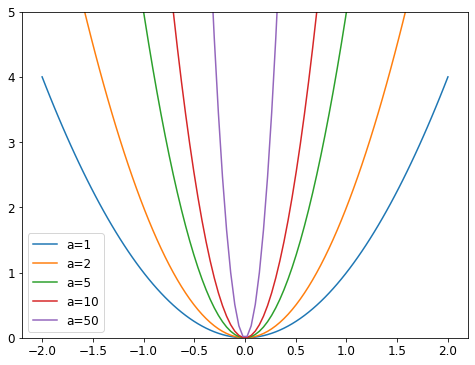

In [44]:
#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

**So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.**

## OP!
**Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better.**
#### Going back to the theory briefly, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss (assuming `parameters` is a tensor of all parameters):, wo lambda x kisika squares add,

``` python
loss_with_wd = loss + wd * (parameters**2).sum()
```

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:

``` python
parameters.grad += wd * 2 * parameters
```

### acche se nahi samjha, but okay
**In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:**

In [45]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1) # yaha hai

Much better!

#### iske pehle loss were 0.29, 0.89. usse to accha hi hai, lekin kuch khaas nahi
#### nyc ki training_loss has incresed because of wd 

### Creating Our Own Embedding Module

So far, we've used `Embedding` without thinking about how it really works. Let's re-create `DotProductBias` *without* using this class. We'll need a randomly initialized weight matrix for each of the embeddings. We have to be careful, however. **Recall from chapter_mnist_basics that optimizers require that they can get all the parameters of a module from the module's `parameters` method. However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Module`, it will not be included in `parameters`:**

### samjha nahi acche se

In [46]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)
        
# class Module1:
#     def __init__(self): self.a = torch.ones(3)        
# a = Module1()
# a.parameters()  # does not work aise!!

L(T().parameters())
# parameters ek method hoga pehle se built in

(#0) []

**To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to include in `parameters`:**

### nn.Parameters ke andar wrap karneka

In [47]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters()), T().parameters()

((#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)],
 <generator object Module.parameters at 0x7f82434de2e0>)

**All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now:**
### Noice!

In [48]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [49]:
type(t.a.weight), t.a.weight

(torch.nn.parameter.Parameter,
 Parameter containing:
 tensor([[-0.3292],
         [-0.8623],
         [ 0.0592]], requires_grad=True))

We can create a tensor as a parameter, with random initialization, like so:
#### again passed into nn.parameters

In [50]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

# create_params(n_users) # ye nahi chalega, kyuki size pass karna hai
create_params([n_users]).shape , create_params([n_users])

(torch.Size([944]),
 Parameter containing:
 tensor([-1.5933e-02,  5.0488e-04, -7.1580e-03,  1.5208e-02, -1.1482e-02,  1.4319e-02,  2.3583e-03, -3.2946e-03, -6.2303e-04, -1.0329e-02,  6.9265e-03,  8.8198e-03, -4.1715e-03, -5.6286e-03,
         -4.3192e-03, -6.7255e-03, -1.5568e-02, -1.0618e-02, -4.8861e-03, -3.0089e-03,  3.3806e-03, -1.6067e-02, -4.1838e-04, -1.3427e-02, -1.2889e-03, -6.0092e-03, -1.8405e-02,  7.1163e-04,
          3.9514e-04,  1.0288e-02,  4.6017e-03, -7.5151e-03,  1.0621e-02, -2.7088e-03,  9.9723e-04, -4.1204e-03, -1.2560e-02,  1.3989e-02, -1.0800e-02, -2.5826e-02, -1.9200e-02, -6.5241e-03,
         -7.8511e-04, -2.2779e-03,  1.2970e-04,  3.1878e-03,  7.2137e-04, -1.2931e-03,  3.6706e-03,  1.5064e-02, -1.4111e-02,  1.9595e-03, -9.6888e-03, -8.4625e-03,  1.0068e-03,  2.0585e-02,
         -2.0573e-02,  6.7348e-03,  4.3398e-03, -1.8465e-02,  1.0272e-02,  2.3821e-03,  4.3435e-03,  4.3965e-03,  8.3695e-04, -4.2166e-03, -1.4674e-02,  1.3036e-02,  1.0166e-02,  9.0201e-03,
  

In [51]:
print(create_params([n_users]).sum())
# clearly normal ke andar mean and std deviation pass kiya tha

tensor(-0.0450, grad_fn=<SumBackward0>)


Let's use this to create `DotProductBias` again, but without `Embedding`:

In [52]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Then let's train it again to check we get around the same results we saw in the previous section:

In [53]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [54]:
# basically we made our own embedding matrices
# previous results were
# 0.504981  	 0.822528

Now, let's take a look at what our model has learned.
#### wd use kiya hai, and results bhi similar aaye hai

## Interpreting Embeddings and Biases

**Our model is already useful, in that it can provide us with movie recommendations for our users—but it is also interesting to see what parameters it has discovered. The easiest to interpret are the biases. Here are the movies with the lowest values in the bias vector:**

In [55]:
# remeber movie_bias yaha se aaya tha 
# wo class define karte samay aaya tha
# self.movie_bias = create_params([n_movies])

#### argsort() function is used to perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
#### It returns an array of indices of the same shape as arr that that would sort the array.
**Returns the indices that would sort an array.**

In [57]:
x = np.array([3, 1, 2])
np.argsort(x)
# array([1, 2, 0])

array([1, 2, 0])

In [58]:
# x = np.array([3, 1, 2])
# np.argsort(x, descending=True) DID NOT WORK
# array([1, 2, 0])

In [61]:
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat())
# learn.fit_one_cycle(5, 5e-3, wd=0.1)
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [62]:
movie_bias = learn.model.movie_bias.squeeze()
# har dot se ek level andar jaa rahe hai
idxs = movie_bias.argsort()[:5]
movie_bias, idxs ,[dls.classes['title'][i] for i in idxs]

(tensor([-0.0010, -0.0932,  0.0189,  ..., -0.0241,  0.0679,  0.0323], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([ 295,  850, 1251, 1001,  784], device='cuda:0'),
 ['Children of the Corn: The Gathering (1996)',
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  'Robocop 3 (1993)',
  'Mortal Kombat: Annihilation (1997)',
  "Joe's Apartment (1996)"])

### nyc!
**Think about what this means. What it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it. We could have simply sorted the movies directly by their average rating**

**But looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! By the same token, here are the movies with the highest bias:**

In [63]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

**So, for instance, even if you don't normally enjoy detective movies, you might enjoy *LA Confidential*!**

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. **But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this book, because it is not particularly important for you to understand to be a deep learning practitioner, but if you are interested then we suggest you check out the fast.ai course [Computational Linear Algebra for Coders](https://github.com/fastai/numerical-linear-algebra). <<img_pca_movie>> shows what our movies look like based on two of the strongest PCA components.**

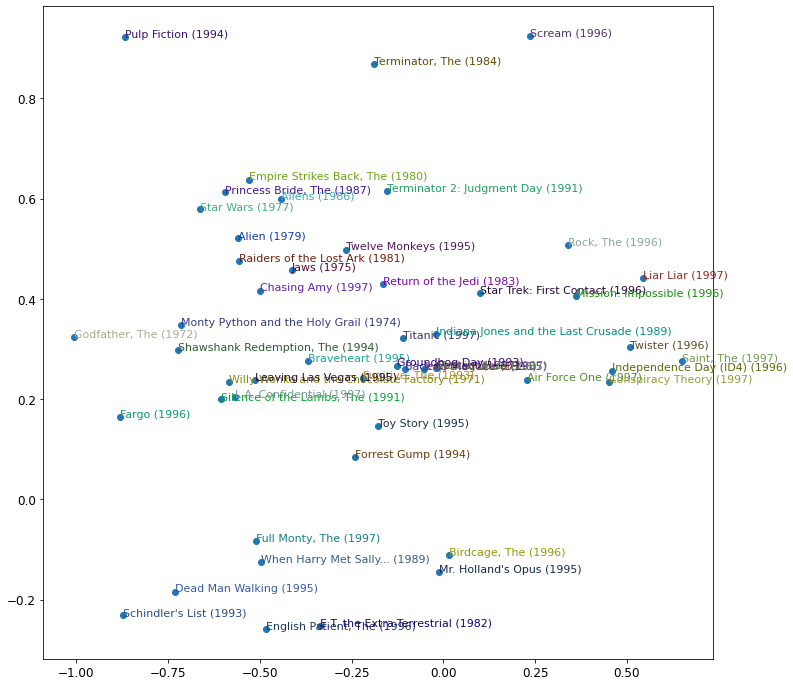

In [64]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of *classic* versus *pop culture* movies, or perhaps it is *critically acclaimed* that is represented here.

> j: **No matter how many models I train, I never stop getting moved and surprised by how these randomly initialized bunches of numbers, trained with such simple mechanics, manage to discover things about my data all by themselves. It almost seems like cheating, that I can create code that does useful things without ever actually telling it how to do those things!**

We defined our model from scratch to teach you what is inside, but you can directly use the fastai library to build it. We'll look at how to do that next.

### Using fastai.collab

We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's `collab_learner`:

In [65]:
# remember ki starting me
# dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
# dls.show_batch()

In [68]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
# 50 factors!!!!!!!!!

In [67]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

#### still overfitting, isn't it?

The names of the layers can be seen by printing the model:
## isse kya fayda hua?

In [69]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:

### gives the i_bias 'column' 

In [70]:
learn.model.i_bias

Embedding(1665, 1)

### uske andar jo bhi hai, wo aaya

In [71]:
learn.model.i_bias.weight, learn.model.i_bias.weight.shape

(Parameter containing:
 tensor([[ 0.0013],
         [ 0.0024],
         [-0.0081],
         ...,
         [ 0.0077],
         [-0.0033],
         [-0.0048]], requires_grad=True),
 torch.Size([1665, 1]))

### 2 dimensions se 1 dimensional bana diya

In [74]:
learn.model.i_bias.weight.squeeze(), learn.model.i_bias.weight.squeeze().shape

(tensor([ 0.0013,  0.0024, -0.0081,  ...,  0.0077, -0.0033, -0.0048], grad_fn=<SqueezeBackward0>),
 torch.Size([1665]))

In [75]:
learn.model.i_bias.weight.squeeze().argsort()

tensor([ 644,  690, 1649,  ...,  374, 1591,  373])

### matlab pata chala ki kaunsa weight kitna bada hai relatively (if descending use kiya hai)
**observe kaise 295 has become 830, 830 has become 295 (as expected), sum is 1125 and not its length (1665) kyuki kaafi sare values repeat huye honge. so only 1125 unique values present hai**

In [76]:
learn.model.i_bias.weight.squeeze().argsort(descending=True)

tensor([ 373, 1591,  374,  ..., 1649,  690,  644])

#### upar ki list to indices hai, jo arrange karne pe mile rehte
##### inke starting 5 lekar kya fayda hui - bhai jo argsort me result aata hai, wo ordered values hai, matlab diye gaye index par se values nikale, to sorted array milegi
## note that yaha bias se kaam kiya hai

In [77]:
# We can use these to replicate any of the analyses 
# we did in the previous section—for instance:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
print(idxs)
[dls.classes['title'][i] for i in idxs]

tensor([ 373, 1591,  374, 1091, 1145])


['Damsel in Distress, A (1937)',
 'Waiting for Guffman (1996)',
 'Dances with Wolves (1990)',
 'Office Killer (1997)',
 "Pharaoh's Army (1995)"]

In [64]:
# iske upar aaya tha:
# ['Titanic (1997)',
#  'Shawshank Redemption, The (1994)',
#  'L.A. Confidential (1997)',
#  'Silence of the Lambs, The (1991)',
#  "Schindler's List (1993)"]

Another interesting thing we can do with these learned embeddings is to look at _distance_.

### Embedding Distance

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras: $\sqrt{x^{2}+y^{2}}$ (assuming that *x* and *y* are the distances between the coordinates on each axis). **For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.**

**If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to *Silence of the Lambs*:**

In [80]:
# learn.model

# learn.model.i_weight

# learn.model.i_weight.weight, learn.model.i_weight.weight.shape

# # dls.classes #me users and titles ki badi si list hai
# dls.classes['title']

# len(dls.classes['title'])
dls.classes['title'][:5]

(#5) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)']

In [81]:
dls.classes['title'].o2i["'Til There Was You (1997)"], dls.classes['title'].o2i["1-900 (1994)"] 

(1, 2)

In [82]:
# maybe o2i is object to integer
# help(dls.classes['title'].o2i)
dls.classes['title'][1], type(dls.classes['title'][1])
# dls.classes['title']["'Til There Was You (1997)"] 
# ye nahi chalta kyuki wo simple list hai na

("'Til There Was You (1997)", str)

In [83]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
# idx me uska index aa gaya hai
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
distances, distances.shape

(tensor([ 0.2099,  0.0199,  0.1646,  ...,  0.1502,  0.1903, -0.1121], grad_fn=<DivBackward0>),
 torch.Size([1665]))

In [84]:
idx = distances.argsort(descending=True)
idx

tensor([1330,  737, 1631,  ...,  494, 1272,  798])

In [85]:
idx = idx[1]

In [86]:
dls.classes['title'][idx]

'In the Bleak Midwinter (1995)'

### we found similar movie to original
**Now that we have succesfully trained a model, let's see how to deal with the situation where we have no data for a user. How can we make recommendations to new users?**

## Bootstrapping a Collaborative Filtering Model

**The biggest challenge with using collaborative filtering models in practice is the *bootstrapping problem*. The most extreme version of this problem is when you have no users, and therefore no history to learn from. What products do you recommend to your very first user?**

But even if you are a well-established company with a long history of user transactions, **you still have the question: what do you do when a new user signs up?** And indeed, what do you do when you add a new product to your portfolio? There is no magic solution to this problem, and **really the solutions that we suggest are just variations of *use your common sense*.** 

You could **assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may be not at all common (for instance, the average for the science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action). Better would probably be to pick some particular user to represent *average taste*.**

**Better still is to use a tabular model based on user meta data to construct your initial embedding vector. When a user signs up, think about what questions you could ask them that could help you to understand their tastes. Then you can create a model where the dependent variable is a user's embedding vector, and the independent variables are the results of the questions that you ask them, along with their signup metadata. We will see in the next section how to create these kinds of tabular models. (You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what genres of movie or music you like; this is how they come up with your initial collaborative filtering recommendations.)**

**One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. People that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites. As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists. In this particular case, it can be fairly obvious that you have a problem of representation bias, but if the bias is occurring in the latent factors then it may not be obvious at all.**

Such a problem can change the entire makeup of your user base, and the behavior of your system. **This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially. You may have seen examples of company executives expressing surprise at how their online platforms rapidly deteriorated in such a way that they expressed values at odds with the values of the founders. In the presence of these kinds of feedback loops, it is easy to see how such a divergence can happen both quickly and in a way that is hidden until it is too late.**

In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. **Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data. In the end, this is coming back to our original advice about how to avoid disaster when rolling out any kind of machine learning system. It's all about ensuring that there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout.**

**Our dot product model works quite well,** and it is the basis of many successful real-world recommendation systems. This approach to collaborative filtering **is known as *probabilistic matrix factorization* (PMF). Another approach, which generally works similarly well given the same data, is deep learning.**

## Deep Learning for Collaborative Filtering

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.

Since we'll be concatenating the embeddings, rather than taking their dot product, the two embedding matrices can have different sizes (i.e., different numbers of latent factors). **fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:**

In [88]:
embs = get_emb_sz(dls)
embs
# matlab 74 features for users, 102 features for movies
# OPOPOP!

[(944, 74), (1665, 102)]

Let's implement this class:

In [89]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        # seems like * preserves parameter passed ka type
        # jaise yaha sz is still the shape (type = shape)
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

And use it to create a model:

In [90]:
model = CollabNN(*embs)
# direct size pass kiya hai

**`CollabNN` creates our `Embedding` layers in the same way as previous classes in this chapter, except that we now use the `embs` sizes. `self.layers` is identical to the mini-neural net we created in chapter_mnist_basics for MNIST. Then, in `forward`, we apply the embeddings, concatenate the results, and pass this through the mini-neural net. Finally, we apply `sigmoid_range` as we have in previous models.**

### theek theek samjha

Let's see if it trains:

In [91]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

**fastai provides this model in `fastai.collab` if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:**

In [92]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:

In [93]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Wow, that's not a lot of code! 

**This class *inherits* from `TabularModel`, which is where it gets all its functionality from. In `__init__` it calls the same method in `TabularModel`, passing `n_cont=0` and `out_sz=1`; other than that, it only passes along whatever arguments it received.**

#### looks like super() directed to Tabular model

### Sidebar: kwargs and Delegates

`EmbeddingNN` includes `**kwargs` as a parameter to `__init__`. In Python `**kwargs` in a parameter list means "put any additional keyword arguments into a dict called `kwargs`. And `**kwargs` in an argument list means "insert all key/value pairs in the `kwargs` dict as named arguments here". This approach is used in many popular libraries, such as `matplotlib`, in which the main `plot` function simply has the signature `plot(*args, **kwargs)`. The [`plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) says "The `kwargs` are `Line2D` properties" and then lists those properties.

We're using `**kwargs` in `EmbeddingNN` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync. However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available. Consequently things like tab completion of parameter names and pop-up lists of signatures won't work.

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.

### End sidebar

**Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what `TabularModel` does. In fact, we've now seen that `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1`. So, we'd better spend some time learning about `TabularModel`, and how to use it to get great results! We'll do that in the next chapter.**

## Conclusion

For our first non-computer vision application, we looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data. 
We also built our first model in PyTorch. We will do a lot more of this in the next section of the book, but first, let's finish our dive into the other general applications of deep learning, continuing with tabular data.

## Questionnaire

1. What problem does collaborative filtering solve?
#### One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called collaborative filtering

1. How does it solve it?
#### which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
#### ??????? maybe ye neeche wala
##### One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. Such a problem can change the entire makeup of your user base, and the behavior of your system. This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially.

1. What does a crosstab representation of collaborative filtering data look like?
<img alt="Crosstab of movies and users" width="632" caption="Crosstab of movies and users" id="movie_xtab" src="images/att_00040.png">

1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
#### done below

1. What is a latent factor? Why is it "latent"?
#### underlying factors jaise action, drama content etc. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it. Latent because not directly stated by the movie !

1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
#### merge karta hai dataframe ko

1. What is an embedding matrix?
#### We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.
#### Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix.

1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
#### output same hi hai, lekin embedding ek shortcut jaisa hai

1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
#### memory not unneccessarily used

1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
#### random values - We will attribute to each of our users and each of our movies a random vector of a certain length (here, n_factors=5), and we will make those learnable parameters.

1. Create a class (without peeking, if possible!) and use it.

In [95]:
class fun:
    def __init__(self,a): self.a = 'five' + a
    def aise_hi(self, b): return self.a + b
    
ex = fun('hello')
print()
# class Example:
#     def __init__(self, a): self.a = a
#     def say(self,x): return f'Hello {self.a}, {x}.'

1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why? 
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

In [91]:
# for making the crosstab
a = np.array(["foo", "foo", "foo", "foo", "bar", "bar",
              "bar", "bar", "foo", "foo", "foo"], dtype=object)
b = np.array(["one", "one", "one", "two", "one", "one",
              "one", "two", "two", "two", "one"], dtype=object)
c = np.array(["dull", "dull", "shiny", "dull", "dull", "shiny",
              "shiny", "dull", "shiny", "shiny", "shiny"], dtype=object)
pd.crosstab(a, [b, c], rownames=['a'], colnames=['b', 'c'])

b    one        two      
c   dull shiny dull shiny
a                        
bar    1     2    1     0
foo    2     2    1     2

In [92]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

user  movie  rating  timestamp
0   196    242       3  881250949
1   186    302       3  891717742
2    22    377       1  878887116
3   244     51       2  880606923
4   166    346       1  886397596

In [93]:
# pd.crosstab(ratings['user'], [ratings['movie'], ratings['rating']])
pd.crosstab(ratings['user'], ratings['movie'], values=ratings['rating'], aggfunc='mean') 
# pd.crosstab(ratings['user'], ratings['movie'], values=ratings['rating'], aggfunc=None) #nahi chalta
# pd.crosstab( ratings['user'], columns = ratings[['movie', 'rating']]) #nahi chalta

movie  1     2     3     4     5     6     7     8     9     10    11    12    \
user                                                                            
1       5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0   2.0   5.0   
2       4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   NaN   
5       4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN   
940     NaN   NaN   NaN   2.0   NaN   NaN   4.0   5.0   3.0   NaN   NaN   4.0   
941     5.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN   
942     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
943     NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   4.0   5.0   

movie  13    14    15    16    17    18    19    20    21    22    23    24    \
user                                                                            
1       5.0   5.0   5.0   5.0   3.0   4.0   5.0   4.0   1.0   4.0   4.0   3.0   
2       4.0   4.0   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN   NaN   
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5       NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   3.0   NaN   NaN   4.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939     NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
940     NaN   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
941     NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
942     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
943     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   4.0   4.0   

movie  25    26    27    28    29    30    31    32    33    34    35    36    \
user                                                                            
1       4.0   3.0   2.0   4.0   1.0   3.0   3.0   5.0   4.0   2.0   1.0   2.0   
2       4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5       3.0   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
940     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
941     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
942     NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN   
943     NaN   NaN   4.0   4.0   NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN   

movie  37    38    39    40    41    42    43    44    45    46    47    48    \
user                                                                            
1       2.0   3.0   4.0   3.0   2.0   5.0   4.0   5.0   5.0   4.0   4.0   5.0   
2       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5       NaN   NaN   NaN   4.0   NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
940     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   
941     NaN   NaN   NaN   Na

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.